In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return term12  + term3

In [3]:
# Domain bounds
label = "Regr_smooth_unscaled_atanh"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.alpha = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(10.0)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(model_NN.alpha.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
alpha_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    alpha_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    alpha_full.append(alpha_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"alpha": alpha_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1.5340309 Test MSE 1.6110703462915468 Test RE 1.0715910216550824
1 Train Loss 1.6398556 Test MSE 1.5208644722952198 Test RE 1.0411590335581953
2 Train Loss 1.4267716 Test MSE 1.5769404188093212 Test RE 1.0601796325423054
3 Train Loss 1.4527893 Test MSE 1.2377508594242532 Test RE 0.9392656337590743
4 Train Loss 1.1791246 Test MSE 1.3125549063488333 Test RE 0.9672317722305308
5 Train Loss 1.1329778 Test MSE 1.1219605162000033 Test RE 0.8942534019823843
6 Train Loss 0.97246933 Test MSE 1.0041751959570138 Test RE 0.8460120698435154
7 Train Loss 0.9286005 Test MSE 0.9516357724396114 Te

112 Train Loss 0.47308087 Test MSE 0.526254167895679 Test RE 0.612448518489444
113 Train Loss 0.4575745 Test MSE 0.5380392350718906 Test RE 0.6192682118934609
114 Train Loss 0.45678225 Test MSE 0.5150411547072411 Test RE 0.6058885993553318
115 Train Loss 0.45013288 Test MSE 0.5233291004317846 Test RE 0.6107440668805432
116 Train Loss 0.4444625 Test MSE 0.5123588139199081 Test RE 0.6043088020605142
117 Train Loss 0.4417504 Test MSE 0.5127533620336784 Test RE 0.6045414349419156
118 Train Loss 0.4455474 Test MSE 0.513221914763289 Test RE 0.604817586089387
119 Train Loss 0.44197673 Test MSE 0.5151016142045667 Test RE 0.6059241602467793
120 Train Loss 0.43924904 Test MSE 0.5118438516502294 Test RE 0.604005035971653
121 Train Loss 0.44858053 Test MSE 0.5501932491138686 Test RE 0.6262236177906663
122 Train Loss 0.46266207 Test MSE 0.5260152853940608 Test RE 0.6123094983640389
123 Train Loss 0.45714688 Test MSE 0.5208728193630224 Test RE 0.6093090965089675
124 Train Loss 0.46405753 Test MSE 0.

218 Train Loss 0.34051552 Test MSE 0.37224685122979423 Test RE 0.5150949957139628
219 Train Loss 0.3131454 Test MSE 0.36261681052704325 Test RE 0.5083885737413117
220 Train Loss 0.30323544 Test MSE 0.3609937961151968 Test RE 0.5072495651400861
221 Train Loss 0.30678207 Test MSE 0.3775644133573868 Test RE 0.5187610267651771
222 Train Loss 0.3233169 Test MSE 0.3851585412145124 Test RE 0.5239520944859034
223 Train Loss 0.3437477 Test MSE 0.4138473232224999 Test RE 0.5431151149992421
224 Train Loss 0.3701598 Test MSE 0.38068460462680015 Test RE 0.5209001363056487
225 Train Loss 0.34306967 Test MSE 0.3762229775635221 Test RE 0.5178386625515758
226 Train Loss 0.32153076 Test MSE 0.35340866183993475 Test RE 0.5018921569212612
227 Train Loss 0.3005527 Test MSE 0.3486936652645569 Test RE 0.49853292150769735
228 Train Loss 0.29484543 Test MSE 0.3546622302030219 Test RE 0.5027814944901764
229 Train Loss 0.2988855 Test MSE 0.3579813853105045 Test RE 0.5051286904153838
230 Train Loss 0.311825 Test 

321 Train Loss 0.26350605 Test MSE 0.28827943780935195 Test RE 0.4532926189603157
322 Train Loss 0.2620391 Test MSE 0.27022680164346197 Test RE 0.4388701314603443
323 Train Loss 0.24251279 Test MSE 0.24958086163813198 Test RE 0.42177171741518543
324 Train Loss 0.21856837 Test MSE 0.24779564798410408 Test RE 0.42026057609685197
325 Train Loss 0.21455581 Test MSE 0.2607546777023987 Test RE 0.4311097730513493
326 Train Loss 0.2290026 Test MSE 0.26895179293414695 Test RE 0.4378335487754009
327 Train Loss 0.2394778 Test MSE 0.2700032896094994 Test RE 0.4386885931241582
328 Train Loss 0.25011617 Test MSE 0.2865571461410459 Test RE 0.45193651868407664
329 Train Loss 0.26070127 Test MSE 0.26293345742885615 Test RE 0.43290713156982674
330 Train Loss 0.23987691 Test MSE 0.24866328420275124 Test RE 0.4209956872140302
331 Train Loss 0.21863098 Test MSE 0.24489439082167425 Test RE 0.41779307114130665
332 Train Loss 0.2122676 Test MSE 0.2456657938232379 Test RE 0.4184505656449645
333 Train Loss 0.21

427 Train Loss 0.17783515 Test MSE 0.20963294220753972 Test RE 0.3865463520500185
428 Train Loss 0.18710162 Test MSE 0.21194472500002837 Test RE 0.38867187930136365
429 Train Loss 0.19422372 Test MSE 0.21141531000821526 Test RE 0.38818614563298653
430 Train Loss 0.19185607 Test MSE 0.2053810582739393 Test RE 0.3826062039913866
431 Train Loss 0.18512055 Test MSE 0.19873604393531757 Test RE 0.37636578423144185
432 Train Loss 0.1738334 Test MSE 0.19182701362962712 Test RE 0.3697657631432546
433 Train Loss 0.16534032 Test MSE 0.18892305199612436 Test RE 0.3669562513776894
434 Train Loss 0.16330221 Test MSE 0.19537419465151928 Test RE 0.37316887616518013
435 Train Loss 0.16876893 Test MSE 0.20179604172432739 Test RE 0.37925222361548294
436 Train Loss 0.17840971 Test MSE 0.20865395126576067 Test RE 0.3856427053668274
437 Train Loss 0.18564497 Test MSE 0.2076314429667356 Test RE 0.38469662419688244
438 Train Loss 0.18750222 Test MSE 0.20308991455202097 Test RE 0.3804661227634287
439 Train Los

535 Train Loss 0.14135511 Test MSE 0.16391028936028681 Test RE 0.34180225428466715
536 Train Loss 0.14215139 Test MSE 0.16330084707754802 Test RE 0.34116622729004725
537 Train Loss 0.14288042 Test MSE 0.16478828386745745 Test RE 0.342716472969452
538 Train Loss 0.14352639 Test MSE 0.16357137971526264 Test RE 0.34144870716329495
539 Train Loss 0.14326355 Test MSE 0.16284828632147616 Test RE 0.3406931569743331
540 Train Loss 0.14165053 Test MSE 0.16135739526952733 Test RE 0.33913003250416546
541 Train Loss 0.14025834 Test MSE 0.16142458211068567 Test RE 0.33920062952960417
542 Train Loss 0.13985482 Test MSE 0.16244528887264786 Test RE 0.34027134252384056
543 Train Loss 0.14036526 Test MSE 0.16181405096019996 Test RE 0.3396095774387514
544 Train Loss 0.14103206 Test MSE 0.1627371253746881 Test RE 0.34057685781081365
545 Train Loss 0.1413749 Test MSE 0.16222795690393513 Test RE 0.3400436455789967
546 Train Loss 0.14163086 Test MSE 0.1622310314284905 Test RE 0.3400468677966859
547 Train Los

642 Train Loss 0.13189203 Test MSE 0.15032731766433124 Test RE 0.32733373677988703
643 Train Loss 0.12884733 Test MSE 0.15559250586420137 Test RE 0.33301680655467364
644 Train Loss 0.13433161 Test MSE 0.1541247321553634 Test RE 0.3314423363335169
645 Train Loss 0.13350709 Test MSE 0.14975616710488154 Test RE 0.32671131243294
646 Train Loss 0.13077413 Test MSE 0.15614402868138502 Test RE 0.3336065004327164
647 Train Loss 0.13741502 Test MSE 0.15179992983476498 Test RE 0.3289331163508471
648 Train Loss 0.13241361 Test MSE 0.14971943163729287 Test RE 0.3266712385275619
649 Train Loss 0.13047194 Test MSE 0.1577183370240648 Test RE 0.3352840615721296
650 Train Loss 0.13824631 Test MSE 0.15004656913887232 Test RE 0.3270279327103261
651 Train Loss 0.13098273 Test MSE 0.14910254441674756 Test RE 0.3259975540287467
652 Train Loss 0.12932844 Test MSE 0.15401463909851856 Test RE 0.3313239386629763
653 Train Loss 0.13513687 Test MSE 0.1515199516223072 Test RE 0.328629635942151
654 Train Loss 0.131

748 Train Loss 0.12635814 Test MSE 0.18569776539767935 Test RE 0.3638104362333817
749 Train Loss 0.16340135 Test MSE 0.17890002167938843 Test RE 0.35708944292656586
750 Train Loss 0.16381608 Test MSE 0.17665674454735822 Test RE 0.35484355834993736
751 Train Loss 0.16594335 Test MSE 0.1693808430745123 Test RE 0.3474593151376291
752 Train Loss 0.15586962 Test MSE 0.15312323701280367 Test RE 0.3303637330702613
753 Train Loss 0.13248768 Test MSE 0.14807034422758994 Test RE 0.3248671939455068
754 Train Loss 0.1278023 Test MSE 0.14086591679473207 Test RE 0.3168653694370994
755 Train Loss 0.12059332 Test MSE 0.15532883470183823 Test RE 0.3327345173803967
756 Train Loss 0.13063814 Test MSE 0.15040673907935873 Test RE 0.32742019437164877
757 Train Loss 0.13101418 Test MSE 0.14368001450732645 Test RE 0.3200147497575411
758 Train Loss 0.122344285 Test MSE 0.1433769864744902 Test RE 0.31967710842020103
759 Train Loss 0.121681854 Test MSE 0.1363197596146775 Test RE 0.31171034799880415
760 Train Los

858 Train Loss 0.10299706 Test MSE 0.1285350242192725 Test RE 0.30267918510876823
859 Train Loss 0.10759197 Test MSE 0.13287532053163584 Test RE 0.307747105430003
860 Train Loss 0.1173198 Test MSE 0.12741380853057685 Test RE 0.30135615280724065
861 Train Loss 0.10885436 Test MSE 0.13915558703302686 Test RE 0.31493587734570694
862 Train Loss 0.11724657 Test MSE 0.15015426191712863 Test RE 0.3271452703801127
863 Train Loss 0.13187633 Test MSE 0.14742271532101886 Test RE 0.32415596461254226
864 Train Loss 0.12657146 Test MSE 0.1321088418496384 Test RE 0.3068582167160475
865 Train Loss 0.11436389 Test MSE 0.12898450418176982 Test RE 0.3032079495400851
866 Train Loss 0.112401046 Test MSE 0.13061466820951972 Test RE 0.3051179726008967
867 Train Loss 0.10678663 Test MSE 0.1240916092353662 Test RE 0.2974014095107918
868 Train Loss 0.10548516 Test MSE 0.12102911901235389 Test RE 0.29370865886681147
869 Train Loss 0.10222744 Test MSE 0.1250386847945744 Test RE 0.2985341461797253
870 Train Loss 0

967 Train Loss 0.08664429 Test MSE 0.10706484345883155 Test RE 0.2762455287647243
968 Train Loss 0.09000474 Test MSE 0.10338421992529394 Test RE 0.2714556852687106
969 Train Loss 0.08788328 Test MSE 0.10159070568199502 Test RE 0.269090770823502
970 Train Loss 0.084505334 Test MSE 0.1005137250749929 Test RE 0.2676606315809967
971 Train Loss 0.08383305 Test MSE 0.1014796331789602 Test RE 0.26894362764109253
972 Train Loss 0.08407629 Test MSE 0.10214454784114016 Test RE 0.26982327505393444
973 Train Loss 0.08517868 Test MSE 0.10268342300381901 Test RE 0.2705340804691311
974 Train Loss 0.086972825 Test MSE 0.10239656944452111 Test RE 0.27015593794467274
975 Train Loss 0.08635508 Test MSE 0.1009541988339984 Test RE 0.26824646502491156
976 Train Loss 0.0844366 Test MSE 0.09945750104327948 Test RE 0.26625059421797903
977 Train Loss 0.08344725 Test MSE 0.09904176870041857 Test RE 0.26569354776834936
978 Train Loss 0.08201415 Test MSE 0.09854525184314235 Test RE 0.2650267226498905
979 Train Los

1072 Train Loss 0.100145005 Test MSE 0.1016396360461555 Test RE 0.2691555657488421
1073 Train Loss 0.0838383 Test MSE 0.10850594017204983 Test RE 0.2780984519683949
1074 Train Loss 0.089855805 Test MSE 0.10592342620039293 Test RE 0.27476905760669657
1075 Train Loss 0.08824528 Test MSE 0.09214246334619824 Test RE 0.2562723335435235
1076 Train Loss 0.07859928 Test MSE 0.10555673097607929 Test RE 0.2742930351720236
1077 Train Loss 0.08593266 Test MSE 0.08947613005492999 Test RE 0.25253722868106077
1078 Train Loss 0.075928204 Test MSE 0.09835447450047807 Test RE 0.2647700609263801
1079 Train Loss 0.081552364 Test MSE 0.09887324341960664 Test RE 0.26546740508214706
1080 Train Loss 0.082255796 Test MSE 0.0992872723352695 Test RE 0.26602264306090445
1081 Train Loss 0.08108592 Test MSE 0.10812137504582262 Test RE 0.277605198353109
1082 Train Loss 0.09522568 Test MSE 0.10646020132760392 Test RE 0.2754643845040105
1083 Train Loss 0.08659661 Test MSE 0.11033663429582292 Test RE 0.2804346545275978

1177 Train Loss 0.07332783 Test MSE 0.09337896925545672 Test RE 0.2579861266023656
1178 Train Loss 0.0740178 Test MSE 0.09806847951496027 Test RE 0.2643848316979057
1179 Train Loss 0.08419608 Test MSE 0.08272630208968455 Test RE 0.2428251244489569
1180 Train Loss 0.069500014 Test MSE 0.0888045695838309 Test RE 0.2515877383492519
1181 Train Loss 0.071891025 Test MSE 0.09884337909592532 Test RE 0.2654273102952004
1182 Train Loss 0.08466547 Test MSE 0.08595162743107873 Test RE 0.2475134856748979
1183 Train Loss 0.06913457 Test MSE 0.08288314845851161 Test RE 0.24305520969751113
1184 Train Loss 0.069671415 Test MSE 0.08546089068552991 Test RE 0.2468058909732831
1185 Train Loss 0.07380521 Test MSE 0.09108178674998053 Test RE 0.2547930543613699
1186 Train Loss 0.07341433 Test MSE 0.08056628451631148 Test RE 0.23963402479985388
1187 Train Loss 0.069244936 Test MSE 0.07787661208867612 Test RE 0.2356000287715645
1188 Train Loss 0.06583932 Test MSE 0.08946054022789218 Test RE 0.25251522737624865

1284 Train Loss 0.11917567 Test MSE 0.17374963368208687 Test RE 0.35191174616182413
1285 Train Loss 0.15422884 Test MSE 0.14464866832714415 Test RE 0.3210916664297242
1286 Train Loss 0.12669584 Test MSE 0.10961688367758333 Test RE 0.27951848891273817
1287 Train Loss 0.1000559 Test MSE 0.19123193757034307 Test RE 0.36919178333066716
1288 Train Loss 0.1531323 Test MSE 0.10656322433194411 Test RE 0.27559763761511874
1289 Train Loss 0.10136272 Test MSE 0.15774677237116996 Test RE 0.3353142847191841
1290 Train Loss 0.14611655 Test MSE 0.20638786482321075 Test RE 0.38354285194713694
1291 Train Loss 0.17578773 Test MSE 0.10699009491727991 Test RE 0.2761490799443093
1292 Train Loss 0.09137819 Test MSE 0.18388478980908954 Test RE 0.3620301314968935
1293 Train Loss 0.16600479 Test MSE 0.13668116625744 Test RE 0.3121232728132529
1294 Train Loss 0.11641167 Test MSE 0.1292975292942931 Test RE 0.3035756456015124
1295 Train Loss 0.10772271 Test MSE 0.14717331564464778 Test RE 0.32388165609367153
1296

1388 Train Loss 0.05512931 Test MSE 0.0586060554662008 Test RE 0.2043821955027177
1389 Train Loss 0.05038224 Test MSE 0.05934220040472474 Test RE 0.20566180218628402
1390 Train Loss 0.050651353 Test MSE 0.0658639328029169 Test RE 0.21666843372450578
1391 Train Loss 0.053998146 Test MSE 0.06586841637143646 Test RE 0.21667580825556906
1392 Train Loss 0.05801115 Test MSE 0.07478392025994145 Test RE 0.23087447879675746
1393 Train Loss 0.060311534 Test MSE 0.06559891875820356 Test RE 0.2162320943514577
1394 Train Loss 0.057524767 Test MSE 0.06813791332909912 Test RE 0.2203769808455254
1395 Train Loss 0.055553958 Test MSE 0.06167490931090131 Test RE 0.2096650654315115
1396 Train Loss 0.05351377 Test MSE 0.06188328946255228 Test RE 0.21001896296537184
1397 Train Loss 0.052183107 Test MSE 0.058865304798196176 Test RE 0.2048337484985356
1398 Train Loss 0.051455483 Test MSE 0.059982751381129705 Test RE 0.20676879918777025
1399 Train Loss 0.050663926 Test MSE 0.057409129986182306 Test RE 0.202284

1493 Train Loss 0.047891725 Test MSE 0.06009273965685903 Test RE 0.2069582847261346
1494 Train Loss 0.049603213 Test MSE 0.05972307878216932 Test RE 0.20632075015403908
1495 Train Loss 0.05301184 Test MSE 0.06750148442099208 Test RE 0.2193453721760251
1496 Train Loss 0.05625406 Test MSE 0.06632481884606113 Test RE 0.21742518608168712
1497 Train Loss 0.05949472 Test MSE 0.07197509754798921 Test RE 0.22649725618191754
1498 Train Loss 0.059413888 Test MSE 0.0642880001880958 Test RE 0.21406061674734841
1499 Train Loss 0.057184875 Test MSE 0.0691198659023426 Test RE 0.22195925459657231
1500 Train Loss 0.05539059 Test MSE 0.05917748203060395 Test RE 0.20537617224637358
1501 Train Loss 0.051971767 Test MSE 0.06230703079444525 Test RE 0.2107367810607165
1502 Train Loss 0.051115017 Test MSE 0.05818634667596514 Test RE 0.2036490363055207
1503 Train Loss 0.0515511 Test MSE 0.061135685442050794 Test RE 0.2087465022077375
1504 Train Loss 0.052808452 Test MSE 0.059418676819697744 Test RE 0.205794281

1596 Train Loss 0.057292946 Test MSE 0.07025472943936463 Test RE 0.2237739855561697
1597 Train Loss 0.055769045 Test MSE 0.05033516190649908 Test RE 0.18941202587786957
1598 Train Loss 0.04378056 Test MSE 0.04826719817899827 Test RE 0.18548032960718086
1599 Train Loss 0.041611753 Test MSE 0.06132839723429487 Test RE 0.20907524850831138
1600 Train Loss 0.04895998 Test MSE 0.06101423184012883 Test RE 0.20853904874871168
1601 Train Loss 0.053028952 Test MSE 0.07065601893320303 Test RE 0.22441216525622715
1602 Train Loss 0.056110684 Test MSE 0.06331397182919668 Test RE 0.21243280983599527
1603 Train Loss 0.05462512 Test MSE 0.060466558889222866 Test RE 0.20760100000377765
1604 Train Loss 0.0500336 Test MSE 0.054085380267346196 Test RE 0.1963413433013797
1605 Train Loss 0.045541916 Test MSE 0.052990925112183014 Test RE 0.19434463892149334
1606 Train Loss 0.044280425 Test MSE 0.05168055049465812 Test RE 0.19192669277638827
1607 Train Loss 0.04615921 Test MSE 0.05590014401500748 Test RE 0.199

1705 Train Loss 0.037786588 Test MSE 0.04350908433722302 Test RE 0.17610098533066715
1706 Train Loss 0.03782694 Test MSE 0.04648793230108174 Test RE 0.18202956414003488
1707 Train Loss 0.0397217 Test MSE 0.05125946162283194 Test RE 0.19114319208929048
1708 Train Loss 0.04276752 Test MSE 0.05316189324336798 Test RE 0.1946578999411037
1709 Train Loss 0.04598314 Test MSE 0.06279565460789699 Test RE 0.21156148668673183
1710 Train Loss 0.052087303 Test MSE 0.06489352322537008 Test RE 0.2150663631292091
1711 Train Loss 0.056472704 Test MSE 0.06395038414660152 Test RE 0.21349779451125236
1712 Train Loss 0.052663296 Test MSE 0.05074164203382169 Test RE 0.19017528369641176
1713 Train Loss 0.04439837 Test MSE 0.04890963338987895 Test RE 0.1867106186539798
1714 Train Loss 0.040567365 Test MSE 0.04331042071148111 Test RE 0.17569848447758443
1715 Train Loss 0.037729543 Test MSE 0.04571316164176992 Test RE 0.18050633310956002
1716 Train Loss 0.040255744 Test MSE 0.05580751536341931 Test RE 0.1994427

1813 Train Loss 0.026108943 Test MSE 0.032329419974667324 Test RE 0.1517996501621276
1814 Train Loss 0.025360627 Test MSE 0.031920222637850604 Test RE 0.15083591776455066
1815 Train Loss 0.02407811 Test MSE 0.03065531969618148 Test RE 0.14781712087979543
1816 Train Loss 0.023120012 Test MSE 0.029290449783285443 Test RE 0.14448901637619985
1817 Train Loss 0.0224561 Test MSE 0.02985475776254327 Test RE 0.14587423451405546
1818 Train Loss 0.022163922 Test MSE 0.028336800338756067 Test RE 0.14211738877164826
1819 Train Loss 0.021492412 Test MSE 0.02762049897653283 Test RE 0.1403096606395584
1820 Train Loss 0.021434307 Test MSE 0.029333312888100323 Test RE 0.1445946990096939
1821 Train Loss 0.021669392 Test MSE 0.027355457126489683 Test RE 0.13963484344974283
1822 Train Loss 0.02139083 Test MSE 0.028011871556627137 Test RE 0.14130023279389878
1823 Train Loss 0.020994172 Test MSE 0.027796473401282884 Test RE 0.14075591813165608
1824 Train Loss 0.020846272 Test MSE 0.027557579979755772 Test R

1921 Train Loss 0.020579413 Test MSE 0.025963210395056915 Test RE 0.13603510950607212
1922 Train Loss 0.018925667 Test MSE 0.025583027016712293 Test RE 0.13503544468259085
1923 Train Loss 0.020006066 Test MSE 0.028948352551401015 Test RE 0.14364275984795985
1924 Train Loss 0.021747334 Test MSE 0.03282563693392745 Test RE 0.15296018318854204
1925 Train Loss 0.024736522 Test MSE 0.030436070540098142 Test RE 0.14728757274606108
1926 Train Loss 0.023393342 Test MSE 0.030359915223847754 Test RE 0.14710319025624286
1927 Train Loss 0.022351723 Test MSE 0.02490233307697811 Test RE 0.1332268725245267
1928 Train Loss 0.018283451 Test MSE 0.022073552469029045 Test RE 0.1254318797628789
1929 Train Loss 0.016798219 Test MSE 0.024107695532435313 Test RE 0.1310839933138846
1930 Train Loss 0.017000679 Test MSE 0.024276702608127046 Test RE 0.13154267319832375
1931 Train Loss 0.017952966 Test MSE 0.02620311358732252 Test RE 0.13666215474448917
1932 Train Loss 0.020331465 Test MSE 0.029794706381122464 Te

2030 Train Loss 0.014683468 Test MSE 0.029827146472543562 Test RE 0.14580676273063556
2031 Train Loss 0.014694186 Test MSE 0.029807105340838178 Test RE 0.14575777005285864
2032 Train Loss 0.014797747 Test MSE 0.031001967046784127 Test RE 0.14865052225519446
2033 Train Loss 0.014732754 Test MSE 0.03022947803915143 Test RE 0.14678684583299434
2034 Train Loss 0.014604053 Test MSE 0.030294706347519275 Test RE 0.14694512673708146
2035 Train Loss 0.014486556 Test MSE 0.02983524138638538 Test RE 0.14582654694151603
2036 Train Loss 0.014318457 Test MSE 0.02939313122602475 Test RE 0.14474205722803127
2037 Train Loss 0.014239273 Test MSE 0.029198610255965377 Test RE 0.1442623175512498
2038 Train Loss 0.014155646 Test MSE 0.029523280858261083 Test RE 0.14506215443226567
2039 Train Loss 0.014178649 Test MSE 0.029838282765559113 Test RE 0.14583397946929116
2040 Train Loss 0.014206407 Test MSE 0.02952549651378414 Test RE 0.14506759762361002
2041 Train Loss 0.014198081 Test MSE 0.029793019606786306 T

2147 Train Loss 0.013934157 Test MSE 0.02808361166890095 Test RE 0.14148105635188282
2148 Train Loss 0.014678981 Test MSE 0.029917540130048693 Test RE 0.14602753537326052
2149 Train Loss 0.015667124 Test MSE 0.02970524734533109 Test RE 0.1455085123771398
2150 Train Loss 0.016280426 Test MSE 0.030982139995353975 Test RE 0.14860298054716756
2151 Train Loss 0.017445927 Test MSE 0.03255501914464637 Test RE 0.15232836888852086
2152 Train Loss 0.018763194 Test MSE 0.0344664225672375 Test RE 0.15673641836478486
2153 Train Loss 0.021874035 Test MSE 0.040234258563480195 Test RE 0.1693440006432514
2154 Train Loss 0.025894605 Test MSE 0.0486161181733476 Test RE 0.1861495341478156
2155 Train Loss 0.03547949 Test MSE 0.05900225223081225 Test RE 0.20507187824160078
2156 Train Loss 0.04463881 Test MSE 0.07866897400796968 Test RE 0.23679556127788026
2157 Train Loss 0.06378098 Test MSE 0.07852750145452564 Test RE 0.2365825475218148
2158 Train Loss 0.067653604 Test MSE 0.09470167467663666 Test RE 0.2598

2261 Train Loss 0.021264836 Test MSE 0.027662032668512835 Test RE 0.14041511472830612
2262 Train Loss 0.0141701605 Test MSE 0.03737772919817111 Test RE 0.16322184055347821
2263 Train Loss 0.023618523 Test MSE 0.04518876123364186 Test RE 0.17946800381018435
2264 Train Loss 0.031263076 Test MSE 0.049336019690639644 Test RE 0.1875227091162203
2265 Train Loss 0.036066514 Test MSE 0.049702953670152906 Test RE 0.18821876230534254
2266 Train Loss 0.033496473 Test MSE 0.05373805520946698 Test RE 0.19570989628748423
2267 Train Loss 0.036085438 Test MSE 0.0463224071931169 Test RE 0.18170520757823333
2268 Train Loss 0.029398683 Test MSE 0.0341470490413037 Test RE 0.15600855106494696
2269 Train Loss 0.019666158 Test MSE 0.028145453010725383 Test RE 0.14163674442964952
2270 Train Loss 0.015390385 Test MSE 0.03587814186035002 Test RE 0.15991411007685288
2271 Train Loss 0.020371031 Test MSE 0.0446550969186903 Test RE 0.17840512757103144
2272 Train Loss 0.028230455 Test MSE 0.0424780823917732 Test RE 

2368 Train Loss 0.014368338 Test MSE 0.027694184143488936 Test RE 0.1404966930065801
2369 Train Loss 0.014817806 Test MSE 0.029461918996464165 Test RE 0.14491132577122137
2370 Train Loss 0.013917808 Test MSE 0.02681184402131549 Test RE 0.13824045555657516
2371 Train Loss 0.012779338 Test MSE 0.025776674832798115 Test RE 0.1355455489357757
2372 Train Loss 0.011769001 Test MSE 0.02567642354969044 Test RE 0.13528170859681016
2373 Train Loss 0.011593066 Test MSE 0.02507507876792328 Test RE 0.13368816652575666
2374 Train Loss 0.012048779 Test MSE 0.027091331877355844 Test RE 0.13895909994890457
2375 Train Loss 0.012706111 Test MSE 0.027507152897680822 Test RE 0.14002147071109763
2376 Train Loss 0.013468256 Test MSE 0.028742451738078975 Test RE 0.14313100463747921
2377 Train Loss 0.013333732 Test MSE 0.02750483004384838 Test RE 0.14001555849841202
2378 Train Loss 0.013032422 Test MSE 0.027815550731225044 Test RE 0.14080421178522107
2379 Train Loss 0.012674213 Test MSE 0.02582923003937139 Tes

2474 Train Loss 0.014974821 Test MSE 0.026341552226105378 Test RE 0.1370226920398499
2475 Train Loss 0.015844159 Test MSE 0.03348041710414069 Test RE 0.15447821557590286
2476 Train Loss 0.019639108 Test MSE 0.030885424841235302 Test RE 0.14837085658971658
2477 Train Loss 0.020636046 Test MSE 0.03071994649315709 Test RE 0.147972851070068
2478 Train Loss 0.017787734 Test MSE 0.028961184407171003 Test RE 0.14367459238421332
2479 Train Loss 0.01490543 Test MSE 0.025975034143626178 Test RE 0.1360660814433935
2480 Train Loss 0.013594024 Test MSE 0.028495010389048035 Test RE 0.1425135715186961
2481 Train Loss 0.0143798785 Test MSE 0.029898900194911808 Test RE 0.14598203751681346
2482 Train Loss 0.017385079 Test MSE 0.0299625269371401 Test RE 0.1461372844507641
2483 Train Loss 0.017029911 Test MSE 0.02705451860028655 Test RE 0.13886465500105435
2484 Train Loss 0.014630474 Test MSE 0.025685747778429045 Test RE 0.13530626971016652
2485 Train Loss 0.012620495 Test MSE 0.02383523021034115 Test RE 

2580 Train Loss 0.014833544 Test MSE 0.029821315230770182 Test RE 0.14579250933824386
2581 Train Loss 0.020108007 Test MSE 0.03377979386929243 Test RE 0.15516733877523267
2582 Train Loss 0.020132504 Test MSE 0.0263844163335113 Test RE 0.1371341313342418
2583 Train Loss 0.01408313 Test MSE 0.028911465540152677 Test RE 0.14355121334171989
2584 Train Loss 0.017686883 Test MSE 0.02847123149968869 Test RE 0.14245409581253252
2585 Train Loss 0.015832452 Test MSE 0.02775641532145397 Test RE 0.1406544584141429
2586 Train Loss 0.015122316 Test MSE 0.026282385794320788 Test RE 0.13686872045102175
2587 Train Loss 0.015685245 Test MSE 0.02856212972429453 Test RE 0.1426813165010401
2588 Train Loss 0.015582806 Test MSE 0.029442805792107927 Test RE 0.1448643130641068
2589 Train Loss 0.017092645 Test MSE 0.02476121984952785 Test RE 0.1328488600893874
2590 Train Loss 0.015667673 Test MSE 0.026241785810346675 Test RE 0.1367629649163719
2591 Train Loss 0.01414492 Test MSE 0.030220144874741117 Test RE 0.1

2685 Train Loss 0.028219411 Test MSE 0.0504810963727238 Test RE 0.189686404023513
2686 Train Loss 0.042588603 Test MSE 0.06393199254042015 Test RE 0.2134670921959934
2687 Train Loss 0.05944126 Test MSE 0.09154321798352306 Test RE 0.2554376450545352
2688 Train Loss 0.08882786 Test MSE 0.09215266542440133 Test RE 0.2562865204771427
2689 Train Loss 0.09351048 Test MSE 0.08773189222333527 Test RE 0.25006364795349045
2690 Train Loss 0.07682268 Test MSE 0.04124333101320883 Test RE 0.17145441827280566
2691 Train Loss 0.028436597 Test MSE 0.03716770304886087 Test RE 0.1627626212890656
2692 Train Loss 0.025053442 Test MSE 0.06925276577489814 Test RE 0.22217253764063538
2693 Train Loss 0.055994555 Test MSE 0.07225668739528913 Test RE 0.226939888914255
2694 Train Loss 0.06346515 Test MSE 0.07164186085452731 Test RE 0.2259723193295523
2695 Train Loss 0.059671964 Test MSE 0.05032484050777801 Test RE 0.18939260508733669
2696 Train Loss 0.036000926 Test MSE 0.03751478842499838 Test RE 0.1635208232542

2795 Train Loss 0.010039725 Test MSE 0.021358907484113794 Test RE 0.12338470625931015
2796 Train Loss 0.0100380825 Test MSE 0.021174714965273567 Test RE 0.122851538799822
2797 Train Loss 0.0101555195 Test MSE 0.021452705226837246 Test RE 0.12365533173060163
2798 Train Loss 0.010202797 Test MSE 0.021190951549252303 Test RE 0.12289863051035775
2799 Train Loss 0.010139933 Test MSE 0.02130025520300506 Test RE 0.12321518051378776
2800 Train Loss 0.010028355 Test MSE 0.021241039710771445 Test RE 0.12304378994791708
2801 Train Loss 0.009964343 Test MSE 0.02118317049146876 Test RE 0.12287606500302044
2802 Train Loss 0.00999526 Test MSE 0.02140345629834055 Test RE 0.12351331253810027
2803 Train Loss 0.010063609 Test MSE 0.02145140505300355 Test RE 0.12365158451408352
2804 Train Loss 0.010103862 Test MSE 0.0215998206680977 Test RE 0.12407860066096672
2805 Train Loss 0.010111247 Test MSE 0.02144499970197487 Test RE 0.12363312206521933
2806 Train Loss 0.010132785 Test MSE 0.021529951385731484 Test

2897 Train Loss 0.009879254 Test MSE 0.020548191172262895 Test RE 0.12102040806738878
2898 Train Loss 0.009953387 Test MSE 0.020686781497201153 Test RE 0.12142784227325816
2899 Train Loss 0.0101046525 Test MSE 0.020717520452436706 Test RE 0.12151802496944202
2900 Train Loss 0.010263052 Test MSE 0.02088547260305641 Test RE 0.12200959000255124
2901 Train Loss 0.01049848 Test MSE 0.021337357026523784 Test RE 0.123322444930381
2902 Train Loss 0.010829427 Test MSE 0.02155930522723221 Test RE 0.12396217703714912
2903 Train Loss 0.011323695 Test MSE 0.02240273970003358 Test RE 0.12636371361547194
2904 Train Loss 0.011966651 Test MSE 0.023101188960905655 Test RE 0.1283184132085385
2905 Train Loss 0.012996958 Test MSE 0.024486312399273524 Test RE 0.13210933522382942
2906 Train Loss 0.014261971 Test MSE 0.026023923018553906 Test RE 0.13619406954293686
2907 Train Loss 0.016448138 Test MSE 0.028235067669769652 Test RE 0.14186204976135272
2908 Train Loss 0.018690879 Test MSE 0.03124940247259705 Tes

3004 Train Loss 0.048556283 Test MSE 0.04218802265013724 Test RE 0.17340691000033445
3005 Train Loss 0.029157786 Test MSE 0.04474082277201473 Test RE 0.17857629054933383
3006 Train Loss 0.030397747 Test MSE 0.05314474793097898 Test RE 0.19462650772163734
3007 Train Loss 0.03697308 Test MSE 0.033463883061163734 Test RE 0.15444006693423606
3008 Train Loss 0.022578895 Test MSE 0.028118184285611907 Test RE 0.14156811541543607
3009 Train Loss 0.016673682 Test MSE 0.04046661048011416 Test RE 0.16983227556588731
3010 Train Loss 0.027842803 Test MSE 0.039973461335312335 Test RE 0.16879426705060152
3011 Train Loss 0.028652765 Test MSE 0.03181770286920576 Test RE 0.15059349934689403
3012 Train Loss 0.020507839 Test MSE 0.028685306917582653 Test RE 0.14298864960994048
3013 Train Loss 0.01555091 Test MSE 0.026152910631049932 Test RE 0.13653117539527104
3014 Train Loss 0.016221326 Test MSE 0.03312955518819672 Test RE 0.1536666475531805
3015 Train Loss 0.02126333 Test MSE 0.036023930420646215 Test R

3114 Train Loss 0.014132679 Test MSE 0.028242813193987668 Test RE 0.1418815064279529
3115 Train Loss 0.018220121 Test MSE 0.02973775909539605 Test RE 0.14558811855946655
3116 Train Loss 0.019604236 Test MSE 0.02780640915829799 Test RE 0.14078107225155748
3117 Train Loss 0.01750258 Test MSE 0.02707550534687572 Test RE 0.13891850464467353
3118 Train Loss 0.016306125 Test MSE 0.027496149622434077 Test RE 0.13999346256182607
3119 Train Loss 0.01609101 Test MSE 0.026165907221394676 Test RE 0.13656509550812962
3120 Train Loss 0.015969073 Test MSE 0.024843501820662632 Test RE 0.1330694065762538
3121 Train Loss 0.013843387 Test MSE 0.02209375610585226 Test RE 0.1254892697216994
3122 Train Loss 0.012078534 Test MSE 0.02261333352242289 Test RE 0.12695625655485523
3123 Train Loss 0.012605824 Test MSE 0.02592967162521348 Test RE 0.13594721735921422
3124 Train Loss 0.014493031 Test MSE 0.026491689905867206 Test RE 0.1374126280320488
3125 Train Loss 0.01575431 Test MSE 0.02491824254670104 Test RE 0.

3227 Train Loss 0.010628421 Test MSE 0.01899868710158922 Test RE 0.11636801047092682
3228 Train Loss 0.010086447 Test MSE 0.019490056140624365 Test RE 0.1178632356021576
3229 Train Loss 0.010368321 Test MSE 0.020192023846055365 Test RE 0.11996698364384871
3230 Train Loss 0.011401436 Test MSE 0.021173641838780746 Test RE 0.12284842572577195
3231 Train Loss 0.012675359 Test MSE 0.02342165782249421 Test RE 0.12920538965844705
3232 Train Loss 0.014696917 Test MSE 0.02531628167497853 Test RE 0.13432961615172295
3233 Train Loss 0.01774333 Test MSE 0.0317207796824751 Test RE 0.1503639552079462
3234 Train Loss 0.02433133 Test MSE 0.04007915288572295 Test RE 0.16901726939062248
3235 Train Loss 0.03422208 Test MSE 0.054881642327049125 Test RE 0.19778136221391596
3236 Train Loss 0.05103136 Test MSE 0.06592942887061227 Test RE 0.21677613610146856
3237 Train Loss 0.0631167 Test MSE 0.08357636898132179 Test RE 0.2440695293820401
3238 Train Loss 0.07909787 Test MSE 0.07012969670924714 Test RE 0.22357

3339 Train Loss 0.012526536 Test MSE 0.021697412990107724 Test RE 0.12435859075653237
3340 Train Loss 0.013125876 Test MSE 0.022050181880254885 Test RE 0.12536546106537214
3341 Train Loss 0.013015287 Test MSE 0.021303433333576566 Test RE 0.12322437240661624
3342 Train Loss 0.0127324145 Test MSE 0.021020466140306625 Test RE 0.12240326022910743
3343 Train Loss 0.012206556 Test MSE 0.020548024263561053 Test RE 0.12101991655453356
3344 Train Loss 0.011804335 Test MSE 0.020157361719886288 Test RE 0.11986397027448686
3345 Train Loss 0.011262471 Test MSE 0.019708196149113327 Test RE 0.11852098501857482
3346 Train Loss 0.010773487 Test MSE 0.019150984880185226 Test RE 0.11683349563772263
3347 Train Loss 0.010205864 Test MSE 0.018743234481149593 Test RE 0.11558303215250468
3348 Train Loss 0.009778355 Test MSE 0.018530553850405432 Test RE 0.11492539739872813
3349 Train Loss 0.009503916 Test MSE 0.018348549409953476 Test RE 0.11435961433087319
3350 Train Loss 0.009392948 Test MSE 0.01849851298968

3451 Train Loss 0.01099691 Test MSE 0.02237853741228345 Test RE 0.12629543809573174
3452 Train Loss 0.0130312 Test MSE 0.02679317653499757 Test RE 0.13819232288903438
3453 Train Loss 0.015951 Test MSE 0.02450729550034432 Test RE 0.13216592745125705
3454 Train Loss 0.016774677 Test MSE 0.02431263242697421 Test RE 0.13163997959616228
3455 Train Loss 0.013155566 Test MSE 0.019511744269243472 Test RE 0.11792879524599441
3456 Train Loss 0.010198591 Test MSE 0.019589549412820293 Test RE 0.11816368808477525
3457 Train Loss 0.011053175 Test MSE 0.023917346762111748 Test RE 0.13056546333916452
3458 Train Loss 0.013360597 Test MSE 0.02228159864939836 Test RE 0.1260215995849892
3459 Train Loss 0.014046008 Test MSE 0.022157010716908714 Test RE 0.12566877975044446
3460 Train Loss 0.0122851245 Test MSE 0.019698752142148723 Test RE 0.11849258447082678
3461 Train Loss 0.010625454 Test MSE 0.0191938650153837 Test RE 0.11696422089620756
3462 Train Loss 0.010496952 Test MSE 0.02153288396980095 Test RE 0.

3566 Train Loss 0.057225592 Test MSE 0.0410853622579656 Test RE 0.171125753921217
3567 Train Loss 0.03549443 Test MSE 0.024220979831257167 Test RE 0.13139162027099813
3568 Train Loss 0.016928561 Test MSE 0.03026486034793966 Test RE 0.1468727245677998
3569 Train Loss 0.02773983 Test MSE 0.044696796442922404 Test RE 0.17848840667587204
3570 Train Loss 0.038737632 Test MSE 0.047205110183289406 Test RE 0.18342829196261903
3571 Train Loss 0.040675618 Test MSE 0.036763179969466646 Test RE 0.16187446621845755
3572 Train Loss 0.0298269 Test MSE 0.033037838246725036 Test RE 0.15345379225187236
3573 Train Loss 0.024234874 Test MSE 0.02791346327613866 Test RE 0.14105181406725587
3574 Train Loss 0.023661233 Test MSE 0.025086700691347028 Test RE 0.13371914416812744
3575 Train Loss 0.01957559 Test MSE 0.02758221926309185 Test RE 0.14021239817080255
3576 Train Loss 0.02081791 Test MSE 0.035360398120905835 Test RE 0.15875608747753361
3577 Train Loss 0.02815705 Test MSE 0.02602186988316223 Test RE 0.13

3677 Train Loss 0.012208127 Test MSE 0.017352021683130443 Test RE 0.11121077187739692
3678 Train Loss 0.013099513 Test MSE 0.01736124248314818 Test RE 0.11124031644896963
3679 Train Loss 0.013771248 Test MSE 0.017949568246475887 Test RE 0.11310943096546038
3680 Train Loss 0.01425904 Test MSE 0.01758992883974073 Test RE 0.11197056134206597
3681 Train Loss 0.013966007 Test MSE 0.017256911855971308 Test RE 0.11090556907968706
3682 Train Loss 0.013753863 Test MSE 0.01799877137316148 Test RE 0.11326435193333695
3683 Train Loss 0.013607979 Test MSE 0.017225594831117377 Test RE 0.11080489029984175
3684 Train Loss 0.013335238 Test MSE 0.01705817993397248 Test RE 0.11026512135440938
3685 Train Loss 0.012506476 Test MSE 0.015334369421966261 Test RE 0.10454536303383744
3686 Train Loss 0.011582782 Test MSE 0.01494400382214607 Test RE 0.10320608387506121
3687 Train Loss 0.010803414 Test MSE 0.014334054798076186 Test RE 0.10107793118609892
3688 Train Loss 0.010370471 Test MSE 0.014092496123757264 Te

3791 Train Loss 0.00982937 Test MSE 0.014242868336873826 Test RE 0.100755913297906
3792 Train Loss 0.010381162 Test MSE 0.015456881876953937 Test RE 0.10496215971231164
3793 Train Loss 0.011238791 Test MSE 0.016246804548925804 Test RE 0.10761078317742213
3794 Train Loss 0.012801097 Test MSE 0.019013682189132495 Test RE 0.11641392428386547
3795 Train Loss 0.015017525 Test MSE 0.021671439950093848 Test RE 0.12428413630776969
3796 Train Loss 0.019008635 Test MSE 0.026916479815237617 Test RE 0.138509941210266
3797 Train Loss 0.023631256 Test MSE 0.033067219745438886 Test RE 0.15352201252073308
3798 Train Loss 0.031747293 Test MSE 0.04002170383988229 Test RE 0.16889609214304413
3799 Train Loss 0.03843663 Test MSE 0.05050029953576849 Test RE 0.18972247923640828
3800 Train Loss 0.050780497 Test MSE 0.05481584456412442 Test RE 0.1976627663276409
3801 Train Loss 0.05617425 Test MSE 0.06511083118218142 Test RE 0.21542615690582312
3802 Train Loss 0.06528261 Test MSE 0.053779421364798026 Test RE 0

3903 Train Loss 0.009553757 Test MSE 0.014069565845573116 Test RE 0.10014105498165661
3904 Train Loss 0.009579354 Test MSE 0.013715994575678705 Test RE 0.0988747655120388
3905 Train Loss 0.00967477 Test MSE 0.01413703341206864 Test RE 0.10038087023819052
3906 Train Loss 0.009631595 Test MSE 0.013485334479015652 Test RE 0.09803985846325886
3907 Train Loss 0.009503074 Test MSE 0.013881044757607661 Test RE 0.09946788681026916
3908 Train Loss 0.009347701 Test MSE 0.013402771960251214 Test RE 0.09773927841312421
3909 Train Loss 0.009204793 Test MSE 0.013386666102040173 Test RE 0.09768053503664625
3910 Train Loss 0.009132472 Test MSE 0.013511341916365369 Test RE 0.09813435138492949
3911 Train Loss 0.009142015 Test MSE 0.013359469221846934 Test RE 0.0975812587688623
3912 Train Loss 0.009225356 Test MSE 0.013650209270264117 Test RE 0.09863736658784664
3913 Train Loss 0.009379706 Test MSE 0.013719552973667688 Test RE 0.0988875904278049
3914 Train Loss 0.009632917 Test MSE 0.014155909596647242 T

4016 Train Loss 0.013186315 Test MSE 0.01792791709480738 Test RE 0.11304119287887206
4017 Train Loss 0.013533229 Test MSE 0.019447047659624513 Test RE 0.11773312006340479
4018 Train Loss 0.014680358 Test MSE 0.01962347740839595 Test RE 0.11826597024141007
4019 Train Loss 0.015669852 Test MSE 0.020548482352893454 Test RE 0.12102126553152268
4020 Train Loss 0.01574304 Test MSE 0.019107410259657582 Test RE 0.11670050314496067
4021 Train Loss 0.015745476 Test MSE 0.019725296852731385 Test RE 0.11857239390331628
4022 Train Loss 0.015598607 Test MSE 0.018762373334739797 Test RE 0.11564202843501777
4023 Train Loss 0.014223753 Test MSE 0.017207621439924103 Test RE 0.11074706764032623
4024 Train Loss 0.013202795 Test MSE 0.01709279314162664 Test RE 0.11037693561046846
4025 Train Loss 0.011462411 Test MSE 0.014667334293823237 Test RE 0.10224625487224592
4026 Train Loss 0.009853363 Test MSE 0.014043889151895242 Test RE 0.10004963547970377
4027 Train Loss 0.009702745 Test MSE 0.015747222637274162 

4127 Train Loss 0.011698718 Test MSE 0.017965123873859228 Test RE 0.11315843234244173
4128 Train Loss 0.012899747 Test MSE 0.018935258565829883 Test RE 0.11617359642200085
4129 Train Loss 0.014214373 Test MSE 0.018851831821513756 Test RE 0.11591738962296151
4130 Train Loss 0.0140134 Test MSE 0.01708824872840085 Test RE 0.11036226183111804
4131 Train Loss 0.012552703 Test MSE 0.01578147164243797 Test RE 0.10605852034352901
4132 Train Loss 0.0106967995 Test MSE 0.015214278110741873 Test RE 0.10413518419793782
4133 Train Loss 0.009909629 Test MSE 0.01535899984390161 Test RE 0.10462929094625568
4134 Train Loss 0.009711327 Test MSE 0.014860389448336196 Test RE 0.10291695062190928
4135 Train Loss 0.009571572 Test MSE 0.015236803013184292 Test RE 0.1042122423174715
4136 Train Loss 0.009729745 Test MSE 0.015809867681307287 Test RE 0.1061538944765341
4137 Train Loss 0.010359594 Test MSE 0.01630201303042398 Test RE 0.10779346492877404
4138 Train Loss 0.011184443 Test MSE 0.01722596727449175 Test

4239 Train Loss 0.029493578 Test MSE 0.030052304805522654 Test RE 0.1463560590671838
4240 Train Loss 0.026042402 Test MSE 0.02548114505364386 Test RE 0.13476629356378433
4241 Train Loss 0.020797081 Test MSE 0.01874757624545434 Test RE 0.1155964184553153
4242 Train Loss 0.012957919 Test MSE 0.015355719445889223 Test RE 0.10461811690985462
4243 Train Loss 0.009774491 Test MSE 0.018020833574669062 Test RE 0.11333374821659528
4244 Train Loss 0.011862475 Test MSE 0.021319740529660212 Test RE 0.12327152582961505
4245 Train Loss 0.0156030655 Test MSE 0.02290206450216705 Test RE 0.12776418558455555
4246 Train Loss 0.017722718 Test MSE 0.02176265281517715 Test RE 0.12454541125942158
4247 Train Loss 0.015894884 Test MSE 0.018880017051315232 Test RE 0.11600401086039937
4248 Train Loss 0.01341871 Test MSE 0.017203823941333286 Test RE 0.11073484674621643
4249 Train Loss 0.010891163 Test MSE 0.015717231256472772 Test RE 0.1058424382152744
4250 Train Loss 0.01039617 Test MSE 0.017460703974007053 Test

4351 Train Loss 0.02811951 Test MSE 0.027914063780054666 Test RE 0.14105333128692732
4352 Train Loss 0.02396891 Test MSE 0.021779580218831644 Test RE 0.12459383873449933
4353 Train Loss 0.016227486 Test MSE 0.01760055686476946 Test RE 0.11200438314535233
4354 Train Loss 0.0114635 Test MSE 0.018876688633246062 Test RE 0.11599378505224923
4355 Train Loss 0.014031191 Test MSE 0.024689300855431837 Test RE 0.13265578995398802
4356 Train Loss 0.018469824 Test MSE 0.024651101895973214 Test RE 0.1325531285884482
4357 Train Loss 0.019704387 Test MSE 0.02197319974675763 Test RE 0.12514643024709482
4358 Train Loss 0.016759317 Test MSE 0.017995976010342456 Test RE 0.1132555561315081
4359 Train Loss 0.012209641 Test MSE 0.018265768732106558 Test RE 0.11410135227923499
4360 Train Loss 0.013173936 Test MSE 0.022159446319823868 Test RE 0.12567568661254916
4361 Train Loss 0.016142152 Test MSE 0.020983101818276593 Test RE 0.12229442465452336
4362 Train Loss 0.016873522 Test MSE 0.020278948258417043 Test

4463 Train Loss 0.025125282 Test MSE 0.029331240788806463 Test RE 0.1445895918493431
4464 Train Loss 0.025645854 Test MSE 0.028605639728403198 Test RE 0.14278995164604955
4465 Train Loss 0.0238688 Test MSE 0.023455925472505572 Test RE 0.12929987372153598
4466 Train Loss 0.018511802 Test MSE 0.018291998194778412 Test RE 0.11418324709464323
4467 Train Loss 0.013163332 Test MSE 0.01693040188508619 Test RE 0.10985136248734946
4468 Train Loss 0.010713139 Test MSE 0.01722749790722287 Test RE 0.11081101096845382
4469 Train Loss 0.012308988 Test MSE 0.02079511924200138 Test RE 0.12174538900963719
4470 Train Loss 0.014772853 Test MSE 0.02013561115193964 Test RE 0.11979928390484777
4471 Train Loss 0.015234258 Test MSE 0.018618375088467056 Test RE 0.11519740655704207
4472 Train Loss 0.0135894 Test MSE 0.01643654308787924 Test RE 0.10823732624829986
4473 Train Loss 0.011168403 Test MSE 0.015559880520959005 Test RE 0.10531129254381474
4474 Train Loss 0.010438143 Test MSE 0.01708600032652905 Test RE

4571 Train Loss 0.015455445 Test MSE 0.025745939084582416 Test RE 0.13546471351906808
4572 Train Loss 0.021817205 Test MSE 0.0358687373530418 Test RE 0.15989315007300886
4573 Train Loss 0.034316838 Test MSE 0.05043676987355337 Test RE 0.1896031057059077
4574 Train Loss 0.049274504 Test MSE 0.0682917263510365 Test RE 0.22062557769707966
4575 Train Loss 0.07023485 Test MSE 0.08041227358650474 Test RE 0.23940487240923586
4576 Train Loss 0.08568806 Test MSE 0.09401803533724284 Test RE 0.2588674227941629
4577 Train Loss 0.09421239 Test MSE 0.0691025226144835 Test RE 0.22193140627322056
4578 Train Loss 0.07028504 Test MSE 0.03772676463722317 Test RE 0.16398215729264662
4579 Train Loss 0.029617961 Test MSE 0.03291458330368955 Test RE 0.15316727816582446
4580 Train Loss 0.023534587 Test MSE 0.05932473961785063 Test RE 0.20563154310366863
4581 Train Loss 0.05465598 Test MSE 0.06637667368661344 Test RE 0.21751016441795612
4582 Train Loss 0.056906402 Test MSE 0.04869947383999861 Test RE 0.1863090

4676 Train Loss 0.009774777 Test MSE 0.016223880738089745 Test RE 0.10753483839673585
4677 Train Loss 0.0102945315 Test MSE 0.01671587342337944 Test RE 0.10915316956039793
4678 Train Loss 0.010852672 Test MSE 0.017208274989634554 Test RE 0.11074917072084242
4679 Train Loss 0.011534955 Test MSE 0.018261272147598477 Test RE 0.11408730693681021
4680 Train Loss 0.01229886 Test MSE 0.01861580859086513 Test RE 0.11518946644261842
4681 Train Loss 0.013248299 Test MSE 0.020172255714941082 Test RE 0.11990824501024731
4682 Train Loss 0.01406684 Test MSE 0.020112958220448278 Test RE 0.11973187674620096
4683 Train Loss 0.014806324 Test MSE 0.021170067313143845 Test RE 0.12283805567735663
4684 Train Loss 0.014957072 Test MSE 0.020127172798195266 Test RE 0.11977417876494395
4685 Train Loss 0.014810067 Test MSE 0.020221783516243028 Test RE 0.12005535674109004
4686 Train Loss 0.013839671 Test MSE 0.01832079268745395 Test RE 0.11427308298234487
4687 Train Loss 0.012704921 Test MSE 0.01778572799387216 T

4785 Train Loss 0.010625242 Test MSE 0.018432213823788138 Test RE 0.11462004222636273
4786 Train Loss 0.011235388 Test MSE 0.019508052259951572 Test RE 0.11791763748377497
4787 Train Loss 0.012495742 Test MSE 0.02002928080633225 Test RE 0.11948255250459455
4788 Train Loss 0.013620556 Test MSE 0.021072227469598685 Test RE 0.12255387201574379
4789 Train Loss 0.013886357 Test MSE 0.02029921077752484 Test RE 0.1202849773507831
4790 Train Loss 0.013596296 Test MSE 0.02029835889281159 Test RE 0.12028245336081995
4791 Train Loss 0.012657219 Test MSE 0.018758083980822158 Test RE 0.11562880894694945
4792 Train Loss 0.0120585095 Test MSE 0.018770036278385034 Test RE 0.11566564132951157
4793 Train Loss 0.011174973 Test MSE 0.017177593807782512 Test RE 0.11065039756189661
4794 Train Loss 0.010605093 Test MSE 0.01723795487565656 Test RE 0.11084463661349983
4795 Train Loss 0.010074061 Test MSE 0.016387297537157678 Test RE 0.10807505960976811
4796 Train Loss 0.009795882 Test MSE 0.016667269567198596 

4892 Train Loss 0.018770726 Test MSE 0.018282860014498154 Test RE 0.11415472212336152
4893 Train Loss 0.0110626 Test MSE 0.0222595592751632 Test RE 0.12595925835917665
4894 Train Loss 0.014899814 Test MSE 0.027777481782571296 Test RE 0.14070782498956388
4895 Train Loss 0.020147314 Test MSE 0.02790183468628907 Test RE 0.14102243031539574
4896 Train Loss 0.02078915 Test MSE 0.02206563396390352 Test RE 0.1254093794862137
4897 Train Loss 0.014441157 Test MSE 0.019684705180374705 Test RE 0.11845032906232339
4898 Train Loss 0.012752238 Test MSE 0.024496218988439622 Test RE 0.13213605669462092
4899 Train Loss 0.016777383 Test MSE 0.026270850020530565 Test RE 0.13683868018187856
4900 Train Loss 0.019475427 Test MSE 0.025290844421539817 Test RE 0.13426211344157385
4901 Train Loss 0.017910233 Test MSE 0.019748126650677832 Test RE 0.11864099112167914
4902 Train Loss 0.013161506 Test MSE 0.019620909810857894 Test RE 0.11825823284244412
4903 Train Loss 0.012294621 Test MSE 0.019027794422272072 Test

4999 Train Loss 0.028135784 Test MSE 0.01938590496677631 Test RE 0.11754789433706486
Training time: 37.78
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 2.194511 Test MSE 1.4783549555116098 Test RE 1.0265052500607235
1 Train Loss 1.5611391 Test MSE 1.3062633377961355 Test RE 0.9649108350606403
2 Train Loss 1.359998 Test MSE 1.285945355501052 Test RE 0.9573771797179844
3 Train Loss 1.3269534 Test MSE 1.2490136009782382 Test RE 0.94352931493783
4 Train Loss 1.3261054 Test MSE 1.1805147364258903 Test RE 0.9172918198062079
5 Train Loss 1.2562712 Test MSE 1.081419142300421 Test RE 0.8779480945479495
6 Train Loss 1.1432892 Test MSE 

108 Train Loss 0.4282138 Test MSE 0.4229149689949585 Test RE 0.5490328659957743
109 Train Loss 0.41589698 Test MSE 0.41156008093344626 Test RE 0.5416121972092639
110 Train Loss 0.40717286 Test MSE 0.40859466577988235 Test RE 0.5396574296310119
111 Train Loss 0.40707752 Test MSE 0.4139427846563891 Test RE 0.5431777510913979
112 Train Loss 0.40777797 Test MSE 0.40561571741198166 Test RE 0.5376865858521445
113 Train Loss 0.40166092 Test MSE 0.4071853430365989 Test RE 0.5387259338125204
114 Train Loss 0.39809445 Test MSE 0.39484708464029245 Test RE 0.5305010918420108
115 Train Loss 0.38795465 Test MSE 0.3895197226306179 Test RE 0.5269101206047816
116 Train Loss 0.3824148 Test MSE 0.38433758373333543 Test RE 0.5233934000780097
117 Train Loss 0.37776375 Test MSE 0.3823198604142574 Test RE 0.5220177178489781
118 Train Loss 0.37611747 Test MSE 0.3837366578863525 Test RE 0.5229840676670132
119 Train Loss 0.37475055 Test MSE 0.38035931983793514 Test RE 0.5206775411442669
120 Train Loss 0.3762506

224 Train Loss 0.15380976 Test MSE 0.17764317444830857 Test RE 0.35583288096983257
225 Train Loss 0.15578331 Test MSE 0.17621910785372602 Test RE 0.3544037538607312
226 Train Loss 0.15413514 Test MSE 0.17318294002480633 Test RE 0.3513373880302038
227 Train Loss 0.14954999 Test MSE 0.1754224296343395 Test RE 0.3536017250786376
228 Train Loss 0.15381384 Test MSE 0.17203713254087 Test RE 0.35017320557704296
229 Train Loss 0.15005986 Test MSE 0.16979447792596733 Test RE 0.34788331127342986
230 Train Loss 0.14721721 Test MSE 0.1743258496684749 Test RE 0.3524947958276404
231 Train Loss 0.15162958 Test MSE 0.16766105756913982 Test RE 0.34569087417265665
232 Train Loss 0.14802273 Test MSE 0.16666094092937386 Test RE 0.3446582899663161
233 Train Loss 0.14413163 Test MSE 0.1741482295897283 Test RE 0.3523151721230504
234 Train Loss 0.15045933 Test MSE 0.17010899658165562 Test RE 0.3482053628811919
235 Train Loss 0.14902659 Test MSE 0.16603257067938826 Test RE 0.34400793500180743
236 Train Loss 0.

341 Train Loss 0.23155421 Test MSE 0.5411663699025355 Test RE 0.6210652272271687
342 Train Loss 0.5143166 Test MSE 0.26248678808830317 Test RE 0.43253926561428374
343 Train Loss 0.2446248 Test MSE 0.21687986595212527 Test RE 0.39317095941766866
344 Train Loss 0.21522576 Test MSE 0.4693459062567167 Test RE 0.578386744619368
345 Train Loss 0.44181764 Test MSE 0.17944803209269408 Test RE 0.35763594678097654
346 Train Loss 0.14675733 Test MSE 0.25919277165073684 Test RE 0.4298166719315188
347 Train Loss 0.22263652 Test MSE 0.3533531099064567 Test RE 0.5018527094225712
348 Train Loss 0.293412 Test MSE 0.19533761269545982 Test RE 0.37313393837175435
349 Train Loss 0.18756525 Test MSE 0.16430870256034025 Test RE 0.34221740784004206
350 Train Loss 0.13597605 Test MSE 0.27391753903650806 Test RE 0.4418569951301587
351 Train Loss 0.24893346 Test MSE 0.12908395477193987 Test RE 0.30332481783960047
352 Train Loss 0.10336099 Test MSE 0.23154320877204673 Test RE 0.4062448215052671
353 Train Loss 0.2

453 Train Loss 0.030707637 Test MSE 0.04040407411416656 Test RE 0.16970099696806584
454 Train Loss 0.030486295 Test MSE 0.04014650605973248 Test RE 0.16915922686851328
455 Train Loss 0.030298905 Test MSE 0.04007367990146233 Test RE 0.16900572897160301
456 Train Loss 0.0301175 Test MSE 0.039843611853848125 Test RE 0.16851988905419635
457 Train Loss 0.029899575 Test MSE 0.03949203336836641 Test RE 0.1677747351274605
458 Train Loss 0.029690873 Test MSE 0.03931631992276827 Test RE 0.16740107569076393
459 Train Loss 0.029483447 Test MSE 0.03914497555856758 Test RE 0.16703590226784937
460 Train Loss 0.029269896 Test MSE 0.038864935995612325 Test RE 0.166437350091299
461 Train Loss 0.0290558 Test MSE 0.03868222499117755 Test RE 0.16604566334945664
462 Train Loss 0.0288562 Test MSE 0.038454126574745603 Test RE 0.16555537675985615
463 Train Loss 0.028645942 Test MSE 0.038312288033274876 Test RE 0.165249768118723
464 Train Loss 0.028492471 Test MSE 0.03813867664394889 Test RE 0.16487492993576208

568 Train Loss 0.020170292 Test MSE 0.027670199351162723 Test RE 0.14043584062850106
569 Train Loss 0.017640559 Test MSE 0.027003008311575576 Test RE 0.13873239675373994
570 Train Loss 0.017325437 Test MSE 0.027874576174643666 Test RE 0.14095352802064126
571 Train Loss 0.01868312 Test MSE 0.030133103883802997 Test RE 0.14655267454987017
572 Train Loss 0.020167239 Test MSE 0.029055000657367627 Test RE 0.14390711245409207
573 Train Loss 0.020513326 Test MSE 0.029796154770659694 Test RE 0.1457309932609527
574 Train Loss 0.019777989 Test MSE 0.028224129416373023 Test RE 0.14183456845018433
575 Train Loss 0.018787507 Test MSE 0.028300949988802386 Test RE 0.14202746029428126
576 Train Loss 0.018560559 Test MSE 0.028249608896916252 Test RE 0.1418985749573746
577 Train Loss 0.01880939 Test MSE 0.028332749880967775 Test RE 0.14210723129004693
578 Train Loss 0.01933686 Test MSE 0.028755856419028086 Test RE 0.1431643769089597
579 Train Loss 0.01970383 Test MSE 0.02866385122189546 Test RE 0.142935

678 Train Loss 0.014010697 Test MSE 0.026826869528576585 Test RE 0.13827918549322876
679 Train Loss 0.01679418 Test MSE 0.030207036288419673 Test RE 0.14673234992992437
680 Train Loss 0.02088592 Test MSE 0.03335646282558448 Test RE 0.15419198867976466
681 Train Loss 0.022822151 Test MSE 0.0319814676901392 Test RE 0.15098055219937204
682 Train Loss 0.022827178 Test MSE 0.030041863788703757 Test RE 0.14633063275073338
683 Train Loss 0.019930674 Test MSE 0.023949530876701253 Test RE 0.13065328079623556
684 Train Loss 0.015053211 Test MSE 0.020449967563143063 Test RE 0.12073081321398221
685 Train Loss 0.011205781 Test MSE 0.02106432112277028 Test RE 0.12253087861544604
686 Train Loss 0.012133342 Test MSE 0.024774128531419682 Test RE 0.13288348439782277
687 Train Loss 0.015306775 Test MSE 0.02555868112941349 Test RE 0.13497117667723604
688 Train Loss 0.016339585 Test MSE 0.024579225529774994 Test RE 0.13235974185278054
689 Train Loss 0.0154332165 Test MSE 0.02172013228927592 Test RE 0.12442

780 Train Loss 0.019375935 Test MSE 0.022714308522297416 Test RE 0.12723938883294272
781 Train Loss 0.013804206 Test MSE 0.02239804513431033 Test RE 0.12635047296170074
782 Train Loss 0.013976403 Test MSE 0.030323758338733603 Test RE 0.14701556850816738
783 Train Loss 0.020467272 Test MSE 0.035218418078092624 Test RE 0.1584370459955607
784 Train Loss 0.026774026 Test MSE 0.0388485492402473 Test RE 0.16640225861851407
785 Train Loss 0.027442476 Test MSE 0.03794010490210478 Test RE 0.16444515324516026
786 Train Loss 0.030428967 Test MSE 0.046856244932111046 Test RE 0.18274922959846868
787 Train Loss 0.03396725 Test MSE 0.04312135554589603 Test RE 0.17531457231029324
788 Train Loss 0.03355126 Test MSE 0.02925879681734442 Test RE 0.1444109236494689
789 Train Loss 0.019673059 Test MSE 0.02400234521540313 Test RE 0.1307972620419788
790 Train Loss 0.013862814 Test MSE 0.02776823062597714 Test RE 0.14068439200644983
791 Train Loss 0.019357951 Test MSE 0.027552612868647203 Test RE 0.14013712688

886 Train Loss 0.021389384 Test MSE 0.02741564269659735 Test RE 0.13978836647850992
887 Train Loss 0.019183666 Test MSE 0.019969914718788923 Test RE 0.11930535004904702
888 Train Loss 0.012734277 Test MSE 0.014169006499112846 Test RE 0.10049431955849755
889 Train Loss 0.0069085266 Test MSE 0.014648547253812498 Test RE 0.10218075149081261
890 Train Loss 0.0073420177 Test MSE 0.01779660183704551 Test RE 0.11262643986963881
891 Train Loss 0.0117992945 Test MSE 0.02253289740062015 Test RE 0.12673026231891982
892 Train Loss 0.014815668 Test MSE 0.02058966027932391 Test RE 0.12114246452253226
893 Train Loss 0.0146792475 Test MSE 0.021003298350632214 Test RE 0.12235326555606543
894 Train Loss 0.012766957 Test MSE 0.01644962560846848 Test RE 0.1082803929499514
895 Train Loss 0.009730312 Test MSE 0.0143802148848068 Test RE 0.1012405514589266
896 Train Loss 0.0071059656 Test MSE 0.01244624918567038 Test RE 0.0941870207960868
897 Train Loss 0.005588793 Test MSE 0.012200859673395865 Test RE 0.0932

994 Train Loss 0.03204762 Test MSE 0.02024044408272702 Test RE 0.12011073722639601
995 Train Loss 0.013596487 Test MSE 0.015113340461866888 Test RE 0.10378917196941724
996 Train Loss 0.008927068 Test MSE 0.027229908443631542 Test RE 0.13931404581850423
997 Train Loss 0.021400036 Test MSE 0.034249058417578575 Test RE 0.1562414037961475
998 Train Loss 0.025777617 Test MSE 0.02433735553022636 Test RE 0.13170689381995074
999 Train Loss 0.019127691 Test MSE 0.019143235170457396 Test RE 0.11680985410439876
1000 Train Loss 0.010848576 Test MSE 0.011638552312494655 Test RE 0.09107963797241465
1001 Train Loss 0.005899444 Test MSE 0.015936674538637008 Test RE 0.10657876070082609
1002 Train Loss 0.009145907 Test MSE 0.02171588155802407 Test RE 0.12441150574119797
1003 Train Loss 0.014061509 Test MSE 0.019097259889100434 Test RE 0.11666950180324345
1004 Train Loss 0.012816125 Test MSE 0.01483988351946227 Test RE 0.10284591829062018
1005 Train Loss 0.0086986 Test MSE 0.010782499013478901 Test RE 0.

1114 Train Loss 0.006269675 Test MSE 0.01067775866819059 Test RE 0.0872392382339442
1115 Train Loss 0.0070142 Test MSE 0.011543407647944134 Test RE 0.09070658792939006
1116 Train Loss 0.0068488154 Test MSE 0.009779034182980758 Test RE 0.08348718085688178
1117 Train Loss 0.005900302 Test MSE 0.010459426540599129 Test RE 0.08634272505293275
1118 Train Loss 0.006619535 Test MSE 0.010587191808360862 Test RE 0.0868684764840566
1119 Train Loss 0.0068615237 Test MSE 0.009738857696787584 Test RE 0.08331550368772793
1120 Train Loss 0.006177362 Test MSE 0.009353316499872968 Test RE 0.08164970676954464
1121 Train Loss 0.005841887 Test MSE 0.009734770699516062 Test RE 0.0832980198113393
1122 Train Loss 0.005677952 Test MSE 0.008740391248316135 Test RE 0.07892911821485198
1123 Train Loss 0.005165952 Test MSE 0.00875554829312411 Test RE 0.07899752556329903
1124 Train Loss 0.0050590523 Test MSE 0.00859891204073503 Test RE 0.07828770599764312
1125 Train Loss 0.004763848 Test MSE 0.008459960099900202 T

1228 Train Loss 0.0072061988 Test MSE 0.009898422544737486 Test RE 0.08399526579961974
1229 Train Loss 0.0061080647 Test MSE 0.008219445811133614 Test RE 0.07654081504642879
1230 Train Loss 0.004312826 Test MSE 0.006989840939464084 Test RE 0.07058386908902903
1231 Train Loss 0.002963575 Test MSE 0.006674828821581096 Test RE 0.06897502720953665
1232 Train Loss 0.0027246973 Test MSE 0.007358479491690526 Test RE 0.07242122325090761
1233 Train Loss 0.0034273958 Test MSE 0.00829598459535523 Test RE 0.07689636006118408
1234 Train Loss 0.0043793772 Test MSE 0.008664680860669335 Test RE 0.07858652764850686
1235 Train Loss 0.0048882165 Test MSE 0.00853375416326688 Test RE 0.07799053114679713
1236 Train Loss 0.004703949 Test MSE 0.007633399955746212 Test RE 0.0737616840009021
1237 Train Loss 0.004001545 Test MSE 0.006959316093313758 Test RE 0.0704295795155896
1238 Train Loss 0.0031643363 Test MSE 0.006351393300598874 Test RE 0.06728315028643726
1239 Train Loss 0.0026002987 Test MSE 0.00619118104

1343 Train Loss 0.03815055 Test MSE 0.03247281494709847 Test RE 0.15213592627210648
1344 Train Loss 0.024859183 Test MSE 0.03242835516599968 Test RE 0.15203174302273556
1345 Train Loss 0.029482689 Test MSE 0.036033270120088313 Test RE 0.16025945182364557
1346 Train Loss 0.026289677 Test MSE 0.029493555872184864 Test RE 0.1449891094267719
1347 Train Loss 0.020078234 Test MSE 0.0327028273620806 Test RE 0.15267378238686902
1348 Train Loss 0.024178833 Test MSE 0.025803808334965553 Test RE 0.13561687035570738
1349 Train Loss 0.019354263 Test MSE 0.02382473532995733 Test RE 0.13031243396385894
1350 Train Loss 0.016800033 Test MSE 0.025728527484828987 Test RE 0.13541889937570015
1351 Train Loss 0.020555213 Test MSE 0.02407530850305072 Test RE 0.13099591256070905
1352 Train Loss 0.016984781 Test MSE 0.019725841033486517 Test RE 0.11857402947742988
1353 Train Loss 0.014149985 Test MSE 0.020206869134711192 Test RE 0.12001107573920103
1354 Train Loss 0.017521543 Test MSE 0.01866978426348925 Test 

1457 Train Loss 0.0050389515 Test MSE 0.009126369966394057 Test RE 0.08065306001118414
1458 Train Loss 0.005023515 Test MSE 0.009113581588419972 Test RE 0.08059653242163929
1459 Train Loss 0.005008216 Test MSE 0.009095873560000833 Test RE 0.08051819331721836
1460 Train Loss 0.004993294 Test MSE 0.009073915959755902 Test RE 0.08042094842001178
1461 Train Loss 0.004978379 Test MSE 0.009050762307215575 Test RE 0.08031827896337386
1462 Train Loss 0.004963626 Test MSE 0.009029120226724693 Test RE 0.08022219340907867
1463 Train Loss 0.004948907 Test MSE 0.009008589678848641 Test RE 0.08013093629578771
1464 Train Loss 0.0049343705 Test MSE 0.008988799374528544 Test RE 0.08004287103976337
1465 Train Loss 0.0049199187 Test MSE 0.008971171159217233 Test RE 0.07996434523333527
1466 Train Loss 0.004905637 Test MSE 0.008955453665678653 Test RE 0.07989426575120612
1467 Train Loss 0.004891547 Test MSE 0.008939849381513612 Test RE 0.07982463017404592
1468 Train Loss 0.0048776134 Test MSE 0.00892301708

1572 Train Loss 0.005819849 Test MSE 0.009054187935841446 Test RE 0.08033347738294624
1573 Train Loss 0.004906094 Test MSE 0.008252304781275553 Test RE 0.07669365647957432
1574 Train Loss 0.0041313358 Test MSE 0.008036131593110145 Test RE 0.07568247639246133
1575 Train Loss 0.0038835348 Test MSE 0.008169097586489487 Test RE 0.07630602952467753
1576 Train Loss 0.004106835 Test MSE 0.008576911347136555 Test RE 0.07818749059049096
1577 Train Loss 0.0044224015 Test MSE 0.008454149808831633 Test RE 0.07762592420377706
1578 Train Loss 0.004535774 Test MSE 0.008415715219526346 Test RE 0.0774492701780368
1579 Train Loss 0.0043817917 Test MSE 0.008038017531018779 Test RE 0.07569135654060108
1580 Train Loss 0.004163055 Test MSE 0.007860361180770402 Test RE 0.07485021726479597
1581 Train Loss 0.0040140706 Test MSE 0.007895718958126314 Test RE 0.07501837542842786
1582 Train Loss 0.003937318 Test MSE 0.007617476947427357 Test RE 0.0736847116785983
1583 Train Loss 0.0038695673 Test MSE 0.00768410541

1686 Train Loss 0.0038990418 Test MSE 0.0066620471034360695 Test RE 0.06890895496700082
1687 Train Loss 0.0032093609 Test MSE 0.0073628047474083615 Test RE 0.07244250443364343
1688 Train Loss 0.0040507717 Test MSE 0.008357306018808146 Test RE 0.0771800342029085
1689 Train Loss 0.004918106 Test MSE 0.007702288752576413 Test RE 0.07409377329061377
1690 Train Loss 0.004493437 Test MSE 0.006683150885819861 Test RE 0.06901801226699342
1691 Train Loss 0.0031530915 Test MSE 0.005801571310963233 Test RE 0.06430498357112457
1692 Train Loss 0.0024281547 Test MSE 0.0062413306082554475 Test RE 0.06669763093253249
1693 Train Loss 0.0028727527 Test MSE 0.0070815042366925785 Test RE 0.07104517262862961
1694 Train Loss 0.0037598445 Test MSE 0.007204027502375988 Test RE 0.07165714408811386
1695 Train Loss 0.004012904 Test MSE 0.006983095064441212 Test RE 0.07054980072453883
1696 Train Loss 0.0035693655 Test MSE 0.006714190161585774 Test RE 0.06917810048877591
1697 Train Loss 0.0032975564 Test MSE 0.007

1799 Train Loss 0.044879083 Test MSE 0.050865052906458 Test RE 0.1904064098848194
1800 Train Loss 0.044678476 Test MSE 0.03152687592789128 Test RE 0.14990367602980195
1801 Train Loss 0.024442077 Test MSE 0.01035912601120523 Test RE 0.0859277365774862
1802 Train Loss 0.0068720533 Test MSE 0.009702396950523958 Test RE 0.08315939739276593
1803 Train Loss 0.006214546 Test MSE 0.024654535166891568 Test RE 0.13256235890518828
1804 Train Loss 0.018188082 Test MSE 0.03405392017105215 Test RE 0.15579566561543948
1805 Train Loss 0.026208704 Test MSE 0.022106269660151594 Test RE 0.12552480226074378
1806 Train Loss 0.0160654 Test MSE 0.009448547718231434 Test RE 0.08206431421198042
1807 Train Loss 0.0050469427 Test MSE 0.008518602530108214 Test RE 0.07792126450988478
1808 Train Loss 0.0042188326 Test MSE 0.017855061214979644 Test RE 0.11281126935548451
1809 Train Loss 0.011816474 Test MSE 0.02130221832606477 Test RE 0.12322085840324959
1810 Train Loss 0.015926765 Test MSE 0.01300695814600626 Test 

1915 Train Loss 0.006121972 Test MSE 0.009263372278765938 Test RE 0.08125617469993801
1916 Train Loss 0.0054019876 Test MSE 0.007815878486396671 Test RE 0.07463812374898614
1917 Train Loss 0.004136835 Test MSE 0.006621543856793389 Test RE 0.06869916273150957
1918 Train Loss 0.0027458556 Test MSE 0.0056146499276386016 Test RE 0.06326057802483026
1919 Train Loss 0.0017777141 Test MSE 0.00523737136906959 Test RE 0.061098211718095485
1920 Train Loss 0.0014296493 Test MSE 0.005544628183209874 Test RE 0.06286487093710105
1921 Train Loss 0.0016207146 Test MSE 0.0058479228296219815 Test RE 0.06456135410635892
1922 Train Loss 0.002170284 Test MSE 0.006826435308602198 Test RE 0.06975394967448478
1923 Train Loss 0.0029529429 Test MSE 0.007441355124684333 Test RE 0.0728279071194035
1924 Train Loss 0.0038832442 Test MSE 0.008643619253392298 Test RE 0.07849095773372448
1925 Train Loss 0.004817056 Test MSE 0.009162531446200304 Test RE 0.08081268813662533
1926 Train Loss 0.0056820903 Test MSE 0.010133

2026 Train Loss 0.007871204 Test MSE 0.02218896873648382 Test RE 0.12575937586604738
2027 Train Loss 0.014884825 Test MSE 0.016507198711200335 Test RE 0.10846971619451765
2028 Train Loss 0.0124142105 Test MSE 0.012365649573135783 Test RE 0.09388155657905063
2029 Train Loss 0.0073177293 Test MSE 0.01958084610482677 Test RE 0.11813743609700267
2030 Train Loss 0.013033083 Test MSE 0.012549156267643384 Test RE 0.09457559405268443
2031 Train Loss 0.008177203 Test MSE 0.011820043467669013 Test RE 0.09178703710797445
2032 Train Loss 0.007283514 Test MSE 0.01775841429949296 Test RE 0.11250553937056626
2033 Train Loss 0.011361312 Test MSE 0.00951054804591558 Test RE 0.08233312244844067
2034 Train Loss 0.0050768093 Test MSE 0.012556940992054951 Test RE 0.09460492394447943
2035 Train Loss 0.0077642235 Test MSE 0.011548174561578542 Test RE 0.09072531488825812
2036 Train Loss 0.0071411976 Test MSE 0.008425953695570731 Test RE 0.07749636786645091
2037 Train Loss 0.0041379984 Test MSE 0.0116161843911

2139 Train Loss 0.0024525991 Test MSE 0.005693504745928415 Test RE 0.06370325998205424
2140 Train Loss 0.0017768268 Test MSE 0.00536780509955759 Test RE 0.06185434089125095
2141 Train Loss 0.0012228977 Test MSE 0.004901431066116563 Test RE 0.05910623058795172
2142 Train Loss 0.0009289752 Test MSE 0.004939642357456244 Test RE 0.059336177781559425
2143 Train Loss 0.0008914274 Test MSE 0.0050344528236519965 Test RE 0.0599029143675816
2144 Train Loss 0.0010525949 Test MSE 0.005225287627618777 Test RE 0.061027687662731075
2145 Train Loss 0.0013524966 Test MSE 0.00566357591379872 Test RE 0.063535606102111
2146 Train Loss 0.0017323006 Test MSE 0.005871078570948277 Test RE 0.06468904808378825
2147 Train Loss 0.002159272 Test MSE 0.006425529247636985 Test RE 0.06767468867829773
2148 Train Loss 0.0025684938 Test MSE 0.00657698561387249 Test RE 0.06846762449633712
2149 Train Loss 0.002942282 Test MSE 0.0070089779988655836 Test RE 0.07068042668058012
2150 Train Loss 0.003182087 Test MSE 0.00688778

2247 Train Loss 0.0010102857 Test MSE 0.004579205281978732 Test RE 0.057130348159925376
2248 Train Loss 0.0012150947 Test MSE 0.0046701702584204235 Test RE 0.05769499912167834
2249 Train Loss 0.0014431397 Test MSE 0.005007042728151081 Test RE 0.0597396209910064
2250 Train Loss 0.0017017067 Test MSE 0.005336379059903597 Test RE 0.061673010686341505
2251 Train Loss 0.0021532474 Test MSE 0.0060913694996171785 Test RE 0.06589148363870181
2252 Train Loss 0.0029157584 Test MSE 0.007272468160304873 Test RE 0.07199672282087496
2253 Train Loss 0.0041908408 Test MSE 0.009077300179864531 Test RE 0.08043594397541699
2254 Train Loss 0.006068568 Test MSE 0.010927225357484293 Test RE 0.08825244864428446
2255 Train Loss 0.007999401 Test MSE 0.012277447042655647 Test RE 0.09354613506348029
2256 Train Loss 0.009157893 Test MSE 0.010846813928931553 Test RE 0.08792713233743882
2257 Train Loss 0.007742391 Test MSE 0.008444258635326487 Test RE 0.07758050058257508
2258 Train Loss 0.0049829003 Test MSE 0.0068

2354 Train Loss 0.0007051026 Test MSE 0.0037488673611151013 Test RE 0.05169182336672638
2355 Train Loss 0.00055089407 Test MSE 0.0038603497512085605 Test RE 0.05245478860810216
2356 Train Loss 0.0007289044 Test MSE 0.0044338346892167715 Test RE 0.056216209970053235
2357 Train Loss 0.0010509243 Test MSE 0.004523453024404592 Test RE 0.05678149939434249
2358 Train Loss 0.0013634873 Test MSE 0.004987252195657812 Test RE 0.059621442503220864
2359 Train Loss 0.0014851304 Test MSE 0.004657456679643975 Test RE 0.05761641421321897
2360 Train Loss 0.0014711176 Test MSE 0.004760764921480682 Test RE 0.05825191174264535
2361 Train Loss 0.0012797511 Test MSE 0.004293269286371949 Test RE 0.055317924721775866
2362 Train Loss 0.0010775346 Test MSE 0.004347666752039975 Test RE 0.055667271899762005
2363 Train Loss 0.0008798807 Test MSE 0.004036000090746339 Test RE 0.053634890445284945
2364 Train Loss 0.0008073006 Test MSE 0.004292671694592785 Test RE 0.055314074661918074
2365 Train Loss 0.0008595262 Test

2467 Train Loss 0.0040243994 Test MSE 0.009184794899090408 Test RE 0.08091080937581094
2468 Train Loss 0.0039203153 Test MSE 0.009456886242119279 Test RE 0.08210051788875035
2469 Train Loss 0.004223574 Test MSE 0.009483181940328466 Test RE 0.08221458248268669
2470 Train Loss 0.004233469 Test MSE 0.009289407419817255 Test RE 0.08137028172014792
2471 Train Loss 0.0040832376 Test MSE 0.00915855771065171 Test RE 0.0807951622444132
2472 Train Loss 0.00406263 Test MSE 0.009476030552532145 Test RE 0.08218357710642211
2473 Train Loss 0.0043380302 Test MSE 0.009655238911121187 Test RE 0.08295705507447243
2474 Train Loss 0.00470349 Test MSE 0.009947548433899925 Test RE 0.08420344215316337
2475 Train Loss 0.0048274193 Test MSE 0.009804114641551781 Test RE 0.08359417281013008
2476 Train Loss 0.0048780246 Test MSE 0.010109011814965544 Test RE 0.0848840644165748
2477 Train Loss 0.0050409893 Test MSE 0.010226291455707245 Test RE 0.08537503550883822
2478 Train Loss 0.0052568484 Test MSE 0.010384891308

2581 Train Loss 0.0075588687 Test MSE 0.013217510473262058 Test RE 0.09706142113747236
2582 Train Loss 0.008991327 Test MSE 0.01766834247651789 Test RE 0.11221985898584988
2583 Train Loss 0.0129278805 Test MSE 0.01772821114640706 Test RE 0.11240982507921395
2584 Train Loss 0.013904263 Test MSE 0.013421752147411608 Test RE 0.09780846012769903
2585 Train Loss 0.008222531 Test MSE 0.009656894506546828 Test RE 0.08296416714259776
2586 Train Loss 0.00458052 Test MSE 0.011659100731669241 Test RE 0.09116000523730769
2587 Train Loss 0.00662196 Test MSE 0.014460606002736683 Test RE 0.10152314452244027
2588 Train Loss 0.0089637935 Test MSE 0.012412635754009355 Test RE 0.09405974994561649
2589 Train Loss 0.007254219 Test MSE 0.009788963285017145 Test RE 0.08352955428611164
2590 Train Loss 0.004890595 Test MSE 0.010193691177905551 Test RE 0.08523884383063736
2591 Train Loss 0.0053617763 Test MSE 0.011868381361995807 Test RE 0.09197452649051285
2592 Train Loss 0.0067056934 Test MSE 0.01105783240515

2698 Train Loss 0.005901735 Test MSE 0.011869334308004917 Test RE 0.09197821886422435
2699 Train Loss 0.0075282995 Test MSE 0.014284518252162912 Test RE 0.1009031242294075
2700 Train Loss 0.010619423 Test MSE 0.01959900025220151 Test RE 0.11819218826500344
2701 Train Loss 0.015409101 Test MSE 0.02931225066890906 Test RE 0.14454277797131015
2702 Train Loss 0.025610339 Test MSE 0.04053700675283709 Test RE 0.169979932659599
2703 Train Loss 0.037378363 Test MSE 0.06828587286659941 Test RE 0.22061612226134317
2704 Train Loss 0.06297505 Test MSE 0.08476817326287929 Test RE 0.24580359272673724
2705 Train Loss 0.082503416 Test MSE 0.08843343880064013 Test RE 0.2510614719989987
2706 Train Loss 0.08185109 Test MSE 0.060526683690514914 Test RE 0.20770418817744785
2707 Train Loss 0.053160008 Test MSE 0.01933312260337231 Test RE 0.11738776034557105
2708 Train Loss 0.013546761 Test MSE 0.029192190134840083 Test RE 0.14424645665133667
2709 Train Loss 0.020264428 Test MSE 0.055681323082537086 Test RE 

2821 Train Loss 0.025788095 Test MSE 0.018519927045933356 Test RE 0.11489243926693625
2822 Train Loss 0.011516754 Test MSE 0.03161568852616318 Test RE 0.1501146701687323
2823 Train Loss 0.022884432 Test MSE 0.04750894468388982 Test RE 0.1840176609056244
2824 Train Loss 0.03918098 Test MSE 0.024114224239247514 Test RE 0.13110174181716858
2825 Train Loss 0.019356174 Test MSE 0.016222812169896277 Test RE 0.10753129700605395
2826 Train Loss 0.00948779 Test MSE 0.029285439831824613 Test RE 0.14447665886853772
2827 Train Loss 0.02431655 Test MSE 0.032195754199874214 Test RE 0.1514855178024064
2828 Train Loss 0.024896124 Test MSE 0.018584280245254915 Test RE 0.1150918807723479
2829 Train Loss 0.011941896 Test MSE 0.013382695993505042 Test RE 0.09766604931331573
2830 Train Loss 0.008041662 Test MSE 0.02331182544204991 Test RE 0.12890208894180988
2831 Train Loss 0.017764568 Test MSE 0.024675908845532394 Test RE 0.13261980739144433
2832 Train Loss 0.019535344 Test MSE 0.015710705472172147 Test R

2933 Train Loss 0.0047575515 Test MSE 0.009746800332321124 Test RE 0.08334947121412246
2934 Train Loss 0.006132588 Test MSE 0.011240373605483264 Test RE 0.08950806888704742
2935 Train Loss 0.0070739905 Test MSE 0.014002554196847452 Test RE 0.09990229044462866
2936 Train Loss 0.010229256 Test MSE 0.018361576139698767 Test RE 0.11440020248413368
2937 Train Loss 0.014163062 Test MSE 0.02794821893791801 Test RE 0.14113960009435042
2938 Train Loss 0.024194606 Test MSE 0.061290078191449736 Test RE 0.20900992138744454
2939 Train Loss 0.055833105 Test MSE 0.10042909109019224 Test RE 0.26754792082237744
2940 Train Loss 0.0989893 Test MSE 0.16399642854865293 Test RE 0.3418920555463354
2941 Train Loss 0.1588748 Test MSE 0.21075226120955665 Test RE 0.38757694547424276
2942 Train Loss 0.20876855 Test MSE 0.19354738655205225 Test RE 0.37142015759816366
2943 Train Loss 0.1835099 Test MSE 0.0810605881198203 Test RE 0.24036802185209366
2944 Train Loss 0.06952883 Test MSE 0.0379643741149707 Test RE 0.16

3046 Train Loss 0.004495314 Test MSE 0.008447526868837716 Test RE 0.07759551236005295
3047 Train Loss 0.0043439744 Test MSE 0.008384821752387875 Test RE 0.07730698421095933
3048 Train Loss 0.0044023287 Test MSE 0.008273920653046326 Test RE 0.07679403547112904
3049 Train Loss 0.00429935 Test MSE 0.008362924198499336 Test RE 0.07720597189447342
3050 Train Loss 0.0042871125 Test MSE 0.008369254283954495 Test RE 0.07723518583580904
3051 Train Loss 0.0043037953 Test MSE 0.008237482733036601 Test RE 0.07662475039816767
3052 Train Loss 0.0042029205 Test MSE 0.008267379087437939 Test RE 0.0767636718397312
3053 Train Loss 0.004240802 Test MSE 0.008137522794579076 Test RE 0.07615841960751084
3054 Train Loss 0.004178065 Test MSE 0.008120517038802408 Test RE 0.07607880024024667
3055 Train Loss 0.0041713826 Test MSE 0.008094378632581176 Test RE 0.0759562599284025
3056 Train Loss 0.0041545304 Test MSE 0.007971057993334524 Test RE 0.07537542929159667
3057 Train Loss 0.004097096 Test MSE 0.00790668852

3156 Train Loss 0.0034417666 Test MSE 0.006799614323040156 Test RE 0.06961678357916905
3157 Train Loss 0.0034526775 Test MSE 0.006878255155666216 Test RE 0.07001820217403554
3158 Train Loss 0.0034535183 Test MSE 0.006818337625409079 Test RE 0.06971256548433717
3159 Train Loss 0.0034562417 Test MSE 0.00685456159004202 Test RE 0.06989750208572963
3160 Train Loss 0.0034430353 Test MSE 0.006749794815490227 Test RE 0.06936128010945732
3161 Train Loss 0.0034232247 Test MSE 0.0067746562032444555 Test RE 0.06948890122729126
3162 Train Loss 0.0034006834 Test MSE 0.0067131431993056835 Test RE 0.06917270671203385
3163 Train Loss 0.0033879098 Test MSE 0.00673717006769159 Test RE 0.06929638343214015
3164 Train Loss 0.0033778818 Test MSE 0.006707413835689705 Test RE 0.0691431825254688
3165 Train Loss 0.0033712443 Test MSE 0.006707030541898918 Test RE 0.06914120691073768
3166 Train Loss 0.003368793 Test MSE 0.00675737814710451 Test RE 0.06940023254797333
3167 Train Loss 0.0033694494 Test MSE 0.006715

3268 Train Loss 0.005338049 Test MSE 0.008436777739849409 Test RE 0.0775461281031226
3269 Train Loss 0.0047970084 Test MSE 0.007598285817567259 Test RE 0.07359183416452518
3270 Train Loss 0.0042039286 Test MSE 0.007414171992889713 Test RE 0.07269476592285193
3271 Train Loss 0.0037230942 Test MSE 0.006990134171013606 Test RE 0.07058534960914517
3272 Train Loss 0.0033928014 Test MSE 0.006957759492213485 Test RE 0.07042170252807371
3273 Train Loss 0.0032382482 Test MSE 0.006972005908220895 Test RE 0.07049376192016178
3274 Train Loss 0.0032292393 Test MSE 0.007007072559663632 Test RE 0.07067081854581993
3275 Train Loss 0.0033229124 Test MSE 0.007263134596803122 Test RE 0.07195050730528113
3276 Train Loss 0.0034843017 Test MSE 0.007255264569327215 Test RE 0.07191151546664341
3277 Train Loss 0.003687471 Test MSE 0.007664583337643047 Test RE 0.073912193241415
3278 Train Loss 0.00392762 Test MSE 0.007597753928879627 Test RE 0.07358925836321514
3279 Train Loss 0.004176822 Test MSE 0.00810960912

3381 Train Loss 0.004263572 Test MSE 0.007111425096359834 Test RE 0.07119510489460631
3382 Train Loss 0.0034386537 Test MSE 0.00692452576021825 Test RE 0.07025331661401056
3383 Train Loss 0.003186189 Test MSE 0.007174664775756275 Test RE 0.07151096214523152
3384 Train Loss 0.003406209 Test MSE 0.007622016137147085 Test RE 0.07370666245548348
3385 Train Loss 0.0039395187 Test MSE 0.008415909647439069 Test RE 0.07745016482647595
3386 Train Loss 0.0046597132 Test MSE 0.008959736362715355 Test RE 0.07991336707483818
3387 Train Loss 0.0054156478 Test MSE 0.00986441385547394 Test RE 0.08385084749797583
3388 Train Loss 0.0061901887 Test MSE 0.01011915852218745 Test RE 0.08492665402608583
3389 Train Loss 0.0067281313 Test MSE 0.010689245874985827 Test RE 0.08728615190844631
3390 Train Loss 0.007085338 Test MSE 0.010244795723347687 Test RE 0.08545224279871354
3391 Train Loss 0.006915504 Test MSE 0.010107398518410382 Test RE 0.08487729082508326
3392 Train Loss 0.0065030814 Test MSE 0.00911181775

3494 Train Loss 0.0042509343 Test MSE 0.007404336342836876 Test RE 0.0726465314358137
3495 Train Loss 0.0035619016 Test MSE 0.007128409273675862 Test RE 0.07128007163154211
3496 Train Loss 0.00316798 Test MSE 0.007027434830664355 Test RE 0.07077342733363405
3497 Train Loss 0.0030727244 Test MSE 0.0071352871248744005 Test RE 0.07131445065699357
3498 Train Loss 0.0032032654 Test MSE 0.007503801697022155 Test RE 0.07313284833770373
3499 Train Loss 0.0034885586 Test MSE 0.007727009787101653 Test RE 0.07421258260939168
3500 Train Loss 0.0038844757 Test MSE 0.008358588992085502 Test RE 0.07718595812870654
3501 Train Loss 0.0043398296 Test MSE 0.008558601611051249 Test RE 0.07810398983440718
3502 Train Loss 0.0048664887 Test MSE 0.009327344327501248 Test RE 0.08153626602188291
3503 Train Loss 0.005356288 Test MSE 0.009388631306639564 Test RE 0.08180370172031926
3504 Train Loss 0.0058227857 Test MSE 0.009995977164376571 Test RE 0.08440816167264142
3505 Train Loss 0.0060366434 Test MSE 0.009640

3601 Train Loss 0.0039566588 Test MSE 0.008079255236199949 Test RE 0.07588526907530052
3602 Train Loss 0.0041028038 Test MSE 0.008083554048151729 Test RE 0.07590545491609477
3603 Train Loss 0.0042475383 Test MSE 0.008315241343289504 Test RE 0.0769855547495133
3604 Train Loss 0.0043271305 Test MSE 0.008322389643077292 Test RE 0.07701863843171365
3605 Train Loss 0.0044645714 Test MSE 0.008593332136531398 Test RE 0.07826230110992935
3606 Train Loss 0.0045612287 Test MSE 0.00864883022063976 Test RE 0.0785146140385174
3607 Train Loss 0.0047674053 Test MSE 0.00895801372680672 Test RE 0.07990568446858645
3608 Train Loss 0.004906497 Test MSE 0.009046939925068657 Test RE 0.0803013168796087
3609 Train Loss 0.0051874327 Test MSE 0.009445212946951814 Test RE 0.08204983104073332
3610 Train Loss 0.005383208 Test MSE 0.009578382646119904 Test RE 0.08262622390125159
3611 Train Loss 0.005733224 Test MSE 0.009974790880259377 Test RE 0.08431866347573765
3612 Train Loss 0.0059366077 Test MSE 0.01001269661

3708 Train Loss 0.007232405 Test MSE 0.011930968427844513 Test RE 0.09221671818045404
3709 Train Loss 0.0077142557 Test MSE 0.013483268784969102 Test RE 0.09803234926471369
3710 Train Loss 0.009077232 Test MSE 0.014281888706972518 Test RE 0.10089383649802777
3711 Train Loss 0.009935561 Test MSE 0.0152959480474344 Test RE 0.10441430789631026
3712 Train Loss 0.0107886605 Test MSE 0.01327145986059354 Test RE 0.09725930529219902
3713 Train Loss 0.008636268 Test MSE 0.01027945403306005 Test RE 0.08559666391718232
3714 Train Loss 0.006237744 Test MSE 0.00849250045811632 Test RE 0.07780179263191087
3715 Train Loss 0.0043220758 Test MSE 0.008325425040139844 Test RE 0.07703268252518475
3716 Train Loss 0.0040802164 Test MSE 0.009019524364604752 Test RE 0.08017955327768304
3717 Train Loss 0.0048567727 Test MSE 0.010012664436493499 Test RE 0.08447858773380477
3718 Train Loss 0.005753979 Test MSE 0.010450096091416214 Test RE 0.08630420496054192
3719 Train Loss 0.0061243935 Test MSE 0.01013445969518

3823 Train Loss 0.007991997 Test MSE 0.014467551846849263 Test RE 0.10154752383539052
3824 Train Loss 0.0095277345 Test MSE 0.015412698683260558 Test RE 0.1048120362167989
3825 Train Loss 0.0108172055 Test MSE 0.014876752258239515 Test RE 0.10297359608173273
3826 Train Loss 0.00990841 Test MSE 0.013412072644817087 Test RE 0.09777318500166479
3827 Train Loss 0.009044463 Test MSE 0.011854131440545021 Test RE 0.09191929472046934
3828 Train Loss 0.0072321966 Test MSE 0.009726438335260254 Test RE 0.0832623631919871
3829 Train Loss 0.0060603446 Test MSE 0.009152760004933907 Test RE 0.0807695850331739
3830 Train Loss 0.0050201663 Test MSE 0.008844585535136906 Test RE 0.07939818181123755
3831 Train Loss 0.0045505445 Test MSE 0.008539161450525239 Test RE 0.07801523600791173
3832 Train Loss 0.004367764 Test MSE 0.00891772260279027 Test RE 0.07972578308420883
3833 Train Loss 0.0043814178 Test MSE 0.009161708102807128 Test RE 0.08080905714839563
3834 Train Loss 0.0050558173 Test MSE 0.010425157898

3936 Train Loss 0.008616081 Test MSE 0.01285835908326036 Test RE 0.09573364375290172
3937 Train Loss 0.009312539 Test MSE 0.01267560350709881 Test RE 0.09505087894905745
3938 Train Loss 0.008405351 Test MSE 0.011081763563715742 Test RE 0.0888743124981488
3939 Train Loss 0.0070261224 Test MSE 0.009260759182579804 Test RE 0.08124471315170599
3940 Train Loss 0.0050164144 Test MSE 0.007710408342973637 Test RE 0.07413281705030061
3941 Train Loss 0.0034094886 Test MSE 0.007416286938954472 Test RE 0.07270513353683324
3942 Train Loss 0.0032371958 Test MSE 0.008420563124166431 Test RE 0.07747157443915977
3943 Train Loss 0.0042363326 Test MSE 0.009661951150378103 Test RE 0.08298588558115462
3944 Train Loss 0.005717688 Test MSE 0.011082330279361858 Test RE 0.08887658496223942
3945 Train Loss 0.0070073735 Test MSE 0.012612333196054322 Test RE 0.09481335881602666
3946 Train Loss 0.008636246 Test MSE 0.014374185955701486 Test RE 0.10121932659891877
3947 Train Loss 0.010080979 Test MSE 0.018116064943

4049 Train Loss 0.25650695 Test MSE 0.19743158563943358 Test RE 0.3751285608736294
4050 Train Loss 0.19250262 Test MSE 0.22873349612595248 Test RE 0.4037724641282494
4051 Train Loss 0.21318182 Test MSE 0.1104824309828446 Test RE 0.28061987381625536
4052 Train Loss 0.10445839 Test MSE 0.1896786104228747 Test RE 0.3676893017656161
4053 Train Loss 0.17232426 Test MSE 0.20309462619464977 Test RE 0.3804705361042138
4054 Train Loss 0.17732473 Test MSE 0.11887370270712423 Test RE 0.29108157048099725
4055 Train Loss 0.09512491 Test MSE 0.2460395525576202 Test RE 0.4187687623901805
4056 Train Loss 0.2349175 Test MSE 0.4195570967890985 Test RE 0.5468489089738218
4057 Train Loss 0.43032086 Test MSE 0.12822558023650138 Test RE 0.3023146203012607
4058 Train Loss 0.1040405 Test MSE 0.34884631991349385 Test RE 0.4986420359657349
4059 Train Loss 0.3570106 Test MSE 0.5124753880131915 Test RE 0.6043775456266616
4060 Train Loss 0.5195907 Test MSE 0.24050241927576446 Test RE 0.41402974099158396
4061 Train

4164 Train Loss 0.007354998 Test MSE 0.01214372288971991 Test RE 0.09303529486275192
4165 Train Loss 0.0072594336 Test MSE 0.012138399012069022 Test RE 0.09301489902409568
4166 Train Loss 0.007164909 Test MSE 0.012013636713892675 Test RE 0.09253564611269398
4167 Train Loss 0.007070559 Test MSE 0.0118823117677227 Test RE 0.09202848779704072
4168 Train Loss 0.006979381 Test MSE 0.011769558974973261 Test RE 0.09159081192141699
4169 Train Loss 0.0068968832 Test MSE 0.01166081947179897 Test RE 0.0911667242197127
4170 Train Loss 0.006814797 Test MSE 0.011542613589193746 Test RE 0.09070346807081985
4171 Train Loss 0.0067275376 Test MSE 0.011458750397178002 Test RE 0.09037336304890882
4172 Train Loss 0.006644543 Test MSE 0.011343609389257934 Test RE 0.08991816716063046
4173 Train Loss 0.0065669673 Test MSE 0.01126887616489807 Test RE 0.08962148121183264
4174 Train Loss 0.006486784 Test MSE 0.01118361299662065 Test RE 0.08928178803937402
4175 Train Loss 0.0064130165 Test MSE 0.01111944314262694

4280 Train Loss 0.0044906223 Test MSE 0.00889532730233253 Test RE 0.07962561147438516
4281 Train Loss 0.005001564 Test MSE 0.009382015061846901 Test RE 0.08177487277367412
4282 Train Loss 0.00542882 Test MSE 0.009938414571970443 Test RE 0.08416477537768724
4283 Train Loss 0.0061487486 Test MSE 0.010147887551079652 Test RE 0.08504712506181836
4284 Train Loss 0.006271603 Test MSE 0.01034648170450479 Test RE 0.08587527904390573
4285 Train Loss 0.0065643205 Test MSE 0.009794825583748733 Test RE 0.08355456213909389
4286 Train Loss 0.005842599 Test MSE 0.009097295259998035 Test RE 0.08052448563437405
4287 Train Loss 0.0051935255 Test MSE 0.008354085395103763 Test RE 0.07716516147962124
4288 Train Loss 0.004266765 Test MSE 0.007770080148629847 Test RE 0.07441912570232323
4289 Train Loss 0.0037193934 Test MSE 0.007675757281906575 Test RE 0.0739660506985514
4290 Train Loss 0.0035878206 Test MSE 0.007914416984831137 Test RE 0.07510714923976622
4291 Train Loss 0.0038101936 Test MSE 0.008233488659

4391 Train Loss 0.004784245 Test MSE 0.008269300264633834 Test RE 0.07677259050957669
4392 Train Loss 0.0044114343 Test MSE 0.00789395645650657 Test RE 0.07501000206886768
4393 Train Loss 0.0040218425 Test MSE 0.007845188958585759 Test RE 0.07477794369867663
4394 Train Loss 0.003993641 Test MSE 0.0078875393031569 Test RE 0.07497950731295262
4395 Train Loss 0.0038061123 Test MSE 0.00786076829159511 Test RE 0.0748521555942459
4396 Train Loss 0.0039628567 Test MSE 0.00822484572662481 Test RE 0.0765659533636051
4397 Train Loss 0.0042380765 Test MSE 0.008421579938727606 Test RE 0.07747625178946747
4398 Train Loss 0.0045698625 Test MSE 0.008484203728137374 Test RE 0.07776377919872601
4399 Train Loss 0.0046349186 Test MSE 0.008680196596445174 Test RE 0.07865685813427743
4400 Train Loss 0.004961573 Test MSE 0.009034344761429669 Test RE 0.08024539960254144
4401 Train Loss 0.0052393815 Test MSE 0.009301406326999644 Test RE 0.08142281679228117
4402 Train Loss 0.0057264348 Test MSE 0.0092083684521

4505 Train Loss 0.0040648333 Test MSE 0.008031090130848972 Test RE 0.07565873299028664
4506 Train Loss 0.0041157836 Test MSE 0.009242712714241484 Test RE 0.0811655136444723
4507 Train Loss 0.0050035254 Test MSE 0.009664082794676062 Test RE 0.08299503935513361
4508 Train Loss 0.005604329 Test MSE 0.009515304179096592 Test RE 0.08235370687473584
4509 Train Loss 0.0054194275 Test MSE 0.008387514294342006 Test RE 0.07731939566087728
4510 Train Loss 0.0044965222 Test MSE 0.007727956112007257 Test RE 0.07421712686823569
4511 Train Loss 0.003926767 Test MSE 0.0075346598474102 Test RE 0.07328306746389401
4512 Train Loss 0.0035970442 Test MSE 0.007252012565401337 Test RE 0.0718953973265368
4513 Train Loss 0.003546402 Test MSE 0.007922327365579965 Test RE 0.07514467428848047
4514 Train Loss 0.004074527 Test MSE 0.008376455135161326 Test RE 0.07726840501429286
4515 Train Loss 0.0046984777 Test MSE 0.00873157202006076 Test RE 0.07888928764139488
4516 Train Loss 0.0048807017 Test MSE 0.008415282082

4615 Train Loss 0.00500709 Test MSE 0.008849862763620988 Test RE 0.07942186521974293
4616 Train Loss 0.0047869817 Test MSE 0.008455676613198907 Test RE 0.07763293343901326
4617 Train Loss 0.0044442164 Test MSE 0.00794230581059064 Test RE 0.07523936416881338
4618 Train Loss 0.003930239 Test MSE 0.007552002788471931 Test RE 0.07336735882114669
4619 Train Loss 0.0034630522 Test MSE 0.007159735489453972 Test RE 0.07143652218056826
4620 Train Loss 0.0030974774 Test MSE 0.0072142801247132024 Test RE 0.07170811643855467
4621 Train Loss 0.0030105005 Test MSE 0.007377902281940995 Test RE 0.07251673858492536
4622 Train Loss 0.003146015 Test MSE 0.007625021343536393 Test RE 0.07372119154461529
4623 Train Loss 0.0033683586 Test MSE 0.007811290394719715 Test RE 0.0746162134272217
4624 Train Loss 0.0036809617 Test MSE 0.008160155189535407 Test RE 0.07626425345094137
4625 Train Loss 0.003987403 Test MSE 0.008298199860112572 Test RE 0.07690662613775244
4626 Train Loss 0.0043445453 Test MSE 0.008618737

4726 Train Loss 0.0036614523 Test MSE 0.008347313860542716 Test RE 0.07713388142551574
4727 Train Loss 0.0040305313 Test MSE 0.009374543398529948 Test RE 0.08174230428983938
4728 Train Loss 0.0045517297 Test MSE 0.009113780848647661 Test RE 0.08059741350200622
4729 Train Loss 0.0048428224 Test MSE 0.009791547471514797 Test RE 0.08354057903388086
4730 Train Loss 0.005186129 Test MSE 0.009204763588535229 Test RE 0.0809987158359455
4731 Train Loss 0.0050826687 Test MSE 0.009828818978060969 Test RE 0.08369942654067833
4732 Train Loss 0.0050886027 Test MSE 0.008912754592286442 Test RE 0.07970357260940181
4733 Train Loss 0.0049384683 Test MSE 0.009855100764635355 Test RE 0.08381125594319659
4734 Train Loss 0.0048428606 Test MSE 0.00890968126556288 Test RE 0.07968982959441494
4735 Train Loss 0.005142615 Test MSE 0.010218380916857082 Test RE 0.08534200822836137
4736 Train Loss 0.0050802366 Test MSE 0.009215661706046565 Test RE 0.08104665147210441
4737 Train Loss 0.0055528777 Test MSE 0.0103456

4838 Train Loss 0.017847156 Test MSE 0.020089079257131246 Test RE 0.11966078023794713
4839 Train Loss 0.01557882 Test MSE 0.0201789949038969 Test RE 0.11992827293502564
4840 Train Loss 0.015314704 Test MSE 0.014476474624924058 Test RE 0.10157883342964909
4841 Train Loss 0.009560351 Test MSE 0.009861820277263855 Test RE 0.08383982362819865
4842 Train Loss 0.005464355 Test MSE 0.008949799926975036 Test RE 0.07986904242731663
4843 Train Loss 0.0046000364 Test MSE 0.011929662990102001 Test RE 0.09221167305447496
4844 Train Loss 0.0074018757 Test MSE 0.016203277888741537 Test RE 0.10746653698549177
4845 Train Loss 0.011349871 Test MSE 0.015356653662624405 Test RE 0.10462129925860375
4846 Train Loss 0.01096135 Test MSE 0.012862359939451345 Test RE 0.09574853627339032
4847 Train Loss 0.007918215 Test MSE 0.00912317422164487 Test RE 0.0806389377938369
4848 Train Loss 0.004807045 Test MSE 0.009165919819956852 Test RE 0.08082762932850306
4849 Train Loss 0.0044722725 Test MSE 0.010434809175378564

4951 Train Loss 0.013552971 Test MSE 0.016003955598841997 Test RE 0.10680349954539378
4952 Train Loss 0.012099941 Test MSE 0.01321563152573212 Test RE 0.0970545219638462
4953 Train Loss 0.008652023 Test MSE 0.009682963127061552 Test RE 0.08307607184294177
4954 Train Loss 0.005295009 Test MSE 0.007756986876039437 Test RE 0.07435639785977666
4955 Train Loss 0.0034343915 Test MSE 0.00829299200316479 Test RE 0.07688248948317669
4956 Train Loss 0.0038664588 Test MSE 0.010324449655285471 Test RE 0.08578379786582749
4957 Train Loss 0.0059026624 Test MSE 0.012106187597176427 Test RE 0.09289140119535047
4958 Train Loss 0.007824406 Test MSE 0.01332984027154402 Test RE 0.09747298968052705
4959 Train Loss 0.009156259 Test MSE 0.014507655741589723 Test RE 0.10168817074502036
4960 Train Loss 0.010324041 Test MSE 0.013583269364747866 Test RE 0.09839521312724193
4961 Train Loss 0.00957197 Test MSE 0.012685131149786281 Test RE 0.0950865948303223
4962 Train Loss 0.007928134 Test MSE 0.010140446436239256

58 Train Loss 0.7933368 Test MSE 0.9189904580813364 Test RE 0.8093331238239913
59 Train Loss 0.80189884 Test MSE 0.8847196241330668 Test RE 0.7940989915118906
60 Train Loss 0.7758413 Test MSE 0.8160447987365103 Test RE 0.7626562167293413
61 Train Loss 0.72451174 Test MSE 0.9019352109297291 Test RE 0.8017878763755685
62 Train Loss 0.797786 Test MSE 0.9273716675956687 Test RE 0.8130153137954189
63 Train Loss 0.8123703 Test MSE 0.9358007109313635 Test RE 0.8167017752348886
64 Train Loss 0.8132796 Test MSE 0.92628656610671 Test RE 0.8125395270249134
65 Train Loss 0.8051354 Test MSE 0.9135694008806113 Test RE 0.8069424947522303
66 Train Loss 0.79772973 Test MSE 0.899711476557038 Test RE 0.8007988565568442
67 Train Loss 0.7871796 Test MSE 0.8767420133349869 Test RE 0.790510646606909
68 Train Loss 0.7672247 Test MSE 0.8820769115772004 Test RE 0.7929120929697203
69 Train Loss 0.7655985 Test MSE 0.8690884811805624 Test RE 0.7870526964162415
70 Train Loss 0.74925447 Test MSE 0.8817181903472813 T

173 Train Loss 0.60471976 Test MSE 0.6381285617984761 Test RE 0.6744129577475926
174 Train Loss 0.5271627 Test MSE 0.6930330120427772 Test RE 0.7028275474109739
175 Train Loss 0.5802172 Test MSE 0.6421816864887471 Test RE 0.6765513615308022
176 Train Loss 0.52959514 Test MSE 0.6721927266163072 Test RE 0.6921794774349004
177 Train Loss 0.5710767 Test MSE 0.6330126495851777 Test RE 0.6717041144672398
178 Train Loss 0.5241282 Test MSE 0.6419310499403748 Test RE 0.6764193233163572
179 Train Loss 0.5330931 Test MSE 0.6218950032786839 Test RE 0.665779391516624
180 Train Loss 0.51580495 Test MSE 0.6036811281725761 Test RE 0.6559573669862248
181 Train Loss 0.49078503 Test MSE 0.6199407512317683 Test RE 0.6647324909220566
182 Train Loss 0.5055406 Test MSE 0.5948358204020483 Test RE 0.6511339963845433
183 Train Loss 0.48323 Test MSE 0.583075550403424 Test RE 0.6446652039894654
184 Train Loss 0.47386608 Test MSE 0.5857065473013996 Test RE 0.6461180201163671
185 Train Loss 0.47529873 Test MSE 0.56

289 Train Loss 0.41594443 Test MSE 0.4567676169567881 Test RE 0.5705838400148522
290 Train Loss 0.36443406 Test MSE 0.5373517849099828 Test RE 0.6188724674239601
291 Train Loss 0.4967506 Test MSE 0.4224013436832711 Test RE 0.5486993676920857
292 Train Loss 0.3310452 Test MSE 0.4436389434490535 Test RE 0.5623240333593303
293 Train Loss 0.35305658 Test MSE 0.4535492034932096 Test RE 0.5685701016342203
294 Train Loss 0.3846007 Test MSE 0.4063146434375848 Test RE 0.5381496366941738
295 Train Loss 0.3089991 Test MSE 0.42071544435798175 Test RE 0.547603281260215
296 Train Loss 0.32887936 Test MSE 0.41018042761307727 Test RE 0.5407036247011876
297 Train Loss 0.3356728 Test MSE 0.407030200323229 Test RE 0.5386232933721403
298 Train Loss 0.30768877 Test MSE 0.3925038888680671 Test RE 0.5289246364442748
299 Train Loss 0.29606867 Test MSE 0.4103147512144976 Test RE 0.5407921507597208
300 Train Loss 0.33317834 Test MSE 0.40235778726586346 Test RE 0.5355228666087807
301 Train Loss 0.3102462 Test MS

400 Train Loss 0.19625308 Test MSE 0.2566876313628175 Test RE 0.4277345045787536
401 Train Loss 0.19325769 Test MSE 0.27284671200196126 Test RE 0.44099247263964825
402 Train Loss 0.20808223 Test MSE 0.2673471287381942 Test RE 0.4365254576385396
403 Train Loss 0.21087009 Test MSE 0.2733338682561406 Test RE 0.44138598376455845
404 Train Loss 0.2084425 Test MSE 0.2576286290369417 Test RE 0.42851780871630823
405 Train Loss 0.19735304 Test MSE 0.2571237156232062 Test RE 0.42809768750367355
406 Train Loss 0.19034968 Test MSE 0.25258813984522194 Test RE 0.4243051387298168
407 Train Loss 0.1869297 Test MSE 0.24983272886740485 Test RE 0.42198448149845774
408 Train Loss 0.18542364 Test MSE 0.2516664945808405 Test RE 0.42353032761081527
409 Train Loss 0.186447 Test MSE 0.2526940081096941 Test RE 0.4243940497585301
410 Train Loss 0.19137351 Test MSE 0.26478788263553654 Test RE 0.4344310596809442
411 Train Loss 0.20284426 Test MSE 0.26995911951244883 Test RE 0.4386527089127135
412 Train Loss 0.2204

510 Train Loss 0.15256317 Test MSE 0.19884737421870086 Test RE 0.3764711879672017
511 Train Loss 0.15099245 Test MSE 0.19680787504005767 Test RE 0.3745355535857126
512 Train Loss 0.14973949 Test MSE 0.1956034821061162 Test RE 0.3733877839202733
513 Train Loss 0.14909023 Test MSE 0.19713051954855632 Test RE 0.3748424324478033
514 Train Loss 0.15016934 Test MSE 0.19741938395031144 Test RE 0.37511696882571016
515 Train Loss 0.15021853 Test MSE 0.1938068049413818 Test RE 0.37166898801633463
516 Train Loss 0.14752759 Test MSE 0.19509407041967058 Test RE 0.37290125857754786
517 Train Loss 0.14933495 Test MSE 0.19796030464004272 Test RE 0.3756305195352687
518 Train Loss 0.1507474 Test MSE 0.19635010835295155 Test RE 0.3740997231802283
519 Train Loss 0.14903316 Test MSE 0.19884793173961646 Test RE 0.3764717157348304
520 Train Loss 0.15444013 Test MSE 0.20560587497168403 Test RE 0.38281555323195104
521 Train Loss 0.16322908 Test MSE 0.23185568922090227 Test RE 0.4065188540807994
522 Train Loss 

624 Train Loss 0.12702668 Test MSE 0.15798301254404673 Test RE 0.33556527264044633
625 Train Loss 0.127767 Test MSE 0.1595484199243343 Test RE 0.337223683570897
626 Train Loss 0.12977363 Test MSE 0.16260198485264807 Test RE 0.34043541714870074
627 Train Loss 0.13518772 Test MSE 0.16950039120615887 Test RE 0.347581911012206
628 Train Loss 0.14108907 Test MSE 0.1747420597010915 Test RE 0.35291534276601993
629 Train Loss 0.15010206 Test MSE 0.18137858703074267 Test RE 0.3595545768689178
630 Train Loss 0.15474373 Test MSE 0.18829397510484408 Test RE 0.3663447955967993
631 Train Loss 0.16470684 Test MSE 0.18315241440964403 Test RE 0.36130846634177505
632 Train Loss 0.15564418 Test MSE 0.18158427459917403 Test RE 0.3597583907611532
633 Train Loss 0.15238537 Test MSE 0.1671424814239592 Test RE 0.34515584869711086
634 Train Loss 0.13293208 Test MSE 0.16258515927835868 Test RE 0.34041780306608505
635 Train Loss 0.12934098 Test MSE 0.17138537131510204 Test RE 0.3495092620261075
636 Train Loss 0.

739 Train Loss 0.11434259 Test MSE 0.14297431817540282 Test RE 0.3192278928707149
740 Train Loss 0.11497649 Test MSE 0.14114123030619888 Test RE 0.3171748649352165
741 Train Loss 0.116711654 Test MSE 0.1454409018745796 Test RE 0.3219697672701132
742 Train Loss 0.11995495 Test MSE 0.1469501590117024 Test RE 0.32363601455805585
743 Train Loss 0.12151322 Test MSE 0.15241795243384668 Test RE 0.3296020284125499
744 Train Loss 0.1274278 Test MSE 0.1514182404993132 Test RE 0.3285193174652351
745 Train Loss 0.12866555 Test MSE 0.15593721439326597 Test RE 0.3333854946964542
746 Train Loss 0.13480853 Test MSE 0.15414358122098265 Test RE 0.3314626029943611
747 Train Loss 0.12894407 Test MSE 0.15221245714578596 Test RE 0.3293797628996868
748 Train Loss 0.12513375 Test MSE 0.14107513361824306 Test RE 0.31710058946305886
749 Train Loss 0.11583813 Test MSE 0.13866255784606096 Test RE 0.31437747232583396
750 Train Loss 0.113285094 Test MSE 0.14648545047274114 Test RE 0.32312388340222986
751 Train Loss

850 Train Loss 0.11053593 Test MSE 0.1326898364694904 Test RE 0.30753223438571703
851 Train Loss 0.11019247 Test MSE 0.14868006269633874 Test RE 0.32553536973309705
852 Train Loss 0.1261391 Test MSE 0.16160997175252784 Test RE 0.339395352779749
853 Train Loss 0.15223642 Test MSE 0.25998765233105325 Test RE 0.4304752385764089
854 Train Loss 0.25641158 Test MSE 0.20717483625440375 Test RE 0.38427339413034234
855 Train Loss 0.2154096 Test MSE 0.17742615616107682 Test RE 0.35561546242358494
856 Train Loss 0.16279447 Test MSE 0.17659264409603936 Test RE 0.35477917446241175
857 Train Loss 0.15848997 Test MSE 0.1935029045997453 Test RE 0.37137747439948815
858 Train Loss 0.18284127 Test MSE 0.1577527465866948 Test RE 0.3353206342019943
859 Train Loss 0.13229096 Test MSE 0.1825094067039044 Test RE 0.36067367155304797
860 Train Loss 0.15025644 Test MSE 0.20901622442898 Test RE 0.3859773441619688
861 Train Loss 0.19028181 Test MSE 0.1872579113500439 Test RE 0.3653355224080382
862 Train Loss 0.148

962 Train Loss 0.18962781 Test MSE 0.207337632026103 Test RE 0.38442434344525284
963 Train Loss 0.22755542 Test MSE 0.2639681775693259 Test RE 0.4337581033438908
964 Train Loss 0.26840344 Test MSE 0.1377264500609592 Test RE 0.313314497663238
965 Train Loss 0.12610772 Test MSE 0.19946882902531962 Test RE 0.37705901900473043
966 Train Loss 0.19959722 Test MSE 0.30629573840772184 Test RE 0.46724244880172966
967 Train Loss 0.27890292 Test MSE 0.15563834918895483 Test RE 0.3330658624946291
968 Train Loss 0.13933848 Test MSE 0.2641749155520479 Test RE 0.4339279282161735
969 Train Loss 0.26945084 Test MSE 0.1826626957623113 Test RE 0.3608251040859339
970 Train Loss 0.1553087 Test MSE 0.2110076812451726 Test RE 0.3878117352238886
971 Train Loss 0.1912195 Test MSE 0.1733086179281616 Test RE 0.35146484671168315
972 Train Loss 0.1674295 Test MSE 0.1769594835198311 Test RE 0.3551474782201258
973 Train Loss 0.14683452 Test MSE 0.17268365147338113 Test RE 0.3508305674632235
974 Train Loss 0.1543199 

1076 Train Loss 0.09378595 Test MSE 0.10768560962710928 Test RE 0.2770452125044975
1077 Train Loss 0.08796024 Test MSE 0.10637416362110674 Test RE 0.27535305128293674
1078 Train Loss 0.08970911 Test MSE 0.1026556709158751 Test RE 0.27049751958750073
1079 Train Loss 0.09076174 Test MSE 0.11482806279308892 Test RE 0.28608549127012034
1080 Train Loss 0.09393926 Test MSE 0.1080860251232259 Test RE 0.2775598135968133
1081 Train Loss 0.09522417 Test MSE 0.10794403824008372 Test RE 0.2773774458765646
1082 Train Loss 0.091135666 Test MSE 0.10310782227175116 Test RE 0.271092574101331
1083 Train Loss 0.093411006 Test MSE 0.10494274552519003 Test RE 0.2734941399048399
1084 Train Loss 0.08713509 Test MSE 0.09622923649042478 Test RE 0.26189387056647234
1085 Train Loss 0.08233217 Test MSE 0.09675160074039402 Test RE 0.26260373197693243
1086 Train Loss 0.08415132 Test MSE 0.10030108012724948 Test RE 0.26737735277592306
1087 Train Loss 0.08365418 Test MSE 0.10191858684906607 Test RE 0.2695246624883113

1190 Train Loss 0.07192701 Test MSE 0.0981345157752662 Test RE 0.26447383097452404
1191 Train Loss 0.08529285 Test MSE 0.09339126647082593 Test RE 0.25800311333152476
1192 Train Loss 0.07604643 Test MSE 0.08777239397694966 Test RE 0.2501213626987293
1193 Train Loss 0.0740564 Test MSE 0.08205500150208608 Test RE 0.2418378889176146
1194 Train Loss 0.07242044 Test MSE 0.10463987821749222 Test RE 0.2730991993879491
1195 Train Loss 0.08750187 Test MSE 0.07631897123383265 Test RE 0.2332319632274099
1196 Train Loss 0.06533379 Test MSE 0.07600762007400917 Test RE 0.23275573002660013
1197 Train Loss 0.06588899 Test MSE 0.08911849677961377 Test RE 0.2520320316846369
1198 Train Loss 0.07794655 Test MSE 0.09071011158200182 Test RE 0.25427265910716906
1199 Train Loss 0.08041853 Test MSE 0.09018779280684061 Test RE 0.2535395372997148
1200 Train Loss 0.081453554 Test MSE 0.08051845263048524 Test RE 0.23956287935020168
1201 Train Loss 0.07361061 Test MSE 0.08339298393456172 Test RE 0.24380161105654766

1304 Train Loss 0.039348997 Test MSE 0.04832172008285684 Test RE 0.18558505794124228
1305 Train Loss 0.03948077 Test MSE 0.05001346665911915 Test RE 0.18880578349024618
1306 Train Loss 0.040932 Test MSE 0.04788241373023333 Test RE 0.18473952882963757
1307 Train Loss 0.03898202 Test MSE 0.04767811591913715 Test RE 0.1843449974929398
1308 Train Loss 0.037986383 Test MSE 0.045552053276319567 Test RE 0.18018797022091534
1309 Train Loss 0.03613022 Test MSE 0.04547421962586212 Test RE 0.180033963074
1310 Train Loss 0.036524724 Test MSE 0.0461601915757594 Test RE 0.1813867734298496
1311 Train Loss 0.036626495 Test MSE 0.0464968003112996 Test RE 0.18204692523762867
1312 Train Loss 0.037197 Test MSE 0.046822882826282816 Test RE 0.1826841583918851
1313 Train Loss 0.037259646 Test MSE 0.04575834695916496 Test RE 0.1805955220995773
1314 Train Loss 0.03714308 Test MSE 0.04699368974893657 Test RE 0.18301706520494737
1315 Train Loss 0.03762396 Test MSE 0.0456905765933859 Test RE 0.1804617371137456
13

1422 Train Loss 0.04265887 Test MSE 0.039300354481178267 Test RE 0.16736708340105058
1423 Train Loss 0.035768084 Test MSE 0.03426024234949492 Test RE 0.15626691180534574
1424 Train Loss 0.027605273 Test MSE 0.03194091315329686 Test RE 0.15088479535779892
1425 Train Loss 0.025317779 Test MSE 0.03433720550467213 Test RE 0.15644233449653275
1426 Train Loss 0.029516367 Test MSE 0.04015366040425452 Test RE 0.16917429878378606
1427 Train Loss 0.034210764 Test MSE 0.03656174240829778 Test RE 0.16143037531758364
1428 Train Loss 0.031995963 Test MSE 0.033233370658666855 Test RE 0.15390722574868054
1429 Train Loss 0.026669707 Test MSE 0.03114854446279896 Test RE 0.14900151797942685
1430 Train Loss 0.02468144 Test MSE 0.03257486604152447 Test RE 0.1523747946759209
1431 Train Loss 0.027362328 Test MSE 0.03663402572041069 Test RE 0.16158987210033793
1432 Train Loss 0.03067113 Test MSE 0.03654221760205548 Test RE 0.1613872658061013
1433 Train Loss 0.03220371 Test MSE 0.03563378499352363 Test RE 0.15

1533 Train Loss 0.1246101 Test MSE 0.11738916906960334 Test RE 0.28925829931871744
1534 Train Loss 0.097251706 Test MSE 0.11986332553106029 Test RE 0.29229068534583386
1535 Train Loss 0.12393526 Test MSE 0.09052685323157358 Test RE 0.25401568033208105
1536 Train Loss 0.08174405 Test MSE 0.0876945051334408 Test RE 0.2500103597586285
1537 Train Loss 0.079355255 Test MSE 0.09083942346854429 Test RE 0.25445383387819587
1538 Train Loss 0.078376465 Test MSE 0.07915196482008278 Test RE 0.2375213561288356
1539 Train Loss 0.076979585 Test MSE 0.08185545221308332 Test RE 0.2415436475331557
1540 Train Loss 0.07164385 Test MSE 0.12487591750694889 Test RE 0.298339776665332
1541 Train Loss 0.120181255 Test MSE 0.10865832472370449 Test RE 0.2782936626615758
1542 Train Loss 0.11187861 Test MSE 0.184695764625323 Test RE 0.3628275719033379
1543 Train Loss 0.21661578 Test MSE 0.1644381925594936 Test RE 0.3423522302925373
1544 Train Loss 0.19224755 Test MSE 0.1996824617058643 Test RE 0.3772608815536273
15

1645 Train Loss 0.023224402 Test MSE 0.036459408575503734 Test RE 0.16120430068883393
1646 Train Loss 0.028797373 Test MSE 0.030872468763941285 Test RE 0.14833973339917575
1647 Train Loss 0.022695761 Test MSE 0.033829545575094884 Test RE 0.15528156385632563
1648 Train Loss 0.026316835 Test MSE 0.03182783000573013 Test RE 0.15061746335837659
1649 Train Loss 0.023615044 Test MSE 0.03114292861419468 Test RE 0.1489880854466962
1650 Train Loss 0.022570064 Test MSE 0.03196375466415103 Test RE 0.15093873590644005
1651 Train Loss 0.024576928 Test MSE 0.027772219997685862 Test RE 0.14069449747885768
1652 Train Loss 0.02081491 Test MSE 0.030235379263547257 Test RE 0.14680117257465855
1653 Train Loss 0.022891054 Test MSE 0.02944857171540959 Test RE 0.14487849709999903
1654 Train Loss 0.02206451 Test MSE 0.0278573088760185 Test RE 0.1409098634338063
1655 Train Loss 0.020461166 Test MSE 0.029334833689750987 Test RE 0.14459844725674048
1656 Train Loss 0.021740139 Test MSE 0.0279784619268694 Test RE 

1755 Train Loss 0.01372125 Test MSE 0.021517821478285626 Test RE 0.12384285751643502
1756 Train Loss 0.013687583 Test MSE 0.02145396211422709 Test RE 0.12365895408379865
1757 Train Loss 0.013652514 Test MSE 0.021421994578995997 Test RE 0.12356679055661832
1758 Train Loss 0.013618579 Test MSE 0.021403029971434034 Test RE 0.12351208242577799
1759 Train Loss 0.013586727 Test MSE 0.02134575719109956 Test RE 0.12334671754519141
1760 Train Loss 0.013551831 Test MSE 0.0212864720350634 Test RE 0.12317530844803196
1761 Train Loss 0.013519688 Test MSE 0.021282381041596448 Test RE 0.12316347150307189
1762 Train Loss 0.013485135 Test MSE 0.021251665825119496 Test RE 0.12307456325091284
1763 Train Loss 0.013452599 Test MSE 0.02118417964155303 Test RE 0.12287899182916803
1764 Train Loss 0.013420234 Test MSE 0.021156184124841458 Test RE 0.12279777088470623
1765 Train Loss 0.013387364 Test MSE 0.021128187723788203 Test RE 0.12271649361527984
1766 Train Loss 0.013354746 Test MSE 0.021084258346320092 Te

1859 Train Loss 0.010776364 Test MSE 0.017568946109248973 Test RE 0.11190375751342155
1860 Train Loss 0.010752567 Test MSE 0.017532436457241004 Test RE 0.11178742463948102
1861 Train Loss 0.010728844 Test MSE 0.017495848210440916 Test RE 0.11167071975307015
1862 Train Loss 0.010705211 Test MSE 0.017459245422489646 Test RE 0.11155384631849997
1863 Train Loss 0.010681668 Test MSE 0.017422927583604576 Test RE 0.11143776158544884
1864 Train Loss 0.0106581645 Test MSE 0.017386797146256513 Test RE 0.11132215573871086
1865 Train Loss 0.010634701 Test MSE 0.017350370084215357 Test RE 0.11120547912349221
1866 Train Loss 0.010611345 Test MSE 0.017314523055283193 Test RE 0.1110905407338999
1867 Train Loss 0.010588087 Test MSE 0.017278301312758145 Test RE 0.11097427996145973
1868 Train Loss 0.010564856 Test MSE 0.017242704319055304 Test RE 0.11085990565423644
1869 Train Loss 0.010541727 Test MSE 0.017206492311884952 Test RE 0.11074343408553271
1870 Train Loss 0.010518674 Test MSE 0.017171173347353

1968 Train Loss 0.012442141 Test MSE 0.017407467284933916 Test RE 0.11138830825920756
1969 Train Loss 0.013013151 Test MSE 0.017659754699726516 Test RE 0.1121925831891736
1970 Train Loss 0.012722624 Test MSE 0.016776161619741752 Test RE 0.10934983068353764
1971 Train Loss 0.0122905895 Test MSE 0.016146367017700423 Test RE 0.10727764329219179
1972 Train Loss 0.011014963 Test MSE 0.014989133938946537 Test RE 0.10336180490772125
1973 Train Loss 0.009867695 Test MSE 0.014528091748543743 Test RE 0.10175976635270384
1974 Train Loss 0.008983882 Test MSE 0.014195306167152253 Test RE 0.1005875421126548
1975 Train Loss 0.008635721 Test MSE 0.01428567672506183 Test RE 0.10090721576273246
1976 Train Loss 0.00875163 Test MSE 0.014768246205750816 Test RE 0.10259738135528487
1977 Train Loss 0.009185326 Test MSE 0.014977123659417089 Test RE 0.10332038647260677
1978 Train Loss 0.00984651 Test MSE 0.01594002259958751 Test RE 0.10658995542801525
1979 Train Loss 0.010495823 Test MSE 0.01607676864264382 Te

2078 Train Loss 0.020260757 Test MSE 0.019144826157937046 Test RE 0.11681470801630416
2079 Train Loss 0.014619584 Test MSE 0.01762399982053656 Test RE 0.11207895010581373
2080 Train Loss 0.012949195 Test MSE 0.0233347647944149 Test RE 0.12896549460222442
2081 Train Loss 0.018980728 Test MSE 0.02318047863884059 Test RE 0.1285384367395377
2082 Train Loss 0.018693412 Test MSE 0.028232467444393977 Test RE 0.1418555174271838
2083 Train Loss 0.023459077 Test MSE 0.024087667912279478 Test RE 0.13102953257341496
2084 Train Loss 0.020160511 Test MSE 0.022944733302465988 Test RE 0.12788314882673785
2085 Train Loss 0.01606543 Test MSE 0.017601888606870168 Test RE 0.11200862045818834
2086 Train Loss 0.012886036 Test MSE 0.02146006082390761 Test RE 0.12367652907688752
2087 Train Loss 0.016877323 Test MSE 0.022098376530001667 Test RE 0.12550239069893113
2088 Train Loss 0.017316189 Test MSE 0.01865775060288213 Test RE 0.11531915621052406
2089 Train Loss 0.01267795 Test MSE 0.018395910550004602 Test R

2193 Train Loss 0.013504879 Test MSE 0.01654154887289671 Test RE 0.10858251594986967
2194 Train Loss 0.011806127 Test MSE 0.015200970447266503 Test RE 0.10408963162085684
2195 Train Loss 0.009547406 Test MSE 0.013176048124989655 Test RE 0.0969090643274801
2196 Train Loss 0.008290528 Test MSE 0.012689473006181413 Test RE 0.09510286651933103
2197 Train Loss 0.0072018737 Test MSE 0.012161501941701576 Test RE 0.09310337424773109
2198 Train Loss 0.0068726377 Test MSE 0.012683483716332142 Test RE 0.095080420123814
2199 Train Loss 0.007440832 Test MSE 0.014614008251455531 Test RE 0.10206021721698236
2200 Train Loss 0.0085957255 Test MSE 0.01483039817533821 Test RE 0.10281304455344639
2201 Train Loss 0.0102147935 Test MSE 0.016938420143831064 Test RE 0.10987737227700504
2202 Train Loss 0.011060554 Test MSE 0.016604225085270295 Test RE 0.10878803196558551
2203 Train Loss 0.012556519 Test MSE 0.018194917626134816 Test RE 0.1138798433512204
2204 Train Loss 0.013420795 Test MSE 0.01830419623243791

2307 Train Loss 0.014200538 Test MSE 0.017559286037018666 Test RE 0.11187298882052354
2308 Train Loss 0.0118008815 Test MSE 0.016755352826300807 Test RE 0.1092819920405199
2309 Train Loss 0.012003474 Test MSE 0.013949904392455284 Test RE 0.09971429654158397
2310 Train Loss 0.009053656 Test MSE 0.015204526827236428 Test RE 0.10410180718007742
2311 Train Loss 0.009706045 Test MSE 0.016335867704651286 Test RE 0.10790533516066485
2312 Train Loss 0.010928462 Test MSE 0.01563732412458018 Test RE 0.10557304144274253
2313 Train Loss 0.009261984 Test MSE 0.013979883928030342 Test RE 0.09982138630461405
2314 Train Loss 0.009640318 Test MSE 0.016588989750729796 Test RE 0.10873811086351351
2315 Train Loss 0.010705025 Test MSE 0.015622452397307448 Test RE 0.10552282738626863
2316 Train Loss 0.012024575 Test MSE 0.021205197331626166 Test RE 0.12293993335119559
2317 Train Loss 0.01353163 Test MSE 0.023805293055054945 Test RE 0.13025925210847064
2318 Train Loss 0.020489248 Test MSE 0.02918228885745473

2423 Train Loss 0.020520274 Test MSE 0.031091959000151277 Test RE 0.14886611594683927
2424 Train Loss 0.023124373 Test MSE 0.02309258760796995 Test RE 0.12829452234477245
2425 Train Loss 0.017541327 Test MSE 0.026845390413368315 Test RE 0.1383269102377222
2426 Train Loss 0.020396106 Test MSE 0.022534554954039932 Test RE 0.1267349234664186
2427 Train Loss 0.016765079 Test MSE 0.023950831407578345 Test RE 0.13065682817927268
2428 Train Loss 0.01695418 Test MSE 0.022007262237238607 Test RE 0.1252433926464545
2429 Train Loss 0.015142161 Test MSE 0.02253380522944419 Test RE 0.12673281521356497
2430 Train Loss 0.016426023 Test MSE 0.021388587936746688 Test RE 0.12347040452342671
2431 Train Loss 0.013396637 Test MSE 0.02203896243577386 Test RE 0.1253335631472704
2432 Train Loss 0.014834264 Test MSE 0.021486036887385766 Test RE 0.12375135779737755
2433 Train Loss 0.016132552 Test MSE 0.02015592341131092 Test RE 0.11985969381077573
2434 Train Loss 0.01387285 Test MSE 0.021451892746048827 Test R

2536 Train Loss 0.009774186 Test MSE 0.012951403520865504 Test RE 0.0960793887718793
2537 Train Loss 0.008757161 Test MSE 0.015193326013904397 Test RE 0.10406345545273187
2538 Train Loss 0.011297695 Test MSE 0.01693941979160443 Test RE 0.10988061452300792
2539 Train Loss 0.012726349 Test MSE 0.014451802101508336 Test RE 0.10149223517400983
2540 Train Loss 0.01067635 Test MSE 0.012794922710461672 Test RE 0.0954972020790952
2541 Train Loss 0.008511497 Test MSE 0.014203194492442547 Test RE 0.10061548645711843
2542 Train Loss 0.009674268 Test MSE 0.015432032683696986 Test RE 0.10487775478086496
2543 Train Loss 0.011387128 Test MSE 0.015060344501322298 Test RE 0.10360704025481274
2544 Train Loss 0.010978467 Test MSE 0.01365227272879307 Test RE 0.09864482165391962
2545 Train Loss 0.009029337 Test MSE 0.013160294447775911 Test RE 0.09685111331245151
2546 Train Loss 0.00827076 Test MSE 0.013790533459986392 Test RE 0.09914306646493563
2547 Train Loss 0.009203825 Test MSE 0.014870080893150589 Te

2648 Train Loss 0.009087382 Test MSE 0.011204312802466315 Test RE 0.08936437589793861
2649 Train Loss 0.007730856 Test MSE 0.010734206401562965 Test RE 0.08746952842405388
2650 Train Loss 0.0070276596 Test MSE 0.010972459608740074 Test RE 0.08843492454678153
2651 Train Loss 0.0072474545 Test MSE 0.01198654404622662 Test RE 0.09243124589627522
2652 Train Loss 0.008082552 Test MSE 0.012731044568589506 Test RE 0.09525852081632678
2653 Train Loss 0.009262772 Test MSE 0.014423828925670472 Test RE 0.10139396247118983
2654 Train Loss 0.010755511 Test MSE 0.016428317558609705 Test RE 0.10821023963084098
2655 Train Loss 0.013611468 Test MSE 0.0198902244394186 Test RE 0.11906706709395476
2656 Train Loss 0.017587679 Test MSE 0.025057712564036154 Test RE 0.1336418644165142
2657 Train Loss 0.02354954 Test MSE 0.03481325623818353 Test RE 0.15752305921722504
2658 Train Loss 0.035223123 Test MSE 0.04905816066196216 Test RE 0.18699390228556703
2659 Train Loss 0.05172623 Test MSE 0.08977664584983873 Tes

2755 Train Loss 0.011391532 Test MSE 0.019608452866344505 Test RE 0.11822068692459908
2756 Train Loss 0.011309983 Test MSE 0.01941131178906357 Test RE 0.11762489720559163
2757 Train Loss 0.011236501 Test MSE 0.019316350222261577 Test RE 0.11733682963194558
2758 Train Loss 0.011187997 Test MSE 0.019366424735330786 Test RE 0.11748881956776065
2759 Train Loss 0.011146225 Test MSE 0.0191270795152687 Test RE 0.1167605537109992
2760 Train Loss 0.0110756 Test MSE 0.019068992484396315 Test RE 0.11658312382713681
2761 Train Loss 0.010992213 Test MSE 0.019257549363145294 Test RE 0.11715810111933878
2762 Train Loss 0.010968229 Test MSE 0.019256304627828454 Test RE 0.1171543147293903
2763 Train Loss 0.010917009 Test MSE 0.01931557017774999 Test RE 0.11733446042469468
2764 Train Loss 0.010882759 Test MSE 0.019314012008793544 Test RE 0.11732972769872958
2765 Train Loss 0.010861432 Test MSE 0.019200410564860312 Test RE 0.11698416294107444
2766 Train Loss 0.0108232 Test MSE 0.01915723719384742 Test RE

2870 Train Loss 0.00853727 Test MSE 0.017537775069897888 Test RE 0.11180444293405553
2871 Train Loss 0.0085226465 Test MSE 0.017509502334894553 Test RE 0.11171428633278827
2872 Train Loss 0.008508013 Test MSE 0.017480677288554566 Test RE 0.11162229354472741
2873 Train Loss 0.008493477 Test MSE 0.017452830787482602 Test RE 0.11153335164850138
2874 Train Loss 0.008478927 Test MSE 0.017424845120480193 Test RE 0.11144389373910088
2875 Train Loss 0.00846441 Test MSE 0.01739703387310268 Test RE 0.11135492217650791
2876 Train Loss 0.008449867 Test MSE 0.01736905412334163 Test RE 0.11126533976174183
2877 Train Loss 0.008435256 Test MSE 0.01734072211131237 Test RE 0.11117455596053655
2878 Train Loss 0.00842047 Test MSE 0.017313172818347846 Test RE 0.11108620906749382
2879 Train Loss 0.0084055215 Test MSE 0.017283663517062096 Test RE 0.11099149868537507
2880 Train Loss 0.008390284 Test MSE 0.017252875833912586 Test RE 0.11089259910272756
2881 Train Loss 0.008374537 Test MSE 0.017220465629500328 

2984 Train Loss 0.0070510358 Test MSE 0.014413190650193215 Test RE 0.10135656408432867
2985 Train Loss 0.0070775463 Test MSE 0.014814760350080657 Test RE 0.1027588249547536
2986 Train Loss 0.0074511506 Test MSE 0.01514069021262663 Test RE 0.10388304019583583
2987 Train Loss 0.00785115 Test MSE 0.015546737644830206 Test RE 0.10526680680152192
2988 Train Loss 0.008083157 Test MSE 0.015261567994440988 Test RE 0.10429689808160611
2989 Train Loss 0.007942607 Test MSE 0.015245389968067036 Test RE 0.10424160345637329
2990 Train Loss 0.007669324 Test MSE 0.014922355083324911 Test RE 0.1031313016632515
2991 Train Loss 0.007363227 Test MSE 0.0147617299846989 Test RE 0.10257474424017642
2992 Train Loss 0.007160219 Test MSE 0.014707093950649383 Test RE 0.10238474372961509
2993 Train Loss 0.0070072925 Test MSE 0.014564014805555286 Test RE 0.10188549741991992
2994 Train Loss 0.0068897223 Test MSE 0.014583988815390058 Test RE 0.10195533958499568
2995 Train Loss 0.00683471 Test MSE 0.01463390778184923

3100 Train Loss 0.011640776 Test MSE 0.017638095234679307 Test RE 0.11212376069040733
3101 Train Loss 0.010779165 Test MSE 0.016965036936391436 Test RE 0.10996366825944717
3102 Train Loss 0.008875997 Test MSE 0.016705940100229532 Test RE 0.1091207328816627
3103 Train Loss 0.008064587 Test MSE 0.017511384972200363 Test RE 0.11172029198120541
3104 Train Loss 0.010292016 Test MSE 0.01883619590777799 Test RE 0.11586930808109383
3105 Train Loss 0.0106704105 Test MSE 0.0200526794390604 Test RE 0.11955232316585093
3106 Train Loss 0.012824419 Test MSE 0.021814899796010936 Test RE 0.12469482367105114
3107 Train Loss 0.014485064 Test MSE 0.022472049913062783 Test RE 0.12655903642691352
3108 Train Loss 0.015818203 Test MSE 0.02066114802165803 Test RE 0.12135258691145129
3109 Train Loss 0.01284324 Test MSE 0.017915759876521987 Test RE 0.11300285882402748
3110 Train Loss 0.009429563 Test MSE 0.01638908761848557 Test RE 0.10808096228721653
3111 Train Loss 0.0075062816 Test MSE 0.0173552721305348 Tes

3230 Train Loss 0.17168078 Test MSE 0.08319899281432426 Test RE 0.24351787684778112
3231 Train Loss 0.07139012 Test MSE 0.07299830182198323 Test RE 0.22810152707857442
3232 Train Loss 0.05670643 Test MSE 0.11275807720661658 Test RE 0.2834951575213747
3233 Train Loss 0.08993735 Test MSE 0.06664141786573517 Test RE 0.21794350373572302
3234 Train Loss 0.047003306 Test MSE 0.07849904273514717 Test RE 0.23653967434797038
3235 Train Loss 0.056157976 Test MSE 0.08847939852821582 Test RE 0.2511267030824418
3236 Train Loss 0.08097509 Test MSE 0.08094472985706941 Test RE 0.24019618384755517
3237 Train Loss 0.062278025 Test MSE 0.09326733890492185 Test RE 0.2578318750930316
3238 Train Loss 0.085284896 Test MSE 0.08297139383846433 Test RE 0.24318456526454035
3239 Train Loss 0.06977874 Test MSE 0.09180699218448408 Test RE 0.2558053915466939
3240 Train Loss 0.08852066 Test MSE 0.12771992812467312 Test RE 0.30171794907170235
3241 Train Loss 0.15222982 Test MSE 0.1089539495842609 Test RE 0.27867197993

3345 Train Loss 0.0064721396 Test MSE 0.011052205483690307 Test RE 0.08875570736520566
3346 Train Loss 0.006464623 Test MSE 0.011064905707350336 Test RE 0.08880668785491162
3347 Train Loss 0.00645829 Test MSE 0.011055051500693112 Test RE 0.08876713422444922
3348 Train Loss 0.0064515276 Test MSE 0.01104104032440848 Test RE 0.08871086464070584
3349 Train Loss 0.0064448747 Test MSE 0.011014976173152608 Test RE 0.08860609464153196
3350 Train Loss 0.006438176 Test MSE 0.011035654344969222 Test RE 0.08868922477879121
3351 Train Loss 0.006431191 Test MSE 0.01100691081437385 Test RE 0.08857364923275743
3352 Train Loss 0.0064239847 Test MSE 0.01099556401197485 Test RE 0.08852798306620782
3353 Train Loss 0.006417147 Test MSE 0.010989886727489715 Test RE 0.08850512551033274
3354 Train Loss 0.0064104297 Test MSE 0.01098099747428873 Test RE 0.08846932424844582
3355 Train Loss 0.006403958 Test MSE 0.010975488712296491 Test RE 0.08844713056387517
3356 Train Loss 0.0063974285 Test MSE 0.01096320925859

3464 Train Loss 0.006765625 Test MSE 0.0106831202946639 Test RE 0.08726113821882672
3465 Train Loss 0.0079307975 Test MSE 0.012650980903644856 Test RE 0.09495851499288403
3466 Train Loss 0.008407258 Test MSE 0.010891119432899757 Test RE 0.08810652538024805
3467 Train Loss 0.008211966 Test MSE 0.01095792119238112 Test RE 0.08837631736258438
3468 Train Loss 0.0071084923 Test MSE 0.009806577224990676 Test RE 0.08360467068311218
3469 Train Loss 0.0062464415 Test MSE 0.009630923259983444 Test RE 0.08285253014110767
3470 Train Loss 0.0060871313 Test MSE 0.010844015158880829 Test RE 0.0879157878217767
3471 Train Loss 0.006634717 Test MSE 0.010686054671142045 Test RE 0.08727312158341212
3472 Train Loss 0.0075529846 Test MSE 0.012822661899414457 Test RE 0.09560066424106081
3473 Train Loss 0.008459953 Test MSE 0.012235170808731993 Test RE 0.09338493751867563
3474 Train Loss 0.009869896 Test MSE 0.014776520969591679 Test RE 0.10262612038772911
3475 Train Loss 0.0108235525 Test MSE 0.0142826960143

3573 Train Loss 0.007463805 Test MSE 0.010471532521743671 Test RE 0.08639267813206795
3574 Train Loss 0.007171345 Test MSE 0.01432730083923063 Test RE 0.10105411529337707
3575 Train Loss 0.009768951 Test MSE 0.014333992475369829 Test RE 0.10107771144865685
3576 Train Loss 0.012012641 Test MSE 0.013093432959480258 Test RE 0.09660477173271204
3577 Train Loss 0.009405359 Test MSE 0.00992059351741418 Test RE 0.08408928154340647
3578 Train Loss 0.0068782037 Test MSE 0.010044283152439661 Test RE 0.08461186889274713
3579 Train Loss 0.007271483 Test MSE 0.013551675101191986 Test RE 0.09828071440027383
3580 Train Loss 0.009090531 Test MSE 0.012237163247565932 Test RE 0.09339254085354703
3581 Train Loss 0.010052719 Test MSE 0.01218803434735588 Test RE 0.0932048794175137
3582 Train Loss 0.008306829 Test MSE 0.00991447072892505 Test RE 0.08406332844145097
3583 Train Loss 0.007229555 Test MSE 0.010219390976573161 Test RE 0.08534622603914932
3584 Train Loss 0.007294656 Test MSE 0.011699109545732455 

3684 Train Loss 0.007674521 Test MSE 0.014055495508888452 Test RE 0.10009096918564966
3685 Train Loss 0.007087444 Test MSE 0.013808515797661161 Test RE 0.09920768482430338
3686 Train Loss 0.0069425697 Test MSE 0.013557387915512581 Test RE 0.09830142771833364
3687 Train Loss 0.007072508 Test MSE 0.013471247985304654 Test RE 0.09798863990835385
3688 Train Loss 0.0070956964 Test MSE 0.012399185639991936 Test RE 0.09400877538686743
3689 Train Loss 0.0064404323 Test MSE 0.012861192389863722 Test RE 0.09574419050396792
3690 Train Loss 0.006780027 Test MSE 0.013192645177441828 Test RE 0.09697008029468168
3691 Train Loss 0.0068709073 Test MSE 0.012810981865264534 Test RE 0.09555711347808366
3692 Train Loss 0.0065634623 Test MSE 0.012672909939516731 Test RE 0.09504077924970679
3693 Train Loss 0.006294714 Test MSE 0.013360424566838891 Test RE 0.09758474775853551
3694 Train Loss 0.0066156946 Test MSE 0.012992193438067961 Test RE 0.09623056888985597
3695 Train Loss 0.0065206476 Test MSE 0.01276102

3799 Train Loss 0.0054792515 Test MSE 0.010240737819766216 Test RE 0.08543531755611405
3800 Train Loss 0.0054767323 Test MSE 0.010232082911296413 Test RE 0.08539920730873603
3801 Train Loss 0.00547422 Test MSE 0.010223684778951686 Test RE 0.08536415378768848
3802 Train Loss 0.0054717413 Test MSE 0.010216046996010988 Test RE 0.0853322614363577
3803 Train Loss 0.005469267 Test MSE 0.010210034432996522 Test RE 0.0853071469712658
3804 Train Loss 0.0054667965 Test MSE 0.010203653970095029 Test RE 0.08528048770030101
3805 Train Loss 0.0054643154 Test MSE 0.010195689326528503 Test RE 0.08524719760209368
3806 Train Loss 0.005461901 Test MSE 0.010189380343770862 Test RE 0.08522081849676205
3807 Train Loss 0.00545947 Test MSE 0.010180838107834338 Test RE 0.08518508870005648
3808 Train Loss 0.005457013 Test MSE 0.01017388894889061 Test RE 0.08515601124278215
3809 Train Loss 0.005454616 Test MSE 0.010167168420046564 Test RE 0.08512788099812588
3810 Train Loss 0.0054522026 Test MSE 0.01016119281755

3909 Train Loss 0.006585998 Test MSE 0.010594747159895154 Test RE 0.08689946698832655
3910 Train Loss 0.0061194724 Test MSE 0.010234054625456896 Test RE 0.08540743509171907
3911 Train Loss 0.0057007973 Test MSE 0.009865765848041875 Test RE 0.08385659349769523
3912 Train Loss 0.005381816 Test MSE 0.009863779412778806 Test RE 0.08384815096608524
3913 Train Loss 0.0052490616 Test MSE 0.009927334031500036 Test RE 0.08411784378315422
3914 Train Loss 0.0053127757 Test MSE 0.01012634670411725 Test RE 0.08495681265364767
3915 Train Loss 0.005496254 Test MSE 0.010402458869890868 Test RE 0.08610726951703573
3916 Train Loss 0.0057079354 Test MSE 0.010529820562143051 Test RE 0.08663278968202033
3917 Train Loss 0.0058775092 Test MSE 0.01070646524955496 Test RE 0.08735642852785154
3918 Train Loss 0.006021099 Test MSE 0.01062672066614192 Test RE 0.08703049359503406
3919 Train Loss 0.0060997265 Test MSE 0.010940425576000399 Test RE 0.08830573756082405
3920 Train Loss 0.0062077637 Test MSE 0.0108624481

4025 Train Loss 0.013161681 Test MSE 0.022084894034476017 Test RE 0.12546409956953222
4026 Train Loss 0.017279476 Test MSE 0.014404402279130394 Test RE 0.10132565854294513
4027 Train Loss 0.010374646 Test MSE 0.016244186014514383 Test RE 0.10760211089073526
4028 Train Loss 0.013678643 Test MSE 0.01531614854549983 Test RE 0.10448323219885083
4029 Train Loss 0.011757829 Test MSE 0.014279962444453342 Test RE 0.1008870322659952
4030 Train Loss 0.010395549 Test MSE 0.016353014584776546 Test RE 0.10796195151587468
4031 Train Loss 0.012145184 Test MSE 0.013585788774352889 Test RE 0.09840433782117598
4032 Train Loss 0.010040687 Test MSE 0.0134884876619832 Test RE 0.09805131978605958
4033 Train Loss 0.009318265 Test MSE 0.016931395734470632 Test RE 0.10985458669040048
4034 Train Loss 0.011485694 Test MSE 0.014947467131052378 Test RE 0.10321804231160348
4035 Train Loss 0.009196684 Test MSE 0.01223500312391754 Test RE 0.09338429758933509
4036 Train Loss 0.007667095 Test MSE 0.014090197636531574 T

4138 Train Loss 0.0049673137 Test MSE 0.01069349837459598 Test RE 0.08730351269430557
4139 Train Loss 0.004963082 Test MSE 0.010685706097544496 Test RE 0.08727169816967431
4140 Train Loss 0.0049589323 Test MSE 0.010678755474371762 Test RE 0.0872433101831795
4141 Train Loss 0.0049547344 Test MSE 0.010678982031160732 Test RE 0.08724423564024368
4142 Train Loss 0.004950623 Test MSE 0.01067116182995415 Test RE 0.08721228538382288
4143 Train Loss 0.0049464107 Test MSE 0.01066602366083951 Test RE 0.08719128647888749
4144 Train Loss 0.0049422346 Test MSE 0.010658173740293686 Test RE 0.0871591952951099
4145 Train Loss 0.0049380637 Test MSE 0.010651724299400478 Test RE 0.08713282055417906
4146 Train Loss 0.00493389 Test MSE 0.010646199710010946 Test RE 0.08711022160796965
4147 Train Loss 0.0049297754 Test MSE 0.010638851208458592 Test RE 0.08708015265772984
4148 Train Loss 0.0049256408 Test MSE 0.010634545884312336 Test RE 0.08706253110190375
4149 Train Loss 0.0049215453 Test MSE 0.010627162164

4243 Train Loss 0.0046778037 Test MSE 0.010150799861700708 Test RE 0.08505932789104863
4244 Train Loss 0.0046761096 Test MSE 0.010146737268347398 Test RE 0.08504230479694518
4245 Train Loss 0.0046744393 Test MSE 0.010142519313704697 Test RE 0.08502462710112081
4246 Train Loss 0.004672757 Test MSE 0.010138372827251614 Test RE 0.0850072453494164
4247 Train Loss 0.004671128 Test MSE 0.010134140785502892 Test RE 0.08498950129087218
4248 Train Loss 0.0046694516 Test MSE 0.010129862079537323 Test RE 0.08497155781222071
4249 Train Loss 0.0046678316 Test MSE 0.010125905875845 Test RE 0.08495496342936021
4250 Train Loss 0.004666224 Test MSE 0.010121204465278746 Test RE 0.08493523904424248
4251 Train Loss 0.004664596 Test MSE 0.0101178014213982 Test RE 0.08492095899257829
4252 Train Loss 0.0046629873 Test MSE 0.010112670296618255 Test RE 0.08489942292569956
4253 Train Loss 0.0046613617 Test MSE 0.01010956566403189 Test RE 0.08488638968420582
4254 Train Loss 0.004659801 Test MSE 0.010104166339849

4355 Train Loss 0.005353799 Test MSE 0.00976853380507161 Test RE 0.08344234604049605
4356 Train Loss 0.0052398383 Test MSE 0.010044949518083322 Test RE 0.08461467553939923
4357 Train Loss 0.005132171 Test MSE 0.009631051091581756 Test RE 0.08285307999162159
4358 Train Loss 0.0050192224 Test MSE 0.009856075757524516 Test RE 0.08381540168252208
4359 Train Loss 0.0049276715 Test MSE 0.009513589324468054 Test RE 0.08234628561965943
4360 Train Loss 0.0048589376 Test MSE 0.009826277725651216 Test RE 0.08368860554986604
4361 Train Loss 0.0048299236 Test MSE 0.009513180473370955 Test RE 0.08234451616494604
4362 Train Loss 0.004835075 Test MSE 0.009909588203673377 Test RE 0.08404262678830811
4363 Train Loss 0.0048777377 Test MSE 0.00959843532897395 Test RE 0.08271266914196504
4364 Train Loss 0.004963185 Test MSE 0.010182394266693658 Test RE 0.08519159879597786
4365 Train Loss 0.0051240535 Test MSE 0.009854891442925767 Test RE 0.08381036586561379
4366 Train Loss 0.005412066 Test MSE 0.0109891778

4472 Train Loss 0.00951193 Test MSE 0.013232992251332372 Test RE 0.097118248919658
4473 Train Loss 0.009012072 Test MSE 0.011454936999642038 Test RE 0.09035832396413031
4474 Train Loss 0.007795852 Test MSE 0.010622725149590144 Test RE 0.08701413085809669
4475 Train Loss 0.006369641 Test MSE 0.00937434745197842 Test RE 0.0817414499972271
4476 Train Loss 0.0051696063 Test MSE 0.009112991567824183 Test RE 0.08059392343727316
4477 Train Loss 0.004772939 Test MSE 0.009372705265406985 Test RE 0.08173429000067879
4478 Train Loss 0.005180011 Test MSE 0.010132194736747884 Test RE 0.08498134067530862
4479 Train Loss 0.005859357 Test MSE 0.010533954842527993 Test RE 0.0866497951519484
4480 Train Loss 0.0063430066 Test MSE 0.010279234432225608 Test RE 0.08559574960796154
4481 Train Loss 0.0062525314 Test MSE 0.010258555212496707 Test RE 0.08550960776310182
4482 Train Loss 0.0058785933 Test MSE 0.00966576025047171 Test RE 0.08300224202878162
4483 Train Loss 0.005409832 Test MSE 0.009520485854348476

4587 Train Loss 0.009298811 Test MSE 0.015015129039771683 Test RE 0.10345139436005343
4588 Train Loss 0.009028036 Test MSE 0.01250913872403099 Test RE 0.09442467932549638
4589 Train Loss 0.007697065 Test MSE 0.012236980269405997 Test RE 0.09339184261741126
4590 Train Loss 0.008217966 Test MSE 0.01333159442472034 Test RE 0.09747940299554761
4591 Train Loss 0.008634778 Test MSE 0.012681008475897402 Test RE 0.09507114197953259
4592 Train Loss 0.0073595317 Test MSE 0.013066786400857408 Test RE 0.0965064210655509
4593 Train Loss 0.0075286883 Test MSE 0.012427426593442 Test RE 0.09411577384292567
4594 Train Loss 0.0075394926 Test MSE 0.012045412079342975 Test RE 0.09265794098240632
4595 Train Loss 0.007174007 Test MSE 0.012192892822147134 Test RE 0.09322345453903386
4596 Train Loss 0.007052832 Test MSE 0.01190899861835222 Test RE 0.09213177464593411
4597 Train Loss 0.007012388 Test MSE 0.011553854912115866 Test RE 0.09074762526427638
4598 Train Loss 0.0066779386 Test MSE 0.011421968191684789

4701 Train Loss 0.0049307384 Test MSE 0.009176107896952918 Test RE 0.0808725375006644
4702 Train Loss 0.004926669 Test MSE 0.009176972299606628 Test RE 0.08087634656604206
4703 Train Loss 0.0049225907 Test MSE 0.009179419924195338 Test RE 0.08088713126335138
4704 Train Loss 0.0049185315 Test MSE 0.009179548883775722 Test RE 0.08088769944380049
4705 Train Loss 0.004914488 Test MSE 0.00918062741366398 Test RE 0.0808924511609158
4706 Train Loss 0.0049104416 Test MSE 0.00918275093452252 Test RE 0.08090180601584884
4707 Train Loss 0.0049063866 Test MSE 0.009185124463762856 Test RE 0.08091226096539397
4708 Train Loss 0.0049023298 Test MSE 0.00918791155766522 Test RE 0.0809245358651899
4709 Train Loss 0.004898275 Test MSE 0.009189069199384099 Test RE 0.08092963379563442
4710 Train Loss 0.0048942026 Test MSE 0.009191783180797263 Test RE 0.08094158415218329
4711 Train Loss 0.004890136 Test MSE 0.009194923990375161 Test RE 0.08095541174062283
4712 Train Loss 0.0048860633 Test MSE 0.0091955466800

4805 Train Loss 0.004540565 Test MSE 0.00957658921563994 Test RE 0.08261848818370277
4806 Train Loss 0.004538862 Test MSE 0.009579196158792823 Test RE 0.08262973263835113
4807 Train Loss 0.0045375405 Test MSE 0.009589721543059692 Test RE 0.08267511593047457
4808 Train Loss 0.004536865 Test MSE 0.009591369288772142 Test RE 0.08268221841597925
4809 Train Loss 0.0045372634 Test MSE 0.009607262537086183 Test RE 0.082750693785142
4810 Train Loss 0.004539565 Test MSE 0.009609335577459799 Test RE 0.08275962121246794
4811 Train Loss 0.0045453524 Test MSE 0.009637648397475499 Test RE 0.08288145246793886
4812 Train Loss 0.0045571174 Test MSE 0.009647271224733576 Test RE 0.08292281914187173
4813 Train Loss 0.004580333 Test MSE 0.009709112785586388 Test RE 0.08318817317825629
4814 Train Loss 0.004622799 Test MSE 0.009754074373749663 Test RE 0.08338056728719373
4815 Train Loss 0.0047040107 Test MSE 0.009912124376408999 Test RE 0.08405338066517654
4816 Train Loss 0.004846827 Test MSE 0.0100954706897

4916 Train Loss 0.005511739 Test MSE 0.00980986408483054 Test RE 0.08361868035265378
4917 Train Loss 0.0055108033 Test MSE 0.010670138229756113 Test RE 0.08720810249095377
4918 Train Loss 0.0054119076 Test MSE 0.009605317087324348 Test RE 0.08274231494321824
4919 Train Loss 0.0052349386 Test MSE 0.010377111820816801 Test RE 0.08600229931877966
4920 Train Loss 0.00507476 Test MSE 0.009533355473666223 Test RE 0.08243178565267748
4921 Train Loss 0.0049617863 Test MSE 0.010197839444910275 Test RE 0.08525618580771396
4922 Train Loss 0.004937632 Test MSE 0.009686831346587361 Test RE 0.08309266409837922
4923 Train Loss 0.004991883 Test MSE 0.010209197154011059 Test RE 0.08530364907190384
4924 Train Loss 0.0051113903 Test MSE 0.00999430688325122 Test RE 0.08440110927311409
4925 Train Loss 0.0052986466 Test MSE 0.010405680317697358 Test RE 0.0861206013939346
4926 Train Loss 0.005476331 Test MSE 0.010333980117101425 Test RE 0.08582338208836854
4927 Train Loss 0.005676276 Test MSE 0.0106149562704

25 Train Loss 0.7959988 Test MSE 0.7014807075675645 Test RE 0.7070981156455192
26 Train Loss 0.8015273 Test MSE 0.7031126559156701 Test RE 0.7079201462610772
27 Train Loss 0.8023651 Test MSE 0.6872804727008615 Test RE 0.6999045495914323
28 Train Loss 0.778889 Test MSE 0.6834320509586964 Test RE 0.6979422436739624
29 Train Loss 0.77070093 Test MSE 0.66772373387633 Test RE 0.6898747041663078
30 Train Loss 0.7469355 Test MSE 0.67513666308379 Test RE 0.6936935567184946
31 Train Loss 0.75556016 Test MSE 0.6721571325674048 Test RE 0.6921611509971438
32 Train Loss 0.749314 Test MSE 0.670461351789724 Test RE 0.6912874752097921
33 Train Loss 0.73329204 Test MSE 0.6554450192677477 Test RE 0.6835022491494104
34 Train Loss 0.7138554 Test MSE 0.6706383194234777 Test RE 0.691378701524989
35 Train Loss 0.7326699 Test MSE 0.6434373350445873 Test RE 0.6772124640695301
36 Train Loss 0.7046418 Test MSE 0.6395081261694275 Test RE 0.6751415678056476
37 Train Loss 0.70337015 Test MSE 0.6255601703905475 Test

134 Train Loss 0.2260992 Test MSE 0.23553115141511977 Test RE 0.40972832831295636
135 Train Loss 0.22188815 Test MSE 0.23103915080751342 Test RE 0.40580239327685125
136 Train Loss 0.21795395 Test MSE 0.2294326504609556 Test RE 0.4043890853953134
137 Train Loss 0.21446437 Test MSE 0.2260488676050511 Test RE 0.40139594616924956
138 Train Loss 0.21158002 Test MSE 0.22488617454926968 Test RE 0.4003623157947872
139 Train Loss 0.20848352 Test MSE 0.22210416681315268 Test RE 0.39787822089505415
140 Train Loss 0.20550662 Test MSE 0.2215263119976809 Test RE 0.397360298181711
141 Train Loss 0.20255916 Test MSE 0.21826363173096894 Test RE 0.39442324592782746
142 Train Loss 0.20053686 Test MSE 0.2229831075503507 Test RE 0.3986647123944491
143 Train Loss 0.20240048 Test MSE 0.2253710156060074 Test RE 0.40079366195866595
144 Train Loss 0.21459363 Test MSE 0.2658252618959497 Test RE 0.4352812293031516
145 Train Loss 0.2579712 Test MSE 0.27938177872446046 Test RE 0.4462424211106695
146 Train Loss 0.30

246 Train Loss 0.09836994 Test MSE 0.12858492204621466 Test RE 0.30273793006256094
247 Train Loss 0.09617272 Test MSE 0.12933590229976616 Test RE 0.3036206899492055
248 Train Loss 0.09742823 Test MSE 0.13174757183233818 Test RE 0.3064383562239981
249 Train Loss 0.100504 Test MSE 0.1332549844599215 Test RE 0.30818645387940347
250 Train Loss 0.10376676 Test MSE 0.1354312986116398 Test RE 0.3106929048660244
251 Train Loss 0.10636245 Test MSE 0.1359572928191219 Test RE 0.3112956617628522
252 Train Loss 0.10774709 Test MSE 0.13784127796113788 Test RE 0.31344508169434926
253 Train Loss 0.10912139 Test MSE 0.13689635063492098 Test RE 0.3123688722612458
254 Train Loss 0.10955767 Test MSE 0.13830155128777347 Test RE 0.3139679663409522
255 Train Loss 0.11005453 Test MSE 0.13692995103781616 Test RE 0.3124072044591535
256 Train Loss 0.10987398 Test MSE 0.13808786345255844 Test RE 0.31372531877167986
257 Train Loss 0.110446095 Test MSE 0.13654226309985412 Test RE 0.31196463380735595
258 Train Loss 

355 Train Loss 0.07621509 Test MSE 0.10920052804216471 Test RE 0.27898713911226436
356 Train Loss 0.07819692 Test MSE 0.11570663372117124 Test RE 0.28717785251629085
357 Train Loss 0.08926499 Test MSE 0.12466446593712771 Test RE 0.29808708125729977
358 Train Loss 0.099297725 Test MSE 0.12862297773573422 Test RE 0.3027827255494283
359 Train Loss 0.10349273 Test MSE 0.11788388814871824 Test RE 0.28986717638717263
360 Train Loss 0.09263629 Test MSE 0.10920440287850587 Test RE 0.27899208881321896
361 Train Loss 0.07951157 Test MSE 0.10527994094372457 Test RE 0.2739331745881468
362 Train Loss 0.07454323 Test MSE 0.10868891341775073 Test RE 0.2783328314997857
363 Train Loss 0.078741185 Test MSE 0.1146166477757511 Test RE 0.285822007620492
364 Train Loss 0.08935841 Test MSE 0.12414477090503288 Test RE 0.2974651070590609
365 Train Loss 0.10030881 Test MSE 0.1317287344390251 Test RE 0.3064164480168249
366 Train Loss 0.10975941 Test MSE 0.1274796823609731 Test RE 0.3014340443605653
367 Train Los

464 Train Loss 0.08049461 Test MSE 0.11137116160397886 Test RE 0.28174627889154036
465 Train Loss 0.090168245 Test MSE 0.12030253183878786 Test RE 0.2928257052424602
466 Train Loss 0.10025845 Test MSE 0.11689977428099477 Test RE 0.2886547114579022
467 Train Loss 0.09881348 Test MSE 0.11582287355198531 Test RE 0.287322066915639
468 Train Loss 0.09343956 Test MSE 0.1029137282320154 Test RE 0.27083729648372784
469 Train Loss 0.07922721 Test MSE 0.09422792927383065 Test RE 0.25915622063315785
470 Train Loss 0.06739312 Test MSE 0.09051736399496747 Test RE 0.25400236672415183
471 Train Loss 0.061413683 Test MSE 0.0903590566109422 Test RE 0.25378015495717293
472 Train Loss 0.061741676 Test MSE 0.09314024264076565 Test RE 0.25765614026497274
473 Train Loss 0.066355176 Test MSE 0.0974118908825987 Test RE 0.2634982899092297
474 Train Loss 0.072037764 Test MSE 0.10071819549320378 Test RE 0.2679327380843879
475 Train Loss 0.07671339 Test MSE 0.10037034246844381 Test RE 0.26746965480017154
476 Trai

578 Train Loss 0.0667477 Test MSE 0.09492352288306076 Test RE 0.26011101158315564
579 Train Loss 0.072469674 Test MSE 0.0964570884383643 Test RE 0.26220374389078355
580 Train Loss 0.07512556 Test MSE 0.0972591275679991 Test RE 0.2632915971455266
581 Train Loss 0.07459869 Test MSE 0.09150478898899415 Test RE 0.25538402424850765
582 Train Loss 0.06705576 Test MSE 0.08450221782570219 Test RE 0.2454176922411843
583 Train Loss 0.058120348 Test MSE 0.07897878332774551 Test RE 0.23726136998868513
584 Train Loss 0.051570825 Test MSE 0.07820504844488602 Test RE 0.23609631513665338
585 Train Loss 0.050760087 Test MSE 0.08037547848132764 Test RE 0.23935009261632176
586 Train Loss 0.05466565 Test MSE 0.08635370634558147 Test RE 0.24809174021338676
587 Train Loss 0.060779117 Test MSE 0.09067159353570282 Test RE 0.2542186677394117
588 Train Loss 0.06811975 Test MSE 0.0942490665683934 Test RE 0.25918528608249036
589 Train Loss 0.07193941 Test MSE 0.09415991833094295 Test RE 0.25906267808909034
590 Tr

688 Train Loss 0.046602726 Test MSE 0.08260505703229425 Test RE 0.24264711491177926
689 Train Loss 0.060674835 Test MSE 0.08888043566287647 Test RE 0.25169518158418647
690 Train Loss 0.07123906 Test MSE 0.08322374466255814 Test RE 0.24355409765462907
691 Train Loss 0.06266311 Test MSE 0.07117054711129873 Test RE 0.2252277853204328
692 Train Loss 0.04818216 Test MSE 0.0649741276325207 Test RE 0.2151998889120875
693 Train Loss 0.040118314 Test MSE 0.06869082809927736 Test RE 0.22126931440848951
694 Train Loss 0.04404767 Test MSE 0.0751436547429842 Test RE 0.23142910251821092
695 Train Loss 0.05575428 Test MSE 0.08843973072732969 Test RE 0.2510704031923409
696 Train Loss 0.071072996 Test MSE 0.1024993310867237 Test RE 0.2702914635111826
697 Train Loss 0.09014215 Test MSE 0.1080837410603576 Test RE 0.27755688089847186
698 Train Loss 0.096422784 Test MSE 0.10243024885988398 Test RE 0.27020036299744915
699 Train Loss 0.08816251 Test MSE 0.08492775082856749 Test RE 0.246034848718799
700 Train

797 Train Loss 0.051851206 Test MSE 0.0684551133275089 Test RE 0.22088934179458417
798 Train Loss 0.0522448 Test MSE 0.06434004029921064 Test RE 0.21414723854924067
799 Train Loss 0.045964893 Test MSE 0.054968923564705535 Test RE 0.19793857092149114
800 Train Loss 0.03620959 Test MSE 0.04993004799108884 Test RE 0.18864826091751505
801 Train Loss 0.0302304 Test MSE 0.049487303256271896 Test RE 0.18780999809729992
802 Train Loss 0.029576175 Test MSE 0.051590909420749106 Test RE 0.1917601699591108
803 Train Loss 0.03243689 Test MSE 0.05672825142571948 Test RE 0.2010812205989731
804 Train Loss 0.03798839 Test MSE 0.06090934290689497 Test RE 0.20835972298822852
805 Train Loss 0.04558194 Test MSE 0.06910075106509889 Test RE 0.22192856147862264
806 Train Loss 0.056172043 Test MSE 0.07726125627685462 Test RE 0.23466736508602046
807 Train Loss 0.066314176 Test MSE 0.08407278841794333 Test RE 0.24479330738883656
808 Train Loss 0.0752695 Test MSE 0.07982352291395764 Test RE 0.2385268427349599
809

909 Train Loss 0.024469655 Test MSE 0.045000295098141116 Test RE 0.17909336440309656
910 Train Loss 0.032508653 Test MSE 0.05494086292017631 Test RE 0.19788804243613578
911 Train Loss 0.046840157 Test MSE 0.05655806795366869 Test RE 0.20077937448767108
912 Train Loss 0.04834034 Test MSE 0.052798365334540485 Test RE 0.19399121029748478
913 Train Loss 0.040679578 Test MSE 0.038921516871684686 Test RE 0.16655845856443177
914 Train Loss 0.029172897 Test MSE 0.03292687457600135 Test RE 0.15319587407700708
915 Train Loss 0.021079538 Test MSE 0.034796430773016085 Test RE 0.15748498867530578
916 Train Loss 0.02041038 Test MSE 0.03384200127017452 Test RE 0.15531014777281216
917 Train Loss 0.021785088 Test MSE 0.039365860732484964 Test RE 0.16750650994842578
918 Train Loss 0.024996132 Test MSE 0.04107336141461312 Test RE 0.1711007595772333
919 Train Loss 0.030252883 Test MSE 0.047854004521085916 Test RE 0.18468471661148902
920 Train Loss 0.040372748 Test MSE 0.06027383066082025 Test RE 0.2072698

1024 Train Loss 0.041969653 Test MSE 0.026304744682309995 Test RE 0.1369269263886799
1025 Train Loss 0.017868314 Test MSE 0.026677643096404594 Test RE 0.13789405510441244
1026 Train Loss 0.017895583 Test MSE 0.04036712062039835 Test RE 0.16962337510196582
1027 Train Loss 0.037735023 Test MSE 0.05336953700305156 Test RE 0.19503768425875695
1028 Train Loss 0.051290926 Test MSE 0.05520843194003207 Test RE 0.19836932718945732
1029 Train Loss 0.052147847 Test MSE 0.036933173883720485 Test RE 0.16224829047515849
1030 Train Loss 0.031085404 Test MSE 0.028175666725324577 Test RE 0.14171274648097815
1031 Train Loss 0.01757578 Test MSE 0.030002702701910616 Test RE 0.1462352269637239
1032 Train Loss 0.023080792 Test MSE 0.041773785465596874 Test RE 0.17255348310008892
1033 Train Loss 0.03554731 Test MSE 0.04373974823102705 Test RE 0.17656716894272503
1034 Train Loss 0.041506533 Test MSE 0.03814282900211632 Test RE 0.1648839050915441
1035 Train Loss 0.034120146 Test MSE 0.03139907842747977 Test RE

1134 Train Loss 0.028498959 Test MSE 0.0405573470070989 Test RE 0.17002257272760213
1135 Train Loss 0.04004974 Test MSE 0.04420649466393204 Test RE 0.17750674233069205
1136 Train Loss 0.046789892 Test MSE 0.05297196915844258 Test RE 0.1943098752568094
1137 Train Loss 0.05153407 Test MSE 0.042273747308659154 Test RE 0.173582999130042
1138 Train Loss 0.04104074 Test MSE 0.03311316677618958 Test RE 0.15362863521288456
1139 Train Loss 0.027444439 Test MSE 0.019916269196277932 Test RE 0.11914499628802681
1140 Train Loss 0.013134642 Test MSE 0.016506335155770303 Test RE 0.10846687892215122
1141 Train Loss 0.009221014 Test MSE 0.02302597248164166 Test RE 0.1281093432674693
1142 Train Loss 0.017296957 Test MSE 0.032558572981888266 Test RE 0.15233668305130416
1143 Train Loss 0.028572103 Test MSE 0.03892513925161899 Test RE 0.16656620908431574
1144 Train Loss 0.037284672 Test MSE 0.03662462858875208 Test RE 0.16156914575831996
1145 Train Loss 0.034339495 Test MSE 0.032087638092125004 Test RE 0.1

1242 Train Loss 0.02942449 Test MSE 0.027674471122555236 Test RE 0.1404466805694586
1243 Train Loss 0.024976635 Test MSE 0.02259591485297537 Test RE 0.12690735100358166
1244 Train Loss 0.017517138 Test MSE 0.015570346401685422 Test RE 0.10534670381035781
1245 Train Loss 0.009895697 Test MSE 0.01364170864252532 Test RE 0.09860664873954393
1246 Train Loss 0.0069755986 Test MSE 0.014032496647852416 Test RE 0.1000090467540711
1247 Train Loss 0.008364902 Test MSE 0.018682496532558154 Test RE 0.11539560524778433
1248 Train Loss 0.01323034 Test MSE 0.024665726183130728 Test RE 0.13259244138683907
1249 Train Loss 0.022227442 Test MSE 0.034800734218974186 Test RE 0.15749472684628654
1250 Train Loss 0.035871234 Test MSE 0.05040320226693901 Test RE 0.18954000113168334
1251 Train Loss 0.05304722 Test MSE 0.05419565045531533 Test RE 0.19654139341251428
1252 Train Loss 0.05967509 Test MSE 0.05235172989018832 Test RE 0.1931689560117902
1253 Train Loss 0.05099278 Test MSE 0.02724831532578289 Test RE 0

1350 Train Loss 0.043057136 Test MSE 0.03535173846954151 Test RE 0.1587366468515472
1351 Train Loss 0.034626674 Test MSE 0.018644341480791388 Test RE 0.1152777094517422
1352 Train Loss 0.014694674 Test MSE 0.011179084240696373 Test RE 0.08926370907113727
1353 Train Loss 0.0061243605 Test MSE 0.01481091591812482 Test RE 0.10274549112642209
1354 Train Loss 0.01188471 Test MSE 0.02614114037245609 Test RE 0.13650044864147934
1355 Train Loss 0.023032863 Test MSE 0.03328657558544717 Test RE 0.154030375277964
1356 Train Loss 0.033687174 Test MSE 0.032111409170774714 Test RE 0.1512869601060001
1357 Train Loss 0.03212353 Test MSE 0.02697640865077181 Test RE 0.1386640498517999
1358 Train Loss 0.02387138 Test MSE 0.016254414246829225 Test RE 0.10763598166132905
1359 Train Loss 0.012152043 Test MSE 0.011426280356696938 Test RE 0.09024522916053249
1360 Train Loss 0.0062443595 Test MSE 0.011830288633181703 Test RE 0.09182680725382567
1361 Train Loss 0.0074358634 Test MSE 0.018051892642590783 Test RE

1453 Train Loss 0.019883793 Test MSE 0.021934525263697952 Test RE 0.12503624818194456
1454 Train Loss 0.021487337 Test MSE 0.023045051222483633 Test RE 0.12816240636562606
1455 Train Loss 0.023000054 Test MSE 0.02197786081101065 Test RE 0.12515970288440917
1456 Train Loss 0.020686897 Test MSE 0.01886235069834619 Test RE 0.11594972469562488
1457 Train Loss 0.016835557 Test MSE 0.013644415237760455 Test RE 0.09861643032394389
1458 Train Loss 0.010076087 Test MSE 0.009421898145572798 Test RE 0.08194850153693466
1459 Train Loss 0.0052081505 Test MSE 0.00826007217969384 Test RE 0.07672974155466557
1460 Train Loss 0.0036652947 Test MSE 0.00998163702784813 Test RE 0.08434759435789908
1461 Train Loss 0.005395897 Test MSE 0.011961909284148722 Test RE 0.0923362146311843
1462 Train Loss 0.0089409035 Test MSE 0.015594111986793778 Test RE 0.10542707040514249
1463 Train Loss 0.012529751 Test MSE 0.017883139629190338 Test RE 0.11289993657376066
1464 Train Loss 0.016085686 Test MSE 0.01946502309588030

1562 Train Loss 0.015730664 Test MSE 0.01987935352542425 Test RE 0.11903452485804436
1563 Train Loss 0.0192591 Test MSE 0.023153368407078753 Test RE 0.1284632500635659
1564 Train Loss 0.023226418 Test MSE 0.024026373896808503 Test RE 0.13086271605324365
1565 Train Loss 0.02441942 Test MSE 0.025039664888612655 Test RE 0.13359372834990177
1566 Train Loss 0.025017908 Test MSE 0.021479908064225523 Test RE 0.12373370669946121
1567 Train Loss 0.020618351 Test MSE 0.017352325928789603 Test RE 0.11121174684293404
1568 Train Loss 0.015224826 Test MSE 0.011886639969919375 Test RE 0.09204524723093788
1569 Train Loss 0.008229977 Test MSE 0.008180388518951975 Test RE 0.07635874457174782
1570 Train Loss 0.003943998 Test MSE 0.007500511310134755 Test RE 0.07311681234953923
1571 Train Loss 0.0032850008 Test MSE 0.009799090879950971 Test RE 0.08357275267060181
1572 Train Loss 0.0056515825 Test MSE 0.012191209867627478 Test RE 0.09321702061680437
1573 Train Loss 0.009701046 Test MSE 0.01576151549892279 

1676 Train Loss 0.017950349 Test MSE 0.03137715279474729 Test RE 0.14954730138280292
1677 Train Loss 0.03483469 Test MSE 0.0410345274455395 Test RE 0.17101985442748982
1678 Train Loss 0.04220702 Test MSE 0.04070773294633563 Test RE 0.17033750143549936
1679 Train Loss 0.041028503 Test MSE 0.023962705882789034 Test RE 0.13068921304700645
1680 Train Loss 0.022832235 Test MSE 0.017697623914828667 Test RE 0.11231281050546138
1681 Train Loss 0.012076877 Test MSE 0.014081316039291452 Test RE 0.10018286264066051
1682 Train Loss 0.009478 Test MSE 0.020956375027312603 Test RE 0.12221651484348878
1683 Train Loss 0.020771643 Test MSE 0.031007111411047974 Test RE 0.14866285503253895
1684 Train Loss 0.032184627 Test MSE 0.03154353256202586 Test RE 0.14994327019992376
1685 Train Loss 0.032768454 Test MSE 0.0315625722895031 Test RE 0.14998851637397873
1686 Train Loss 0.029917492 Test MSE 0.01896311558651681 Test RE 0.11625902068151554
1687 Train Loss 0.01626774 Test MSE 0.012544658505879703 Test RE 0.

1786 Train Loss 0.0046170084 Test MSE 0.006316101450514542 Test RE 0.06709595871205261
1787 Train Loss 0.0023768505 Test MSE 0.0061585373047154555 Test RE 0.06625377102445518
1788 Train Loss 0.0021226057 Test MSE 0.0075199095336943795 Test RE 0.07321130060193784
1789 Train Loss 0.0034594974 Test MSE 0.008522938441305337 Test RE 0.07794109268598243
1790 Train Loss 0.0057570115 Test MSE 0.01083661522193921 Test RE 0.08788578591281668
1791 Train Loss 0.008260922 Test MSE 0.012338369987377603 Test RE 0.09377794439160646
1792 Train Loss 0.010982199 Test MSE 0.014850827878828663 Test RE 0.10288383554367288
1793 Train Loss 0.01326827 Test MSE 0.016347552419159084 Test RE 0.10794391950998611
1794 Train Loss 0.016017336 Test MSE 0.018091294905892164 Test RE 0.11355509913265253
1795 Train Loss 0.017516563 Test MSE 0.01904198903391633 Test RE 0.11650054836018715
1796 Train Loss 0.019280272 Test MSE 0.018310758666320825 Test RE 0.11424178587668547
1797 Train Loss 0.017427478 Test MSE 0.01601260209

1898 Train Loss 0.0035546152 Test MSE 0.008538590234065198 Test RE 0.07801262659875129
1899 Train Loss 0.0060698083 Test MSE 0.011381121966244379 Test RE 0.090066721206774
1900 Train Loss 0.009380246 Test MSE 0.014851552869649075 Test RE 0.10288634681532159
1901 Train Loss 0.014255415 Test MSE 0.019652320234220786 Test RE 0.11835285270881997
1902 Train Loss 0.020216497 Test MSE 0.025554814497698447 Test RE 0.13496096676911443
1903 Train Loss 0.027659811 Test MSE 0.029168116559273215 Test RE 0.14418696738099052
1904 Train Loss 0.032074425 Test MSE 0.03065914415385917 Test RE 0.14782634118311747
1905 Train Loss 0.032393806 Test MSE 0.021108663562711707 Test RE 0.12265978050800114
1906 Train Loss 0.020248715 Test MSE 0.010950388543895085 Test RE 0.0883459365008616
1907 Train Loss 0.0082127685 Test MSE 0.006416395671589592 Test RE 0.06762657344125461
1908 Train Loss 0.0028180073 Test MSE 0.010704803720033313 Test RE 0.08734964987060057
1909 Train Loss 0.0072456505 Test MSE 0.01708996190201

2006 Train Loss 0.0029241631 Test MSE 0.006109870500870206 Test RE 0.06599147216991193
2007 Train Loss 0.002699032 Test MSE 0.007590204664872643 Test RE 0.07355268947634015
2008 Train Loss 0.004710905 Test MSE 0.010405567634273825 Test RE 0.08612013509138743
2009 Train Loss 0.0086313225 Test MSE 0.015013451893362027 Test RE 0.10344561658820128
2010 Train Loss 0.013352016 Test MSE 0.019345617328530275 Test RE 0.11742568724769838
2011 Train Loss 0.01835064 Test MSE 0.020623169490291013 Test RE 0.12124100277055151
2012 Train Loss 0.021024793 Test MSE 0.021742845857340803 Test RE 0.12448872177212829
2013 Train Loss 0.023139575 Test MSE 0.0212201388310379 Test RE 0.12298323838271784
2014 Train Loss 0.02253541 Test MSE 0.01845999797310725 Test RE 0.114706397050658
2015 Train Loss 0.018913263 Test MSE 0.0141007662123587 Test RE 0.10025202881789694
2016 Train Loss 0.011564465 Test MSE 0.008233212307263489 Test RE 0.07660488615447501
2017 Train Loss 0.005352257 Test MSE 0.0061471357090868315 Te

2116 Train Loss 0.030920208 Test MSE 0.021656447213764893 Test RE 0.12424113774194585
2117 Train Loss 0.019333694 Test MSE 0.021008249782923583 Test RE 0.12236768681978946
2118 Train Loss 0.015913114 Test MSE 0.03390075058660192 Test RE 0.15544489761264818
2119 Train Loss 0.023808641 Test MSE 0.04766849069542565 Test RE 0.184326388836038
2120 Train Loss 0.03649424 Test MSE 0.06237927911080594 Test RE 0.21085892591604913
2121 Train Loss 0.052204587 Test MSE 0.07101586279713352 Test RE 0.22498289359432508
2122 Train Loss 0.07165059 Test MSE 0.11787921752519501 Test RE 0.28986143398299696
2123 Train Loss 0.1030826 Test MSE 0.08179747341991037 Test RE 0.24145808884685002
2124 Train Loss 0.06780215 Test MSE 0.11869228454437757 Test RE 0.29085936975096577
2125 Train Loss 0.09699049 Test MSE 0.08532227849260655 Test RE 0.2466056579280735
2126 Train Loss 0.07947015 Test MSE 0.05825583646651506 Test RE 0.20377060525637133
2127 Train Loss 0.040538296 Test MSE 0.09183972410077022 Test RE 0.255850

2230 Train Loss 0.0045477445 Test MSE 0.008895118571641115 Test RE 0.0796246772531995
2231 Train Loss 0.002914089 Test MSE 0.008264830857508409 Test RE 0.07675184060763664
2232 Train Loss 0.001825289 Test MSE 0.007878080647472146 Test RE 0.0749345365013135
2233 Train Loss 0.0015279673 Test MSE 0.0081908597176811 Test RE 0.07640759994590893
2234 Train Loss 0.0019718497 Test MSE 0.009231725774837817 Test RE 0.0811172580198902
2235 Train Loss 0.002808107 Test MSE 0.009562714625270415 Test RE 0.08255861753740225
2236 Train Loss 0.003776715 Test MSE 0.010493426712018293 Test RE 0.08648294715724726
2237 Train Loss 0.0046252776 Test MSE 0.010534092789843087 Test RE 0.08665036251091474
2238 Train Loss 0.0053775827 Test MSE 0.011105369953461303 Test RE 0.08896892223891802
2239 Train Loss 0.005519208 Test MSE 0.010608047225205617 Test RE 0.08695399429673224
2240 Train Loss 0.005280497 Test MSE 0.010686041587956784 Test RE 0.08727306815813952
2241 Train Loss 0.0046042115 Test MSE 0.00977350224767

2342 Train Loss 0.0053195353 Test MSE 0.008250359078704982 Test RE 0.07668461465154042
2343 Train Loss 0.0018066305 Test MSE 0.00871872581530151 Test RE 0.07883123389331591
2344 Train Loss 0.0022278153 Test MSE 0.010927290779956706 Test RE 0.08825271283233567
2345 Train Loss 0.005497872 Test MSE 0.015143006175539025 Test RE 0.10389098501424705
2346 Train Loss 0.010048286 Test MSE 0.01864622084953997 Test RE 0.115283519361023
2347 Train Loss 0.014871098 Test MSE 0.02103410363919534 Test RE 0.12244295972143102
2348 Train Loss 0.018103337 Test MSE 0.02227037594217721 Test RE 0.12598985855799874
2349 Train Loss 0.018910335 Test MSE 0.019892893371963608 Test RE 0.11907505522178723
2350 Train Loss 0.016199987 Test MSE 0.016495600694699193 Test RE 0.10843160389476628
2351 Train Loss 0.011565312 Test MSE 0.012227035779523493 Test RE 0.093353887052546
2352 Train Loss 0.0062632742 Test MSE 0.00920020629824818 Test RE 0.08097866206930246
2353 Train Loss 0.0028209072 Test MSE 0.008147038389382374 

2447 Train Loss 0.017414523 Test MSE 0.022754801867477185 Test RE 0.12735275469279322
2448 Train Loss 0.020495055 Test MSE 0.023125635983473253 Test RE 0.12838629226116835
2449 Train Loss 0.020596934 Test MSE 0.02176126590676321 Test RE 0.12454144262948555
2450 Train Loss 0.018823845 Test MSE 0.017253817318545323 Test RE 0.11089562475058659
2451 Train Loss 0.012807081 Test MSE 0.011898668720288885 Test RE 0.09209180830031961
2452 Train Loss 0.0069354284 Test MSE 0.008909590791106713 Test RE 0.07968942498329118
2453 Train Loss 0.0027516715 Test MSE 0.007847209714660684 Test RE 0.07478757369328151
2454 Train Loss 0.0016976142 Test MSE 0.009128901945360686 Test RE 0.08066424724610641
2455 Train Loss 0.003280771 Test MSE 0.011846065860761293 Test RE 0.09188801834389683
2456 Train Loss 0.0062600947 Test MSE 0.014593400970826984 Test RE 0.10198823403990274
2457 Train Loss 0.01001549 Test MSE 0.016976747507034207 Test RE 0.11000161439428324
2458 Train Loss 0.013222739 Test MSE 0.0192029615635

2558 Train Loss 0.00579061 Test MSE 0.009425892744857865 Test RE 0.08196587153665111
2559 Train Loss 0.0035928441 Test MSE 0.007643175128314803 Test RE 0.07380889772656232
2560 Train Loss 0.0017202412 Test MSE 0.007811639103978658 Test RE 0.07461787890582985
2561 Train Loss 0.0016344696 Test MSE 0.008648687863614559 Test RE 0.07851396787293213
2562 Train Loss 0.0022306547 Test MSE 0.008961802980627449 Test RE 0.0799225827965396
2563 Train Loss 0.0034963202 Test MSE 0.010187073638105327 Test RE 0.08521117166520575
2564 Train Loss 0.0044389903 Test MSE 0.009909643723863115 Test RE 0.08404286221968797
2565 Train Loss 0.0043755746 Test MSE 0.009558331155838169 Test RE 0.0825396932741441
2566 Train Loss 0.003431099 Test MSE 0.008462725078801907 Test RE 0.07766528324976851
2567 Train Loss 0.002487353 Test MSE 0.008006503320874625 Test RE 0.07554283136432993
2568 Train Loss 0.0015055726 Test MSE 0.007401315562814512 Test RE 0.07263171095983345
2569 Train Loss 0.0011108053 Test MSE 0.007612827

2672 Train Loss 0.0059411717 Test MSE 0.015854920219682545 Test RE 0.10630503742839789
2673 Train Loss 0.011224105 Test MSE 0.018979499157748856 Test RE 0.1163092320169452
2674 Train Loss 0.015385313 Test MSE 0.020459675316795 Test RE 0.12075946572724398
2675 Train Loss 0.016089804 Test MSE 0.017496947864978213 Test RE 0.11167422907947402
2676 Train Loss 0.012790078 Test MSE 0.013509628228224062 Test RE 0.09812812783555722
2677 Train Loss 0.007755672 Test MSE 0.009949304389201592 Test RE 0.08421087368050012
2678 Train Loss 0.0032773726 Test MSE 0.00821621655238624 Test RE 0.07652577787822801
2679 Train Loss 0.0012115362 Test MSE 0.008245523361215304 Test RE 0.07666213808525708
2680 Train Loss 0.0013958119 Test MSE 0.009866785377191592 Test RE 0.0838609262598017
2681 Train Loss 0.003039296 Test MSE 0.011099585120161654 Test RE 0.0889457470800937
2682 Train Loss 0.005784745 Test MSE 0.014256459906044279 Test RE 0.10080397610330274
2683 Train Loss 0.009260625 Test MSE 0.017069103871126395

2777 Train Loss 0.0025757502 Test MSE 0.00850312227455774 Test RE 0.07785043190642267
2778 Train Loss 0.0031605554 Test MSE 0.009980539832369434 Test RE 0.08434295842782866
2779 Train Loss 0.005873702 Test MSE 0.01346358916654538 Test RE 0.09796078117054337
2780 Train Loss 0.008777868 Test MSE 0.013587483683339294 Test RE 0.09841047589669248
2781 Train Loss 0.009747145 Test MSE 0.012183511491941754 Test RE 0.09318758412209648
2782 Train Loss 0.00695701 Test MSE 0.00955038450545322 Test RE 0.08250537502022662
2783 Train Loss 0.004121363 Test MSE 0.007248007699728862 Test RE 0.07187554275726402
2784 Train Loss 0.0016141995 Test MSE 0.007418094120521376 Test RE 0.07271399129644569
2785 Train Loss 0.001743803 Test MSE 0.00904226388319379 Test RE 0.08028056174827974
2786 Train Loss 0.00361071 Test MSE 0.010857730414988002 Test RE 0.08797136716697958
2787 Train Loss 0.0050032255 Test MSE 0.01026582266676469 Test RE 0.08553989112801133
2788 Train Loss 0.0055244216 Test MSE 0.01018712668534844

2885 Train Loss 0.0119083505 Test MSE 0.017599951761531764 Test RE 0.11200245778589003
2886 Train Loss 0.014441951 Test MSE 0.01897840383311143 Test RE 0.11630587581127236
2887 Train Loss 0.015512061 Test MSE 0.019654043485445076 Test RE 0.11835804159301079
2888 Train Loss 0.016720712 Test MSE 0.018726890776950507 Test RE 0.11553262818211588
2889 Train Loss 0.01512551 Test MSE 0.016824258739262875 Test RE 0.1095064710318026
2890 Train Loss 0.01335839 Test MSE 0.01387601119899557 Test RE 0.09944985060174537
2891 Train Loss 0.009358765 Test MSE 0.010549743933180027 Test RE 0.08671470947965647
2892 Train Loss 0.0056909528 Test MSE 0.008270236851099781 Test RE 0.07677693804389416
2893 Train Loss 0.0025478108 Test MSE 0.006960529810969106 Test RE 0.07043572077259368
2894 Train Loss 0.0009772357 Test MSE 0.007000987721546113 Test RE 0.07064012713487512
2895 Train Loss 0.001020409 Test MSE 0.008010056976133407 Test RE 0.07555959419997856
2896 Train Loss 0.0022709575 Test MSE 0.009492225453359

2998 Train Loss 0.0040576155 Test MSE 0.01330577868872442 Test RE 0.09738497610657211
2999 Train Loss 0.008500559 Test MSE 0.01668127597592722 Test RE 0.10904015192063721
3000 Train Loss 0.013234049 Test MSE 0.020233281041321386 Test RE 0.12008948190428921
3001 Train Loss 0.017379204 Test MSE 0.01997598792191484 Test RE 0.11932349010009731
3002 Train Loss 0.017916963 Test MSE 0.018668064338785373 Test RE 0.11535102519156121
3003 Train Loss 0.015082085 Test MSE 0.013873343710708514 Test RE 0.09944029115204842
3004 Train Loss 0.009060203 Test MSE 0.009535155919025175 Test RE 0.08243956921428443
3005 Train Loss 0.004179961 Test MSE 0.007655821654123626 Test RE 0.07386993520888008
3006 Train Loss 0.0016468386 Test MSE 0.007264919619785255 Test RE 0.07195934821393266
3007 Train Loss 0.0016812833 Test MSE 0.008825544276566984 Test RE 0.07931266870940605
3008 Train Loss 0.0038682267 Test MSE 0.012523409045281148 Test RE 0.09447852341743981
3009 Train Loss 0.0075739734 Test MSE 0.0161869307997

3106 Train Loss 0.0027627905 Test MSE 0.007286565914893762 Test RE 0.07206647222989156
3107 Train Loss 0.0021137726 Test MSE 0.007621396889857593 Test RE 0.07370366826226649
3108 Train Loss 0.001699535 Test MSE 0.006866498900774792 Test RE 0.06995833932763865
3109 Train Loss 0.001226617 Test MSE 0.006626830364211612 Test RE 0.06872658127479438
3110 Train Loss 0.00085374643 Test MSE 0.006756526808005805 Test RE 0.0693958606605949
3111 Train Loss 0.0007945751 Test MSE 0.006698115951368733 Test RE 0.06909524241945106
3112 Train Loss 0.0010192365 Test MSE 0.007036957091550207 Test RE 0.07082136053515933
3113 Train Loss 0.0012350287 Test MSE 0.007142588776230186 Test RE 0.07135092992550929
3114 Train Loss 0.0015425438 Test MSE 0.007409810332370547 Test RE 0.07267338008661019
3115 Train Loss 0.0015670181 Test MSE 0.007029910483535685 Test RE 0.07078589240905436
3116 Train Loss 0.0014774462 Test MSE 0.0074977935119965285 Test RE 0.07310356426999551
3117 Train Loss 0.0013763225 Test MSE 0.0070

3209 Train Loss 0.08278611 Test MSE 0.05046008829162972 Test RE 0.18964693021725537
3210 Train Loss 0.04169227 Test MSE 0.027032106362692893 Test RE 0.13880712463962241
3211 Train Loss 0.020041116 Test MSE 0.0470175832028084 Test RE 0.1830635858562273
3212 Train Loss 0.04861281 Test MSE 0.07169211814642754 Test RE 0.2260515660553121
3213 Train Loss 0.06934708 Test MSE 0.055456888598495076 Test RE 0.19881519072642226
3214 Train Loss 0.05241732 Test MSE 0.04138619889262125 Test RE 0.17175112263827028
3215 Train Loss 0.030343123 Test MSE 0.022906108451303375 Test RE 0.1277754651148787
3216 Train Loss 0.013328744 Test MSE 0.035035257867460264 Test RE 0.15802451765188055
3217 Train Loss 0.026402865 Test MSE 0.0560215752689014 Test RE 0.19982483935031392
3218 Train Loss 0.05294819 Test MSE 0.06036856972946194 Test RE 0.20743271776488084
3219 Train Loss 0.060315643 Test MSE 0.03953256856775521 Test RE 0.16786081626269655
3220 Train Loss 0.032985426 Test MSE 0.020853435158291255 Test RE 0.1219

3314 Train Loss 0.00051336386 Test MSE 0.007357552775181529 Test RE 0.07241666279405942
3315 Train Loss 0.0004930385 Test MSE 0.007316109443657949 Test RE 0.07221242192461047
3316 Train Loss 0.00048400945 Test MSE 0.007337758480394253 Test RE 0.0723191845821681
3317 Train Loss 0.0004810536 Test MSE 0.007326900373098713 Test RE 0.07226565732464418
3318 Train Loss 0.00048154782 Test MSE 0.007393587231436353 Test RE 0.0725937806396479
3319 Train Loss 0.00048872444 Test MSE 0.007404597226145861 Test RE 0.07264781123319812
3320 Train Loss 0.0005008784 Test MSE 0.007444999908776744 Test RE 0.07284574053128991
3321 Train Loss 0.0005135785 Test MSE 0.007378189832110279 Test RE 0.07251815172354438
3322 Train Loss 0.0005282183 Test MSE 0.007435073951698598 Test RE 0.07279716397873792
3323 Train Loss 0.0005461523 Test MSE 0.007347226591771554 Test RE 0.07236582725638083
3324 Train Loss 0.00056782365 Test MSE 0.007494189728750779 Test RE 0.07308599369648121
3325 Train Loss 0.000592339 Test MSE 0.0

3426 Train Loss 0.016350169 Test MSE 0.021825747274789788 Test RE 0.12472582212530965
3427 Train Loss 0.018456046 Test MSE 0.02037073342619512 Test RE 0.12049669827694297
3428 Train Loss 0.01650096 Test MSE 0.017237323475177528 Test RE 0.11084260655836699
3429 Train Loss 0.01251247 Test MSE 0.012009109482636851 Test RE 0.09251820885558758
3430 Train Loss 0.0060950643 Test MSE 0.008451502158950163 Test RE 0.07761376790375057
3431 Train Loss 0.0017527873 Test MSE 0.00797147185490582 Test RE 0.07537738603239098
3432 Train Loss 0.0012137782 Test MSE 0.010242162893322259 Test RE 0.08544126182392862
3433 Train Loss 0.0038693429 Test MSE 0.013377105932746998 Test RE 0.09764564923194471
3434 Train Loss 0.007839207 Test MSE 0.01587336563147662 Test RE 0.10636685641554444
3435 Train Loss 0.011084492 Test MSE 0.016979268095914428 Test RE 0.11000978022684219
3436 Train Loss 0.0121629285 Test MSE 0.015526645653955342 Test RE 0.10519876347455637
3437 Train Loss 0.010537983 Test MSE 0.012861703464288

3538 Train Loss 0.011738188 Test MSE 0.01810799430143756 Test RE 0.11360749626970461
3539 Train Loss 0.012797121 Test MSE 0.01964324164528818 Test RE 0.11832551239973724
3540 Train Loss 0.01490627 Test MSE 0.019355596039285855 Test RE 0.11745596816057044
3541 Train Loss 0.0142361615 Test MSE 0.01825750338949368 Test RE 0.11407553367025906
3542 Train Loss 0.013866053 Test MSE 0.01620470025175335 Test RE 0.10747125371854682
3543 Train Loss 0.011585644 Test MSE 0.014235307897469848 Test RE 0.10072916797962946
3544 Train Loss 0.0092267655 Test MSE 0.01120046851940578 Test RE 0.08934904379165313
3545 Train Loss 0.0057569053 Test MSE 0.008903296621902227 Test RE 0.0796612717632032
3546 Train Loss 0.0023900275 Test MSE 0.007619784742921444 Test RE 0.07369587261608215
3547 Train Loss 0.0008417867 Test MSE 0.007885851501300589 Test RE 0.07497148470175441
3548 Train Loss 0.0014867666 Test MSE 0.009256692266317739 Test RE 0.08122687164851268
3549 Train Loss 0.003098716 Test MSE 0.0104569354417286

3639 Train Loss 0.015737347 Test MSE 0.01750457742156372 Test RE 0.11169857423941884
3640 Train Loss 0.012215948 Test MSE 0.014644490168657697 Test RE 0.10216660043846605
3641 Train Loss 0.010039332 Test MSE 0.014455116979050801 Test RE 0.1015038743813067
3642 Train Loss 0.008969768 Test MSE 0.01291325913989222 Test RE 0.09593779827802976
3643 Train Loss 0.007489459 Test MSE 0.010835273274576621 Test RE 0.08788034409599345
3644 Train Loss 0.0045912634 Test MSE 0.007687381078942171 Test RE 0.07402203482352541
3645 Train Loss 0.0015071427 Test MSE 0.007693384148286267 Test RE 0.07405093105537335
3646 Train Loss 0.0010665938 Test MSE 0.0097124237938584 Test RE 0.08320235641297644
3647 Train Loss 0.00269415 Test MSE 0.010735995576027882 Test RE 0.08747681781835714
3648 Train Loss 0.0041064247 Test MSE 0.010533437696167516 Test RE 0.08664766816465554
3649 Train Loss 0.0046678083 Test MSE 0.010200201187373588 Test RE 0.08526605758000227
3650 Train Loss 0.005144344 Test MSE 0.0121458575605500

3763 Train Loss 0.01259531 Test MSE 0.016717004040742695 Test RE 0.10915686091348833
3764 Train Loss 0.011137078 Test MSE 0.014935648232886149 Test RE 0.10317722721019663
3765 Train Loss 0.010030548 Test MSE 0.013158161279252048 Test RE 0.09684326363553432
3766 Train Loss 0.0077264104 Test MSE 0.01125698986533829 Test RE 0.08957420281362247
3767 Train Loss 0.0060551725 Test MSE 0.010014205725426674 Test RE 0.08448508954472622
3768 Train Loss 0.0045443075 Test MSE 0.009337985550930496 Test RE 0.08158276362445346
3769 Train Loss 0.0030368578 Test MSE 0.008295948106086788 Test RE 0.07689619094955075
3770 Train Loss 0.0018953838 Test MSE 0.008350000534963571 Test RE 0.07714629361926147
3771 Train Loss 0.001484029 Test MSE 0.008706347993117543 Test RE 0.07877525635833058
3772 Train Loss 0.0020938462 Test MSE 0.00949972640257922 Test RE 0.08228626745765769
3773 Train Loss 0.0028697948 Test MSE 0.009823137072801531 Test RE 0.08367523029882827
3774 Train Loss 0.003768459 Test MSE 0.01024869098

3873 Train Loss 0.008482103 Test MSE 0.014882521056208197 Test RE 0.10299355931985188
3874 Train Loss 0.009321495 Test MSE 0.016156251732878015 Test RE 0.1073104756532815
3875 Train Loss 0.011044766 Test MSE 0.01745627414137906 Test RE 0.11154435358465756
3876 Train Loss 0.01154848 Test MSE 0.018572331749714566 Test RE 0.11505487648931166
3877 Train Loss 0.013144895 Test MSE 0.018086656532890804 Test RE 0.11354054117332703
3878 Train Loss 0.012110461 Test MSE 0.016346095930168204 Test RE 0.10793911075854758
3879 Train Loss 0.011215979 Test MSE 0.014261398358957336 Test RE 0.10082143389398884
3880 Train Loss 0.009183314 Test MSE 0.013142892465648776 Test RE 0.09678705855768285
3881 Train Loss 0.0076859817 Test MSE 0.01162298881407025 Test RE 0.09101872008631066
3882 Train Loss 0.0061072973 Test MSE 0.010100874379371986 Test RE 0.08484989304149741
3883 Train Loss 0.0035510787 Test MSE 0.008229070265483855 Test RE 0.07658561417746165
3884 Train Loss 0.0015538451 Test MSE 0.007876732548278

3990 Train Loss 0.09695219 Test MSE 0.07291331755479939 Test RE 0.22796871106835576
3991 Train Loss 0.061988983 Test MSE 0.03980664471892479 Test RE 0.16844169404571036
3992 Train Loss 0.027245944 Test MSE 0.04692191726221368 Test RE 0.1828772527193269
3993 Train Loss 0.037879977 Test MSE 0.07370705130742607 Test RE 0.2292061851227723
3994 Train Loss 0.06996127 Test MSE 0.0885140381808152 Test RE 0.25117585627887157
3995 Train Loss 0.09080906 Test MSE 0.062145630013702394 Test RE 0.21046365669500777
3996 Train Loss 0.061881244 Test MSE 0.050718817731562185 Test RE 0.19013250713054872
3997 Train Loss 0.0363551 Test MSE 0.06957303503518991 Test RE 0.22268567929301575
3998 Train Loss 0.06604047 Test MSE 0.07010711698616992 Test RE 0.22353877579658488
3999 Train Loss 0.06826274 Test MSE 0.07639379809287772 Test RE 0.23334627123856475
4000 Train Loss 0.05832394 Test MSE 0.06332085211982857 Test RE 0.2124443519942549
4001 Train Loss 0.04758048 Test MSE 0.06273527191384691 Test RE 0.211459746

4104 Train Loss 0.000572644 Test MSE 0.004331303449638983 Test RE 0.05556241575955646
4105 Train Loss 0.00056594674 Test MSE 0.0043613767048940495 Test RE 0.055754973533457416
4106 Train Loss 0.0005627172 Test MSE 0.004343259080644916 Test RE 0.05563904696039875
4107 Train Loss 0.0005598902 Test MSE 0.004344669257864323 Test RE 0.055648078720581834
4108 Train Loss 0.0005576569 Test MSE 0.00432865598065975 Test RE 0.055545432158769795
4109 Train Loss 0.0005554454 Test MSE 0.004349548971301683 Test RE 0.055679320508769635
4110 Train Loss 0.00055258826 Test MSE 0.004330430302512234 Test RE 0.05555681506573786
4111 Train Loss 0.0005481873 Test MSE 0.004351465665829497 Test RE 0.055691587124831715
4112 Train Loss 0.00054279657 Test MSE 0.004344899739341262 Test RE 0.05564955474562715
4113 Train Loss 0.0005371944 Test MSE 0.004367012378053473 Test RE 0.05579098456720341
4114 Train Loss 0.0005318468 Test MSE 0.004351386882494479 Test RE 0.05569108297414289
4115 Train Loss 0.00052611704 Test M

4213 Train Loss 0.0073364456 Test MSE 0.010968461384013427 Test RE 0.0884188107978701
4214 Train Loss 0.0067305495 Test MSE 0.009042532369954467 Test RE 0.080281753601794
4215 Train Loss 0.004209005 Test MSE 0.007614057655825707 Test RE 0.07366817222614369
4216 Train Loss 0.0024118416 Test MSE 0.008487635881237349 Test RE 0.07777950667401844
4217 Train Loss 0.0035819658 Test MSE 0.007777219152436501 Test RE 0.07445330530120665
4218 Train Loss 0.0031491509 Test MSE 0.009010605127258136 Test RE 0.0801398994488441
4219 Train Loss 0.0041512945 Test MSE 0.0083524163139806 Test RE 0.07715745259576397
4220 Train Loss 0.004938925 Test MSE 0.008376859939734206 Test RE 0.07727027204666498
4221 Train Loss 0.0042211004 Test MSE 0.007914743753052147 Test RE 0.0751086997251821
4222 Train Loss 0.0038404395 Test MSE 0.006749720644840527 Test RE 0.06936089901747726
4223 Train Loss 0.0022689374 Test MSE 0.005921854384572006 Test RE 0.06496817633792289
4224 Train Loss 0.001553174 Test MSE 0.0060611202183

4326 Train Loss 0.060411558 Test MSE 0.13834315198115293 Test RE 0.3140151831036202
4327 Train Loss 0.14064662 Test MSE 0.0962519403245573 Test RE 0.26192476369489653
4328 Train Loss 0.0965211 Test MSE 0.07983509012404266 Test RE 0.23854412454646465
4329 Train Loss 0.06982412 Test MSE 0.0952480394549888 Test RE 0.2605552550675621
4330 Train Loss 0.07384586 Test MSE 0.10301252045575217 Test RE 0.27096726068317833
4331 Train Loss 0.099877924 Test MSE 0.11688651728666137 Test RE 0.28863834358039714
4332 Train Loss 0.099004366 Test MSE 0.05420658622656741 Test RE 0.1965612217870061
4333 Train Loss 0.043182805 Test MSE 0.05842595930006454 Test RE 0.20406792105505298
4334 Train Loss 0.046940774 Test MSE 0.08619736350611212 Test RE 0.24786705420547023
4335 Train Loss 0.07486704 Test MSE 0.07934761003433513 Test RE 0.23781472368103657
4336 Train Loss 0.06629472 Test MSE 0.07194180653717004 Test RE 0.22644486865497637
4337 Train Loss 0.06881375 Test MSE 0.06973425997379869 Test RE 0.22294355010

4438 Train Loss 0.00046692824 Test MSE 0.00400469899390531 Test RE 0.05342650360455019
4439 Train Loss 0.00046567075 Test MSE 0.003973150172619648 Test RE 0.053215641812679695
4440 Train Loss 0.0004632699 Test MSE 0.003991598667059262 Test RE 0.053339046596235624
4441 Train Loss 0.0004595557 Test MSE 0.00398283781889162 Test RE 0.053280479588767034
4442 Train Loss 0.0004572497 Test MSE 0.004005324195766741 Test RE 0.053430673836318734
4443 Train Loss 0.00045516915 Test MSE 0.003978847351832371 Test RE 0.05325378162987659
4444 Train Loss 0.00045180248 Test MSE 0.00398590852967777 Test RE 0.05330101487389746
4445 Train Loss 0.00044866488 Test MSE 0.00396873062866384 Test RE 0.0531860362984724
4446 Train Loss 0.0004463639 Test MSE 0.00399563564604871 Test RE 0.05336601250785755
4447 Train Loss 0.00044402134 Test MSE 0.003978459125073417 Test RE 0.05325118350967265
4448 Train Loss 0.0004413723 Test MSE 0.003992938526204947 Test RE 0.05334799799880118
4449 Train Loss 0.00043886222 Test MSE 

4548 Train Loss 0.01151731 Test MSE 0.011479234384349323 Test RE 0.09045410397468086
4549 Train Loss 0.010344618 Test MSE 0.009389019059016046 Test RE 0.0818053909576112
4550 Train Loss 0.0074859103 Test MSE 0.007548781254515971 Test RE 0.07335170862504439
4551 Train Loss 0.0052162283 Test MSE 0.005616733780562338 Test RE 0.06327231638009771
4552 Train Loss 0.0028865999 Test MSE 0.004458917043767066 Test RE 0.0563749942364207
4553 Train Loss 0.0013386507 Test MSE 0.0038452118998740766 Test RE 0.05235184032410494
4554 Train Loss 0.00056288333 Test MSE 0.0038422634444959056 Test RE 0.05233176514096196
4555 Train Loss 0.00055641425 Test MSE 0.004207119056174568 Test RE 0.0547600978242791
4556 Train Loss 0.0011030454 Test MSE 0.0048994972496140005 Test RE 0.05909456951602474
4557 Train Loss 0.0019202018 Test MSE 0.00547020659765035 Test RE 0.06244155051601192
4558 Train Loss 0.0029101823 Test MSE 0.006455095217757524 Test RE 0.06783020671922868
4559 Train Loss 0.0037468125 Test MSE 0.00683

4658 Train Loss 0.012071472 Test MSE 0.009700744805642049 Test RE 0.0831523168113999
4659 Train Loss 0.007928446 Test MSE 0.007033052000086831 Test RE 0.07080170699268226
4660 Train Loss 0.004175734 Test MSE 0.004612214137884939 Test RE 0.057335888322786396
4661 Train Loss 0.0014287095 Test MSE 0.004045628633518163 Test RE 0.05369882976481475
4662 Train Loss 0.0006976867 Test MSE 0.00487658323754545 Test RE 0.0589562205658802
4663 Train Loss 0.0017529258 Test MSE 0.006316395930568102 Test RE 0.06709752282492926
4664 Train Loss 0.003597109 Test MSE 0.007720954056194772 Test RE 0.07418349635681189
4665 Train Loss 0.005610792 Test MSE 0.009040851849619561 Test RE 0.08027429322549243
4666 Train Loss 0.006916725 Test MSE 0.009542756775742314 Test RE 0.08247242061882368
4667 Train Loss 0.007978653 Test MSE 0.009602571800176868 Test RE 0.08273048984444706
4668 Train Loss 0.007549035 Test MSE 0.008808028803138308 Test RE 0.07923392631996298
4669 Train Loss 0.006996501 Test MSE 0.00808585480190

4768 Train Loss 0.0015091269 Test MSE 0.004579144757318787 Test RE 0.05712997060463927
4769 Train Loss 0.0011141184 Test MSE 0.00418699486243791 Test RE 0.05462897201287255
4770 Train Loss 0.00080381386 Test MSE 0.004065792650976488 Test RE 0.05383248492711464
4771 Train Loss 0.0005491353 Test MSE 0.0038920961482144627 Test RE 0.052670033472202275
4772 Train Loss 0.00038532983 Test MSE 0.003877307990813703 Test RE 0.05256987741462297
4773 Train Loss 0.00032404112 Test MSE 0.003877239071877155 Test RE 0.052569410199205156
4774 Train Loss 0.0003472912 Test MSE 0.0038724996629245965 Test RE 0.05253727081950365
4775 Train Loss 0.00041994284 Test MSE 0.004034170808130634 Test RE 0.053622734289405005
4776 Train Loss 0.00052477175 Test MSE 0.004037338600370664 Test RE 0.05364378351567765
4777 Train Loss 0.00067038013 Test MSE 0.0043468947377868754 Test RE 0.055662329267568145
4778 Train Loss 0.00084612315 Test MSE 0.004334924302517427 Test RE 0.05558563524844477
4779 Train Loss 0.0010730162 T

4876 Train Loss 0.004979418 Test MSE 0.007616310728704546 Test RE 0.07367907098022747
4877 Train Loss 0.002530744 Test MSE 0.006796717779509455 Test RE 0.06960195409664752
4878 Train Loss 0.0015148821 Test MSE 0.007846785801195884 Test RE 0.07478555361934346
4879 Train Loss 0.002749178 Test MSE 0.008851250359374225 Test RE 0.07942809136845941
4880 Train Loss 0.003550259 Test MSE 0.007651257314767575 Test RE 0.07384791159490008
4881 Train Loss 0.002595694 Test MSE 0.006602466589996222 Test RE 0.0686001270964258
4882 Train Loss 0.0012674382 Test MSE 0.0067046762502173006 Test RE 0.06912907092489796
4883 Train Loss 0.0014244533 Test MSE 0.00691937673173094 Test RE 0.07022719182133443
4884 Train Loss 0.002104699 Test MSE 0.0071833956695614865 Test RE 0.0715544599814473
4885 Train Loss 0.0021872104 Test MSE 0.006983965943585712 Test RE 0.07055419980790067
4886 Train Loss 0.002006406 Test MSE 0.006487173257864891 Test RE 0.06799853604101223
4887 Train Loss 0.001028649 Test MSE 0.006435479406

4985 Train Loss 0.00028731604 Test MSE 0.005844372288293123 Test RE 0.06454175205560428
4986 Train Loss 0.0002866194 Test MSE 0.005837042155210631 Test RE 0.0645012645537353
4987 Train Loss 0.0002859364 Test MSE 0.0058326106483360994 Test RE 0.06447677508949969
4988 Train Loss 0.00028524484 Test MSE 0.005827102555687473 Test RE 0.06444632320800127
4989 Train Loss 0.00028458287 Test MSE 0.00582570509239083 Test RE 0.06443859494419156
4990 Train Loss 0.0002839404 Test MSE 0.0058202826993498 Test RE 0.06440859919890844
4991 Train Loss 0.00028330932 Test MSE 0.005817184149486341 Test RE 0.06439145228050334
4992 Train Loss 0.00028269342 Test MSE 0.005811399441604583 Test RE 0.0643594283339016
4993 Train Loss 0.00028210084 Test MSE 0.005811395626899352 Test RE 0.0643594072105654
4994 Train Loss 0.00028153692 Test MSE 0.005806262989459641 Test RE 0.06433097974715507
4995 Train Loss 0.00028101107 Test MSE 0.005804476230713779 Test RE 0.06432108071354475
4996 Train Loss 0.00028052824 Test MSE 0

97 Train Loss 0.48281637 Test MSE 0.5022967625420277 Test RE 0.5983454649288379
98 Train Loss 0.47517565 Test MSE 0.5273075969682034 Test RE 0.6130611963256978
99 Train Loss 0.48238206 Test MSE 0.5071772715257744 Test RE 0.6012453155419798
100 Train Loss 0.48407477 Test MSE 0.5466956913853901 Test RE 0.6242300044512111
101 Train Loss 0.48822343 Test MSE 0.488645059757751 Test RE 0.5901583692499128
102 Train Loss 0.46506572 Test MSE 0.4887099897872666 Test RE 0.5901975773895619
103 Train Loss 0.46846136 Test MSE 0.5547502812451728 Test RE 0.6288116506662199
104 Train Loss 0.49114168 Test MSE 0.48689053590784187 Test RE 0.5890979082342586
105 Train Loss 0.46735454 Test MSE 0.4771453454867619 Test RE 0.5831726662108389
106 Train Loss 0.4546467 Test MSE 0.5019155584438756 Test RE 0.5981183730453657
107 Train Loss 0.4626241 Test MSE 0.4831044826342881 Test RE 0.5868030301840468
108 Train Loss 0.46281388 Test MSE 0.5088394607539986 Test RE 0.6022297504267763
109 Train Loss 0.46156862 Test MS

205 Train Loss 0.24539687 Test MSE 0.2628879885442332 Test RE 0.43286969879945913
206 Train Loss 0.24155419 Test MSE 0.26315366528662404 Test RE 0.43308837438619874
207 Train Loss 0.24346134 Test MSE 0.2828681778439751 Test RE 0.44901811322550766
208 Train Loss 0.24641332 Test MSE 0.26160738022544416 Test RE 0.4318140909042747
209 Train Loss 0.23916931 Test MSE 0.25699228909342037 Test RE 0.42798826433200204
210 Train Loss 0.23382272 Test MSE 0.25794951143247086 Test RE 0.4287845900753919
211 Train Loss 0.23405391 Test MSE 0.25343476309772633 Test RE 0.4250156354437706
212 Train Loss 0.23381753 Test MSE 0.2623904303165488 Test RE 0.4324598666741732
213 Train Loss 0.234699 Test MSE 0.24991997639621139 Test RE 0.4220581585734781
214 Train Loss 0.22886622 Test MSE 0.247743489965631 Test RE 0.42021634385818357
215 Train Loss 0.22536892 Test MSE 0.2516222289739004 Test RE 0.4234930786089139
216 Train Loss 0.22717907 Test MSE 0.24855333974505767 Test RE 0.42090260700706955
217 Train Loss 0.2

319 Train Loss 0.1687807 Test MSE 0.1908036475286479 Test RE 0.36877812387855785
320 Train Loss 0.16561687 Test MSE 0.19093643624312628 Test RE 0.36890642607972424
321 Train Loss 0.16671088 Test MSE 0.18724614543682405 Test RE 0.3653240447258791
322 Train Loss 0.16413373 Test MSE 0.18929322496983148 Test RE 0.3673155797155626
323 Train Loss 0.1651933 Test MSE 0.18718490026696816 Test RE 0.365264294061883
324 Train Loss 0.16286118 Test MSE 0.18856778337448432 Test RE 0.36661105954689327
325 Train Loss 0.16327214 Test MSE 0.1856724004771366 Test RE 0.36378558849779086
326 Train Loss 0.16192228 Test MSE 0.18532137370615306 Test RE 0.3634415446522875
327 Train Loss 0.16183285 Test MSE 0.18350624188638529 Test RE 0.3616572992518557
328 Train Loss 0.1605027 Test MSE 0.18387497773455597 Test RE 0.3620204724217037
329 Train Loss 0.16041103 Test MSE 0.1823968383292003 Test RE 0.36056242602310884
330 Train Loss 0.15933943 Test MSE 0.18243216990087618 Test RE 0.3605973460920497
331 Train Loss 0.1

431 Train Loss 0.13335434 Test MSE 0.15417540642501332 Test RE 0.3314968188872626
432 Train Loss 0.13332675 Test MSE 0.1541641282520457 Test RE 0.3314846939092153
433 Train Loss 0.13317607 Test MSE 0.15375835124123202 Test RE 0.3310481543037417
434 Train Loss 0.13328059 Test MSE 0.15415452836785667 Test RE 0.33147437288236836
435 Train Loss 0.13321553 Test MSE 0.1543068703070775 Test RE 0.33163812084209604
436 Train Loss 0.13351569 Test MSE 0.15432013974026978 Test RE 0.33165237994564956
437 Train Loss 0.13327281 Test MSE 0.15392686293379798 Test RE 0.33122951098510584
438 Train Loss 0.13379675 Test MSE 0.15580745204173974 Test RE 0.3332467533142179
439 Train Loss 0.1340406 Test MSE 0.15539931174210295 Test RE 0.33280999430208513
440 Train Loss 0.13497211 Test MSE 0.1572941374243793 Test RE 0.3348328675956664
441 Train Loss 0.13570789 Test MSE 0.157395487037494 Test RE 0.33494072195542124
442 Train Loss 0.13706419 Test MSE 0.15909702575177478 Test RE 0.33674630929171906
443 Train Loss 

537 Train Loss 0.13289599 Test MSE 0.15219016613473346 Test RE 0.3293556437280264
538 Train Loss 0.1286379 Test MSE 0.14668303999082843 Test RE 0.32334173567625424
539 Train Loss 0.12437092 Test MSE 0.145044324935367 Test RE 0.3215305065705312
540 Train Loss 0.121436946 Test MSE 0.14333645047213361 Test RE 0.31963191515599315
541 Train Loss 0.121152155 Test MSE 0.14493422402990772 Test RE 0.32140844898391757
542 Train Loss 0.12255897 Test MSE 0.14747231215022305 Test RE 0.3242104872687546
543 Train Loss 0.12427169 Test MSE 0.14749259414829718 Test RE 0.3242327809804005
544 Train Loss 0.12604904 Test MSE 0.14915724177954964 Test RE 0.32605734365721173
545 Train Loss 0.12542376 Test MSE 0.14603779434512953 Test RE 0.3226297760843252
546 Train Loss 0.124224804 Test MSE 0.14460732421937975 Test RE 0.32104577524612227
547 Train Loss 0.12155827 Test MSE 0.14279717277537954 Test RE 0.31903006965088593
548 Train Loss 0.12010135 Test MSE 0.14226653545216703 Test RE 0.3184367566937602
549 Train 

649 Train Loss 0.114533514 Test MSE 0.13747129321469698 Test RE 0.31302413440935367
650 Train Loss 0.11408892 Test MSE 0.13635091576634775 Test RE 0.3117459669731316
651 Train Loss 0.11372722 Test MSE 0.1373582263213831 Test RE 0.31289538044921933
652 Train Loss 0.113677576 Test MSE 0.1374786363622276 Test RE 0.31303249452458765
653 Train Loss 0.11471336 Test MSE 0.14060915679461058 Test RE 0.31657645831695874
654 Train Loss 0.11637252 Test MSE 0.14521439887154622 Test RE 0.3217189590940692
655 Train Loss 0.120201126 Test MSE 0.15127765658294506 Test RE 0.3283667755486882
656 Train Loss 0.12578352 Test MSE 0.1686233026028703 Test RE 0.34668145428457375
657 Train Loss 0.13683571 Test MSE 0.1764023813600292 Test RE 0.3545880015848639
658 Train Loss 0.14784452 Test MSE 0.21015647294062464 Test RE 0.38702872543804656
659 Train Loss 0.16621643 Test MSE 0.20703906702377503 Test RE 0.384147459305308
660 Train Loss 0.17503832 Test MSE 0.23060197415337347 Test RE 0.4054182779985808
661 Train Lo

763 Train Loss 0.1079449 Test MSE 0.12687404234096158 Test RE 0.3007171541690338
764 Train Loss 0.10667221 Test MSE 0.12744491846081402 Test RE 0.30139294080062007
765 Train Loss 0.10665391 Test MSE 0.12752164912598898 Test RE 0.3014836568577133
766 Train Loss 0.10767198 Test MSE 0.12819486654034748 Test RE 0.30227841163112634
767 Train Loss 0.107959166 Test MSE 0.12715450839711312 Test RE 0.30104935133637206
768 Train Loss 0.10670201 Test MSE 0.12660959085021 Test RE 0.3004035889145748
769 Train Loss 0.10614919 Test MSE 0.1271310533765812 Test RE 0.3010215841558739
770 Train Loss 0.10643134 Test MSE 0.12709147908494708 Test RE 0.3009747284001126
771 Train Loss 0.10700531 Test MSE 0.12699474144253076 Test RE 0.30086016081298544
772 Train Loss 0.10676771 Test MSE 0.1259902115114998 Test RE 0.2996678946783309
773 Train Loss 0.106136546 Test MSE 0.1261196823699181 Test RE 0.29982182845099853
774 Train Loss 0.10564931 Test MSE 0.12584836405189917 Test RE 0.29949915497985335
775 Train Loss 

873 Train Loss 0.12012854 Test MSE 0.14480684822938147 Test RE 0.3212671826346682
874 Train Loss 0.12145526 Test MSE 0.14865283336957705 Test RE 0.32550555902857
875 Train Loss 0.12129409 Test MSE 0.13633336508930596 Test RE 0.3117259028289709
876 Train Loss 0.11468079 Test MSE 0.1285422059838325 Test RE 0.30268764093742045
877 Train Loss 0.10805441 Test MSE 0.12421286339090003 Test RE 0.29754667457803036
878 Train Loss 0.10413844 Test MSE 0.12444188143120224 Test RE 0.2978208497857126
879 Train Loss 0.10399211 Test MSE 0.1302107585017996 Test RE 0.30464583751597535
880 Train Loss 0.10720555 Test MSE 0.1342426026106138 Test RE 0.30932640619432494
881 Train Loss 0.111255676 Test MSE 0.14062137386200838 Test RE 0.316590211162108
882 Train Loss 0.11756564 Test MSE 0.14752074716164898 Test RE 0.3242637238705087
883 Train Loss 0.12204468 Test MSE 0.1552707121260071 Test RE 0.3326722585063521
884 Train Loss 0.12705311 Test MSE 0.15441508806361126 Test RE 0.33175439189066913
885 Train Loss 0.

984 Train Loss 0.10248472 Test MSE 0.12215628450223143 Test RE 0.29507316946814766
985 Train Loss 0.10344826 Test MSE 0.12109413542844139 Test RE 0.2937875379029366
986 Train Loss 0.10212255 Test MSE 0.11972194593071159 Test RE 0.29211825506845357
987 Train Loss 0.10105807 Test MSE 0.1186041820967495 Test RE 0.29075140073031963
988 Train Loss 0.099961616 Test MSE 0.11769302636877023 Test RE 0.28963242430281877
989 Train Loss 0.099393606 Test MSE 0.11766138402117479 Test RE 0.28959348713635896
990 Train Loss 0.098926395 Test MSE 0.11657447298064705 Test RE 0.2882528066245119
991 Train Loss 0.098105825 Test MSE 0.11626450461999244 Test RE 0.2878693233410767
992 Train Loss 0.097519465 Test MSE 0.11560043753369592 Test RE 0.28704603555420455
993 Train Loss 0.09719972 Test MSE 0.11593159121832289 Test RE 0.2874568833681173
994 Train Loss 0.097417824 Test MSE 0.1159622206304843 Test RE 0.2874948542688528
995 Train Loss 0.09771901 Test MSE 0.11599284201272239 Test RE 0.2875328102026171
996 Tr

1091 Train Loss 0.096225865 Test MSE 0.11375395447465926 Test RE 0.28474431745880086
1092 Train Loss 0.09785403 Test MSE 0.11569449319418051 Test RE 0.28716278604249695
1093 Train Loss 0.0999902 Test MSE 0.11831491241562338 Test RE 0.29039662019711926
1094 Train Loss 0.101775445 Test MSE 0.12048379658660717 Test RE 0.29304622844254025
1095 Train Loss 0.10426868 Test MSE 0.12107286958432151 Test RE 0.2937617401453455
1096 Train Loss 0.10417854 Test MSE 0.11985378769968114 Test RE 0.29227905595578124
1097 Train Loss 0.10334619 Test MSE 0.11491844276212138 Test RE 0.28619805657597386
1098 Train Loss 0.099158354 Test MSE 0.11075298367464934 Test RE 0.28096325890510293
1099 Train Loss 0.09555115 Test MSE 0.10862104629187462 Test RE 0.27824592015626015
1100 Train Loss 0.09389551 Test MSE 0.11002356717440133 Test RE 0.28003652186751865
1101 Train Loss 0.09500363 Test MSE 0.11309096327672628 Test RE 0.2839133184307328
1102 Train Loss 0.09783399 Test MSE 0.11696656470015779 Test RE 0.2887371607

1204 Train Loss 0.08998328 Test MSE 0.10934678959985644 Test RE 0.2791739121983619
1205 Train Loss 0.091118716 Test MSE 0.10946999704741141 Test RE 0.27933114873746107
1206 Train Loss 0.09150395 Test MSE 0.10988370210714524 Test RE 0.2798584700939635
1207 Train Loss 0.09140171 Test MSE 0.10947342826135735 Test RE 0.2793355263635171
1208 Train Loss 0.09121826 Test MSE 0.10976452657070476 Test RE 0.2797066671845617
1209 Train Loss 0.09058871 Test MSE 0.11054690400133024 Test RE 0.28070174100284634
1210 Train Loss 0.090974115 Test MSE 0.11000169756131738 Test RE 0.2800086887636454
1211 Train Loss 0.090804674 Test MSE 0.11028016329402708 Test RE 0.28036288120953584
1212 Train Loss 0.090485714 Test MSE 0.11051670998001262 Test RE 0.2806634039130686
1213 Train Loss 0.08989113 Test MSE 0.10982372844435562 Test RE 0.2797820873912506
1214 Train Loss 0.089207806 Test MSE 0.11013933975098647 Test RE 0.28018381769849293
1215 Train Loss 0.08988172 Test MSE 0.11020210717988735 Test RE 0.280263643458

1312 Train Loss 0.0860893 Test MSE 0.10573484454697686 Test RE 0.2745243549542957
1313 Train Loss 0.086028956 Test MSE 0.10590961215823955 Test RE 0.2747511399692016
1314 Train Loss 0.086079806 Test MSE 0.10581786732120352 Test RE 0.27463211177458224
1315 Train Loss 0.086129494 Test MSE 0.10572174970688644 Test RE 0.2745073550530172
1316 Train Loss 0.08618754 Test MSE 0.1057364623826873 Test RE 0.27452645517777374
1317 Train Loss 0.086062245 Test MSE 0.1055688163601249 Test RE 0.2743087368793546
1318 Train Loss 0.0859384 Test MSE 0.10534202941420842 Test RE 0.2740139382397802
1319 Train Loss 0.085835606 Test MSE 0.10557603128945477 Test RE 0.27431811031180203
1320 Train Loss 0.08580394 Test MSE 0.10527262441093967 Test RE 0.2739236557954041
1321 Train Loss 0.085775964 Test MSE 0.10554268848434939 Test RE 0.27427478960040885
1322 Train Loss 0.085726656 Test MSE 0.10522329307128585 Test RE 0.27385946719737503
1323 Train Loss 0.085646875 Test MSE 0.10551638595130271 Test RE 0.274240611149

1424 Train Loss 0.121977895 Test MSE 0.24850151125363507 Test RE 0.4208587212871995
1425 Train Loss 0.2110182 Test MSE 0.5456202997144982 Test RE 0.6236157484733841
1426 Train Loss 0.3762244 Test MSE 0.15466344350144276 Test RE 0.33202107536520126
1427 Train Loss 0.11863101 Test MSE 0.5206085737699657 Test RE 0.6091545216655248
1428 Train Loss 0.4771293 Test MSE 0.6738196022706614 Test RE 0.6930165955438153
1429 Train Loss 0.46271867 Test MSE 0.4231932403145213 Test RE 0.5492134637374587
1430 Train Loss 0.28703216 Test MSE 0.4627578002953137 Test RE 0.5743130545292078
1431 Train Loss 0.4617685 Test MSE 0.2619222328670696 Test RE 0.4320738636299677
1432 Train Loss 0.2400942 Test MSE 0.5677898416354873 Test RE 0.6361589233009038
1433 Train Loss 0.4019983 Test MSE 0.43832410989575626 Test RE 0.5589455385210724
1434 Train Loss 0.31978485 Test MSE 0.2749211206940787 Test RE 0.44266569498556424
1435 Train Loss 0.25682315 Test MSE 0.2740770687348234 Test RE 0.4419856452580679
1436 Train Loss 

1541 Train Loss 0.08052728 Test MSE 0.096712430754387 Test RE 0.26255056889884326
1542 Train Loss 0.0804999 Test MSE 0.0966303303398738 Test RE 0.262439103976502
1543 Train Loss 0.08044204 Test MSE 0.09658020829041132 Test RE 0.2623710317062
1544 Train Loss 0.0804149 Test MSE 0.09650590162025556 Test RE 0.26227008105890126
1545 Train Loss 0.08037308 Test MSE 0.09639220782213816 Test RE 0.26211554507391066
1546 Train Loss 0.08031876 Test MSE 0.09631597107177162 Test RE 0.2620118707702181
1547 Train Loss 0.08029177 Test MSE 0.09622439344057873 Test RE 0.2618872801524005
1548 Train Loss 0.08024858 Test MSE 0.09616975006073586 Test RE 0.2618129100378204
1549 Train Loss 0.08020874 Test MSE 0.0961639283648963 Test RE 0.26180498541393465
1550 Train Loss 0.0801823 Test MSE 0.09608524770235616 Test RE 0.2616978599809818
1551 Train Loss 0.08013922 Test MSE 0.09601476941221258 Test RE 0.26160186501011956
1552 Train Loss 0.080099866 Test MSE 0.09595703970880959 Test RE 0.26152320800279977
1553 Tra

1653 Train Loss 0.08160804 Test MSE 0.09674535193995935 Test RE 0.26259525157558217
1654 Train Loss 0.08130403 Test MSE 0.09539692366728433 Test RE 0.26075881524896055
1655 Train Loss 0.08008734 Test MSE 0.09512558284871155 Test RE 0.2603877084473874
1656 Train Loss 0.0794536 Test MSE 0.0942728125416627 Test RE 0.25921793478388333
1657 Train Loss 0.07865444 Test MSE 0.09402330033727109 Test RE 0.25887467096682937
1658 Train Loss 0.07821261 Test MSE 0.09363880053837846 Test RE 0.25834480640488916
1659 Train Loss 0.07784679 Test MSE 0.09351121331872561 Test RE 0.2581687430053169
1660 Train Loss 0.07763967 Test MSE 0.093339964420278 Test RE 0.2579322399646342
1661 Train Loss 0.077497005 Test MSE 0.09326257878452807 Test RE 0.2578252954776953
1662 Train Loss 0.077409215 Test MSE 0.09316114469550968 Test RE 0.2576850495767869
1663 Train Loss 0.077349916 Test MSE 0.09310344933004173 Test RE 0.2576052441186281
1664 Train Loss 0.07731074 Test MSE 0.09303997879989583 Test RE 0.25751742176042747

1768 Train Loss 0.07704889 Test MSE 0.09230350356951837 Test RE 0.2564961833071783
1769 Train Loss 0.07796127 Test MSE 0.0942263141185663 Test RE 0.2591539995330499
1770 Train Loss 0.07955008 Test MSE 0.09451836690624746 Test RE 0.2595553104198595
1771 Train Loss 0.08072078 Test MSE 0.09719515907891538 Test RE 0.26320499789080165
1772 Train Loss 0.08279676 Test MSE 0.09618221704123914 Test RE 0.26182987956652837
1773 Train Loss 0.08266838 Test MSE 0.0976470747080045 Test RE 0.263816183218255
1774 Train Loss 0.08313151 Test MSE 0.09498143978042888 Test RE 0.2601903519040922
1775 Train Loss 0.08111843 Test MSE 0.09449182483498203 Test RE 0.25951886449151157
1776 Train Loss 0.07974303 Test MSE 0.09209633441133232 Test RE 0.25620817718569416
1777 Train Loss 0.07776681 Test MSE 0.09136483652594635 Test RE 0.25518865032122817
1778 Train Loss 0.076556064 Test MSE 0.09038171190631192 Test RE 0.25381196750727236
1779 Train Loss 0.07568725 Test MSE 0.09012754211524958 Test RE 0.25345483357126164

1884 Train Loss 0.07872824 Test MSE 0.08998562395343097 Test RE 0.25325520527639733
1885 Train Loss 0.07681256 Test MSE 0.08926681212272158 Test RE 0.2522416664913115
1886 Train Loss 0.07532227 Test MSE 0.08757339634503274 Test RE 0.24983766414443317
1887 Train Loss 0.07410725 Test MSE 0.08721995798142558 Test RE 0.2493329932394044
1888 Train Loss 0.07339808 Test MSE 0.08678949840252334 Test RE 0.24871696148391378
1889 Train Loss 0.07310185 Test MSE 0.0867627820167286 Test RE 0.24867867730284443
1890 Train Loss 0.07313192 Test MSE 0.08716460484674607 Test RE 0.24925386253647755
1891 Train Loss 0.07341074 Test MSE 0.08721663002771475 Test RE 0.24932823643491503
1892 Train Loss 0.07389159 Test MSE 0.088531288313838 Test RE 0.2512003303958668
1893 Train Loss 0.0746625 Test MSE 0.08869164261160072 Test RE 0.2514277236138665
1894 Train Loss 0.075681016 Test MSE 0.0912950034694782 Test RE 0.25509110726953893
1895 Train Loss 0.07722263 Test MSE 0.09160168937627093 Test RE 0.25551920986606413


1999 Train Loss 0.08032737 Test MSE 0.09394958181078136 Test RE 0.2587731663326568
2000 Train Loss 0.08062085 Test MSE 0.09219948938140704 Test RE 0.25635162345037127
2001 Train Loss 0.08058038 Test MSE 0.09144923714218772 Test RE 0.25530649165040487
2002 Train Loss 0.07922385 Test MSE 0.08761611170183968 Test RE 0.24989858792026767
2003 Train Loss 0.07670787 Test MSE 0.08586063458014964 Test RE 0.24738243567466128
2004 Train Loss 0.07432811 Test MSE 0.08325537224605402 Test RE 0.24360037228383935
2005 Train Loss 0.0723395 Test MSE 0.08281359617038159 Test RE 0.24295320709328685
2006 Train Loss 0.071463004 Test MSE 0.08264654199726097 Test RE 0.24270803699032054
2007 Train Loss 0.07146951 Test MSE 0.0827512064994624 Test RE 0.2428616724462805
2008 Train Loss 0.071916185 Test MSE 0.08407117007504616 Test RE 0.244790951326761
2009 Train Loss 0.07272224 Test MSE 0.08423610909475159 Test RE 0.24503096104545172
2010 Train Loss 0.07384101 Test MSE 0.08725289136339304 Test RE 0.24938006161633

2111 Train Loss 0.075201124 Test MSE 0.08185149128638963 Test RE 0.24153780340042183
2112 Train Loss 0.07312897 Test MSE 0.08122871802337789 Test RE 0.24061716955462578
2113 Train Loss 0.07177653 Test MSE 0.0794775502686308 Test RE 0.23800936760311164
2114 Train Loss 0.07035075 Test MSE 0.07921429358168813 Test RE 0.23761485664208112
2115 Train Loss 0.06993891 Test MSE 0.0800185282091567 Test RE 0.2388180202126417
2116 Train Loss 0.070763096 Test MSE 0.08071102871533131 Test RE 0.23984918968079208
2117 Train Loss 0.07201399 Test MSE 0.08255979036444361 Test RE 0.24258062181851772
2118 Train Loss 0.07326298 Test MSE 0.08243232632512003 Test RE 0.2423932894048398
2119 Train Loss 0.07397929 Test MSE 0.08563007693287611 Test RE 0.24705007001545648
2120 Train Loss 0.07515167 Test MSE 0.08621084566398003 Test RE 0.2478864379311261
2121 Train Loss 0.076577954 Test MSE 0.08877397868262954 Test RE 0.2515444018487104
2122 Train Loss 0.0773117 Test MSE 0.08936074394535337 Test RE 0.25237434340258

2228 Train Loss 0.07781807 Test MSE 0.09146961146377537 Test RE 0.2553349304161765
2229 Train Loss 0.08039495 Test MSE 0.09592969445102595 Test RE 0.2614859416952644
2230 Train Loss 0.08361974 Test MSE 0.0982358683449752 Test RE 0.26461036899442636
2231 Train Loss 0.08597237 Test MSE 0.10529609387284018 Test RE 0.2739541883415815
2232 Train Loss 0.08958639 Test MSE 0.10164566613459186 Test RE 0.2691635498771585
2233 Train Loss 0.08941742 Test MSE 0.10192273144570342 Test RE 0.2695301426450126
2234 Train Loss 0.08705801 Test MSE 0.089565460377549 Test RE 0.25266326008345225
2235 Train Loss 0.08004593 Test MSE 0.0816486735768755 Test RE 0.24123836763237133
2236 Train Loss 0.07282242 Test MSE 0.07961724686211076 Test RE 0.23821844865942335
2237 Train Loss 0.06996572 Test MSE 0.07977632371119128 Test RE 0.23845631251319274
2238 Train Loss 0.07033731 Test MSE 0.08295201156325653 Test RE 0.24315615941733668
2239 Train Loss 0.073527485 Test MSE 0.08803869094958901 Test RE 0.2505005030806163
2

2349 Train Loss 0.07010438 Test MSE 0.08213148765678455 Test RE 0.2419505751730516
2350 Train Loss 0.072053604 Test MSE 0.08679003023500399 Test RE 0.24871772353207863
2351 Train Loss 0.07505682 Test MSE 0.0894259234217652 Test RE 0.25246636719486887
2352 Train Loss 0.07866819 Test MSE 0.09145049190421123 Test RE 0.2553082431564931
2353 Train Loss 0.08149682 Test MSE 0.09371708585823409 Test RE 0.2584527765002579
2354 Train Loss 0.083723105 Test MSE 0.08789567493440638 Test RE 0.25029695538714636
2355 Train Loss 0.07838992 Test MSE 0.08359389551574185 Test RE 0.24409511956272092
2356 Train Loss 0.07337452 Test MSE 0.07800102520936567 Test RE 0.2357881471071187
2357 Train Loss 0.06884179 Test MSE 0.07669274095479198 Test RE 0.23380238871090003
2358 Train Loss 0.06714841 Test MSE 0.07876844867159834 Test RE 0.2369452245828998
2359 Train Loss 0.06880397 Test MSE 0.08129592637242859 Test RE 0.24071669186298497
2360 Train Loss 0.072073966 Test MSE 0.08623327148905974 Test RE 0.2479186768935

2458 Train Loss 0.068610944 Test MSE 0.07680462547481601 Test RE 0.23397286986785462
2459 Train Loss 0.068542354 Test MSE 0.07580979854917717 Test RE 0.23245264139126415
2460 Train Loss 0.06740628 Test MSE 0.07573477075101627 Test RE 0.23233758550497058
2461 Train Loss 0.06722765 Test MSE 0.07583940370445838 Test RE 0.2324980255298514
2462 Train Loss 0.06743767 Test MSE 0.07581662615771569 Test RE 0.2324631087710538
2463 Train Loss 0.06736504 Test MSE 0.07684566465665175 Test RE 0.23403537113495032
2464 Train Loss 0.06736268 Test MSE 0.07578875739190097 Test RE 0.23242038031084197
2465 Train Loss 0.06719986 Test MSE 0.07522771612008591 Test RE 0.2315585133874187
2466 Train Loss 0.06713991 Test MSE 0.07535480806985646 Test RE 0.23175403177682372
2467 Train Loss 0.066636845 Test MSE 0.07582106551482828 Test RE 0.23246991447912452
2468 Train Loss 0.066692255 Test MSE 0.07611381665561141 Test RE 0.23291827448617358
2469 Train Loss 0.06673336 Test MSE 0.07605412545257337 Test RE 0.232826925

2572 Train Loss 0.072843276 Test MSE 0.08110308607496616 Test RE 0.2404310229424801
2573 Train Loss 0.07222442 Test MSE 0.08211585037843565 Test RE 0.24192754120215038
2574 Train Loss 0.07219811 Test MSE 0.08086268091683416 Test RE 0.2400744165683716
2575 Train Loss 0.071370415 Test MSE 0.08048712693230309 Test RE 0.23951627385633772
2576 Train Loss 0.07058032 Test MSE 0.07846565437543639 Test RE 0.2364893647427528
2577 Train Loss 0.06920814 Test MSE 0.07689498997105665 Test RE 0.23411046981799716
2578 Train Loss 0.06778362 Test MSE 0.07506741385273595 Test RE 0.23131166852702556
2579 Train Loss 0.06646655 Test MSE 0.07446648916415953 Test RE 0.23038396778148124
2580 Train Loss 0.06571386 Test MSE 0.07412592300879575 Test RE 0.2298565433155938
2581 Train Loss 0.06548445 Test MSE 0.07434661238482278 Test RE 0.2301984560692301
2582 Train Loss 0.06568815 Test MSE 0.07500306453926353 Test RE 0.23121250473844757
2583 Train Loss 0.06620031 Test MSE 0.07525502250151977 Test RE 0.2316005354753

2686 Train Loss 0.06994362 Test MSE 0.08942496701968526 Test RE 0.25246501713889485
2687 Train Loss 0.07324777 Test MSE 0.0855593761380883 Test RE 0.24694806004556125
2688 Train Loss 0.07195489 Test MSE 0.08126646743323583 Test RE 0.24067307405068994
2689 Train Loss 0.0690209 Test MSE 0.0879855369658015 Test RE 0.2504248709357362
2690 Train Loss 0.07221638 Test MSE 0.08364785469869336 Test RE 0.24417388756573782
2691 Train Loss 0.07035567 Test MSE 0.07987752723992705 Test RE 0.23860751634408997
2692 Train Loss 0.06840716 Test MSE 0.08336125908569758 Test RE 0.24375523242464023
2693 Train Loss 0.06977551 Test MSE 0.08200860680321358 Test RE 0.24176951049918055
2694 Train Loss 0.069659695 Test MSE 0.07928581788331339 Test RE 0.23772210623870052
2695 Train Loss 0.06717862 Test MSE 0.08178164692204444 Test RE 0.24143472858501933
2696 Train Loss 0.0686067 Test MSE 0.08083565303194963 Test RE 0.24003429147039854
2697 Train Loss 0.069923535 Test MSE 0.07902870004459865 Test RE 0.2373363359314

2797 Train Loss 0.06567213 Test MSE 0.07339735412566764 Test RE 0.22872414690645007
2798 Train Loss 0.06496826 Test MSE 0.07337056252396615 Test RE 0.2286823984972543
2799 Train Loss 0.064677745 Test MSE 0.07327711259426926 Test RE 0.228536719069688
2800 Train Loss 0.06474898 Test MSE 0.0739893586920566 Test RE 0.22964471004855244
2801 Train Loss 0.06512886 Test MSE 0.07422433553347807 Test RE 0.23000907605143212
2802 Train Loss 0.065743126 Test MSE 0.07555320115755203 Test RE 0.2320589106298003
2803 Train Loss 0.066659994 Test MSE 0.07602104641696418 Test RE 0.23277628665144237
2804 Train Loss 0.067744344 Test MSE 0.07885097428638783 Test RE 0.23706931571108594
2805 Train Loss 0.06963371 Test MSE 0.08017500082119451 Test RE 0.23905140509241227
2806 Train Loss 0.07163359 Test MSE 0.08458012537504325 Test RE 0.24553079865751565
2807 Train Loss 0.07463186 Test MSE 0.08683725510188464 Test RE 0.2487853814416463
2808 Train Loss 0.07673316 Test MSE 0.08796565206907844 Test RE 0.250396571090

2912 Train Loss 0.06817055 Test MSE 0.07544643619638253 Test RE 0.23189489031623767
2913 Train Loss 0.06650707 Test MSE 0.07508791614267556 Test RE 0.23134325410380882
2914 Train Loss 0.0659666 Test MSE 0.07512094023375095 Test RE 0.2313941215486148
2915 Train Loss 0.06557037 Test MSE 0.07476500733863814 Test RE 0.23084528276810717
2916 Train Loss 0.065368205 Test MSE 0.07511964904363114 Test RE 0.23139213292143276
2917 Train Loss 0.0660567 Test MSE 0.07641439502111087 Test RE 0.2333777259679314
2918 Train Loss 0.06767628 Test MSE 0.0771976999533174 Test RE 0.2345708246969226
2919 Train Loss 0.06831269 Test MSE 0.077389119764279 Test RE 0.23486146614676268
2920 Train Loss 0.06853625 Test MSE 0.07635517605983412 Test RE 0.23328727792373893
2921 Train Loss 0.067400046 Test MSE 0.07761316578586683 Test RE 0.2352011892756164
2922 Train Loss 0.06725253 Test MSE 0.07762613554731317 Test RE 0.2352208404253658
2923 Train Loss 0.06786531 Test MSE 0.08080911272860582 Test RE 0.23999488369882982


3029 Train Loss 0.06547561 Test MSE 0.07418471685001772 Test RE 0.22994768194766071
3030 Train Loss 0.0651363 Test MSE 0.07523898295447225 Test RE 0.23157585296568997
3031 Train Loss 0.06663878 Test MSE 0.0767412853802922 Test RE 0.23387637229160227
3032 Train Loss 0.06866945 Test MSE 0.07830986447970824 Test RE 0.23625447879624054
3033 Train Loss 0.070123546 Test MSE 0.07629625824540115 Test RE 0.2331972550219018
3034 Train Loss 0.06806306 Test MSE 0.07572085755861846 Test RE 0.23231624322075434
3035 Train Loss 0.06640503 Test MSE 0.07464151600187921 Test RE 0.2306545573545498
3036 Train Loss 0.065661475 Test MSE 0.07717912309459189 Test RE 0.23454259943076616
3037 Train Loss 0.06613069 Test MSE 0.07652094420512098 Test RE 0.2335403755851117
3038 Train Loss 0.06699209 Test MSE 0.07826964488962625 Test RE 0.23619380139166177
3039 Train Loss 0.067025006 Test MSE 0.07619081173314449 Test RE 0.23303605223260282
3040 Train Loss 0.06637093 Test MSE 0.07498309770167239 Test RE 0.231181726730

3148 Train Loss 0.07363943 Test MSE 0.08287753196015145 Test RE 0.24304697435450484
3149 Train Loss 0.071030036 Test MSE 0.08297603257773446 Test RE 0.2431913631136188
3150 Train Loss 0.07172987 Test MSE 0.08120800980616581 Test RE 0.2405864964728265
3151 Train Loss 0.06992779 Test MSE 0.08250205851836308 Test RE 0.24249579192626342
3152 Train Loss 0.07089239 Test MSE 0.08048443904424367 Test RE 0.23951227446952847
3153 Train Loss 0.06939873 Test MSE 0.07900790581389126 Test RE 0.2373051096097882
3154 Train Loss 0.06891382 Test MSE 0.0789534629389129 Test RE 0.2372233342563765
3155 Train Loss 0.068005115 Test MSE 0.07799079757326059 Test RE 0.23577268811528435
3156 Train Loss 0.067569494 Test MSE 0.07746815410320133 Test RE 0.23498136274208992
3157 Train Loss 0.06756624 Test MSE 0.07755240481117992 Test RE 0.23510910533943247
3158 Train Loss 0.06713753 Test MSE 0.07757971623857096 Test RE 0.23515050057432796
3159 Train Loss 0.06683444 Test MSE 0.07678371526484076 Test RE 0.233941017913

3263 Train Loss 0.05615693 Test MSE 0.06374703510649848 Test RE 0.21315808475434148
3264 Train Loss 0.055769768 Test MSE 0.06386967725596185 Test RE 0.21336303235761184
3265 Train Loss 0.055481296 Test MSE 0.06363472936304666 Test RE 0.21297023735122617
3266 Train Loss 0.055340882 Test MSE 0.0633765880720674 Test RE 0.21253782976181998
3267 Train Loss 0.055385128 Test MSE 0.0641103198487408 Test RE 0.21376459976665485
3268 Train Loss 0.055523306 Test MSE 0.06364837420516388 Test RE 0.21299306914082974
3269 Train Loss 0.05582788 Test MSE 0.06477411881399639 Test RE 0.21486841043013424
3270 Train Loss 0.0562722 Test MSE 0.06510592323573296 Test RE 0.2154180375196348
3271 Train Loss 0.05740728 Test MSE 0.06670712298775687 Test RE 0.2180509179910113
3272 Train Loss 0.058342412 Test MSE 0.06805786164139604 Test RE 0.22024748807882696
3273 Train Loss 0.060758762 Test MSE 0.06920719279619833 Test RE 0.22209942337217303
3274 Train Loss 0.06090341 Test MSE 0.06998816111205867 Test RE 0.22334904

3376 Train Loss 0.03899308 Test MSE 0.04938381950117226 Test RE 0.18761352896713424
3377 Train Loss 0.039130766 Test MSE 0.0501230419111992 Test RE 0.1890124990355167
3378 Train Loss 0.039245494 Test MSE 0.05050813941493411 Test RE 0.18973720532321126
3379 Train Loss 0.040233407 Test MSE 0.05186521738770195 Test RE 0.1922692868569817
3380 Train Loss 0.040957846 Test MSE 0.05343535571219871 Test RE 0.1951579136431709
3381 Train Loss 0.043238666 Test MSE 0.05474674744381828 Test RE 0.19753814693308527
3382 Train Loss 0.04377352 Test MSE 0.05650945650474064 Test RE 0.20069307137679332
3383 Train Loss 0.04637237 Test MSE 0.05585647282940451 Test RE 0.19953016795163656
3384 Train Loss 0.044843283 Test MSE 0.05543956295737749 Test RE 0.19878413173799206
3385 Train Loss 0.045282237 Test MSE 0.05335766781213054 Test RE 0.19501599521699164
3386 Train Loss 0.04227031 Test MSE 0.051492217718019054 Test RE 0.19157666672802315
3387 Train Loss 0.041216258 Test MSE 0.050133750940406584 Test RE 0.1890

3489 Train Loss 0.028745623 Test MSE 0.042130252451429116 Test RE 0.17328814189006903
3490 Train Loss 0.030317849 Test MSE 0.04416118462424033 Test RE 0.17741575005046134
3491 Train Loss 0.033181585 Test MSE 0.045497899575438906 Test RE 0.18008083183117818
3492 Train Loss 0.03369196 Test MSE 0.045495325260685865 Test RE 0.18007573718610498
3493 Train Loss 0.034771916 Test MSE 0.04382561653902857 Test RE 0.1767403991373813
3494 Train Loss 0.032105844 Test MSE 0.041014187181340415 Test RE 0.17097746305102893
3495 Train Loss 0.030371854 Test MSE 0.039130369091418274 Test RE 0.16700473566188453
3496 Train Loss 0.027448514 Test MSE 0.03678076587301511 Test RE 0.161913178435386
3497 Train Loss 0.025784086 Test MSE 0.036041718797560914 Test RE 0.16027823864286353
3498 Train Loss 0.024392126 Test MSE 0.03505594338700263 Test RE 0.15807116119177803
3499 Train Loss 0.023661477 Test MSE 0.03483558470355289 Test RE 0.157573567051909
3500 Train Loss 0.02322654 Test MSE 0.03460405776921684 Test RE 0

3601 Train Loss 0.023066105 Test MSE 0.0356425690979382 Test RE 0.15938825439778984
3602 Train Loss 0.024981152 Test MSE 0.036718503970056195 Test RE 0.16177607834749944
3603 Train Loss 0.025790831 Test MSE 0.035569798336465105 Test RE 0.15922546126513043
3604 Train Loss 0.025091993 Test MSE 0.03393262783216789 Test RE 0.15551796370688176
3605 Train Loss 0.023126679 Test MSE 0.03054492538393591 Test RE 0.14755072524107535
3606 Train Loss 0.020936007 Test MSE 0.029374890403881353 Test RE 0.14469713816435334
3607 Train Loss 0.019032238 Test MSE 0.02753659079459634 Test RE 0.14009637550788007
3608 Train Loss 0.017786682 Test MSE 0.027093147713566617 Test RE 0.13896375683950415
3609 Train Loss 0.016967364 Test MSE 0.02692266477037594 Test RE 0.13852585392566535
3610 Train Loss 0.016808897 Test MSE 0.027113641454179372 Test RE 0.1390163042377016
3611 Train Loss 0.017125037 Test MSE 0.027707676605175244 Test RE 0.14053091346612884
3612 Train Loss 0.017243681 Test MSE 0.02784451615742151 Test

3714 Train Loss 0.018626442 Test MSE 0.0308443738215282 Test RE 0.14827222106492208
3715 Train Loss 0.020773051 Test MSE 0.032075180876632914 Test RE 0.15120159457094012
3716 Train Loss 0.02200767 Test MSE 0.03271976045653307 Test RE 0.15271330351121695
3717 Train Loss 0.022405557 Test MSE 0.029619228595867655 Test RE 0.1452976820416742
3718 Train Loss 0.020569265 Test MSE 0.027807127483365973 Test RE 0.14078289064385022
3719 Train Loss 0.017913448 Test MSE 0.0242700875335389 Test RE 0.13152475017364676
3720 Train Loss 0.015229333 Test MSE 0.02269532589889828 Test RE 0.12718620996905497
3721 Train Loss 0.013156902 Test MSE 0.021505340963229844 Test RE 0.12380693736455406
3722 Train Loss 0.012100588 Test MSE 0.02144725552388632 Test RE 0.12363962444282954
3723 Train Loss 0.012305222 Test MSE 0.02343531764485528 Test RE 0.12924306131746496
3724 Train Loss 0.0138924 Test MSE 0.02490014746369628 Test RE 0.13322102590745372
3725 Train Loss 0.01608045 Test MSE 0.027912553564260277 Test RE 0.

3825 Train Loss 0.020543346 Test MSE 0.02986279771654272 Test RE 0.14589387532297177
3826 Train Loss 0.020734813 Test MSE 0.024414206302554885 Test RE 0.13191467725461353
3827 Train Loss 0.016663454 Test MSE 0.02066911311974737 Test RE 0.12137597603091822
3828 Train Loss 0.014110484 Test MSE 0.02279723554605343 Test RE 0.12747144455963932
3829 Train Loss 0.014381048 Test MSE 0.025019410010101162 Test RE 0.13353968465193972
3830 Train Loss 0.01566762 Test MSE 0.01933801204390244 Test RE 0.11740260337429922
3831 Train Loss 0.011826238 Test MSE 0.017607356392203545 Test RE 0.1120260160783904
3832 Train Loss 0.010308479 Test MSE 0.01992966414258121 Test RE 0.11918505581321595
3833 Train Loss 0.012417207 Test MSE 0.02262363128594513 Test RE 0.1269851602258184
3834 Train Loss 0.01474625 Test MSE 0.021089904160809452 Test RE 0.12260526413433548
3835 Train Loss 0.014357222 Test MSE 0.023254482317117662 Test RE 0.12874345272180682
3836 Train Loss 0.015365137 Test MSE 0.027924059081848366 Test R

3939 Train Loss 0.0137769 Test MSE 0.021848522350220157 Test RE 0.12479088059292318
3940 Train Loss 0.014540813 Test MSE 0.022661657937866616 Test RE 0.1270918361394628
3941 Train Loss 0.014739519 Test MSE 0.020726072770478537 Test RE 0.12154310407021045
3942 Train Loss 0.012032165 Test MSE 0.020556629713714223 Test RE 0.12104525528861085
3943 Train Loss 0.01181268 Test MSE 0.01705534999543658 Test RE 0.11025597452689585
3944 Train Loss 0.009972426 Test MSE 0.015981031973306584 Test RE 0.10672698093814814
3945 Train Loss 0.009636211 Test MSE 0.015872455821821004 Test RE 0.10636380807085252
3946 Train Loss 0.008095848 Test MSE 0.01765519983225635 Test RE 0.11217811369875086
3947 Train Loss 0.008643214 Test MSE 0.01751609518004651 Test RE 0.11173531621873536
3948 Train Loss 0.010111339 Test MSE 0.019501359995238252 Test RE 0.11789740984330983
3949 Train Loss 0.0111001935 Test MSE 0.017342904064372593 Test RE 0.11118155019153622
3950 Train Loss 0.010362789 Test MSE 0.01994701518394759 Tes

4058 Train Loss 0.015402513 Test MSE 0.04187519959167697 Test RE 0.1727628099851018
4059 Train Loss 0.026471334 Test MSE 0.04581109957086595 Test RE 0.18069959208783104
4060 Train Loss 0.0318272 Test MSE 0.03893606798486009 Test RE 0.166589590245524
4061 Train Loss 0.026093874 Test MSE 0.03254966033482307 Test RE 0.1523158311543087
4062 Train Loss 0.024042573 Test MSE 0.03125316819719405 Test RE 0.1492515461434177
4063 Train Loss 0.02178991 Test MSE 0.031675876023702795 Test RE 0.15025749056589716
4064 Train Loss 0.020588484 Test MSE 0.018794412719827215 Test RE 0.11574072381379578
4065 Train Loss 0.011999092 Test MSE 0.01945719679642533 Test RE 0.11776383767422519
4066 Train Loss 0.013029432 Test MSE 0.02357616029971544 Test RE 0.1296308450210451
4067 Train Loss 0.01655768 Test MSE 0.02108791527739539 Test RE 0.12259948285330793
4068 Train Loss 0.014358182 Test MSE 0.0183618683040544 Test RE 0.11440111263281136
4069 Train Loss 0.010606662 Test MSE 0.018106126332681334 Test RE 0.113601

4174 Train Loss 0.014242676 Test MSE 0.020165082320298598 Test RE 0.11988692301094142
4175 Train Loss 0.013730024 Test MSE 0.018833893992895142 Test RE 0.115862227844847
4176 Train Loss 0.012494974 Test MSE 0.020327508096713017 Test RE 0.12036878743206127
4177 Train Loss 0.012230104 Test MSE 0.01635299298966803 Test RE 0.10796188023082762
4178 Train Loss 0.010617654 Test MSE 0.01460221601636097 Test RE 0.10201903204258846
4179 Train Loss 0.009311041 Test MSE 0.013295281001615216 Test RE 0.097346552247554
4180 Train Loss 0.0073611294 Test MSE 0.015593196748658951 Test RE 0.10542397653576428
4181 Train Loss 0.008837772 Test MSE 0.018876201627902985 Test RE 0.11599228876339969
4182 Train Loss 0.0111081395 Test MSE 0.02076592594571048 Test RE 0.12165990266487582
4183 Train Loss 0.0133860065 Test MSE 0.022450639190492807 Test RE 0.12649873115499313
4184 Train Loss 0.017055498 Test MSE 0.021097795260255358 Test RE 0.1226281992752736
4185 Train Loss 0.013993289 Test MSE 0.023055788533291273 T

4288 Train Loss 0.008017693 Test MSE 0.01542389815613912 Test RE 0.10485010957497645
4289 Train Loss 0.0073191645 Test MSE 0.013583524044297555 Test RE 0.09839613555359002
4290 Train Loss 0.0064816475 Test MSE 0.014866453638776981 Test RE 0.1029379475255304
4291 Train Loss 0.00751225 Test MSE 0.014558895891376657 Test RE 0.10186759064902114
4292 Train Loss 0.0067654992 Test MSE 0.013732771247701617 Test RE 0.09893521619891678
4293 Train Loss 0.0063783335 Test MSE 0.01326128679227676 Test RE 0.09722202170591059
4294 Train Loss 0.0065132207 Test MSE 0.012862953873281263 Test RE 0.09575074689564983
4295 Train Loss 0.006602249 Test MSE 0.011900020488420043 Test RE 0.0920970392735947
4296 Train Loss 0.0063556647 Test MSE 0.011725389307458162 Test RE 0.09141878600041033
4297 Train Loss 0.0059895534 Test MSE 0.012692227764120559 Test RE 0.0951131889007015
4298 Train Loss 0.0062337876 Test MSE 0.012351316810249898 Test RE 0.09382713274078353
4299 Train Loss 0.0062124683 Test MSE 0.011577681038

4399 Train Loss 0.005209661 Test MSE 0.012233741551406123 Test RE 0.09337948295632167
4400 Train Loss 0.005352413 Test MSE 0.012182781409222401 Test RE 0.09318479200160948
4401 Train Loss 0.0052902773 Test MSE 0.011899026245678346 Test RE 0.09209319185477753
4402 Train Loss 0.0049698297 Test MSE 0.0118207367990881 Test RE 0.09178972905676776
4403 Train Loss 0.004899282 Test MSE 0.012056350411000932 Test RE 0.09270000236204509
4404 Train Loss 0.0049427506 Test MSE 0.011600109099935956 Test RE 0.0909290913266576
4405 Train Loss 0.0051217843 Test MSE 0.012555500669137139 Test RE 0.09459949803908493
4406 Train Loss 0.0051296754 Test MSE 0.011805686857405937 Test RE 0.09173127796037259
4407 Train Loss 0.0052193073 Test MSE 0.012832687280626082 Test RE 0.09563802956529707
4408 Train Loss 0.0052723605 Test MSE 0.012200236162263471 Test RE 0.09325152287775043
4409 Train Loss 0.0055898493 Test MSE 0.013353274846976067 Test RE 0.09755863343210003
4410 Train Loss 0.0058299075 Test MSE 0.013046873

4512 Train Loss 0.0078291325 Test MSE 0.01493203479239164 Test RE 0.10316474541772368
4513 Train Loss 0.008406274 Test MSE 0.016947457046022872 Test RE 0.10990667898491115
4514 Train Loss 0.009593763 Test MSE 0.02063296041933228 Test RE 0.12126977917173569
4515 Train Loss 0.013183392 Test MSE 0.02226133887213251 Test RE 0.12596429332486592
4516 Train Loss 0.0150670055 Test MSE 0.01980126240932718 Test RE 0.11880049597807801
4517 Train Loss 0.013598169 Test MSE 0.018333719577620422 Test RE 0.11431339060270122
4518 Train Loss 0.012515994 Test MSE 0.017281085241016975 Test RE 0.1109832198446375
4519 Train Loss 0.010083761 Test MSE 0.015622796712588776 Test RE 0.10552399022936405
4520 Train Loss 0.009780381 Test MSE 0.012634422887494022 Test RE 0.09489635224632396
4521 Train Loss 0.0075625675 Test MSE 0.01368194983060794 Test RE 0.09875197975375097
4522 Train Loss 0.0074814884 Test MSE 0.013700659640530967 Test RE 0.09881947742677957
4523 Train Loss 0.0068902373 Test MSE 0.0148624270511171

4626 Train Loss 0.0043310598 Test MSE 0.01214693257296724 Test RE 0.09304758903732852
4627 Train Loss 0.004348286 Test MSE 0.011636338418274623 Test RE 0.09107097494162576
4628 Train Loss 0.004242682 Test MSE 0.011423845767563655 Test RE 0.09023561440612435
4629 Train Loss 0.0042589935 Test MSE 0.011770911090458703 Test RE 0.09159607285765055
4630 Train Loss 0.004224574 Test MSE 0.01166472142461713 Test RE 0.09118197608532175
4631 Train Loss 0.004151958 Test MSE 0.01199525457174455 Test RE 0.09246482431999058
4632 Train Loss 0.004186493 Test MSE 0.011665531090297908 Test RE 0.09118514056876671
4633 Train Loss 0.0041709756 Test MSE 0.011939807522309947 Test RE 0.09225087137491214
4634 Train Loss 0.0041999454 Test MSE 0.011970123401983897 Test RE 0.09236791234629727
4635 Train Loss 0.004185255 Test MSE 0.012256768348077164 Test RE 0.09346732278434024
4636 Train Loss 0.004151443 Test MSE 0.011723747318459174 Test RE 0.09141238476747308
4637 Train Loss 0.004136821 Test MSE 0.01210113008989

4737 Train Loss 0.005832344 Test MSE 0.013075400332921368 Test RE 0.09653822547297601
4738 Train Loss 0.0068361596 Test MSE 0.013907923905040677 Test RE 0.09956414465693406
4739 Train Loss 0.006867032 Test MSE 0.01288569181525923 Test RE 0.09583533919248806
4740 Train Loss 0.006608577 Test MSE 0.012758336035798536 Test RE 0.09536056872803221
4741 Train Loss 0.006179002 Test MSE 0.012046863223256859 Test RE 0.09266352219277905
4742 Train Loss 0.0060215704 Test MSE 0.011581117050390794 Test RE 0.0908546249049478
4743 Train Loss 0.005284287 Test MSE 0.011229299377833221 Test RE 0.08946396550437535
4744 Train Loss 0.0047073495 Test MSE 0.01053660371049942 Test RE 0.08666068894460925
4745 Train Loss 0.0039936276 Test MSE 0.010300572813755779 Test RE 0.0856845464865059
4746 Train Loss 0.004041524 Test MSE 0.01077777499315285 Test RE 0.08764686174747166
4747 Train Loss 0.004201722 Test MSE 0.011440066995297617 Test RE 0.09029965646536647
4748 Train Loss 0.0047949157 Test MSE 0.011107577874687

4850 Train Loss 0.005341929 Test MSE 0.011194200372987611 Test RE 0.08932403897753645
4851 Train Loss 0.004822301 Test MSE 0.011091447122135006 Test RE 0.08891313446298153
4852 Train Loss 0.0056767296 Test MSE 0.011935770232615004 Test RE 0.09223527334365401
4853 Train Loss 0.005606672 Test MSE 0.012581907371305087 Test RE 0.09469892651813056
4854 Train Loss 0.0067433836 Test MSE 0.013378312086993973 Test RE 0.09765005127003885
4855 Train Loss 0.0067689116 Test MSE 0.013866770990524689 Test RE 0.09941673264109051
4856 Train Loss 0.0084337825 Test MSE 0.015382123049994836 Test RE 0.10470802181316857
4857 Train Loss 0.008714437 Test MSE 0.015752997204112773 Test RE 0.1059627966899063
4858 Train Loss 0.009566628 Test MSE 0.015956403341967365 Test RE 0.10664470987535524
4859 Train Loss 0.009372489 Test MSE 0.016420690045481832 Test RE 0.10818511621676899
4860 Train Loss 0.010544016 Test MSE 0.015789280384156494 Test RE 0.10608475621016072
4861 Train Loss 0.009520555 Test MSE 0.013600449762

4962 Train Loss 0.004356771 Test MSE 0.0102369763242223 Test RE 0.08541962561637162
4963 Train Loss 0.004501176 Test MSE 0.011213932676695933 Test RE 0.08940273120026233
4964 Train Loss 0.0046249996 Test MSE 0.010549574742301048 Test RE 0.08671401413591955
4965 Train Loss 0.005254635 Test MSE 0.014136784954807344 Test RE 0.10037998814132616
4966 Train Loss 0.0064906883 Test MSE 0.014489827330666111 Test RE 0.1016256694061595
4967 Train Loss 0.008740938 Test MSE 0.01974030029639636 Test RE 0.11861747956386769
4968 Train Loss 0.010996233 Test MSE 0.020952627684676074 Test RE 0.12220558719898698
4969 Train Loss 0.013724388 Test MSE 0.021053300729066964 Test RE 0.12249882167949211
4970 Train Loss 0.013539899 Test MSE 0.018281172094892603 Test RE 0.11414945247624785
4971 Train Loss 0.011638288 Test MSE 0.013366067112129447 Test RE 0.09760535220233603
4972 Train Loss 0.00822073 Test MSE 0.01193358800925322 Test RE 0.09222684124563563
4973 Train Loss 0.0064999484 Test MSE 0.012218152649764356

68 Train Loss 0.7237633 Test MSE 0.8027501380979158 Test RE 0.7564182677934793
69 Train Loss 0.8065565 Test MSE 0.7193161736567572 Test RE 0.7160308380309041
70 Train Loss 0.7268018 Test MSE 0.7069301740734226 Test RE 0.7098393548275099
71 Train Loss 0.71582735 Test MSE 0.7854537491824105 Test RE 0.7482248411472375
72 Train Loss 0.78892887 Test MSE 0.7069982396800968 Test RE 0.7098735268611545
73 Train Loss 0.72464114 Test MSE 0.6741240955216495 Test RE 0.6931731619611756
74 Train Loss 0.68041205 Test MSE 0.747952852835532 Test RE 0.730144680865868
75 Train Loss 0.7418986 Test MSE 0.6979923732056046 Test RE 0.7053377901255354
76 Train Loss 0.70765334 Test MSE 0.6608282638580667 Test RE 0.6863033503769779
77 Train Loss 0.667444 Test MSE 0.7554889060926683 Test RE 0.7338137748373639
78 Train Loss 0.757271 Test MSE 0.6947733629209856 Test RE 0.7037094675894019
79 Train Loss 0.7089413 Test MSE 0.6522618217895817 Test RE 0.6818404997814312
80 Train Loss 0.6558015 Test MSE 0.7489394739056473

178 Train Loss 0.26955217 Test MSE 0.2905006179594461 Test RE 0.4550355677252077
179 Train Loss 0.27080885 Test MSE 0.29045496631901085 Test RE 0.4549998123170996
180 Train Loss 0.2710497 Test MSE 0.28038639953415295 Test RE 0.44704401621865514
181 Train Loss 0.26029724 Test MSE 0.2923585467994153 Test RE 0.45648836370485507
182 Train Loss 0.26871678 Test MSE 0.28109500623289846 Test RE 0.4476085558913539
183 Train Loss 0.25751784 Test MSE 0.2774089155137455 Test RE 0.44466405230842815
184 Train Loss 0.25838092 Test MSE 0.2741309500171784 Test RE 0.4420290884821365
185 Train Loss 0.25740224 Test MSE 0.27353695386913196 Test RE 0.44154992703928186
186 Train Loss 0.25069606 Test MSE 0.28039390429143424 Test RE 0.4470499989168034
187 Train Loss 0.2536171 Test MSE 0.26777045427571006 Test RE 0.43687092474952743
188 Train Loss 0.24762534 Test MSE 0.2643019071844193 Test RE 0.43403221252151525
189 Train Loss 0.24758324 Test MSE 0.26844579256733575 Test RE 0.43742148936123587
190 Train Loss 0

288 Train Loss 0.14792259 Test MSE 0.20885609802448113 Test RE 0.3858294680671594
289 Train Loss 0.16473265 Test MSE 0.19704557507986556 Test RE 0.37476166306169845
290 Train Loss 0.1582999 Test MSE 0.18457450085031182 Test RE 0.36270844338593733
291 Train Loss 0.14714961 Test MSE 0.18289616730345046 Test RE 0.3610556259536494
292 Train Loss 0.14581496 Test MSE 0.18707369005929497 Test RE 0.365155772612815
293 Train Loss 0.14909776 Test MSE 0.1836520383693208 Test RE 0.3618009398513493
294 Train Loss 0.14531517 Test MSE 0.17626727921399848 Test RE 0.35445219056139854
295 Train Loss 0.14319308 Test MSE 0.17980416776934824 Test RE 0.35799065612885433
296 Train Loss 0.14351435 Test MSE 0.19268869368943534 Test RE 0.3705953198701681
297 Train Loss 0.14870204 Test MSE 0.1887110721713078 Test RE 0.3667503232140952
298 Train Loss 0.14772423 Test MSE 0.18324263443782113 Test RE 0.36139744482123637
299 Train Loss 0.14573674 Test MSE 0.18695659585503005 Test RE 0.3650414745587151
300 Train Loss 

400 Train Loss 0.12987638 Test MSE 0.15982454671500756 Test RE 0.33751537006866483
401 Train Loss 0.12933382 Test MSE 0.15904528837566834 Test RE 0.3366915509233075
402 Train Loss 0.12808521 Test MSE 0.1592611321170769 Test RE 0.3369199390920877
403 Train Loss 0.1275847 Test MSE 0.15800083197522005 Test RE 0.3355841968702699
404 Train Loss 0.12673986 Test MSE 0.15660729789340735 Test RE 0.33410102832773314
405 Train Loss 0.12594494 Test MSE 0.15613109267796663 Test RE 0.3335926810627026
406 Train Loss 0.12509051 Test MSE 0.156015994864044 Test RE 0.33346969829706385
407 Train Loss 0.12449327 Test MSE 0.15509027924997912 Test RE 0.33247891083709963
408 Train Loss 0.12369195 Test MSE 0.1542700852173483 Test RE 0.33159858901456707
409 Train Loss 0.12287003 Test MSE 0.15421884597692087 Test RE 0.33154351589111075
410 Train Loss 0.122264355 Test MSE 0.1536108744092352 Test RE 0.33088935432602057
411 Train Loss 0.12152515 Test MSE 0.15275350591635992 Test RE 0.3299646441729287
412 Train Loss

507 Train Loss 0.073180646 Test MSE 0.09845771489719858 Test RE 0.264908985956542
508 Train Loss 0.07285509 Test MSE 0.09793197293306556 Test RE 0.26420076217024285
509 Train Loss 0.07253461 Test MSE 0.09752968926008286 Test RE 0.26365756354865005
510 Train Loss 0.07218789 Test MSE 0.09730113512636004 Test RE 0.2633484506429832
511 Train Loss 0.071831934 Test MSE 0.09712323409722812 Test RE 0.2631075932546328
512 Train Loss 0.07149784 Test MSE 0.0968526902645955 Test RE 0.26274088503464504
513 Train Loss 0.07118237 Test MSE 0.09645860167080693 Test RE 0.26220580062742205
514 Train Loss 0.07086205 Test MSE 0.09590797062410765 Test RE 0.26145633252679
515 Train Loss 0.07053176 Test MSE 0.09531039607727115 Test RE 0.2606405307719203
516 Train Loss 0.07019963 Test MSE 0.09480069336341827 Test RE 0.2599426673635021
517 Train Loss 0.06987071 Test MSE 0.09441494186123864 Test RE 0.2594132646561808
518 Train Loss 0.06955555 Test MSE 0.09411022741595247 Test RE 0.2589943116303973
519 Train Loss

624 Train Loss 0.048290074 Test MSE 0.0738122369729046 Test RE 0.22936967429642066
625 Train Loss 0.0521478 Test MSE 0.0741616741874651 Test RE 0.22991196692048604
626 Train Loss 0.052067045 Test MSE 0.07881553612436874 Test RE 0.2370160364392583
627 Train Loss 0.055742614 Test MSE 0.07643177911900687 Test RE 0.2334042709043736
628 Train Loss 0.0540685 Test MSE 0.0800508590121129 Test RE 0.23886626153102844
629 Train Loss 0.057456538 Test MSE 0.08095016601721898 Test RE 0.2402042493695641
630 Train Loss 0.05703663 Test MSE 0.08226794224496588 Test RE 0.24215148206876136
631 Train Loss 0.061387256 Test MSE 0.08739982064299835 Test RE 0.2495899447487207
632 Train Loss 0.061408967 Test MSE 0.08040793850004496 Test RE 0.23939841907342926
633 Train Loss 0.060303956 Test MSE 0.07596485198716903 Test RE 0.23269023713283124
634 Train Loss 0.052238986 Test MSE 0.06522224137450001 Test RE 0.21561038440769392
635 Train Loss 0.04615688 Test MSE 0.06220517661500776 Test RE 0.21056446341964324
636 T

741 Train Loss 0.11573316 Test MSE 0.1878423697983221 Test RE 0.3659052101752312
742 Train Loss 0.14673355 Test MSE 0.13427462097558107 Test RE 0.30936329290198744
743 Train Loss 0.103807755 Test MSE 0.16450044061532704 Test RE 0.3424170228568422
744 Train Loss 0.12756902 Test MSE 0.12986317349449084 Test RE 0.3042389545235624
745 Train Loss 0.09658119 Test MSE 0.1342975001980734 Test RE 0.30938964818073095
746 Train Loss 0.10107959 Test MSE 0.12173877582542772 Test RE 0.29456848379214084
747 Train Loss 0.0877179 Test MSE 0.11575105619278624 Test RE 0.2872329743592867
748 Train Loss 0.08966441 Test MSE 0.10720001399647934 Test RE 0.2764198552628216
749 Train Loss 0.09109505 Test MSE 0.09342668099788608 Test RE 0.258052026857068
750 Train Loss 0.07801161 Test MSE 0.10249379192772837 Test RE 0.27028416001171834
751 Train Loss 0.07398833 Test MSE 0.10683687341801902 Test RE 0.27595127127902597
752 Train Loss 0.077697806 Test MSE 0.09404023321151263 Test RE 0.2588979805873783
753 Train Los

852 Train Loss 0.023960823 Test MSE 0.03907450139972299 Test RE 0.16688547405094484
853 Train Loss 0.023881825 Test MSE 0.038956227532461495 Test RE 0.16663271139710706
854 Train Loss 0.02380254 Test MSE 0.03884521157761651 Test RE 0.1663951102623877
855 Train Loss 0.023724172 Test MSE 0.038757472416726446 Test RE 0.16620708682359414
856 Train Loss 0.02364567 Test MSE 0.03865631427792347 Test RE 0.16599004242433227
857 Train Loss 0.02356807 Test MSE 0.038538640161961756 Test RE 0.16573720379388393
858 Train Loss 0.023490634 Test MSE 0.03844242073020917 Test RE 0.1655301764344044
859 Train Loss 0.023413675 Test MSE 0.03836028116516424 Test RE 0.16535323846945119
860 Train Loss 0.023337265 Test MSE 0.03825469952725607 Test RE 0.16512552513319606
861 Train Loss 0.023261111 Test MSE 0.038138734381689986 Test RE 0.16487505473692532
862 Train Loss 0.023185603 Test MSE 0.03804640804797575 Test RE 0.16467536886258194
863 Train Loss 0.023110397 Test MSE 0.03796364182099251 Test RE 0.16449615379

967 Train Loss 0.017003838 Test MSE 0.030063935306417513 Test RE 0.14638437685558406
968 Train Loss 0.016984036 Test MSE 0.030115970351251447 Test RE 0.14651100406577974
969 Train Loss 0.016993351 Test MSE 0.030089397821272543 Test RE 0.14644635353059754
970 Train Loss 0.017071614 Test MSE 0.030398560553516328 Test RE 0.1471967847758662
971 Train Loss 0.017274514 Test MSE 0.030712178603432446 Test RE 0.14795414157360362
972 Train Loss 0.01779562 Test MSE 0.03189611559230576 Test RE 0.15077894925305937
973 Train Loss 0.01873378 Test MSE 0.033628661012532056 Test RE 0.15481983558607276
974 Train Loss 0.020815888 Test MSE 0.03650756532136902 Test RE 0.16131072743993188
975 Train Loss 0.02310593 Test MSE 0.04010809565984833 Test RE 0.16907828547343748
976 Train Loss 0.027064295 Test MSE 0.04186753950311546 Test RE 0.17274700780429617
977 Train Loss 0.027997691 Test MSE 0.04267203946109213 Test RE 0.17439880877945846
978 Train Loss 0.029203089 Test MSE 0.03907637275517731 Test RE 0.16688947

1084 Train Loss 0.015540968 Test MSE 0.027804381051811454 Test RE 0.14077593810765243
1085 Train Loss 0.016483624 Test MSE 0.029763612469045037 Test RE 0.14565139041357877
1086 Train Loss 0.017401123 Test MSE 0.030177233808931943 Test RE 0.14665994847112285
1087 Train Loss 0.019195097 Test MSE 0.03224043761194522 Test RE 0.15159060219990275
1088 Train Loss 0.019396229 Test MSE 0.030724945319994663 Test RE 0.14798488983730176
1089 Train Loss 0.019433286 Test MSE 0.0310779705138195 Test RE 0.14883262423434035
1090 Train Loss 0.01842227 Test MSE 0.03181665026957519 Test RE 0.15059100834411082
1091 Train Loss 0.01998927 Test MSE 0.031491182443838465 Test RE 0.14981879448666904
1092 Train Loss 0.019008156 Test MSE 0.029997155454732537 Test RE 0.1462217075075305
1093 Train Loss 0.018405186 Test MSE 0.028061311519135945 Test RE 0.14142487277837695
1094 Train Loss 0.016051086 Test MSE 0.02592625428274075 Test RE 0.13593825863589015
1095 Train Loss 0.015092257 Test MSE 0.025723835031516637 Test

1200 Train Loss 0.011000806 Test MSE 0.021255446237049943 Test RE 0.12308550949534704
1201 Train Loss 0.010904707 Test MSE 0.020040650157327502 Test RE 0.11951645902301017
1202 Train Loss 0.010562134 Test MSE 0.020097346853951512 Test RE 0.11968540071228388
1203 Train Loss 0.010120612 Test MSE 0.019646612244368904 Test RE 0.11833566374754413
1204 Train Loss 0.009845292 Test MSE 0.019661487408097783 Test RE 0.11838045338577162
1205 Train Loss 0.009747406 Test MSE 0.019618328805007353 Test RE 0.11825045452757364
1206 Train Loss 0.009832463 Test MSE 0.019645598196476967 Test RE 0.1183326097966309
1207 Train Loss 0.009826222 Test MSE 0.01962027300669463 Test RE 0.1182563137686911
1208 Train Loss 0.00971552 Test MSE 0.019246617736488635 Test RE 0.11712484376136971
1209 Train Loss 0.009633465 Test MSE 0.019509567582435806 Test RE 0.11792221712543362
1210 Train Loss 0.009628462 Test MSE 0.01946241083002854 Test RE 0.11777961547313086
1211 Train Loss 0.009790375 Test MSE 0.01996056401068578 Te

1312 Train Loss 0.008981712 Test MSE 0.01832354060015603 Test RE 0.11428165249917446
1313 Train Loss 0.008898562 Test MSE 0.01838014782294748 Test RE 0.11445804249063869
1314 Train Loss 0.008894092 Test MSE 0.018206796497599077 Test RE 0.11391701151343578
1315 Train Loss 0.008854063 Test MSE 0.01816770573760084 Test RE 0.11379465348695485
1316 Train Loss 0.008811415 Test MSE 0.018115440344286263 Test RE 0.11363085168188651
1317 Train Loss 0.008788023 Test MSE 0.018018063734241526 Test RE 0.1133250380628822
1318 Train Loss 0.008724616 Test MSE 0.017960946628474618 Test RE 0.11314527579469923
1319 Train Loss 0.008691689 Test MSE 0.017955817806020957 Test RE 0.11312912009099794
1320 Train Loss 0.008645884 Test MSE 0.01788484865487109 Test RE 0.11290533116009525
1321 Train Loss 0.008601594 Test MSE 0.017762070188592154 Test RE 0.11251711941936596
1322 Train Loss 0.008568968 Test MSE 0.017682753457205685 Test RE 0.11226561507742741
1323 Train Loss 0.008507539 Test MSE 0.017590826213820424 T

1424 Train Loss 0.048726737 Test MSE 0.08906437817085491 Test RE 0.25195549485581764
1425 Train Loss 0.063484564 Test MSE 0.043015267852046624 Test RE 0.1750987839644527
1426 Train Loss 0.029813614 Test MSE 0.06531617739585224 Test RE 0.21576559445539042
1427 Train Loss 0.0440795 Test MSE 0.044145270542092566 Test RE 0.17738378008346542
1428 Train Loss 0.030306859 Test MSE 0.05996954288068828 Test RE 0.20674603217492243
1429 Train Loss 0.04293189 Test MSE 0.046937080356714816 Test RE 0.18290679926427267
1430 Train Loss 0.031448554 Test MSE 0.02671245586127641 Test RE 0.13798399761239472
1431 Train Loss 0.016535062 Test MSE 0.04060792882674503 Test RE 0.17012856303500482
1432 Train Loss 0.032347154 Test MSE 0.05554785385817194 Test RE 0.19897818098534995
1433 Train Loss 0.036380354 Test MSE 0.04559049854980715 Test RE 0.1802639922030373
1434 Train Loss 0.028065981 Test MSE 0.029833117700324735 Test RE 0.14582135684916583
1435 Train Loss 0.021971162 Test MSE 0.059837502095627645 Test RE 

1527 Train Loss 0.0035947792 Test MSE 0.008012572307571183 Test RE 0.075571456943595
1528 Train Loss 0.0035811106 Test MSE 0.007988105989449918 Test RE 0.07545599034706318
1529 Train Loss 0.0035694267 Test MSE 0.007958760934059951 Test RE 0.07531726550189405
1530 Train Loss 0.0035569312 Test MSE 0.007940817408424521 Test RE 0.07523231384348075
1531 Train Loss 0.0035453185 Test MSE 0.00793397624711437 Test RE 0.07519989984459058
1532 Train Loss 0.0035341287 Test MSE 0.007904896906131253 Test RE 0.07506196327567408
1533 Train Loss 0.0035227211 Test MSE 0.007882377185032109 Test RE 0.07495496756692349
1534 Train Loss 0.0035110633 Test MSE 0.007866706958753493 Test RE 0.07488042497557736
1535 Train Loss 0.0034992914 Test MSE 0.007853871352236377 Test RE 0.07481931121780964
1536 Train Loss 0.003487669 Test MSE 0.0078319472803803 Test RE 0.07471480923166544
1537 Train Loss 0.0034764044 Test MSE 0.007815515002026764 Test RE 0.07463638817269361
1538 Train Loss 0.0034652934 Test MSE 0.007797954

1640 Train Loss 0.08188763 Test MSE 0.08560833413213804 Test RE 0.24701870310758406
1641 Train Loss 0.062449146 Test MSE 0.09558013310365898 Test RE 0.26100908831091785
1642 Train Loss 0.079922944 Test MSE 0.1267149434150558 Test RE 0.3005285466978904
1643 Train Loss 0.09503325 Test MSE 0.0748181853614385 Test RE 0.23092736470762412
1644 Train Loss 0.061130397 Test MSE 0.05463378367653272 Test RE 0.19733424280051867
1645 Train Loss 0.040456727 Test MSE 0.08720047008767164 Test RE 0.24930513696407874
1646 Train Loss 0.07534601 Test MSE 0.09942737778892546 Test RE 0.2662102707548398
1647 Train Loss 0.0756564 Test MSE 0.05367962446922632 Test RE 0.19560346720032457
1648 Train Loss 0.04470538 Test MSE 0.09928645377532262 Test RE 0.26602154646551873
1649 Train Loss 0.087861896 Test MSE 0.11209536845306144 Test RE 0.2826608421952703
1650 Train Loss 0.07468357 Test MSE 0.08199749997202314 Test RE 0.24175313792457176
1651 Train Loss 0.056177158 Test MSE 0.05939338414355645 Test RE 0.2057504766

1755 Train Loss 0.005944162 Test MSE 0.009876034102895077 Test RE 0.08390022097455008
1756 Train Loss 0.0059324037 Test MSE 0.009861707919188445 Test RE 0.08383934602326408
1757 Train Loss 0.0059213154 Test MSE 0.009864764591742084 Test RE 0.08385233817306047
1758 Train Loss 0.0059099984 Test MSE 0.009847222611180184 Test RE 0.08377774994663491
1759 Train Loss 0.0058988314 Test MSE 0.009833164088164672 Test RE 0.08371792535724477
1760 Train Loss 0.005888242 Test MSE 0.009830823134438808 Test RE 0.08370795951852757
1761 Train Loss 0.005877441 Test MSE 0.009814954627949275 Test RE 0.08364037327759966
1762 Train Loss 0.005866868 Test MSE 0.00979243269861802 Test RE 0.08354435528649119
1763 Train Loss 0.0058561233 Test MSE 0.009796516827566418 Test RE 0.08356177538837692
1764 Train Loss 0.0058455565 Test MSE 0.00977654223733935 Test RE 0.08347654285480187
1765 Train Loss 0.005834794 Test MSE 0.009771103881107843 Test RE 0.08345332205156286
1766 Train Loss 0.0058242143 Test MSE 0.0097566169

1866 Train Loss 0.0073242895 Test MSE 0.0123465754246687 Test RE 0.09380912197629479
1867 Train Loss 0.008700958 Test MSE 0.011892879096810376 Test RE 0.09206940067717316
1868 Train Loss 0.007090853 Test MSE 0.013087423190286962 Test RE 0.09658259882291964
1869 Train Loss 0.008017322 Test MSE 0.011206388024006489 Test RE 0.08937265138500862
1870 Train Loss 0.0072281165 Test MSE 0.010944554770750571 Test RE 0.08832240040390071
1871 Train Loss 0.007227063 Test MSE 0.011415419380878353 Test RE 0.09020232874821071
1872 Train Loss 0.007112487 Test MSE 0.010959712791167451 Test RE 0.08838354174523938
1873 Train Loss 0.0067343046 Test MSE 0.010530389400564565 Test RE 0.08663512967411775
1874 Train Loss 0.0068738894 Test MSE 0.010416306387997577 Test RE 0.08616456248199268
1875 Train Loss 0.006338171 Test MSE 0.011853380044720047 Test RE 0.09191638143790766
1876 Train Loss 0.0068871262 Test MSE 0.010725196035915123 Test RE 0.08743280945923086
1877 Train Loss 0.0061547877 Test MSE 0.01038800983

1982 Train Loss 0.004784966 Test MSE 0.009515441012651166 Test RE 0.08235429901082103
1983 Train Loss 0.0047743116 Test MSE 0.00951724963965864 Test RE 0.08236212529717465
1984 Train Loss 0.0047631096 Test MSE 0.009516607383517338 Test RE 0.08235934621313029
1985 Train Loss 0.0047513116 Test MSE 0.009513672451617708 Test RE 0.08234664537856966
1986 Train Loss 0.004738796 Test MSE 0.009511862368144818 Test RE 0.08233881131695488
1987 Train Loss 0.004725399 Test MSE 0.009509685581687745 Test RE 0.08232938917342435
1988 Train Loss 0.0047108857 Test MSE 0.009504623524624072 Test RE 0.0823074740671059
1989 Train Loss 0.0046950546 Test MSE 0.009497243122825903 Test RE 0.08227551171749622
1990 Train Loss 0.0046777083 Test MSE 0.009491543020465705 Test RE 0.08225081774988394
1991 Train Loss 0.004658769 Test MSE 0.009486648796701726 Test RE 0.08222960909009988
1992 Train Loss 0.004638394 Test MSE 0.0094806315732252 Test RE 0.08220352651712441
1993 Train Loss 0.004617078 Test MSE 0.0094776652322

2093 Train Loss 0.0043300707 Test MSE 0.00923124481294955 Test RE 0.08111514493623158
2094 Train Loss 0.004344308 Test MSE 0.009412762713432613 Test RE 0.08190876344384784
2095 Train Loss 0.004371724 Test MSE 0.009121509675797522 Test RE 0.0806315810707897
2096 Train Loss 0.0043087685 Test MSE 0.009068083410593038 Test RE 0.08039509769925449
2097 Train Loss 0.0042080698 Test MSE 0.009346358229708727 Test RE 0.08161933003510147
2098 Train Loss 0.0042444454 Test MSE 0.009162576419399786 Test RE 0.08081288646613208
2099 Train Loss 0.0042444263 Test MSE 0.00916470462206467 Test RE 0.08082227117446963
2100 Train Loss 0.0041630166 Test MSE 0.00929839049508247 Test RE 0.08140961570049
2101 Train Loss 0.0041842475 Test MSE 0.00913740790870748 Test RE 0.08070181843386857
2102 Train Loss 0.004189459 Test MSE 0.009242515359743318 Test RE 0.08116464709883696
2103 Train Loss 0.0041411077 Test MSE 0.009226733369948037 Test RE 0.08109532144102025
2104 Train Loss 0.0040899473 Test MSE 0.00916313753237

2211 Train Loss 0.05601667 Test MSE 0.13185104935993097 Test RE 0.30655867441706997
2212 Train Loss 0.10734536 Test MSE 0.1448148792503995 Test RE 0.3212760912869709
2213 Train Loss 0.1267776 Test MSE 0.24138146053842713 Test RE 0.4147856944520565
2214 Train Loss 0.19755046 Test MSE 0.13481424093320363 Test RE 0.30998430087672196
2215 Train Loss 0.1118858 Test MSE 0.04906351249493917 Test RE 0.18700410173890067
2216 Train Loss 0.034816146 Test MSE 0.04533554257943233 Test RE 0.1797592399242223
2217 Train Loss 0.028934186 Test MSE 0.1115080733481226 Test RE 0.2819194050672506
2218 Train Loss 0.087757014 Test MSE 0.12470895852090856 Test RE 0.29814026995542403
2219 Train Loss 0.0917551 Test MSE 0.05745053893810568 Test RE 0.20235729611626296
2220 Train Loss 0.04094371 Test MSE 0.03542838171636248 Test RE 0.15890862573559625
2221 Train Loss 0.02880373 Test MSE 0.09083533752103415 Test RE 0.2544481111607855
2222 Train Loss 0.062360935 Test MSE 0.08893899009332214 Test RE 0.2517780763256786

2326 Train Loss 0.004452783 Test MSE 0.007375579345883848 Test RE 0.0725053217213147
2327 Train Loss 0.0025668459 Test MSE 0.007569197265450093 Test RE 0.07345083310983332
2328 Train Loss 0.0028110426 Test MSE 0.00970695371825023 Test RE 0.0831789231644967
2329 Train Loss 0.0044551482 Test MSE 0.011733812946808204 Test RE 0.09145161819917251
2330 Train Loss 0.0064694453 Test MSE 0.012978596283005437 Test RE 0.09618020000874386
2331 Train Loss 0.0069076 Test MSE 0.01247986486641004 Test RE 0.09431412840135622
2332 Train Loss 0.0069958945 Test MSE 0.011391176175790397 Test RE 0.0901064953953798
2333 Train Loss 0.0054969303 Test MSE 0.009211854917292522 Test RE 0.08102991044149295
2334 Train Loss 0.0041384776 Test MSE 0.007964424283470974 Test RE 0.07534405812327423
2335 Train Loss 0.0028157835 Test MSE 0.006882549549220902 Test RE 0.07004005646637995
2336 Train Loss 0.0022096888 Test MSE 0.006996445456506889 Test RE 0.07061720763735009
2337 Train Loss 0.0022809922 Test MSE 0.007839428912

2431 Train Loss 0.008508064 Test MSE 0.012655445782748999 Test RE 0.0949752702504716
2432 Train Loss 0.0057580285 Test MSE 0.008948928817641952 Test RE 0.07986515539286292
2433 Train Loss 0.003611258 Test MSE 0.009651899827240082 Test RE 0.0829427092607136
2434 Train Loss 0.004226773 Test MSE 0.013566581698446241 Test RE 0.09833475304719436
2435 Train Loss 0.008298948 Test MSE 0.014603991419076647 Test RE 0.10202523381912629
2436 Train Loss 0.008449929 Test MSE 0.01537393359046231 Test RE 0.10468014476821368
2437 Train Loss 0.008665867 Test MSE 0.01438696304773299 Test RE 0.10126430310696728
2438 Train Loss 0.008009477 Test MSE 0.016234207298308705 Test RE 0.10756905611426926
2439 Train Loss 0.010172674 Test MSE 0.015952964055740596 Test RE 0.10663321601172006
2440 Train Loss 0.009082963 Test MSE 0.01172567489092504 Test RE 0.09141989929115879
2441 Train Loss 0.00585872 Test MSE 0.008815981419335326 Test RE 0.07926968771752611
2442 Train Loss 0.0032816366 Test MSE 0.008892500199462687 

2540 Train Loss 0.0056497855 Test MSE 0.01538449149826853 Test RE 0.10471608266365108
2541 Train Loss 0.008001015 Test MSE 0.01668520243877056 Test RE 0.10905298417982273
2542 Train Loss 0.009229157 Test MSE 0.017392431073768415 Test RE 0.11134019040466286
2543 Train Loss 0.009725764 Test MSE 0.015309919249573138 Test RE 0.10446198262809636
2544 Train Loss 0.00839908 Test MSE 0.012564480907452321 Test RE 0.09463332282270402
2545 Train Loss 0.006757671 Test MSE 0.010407307112774038 Test RE 0.08612733305831241
2546 Train Loss 0.004402807 Test MSE 0.008293178916998562 Test RE 0.07688335589664252
2547 Train Loss 0.0029500665 Test MSE 0.00800269032449491 Test RE 0.07552484106110234
2548 Train Loss 0.0022522493 Test MSE 0.008137292482082384 Test RE 0.07615734186184324
2549 Train Loss 0.0021271675 Test MSE 0.007739544602448229 Test RE 0.07427275233155173
2550 Train Loss 0.001983703 Test MSE 0.008113455090065174 Test RE 0.07604571235664273
2551 Train Loss 0.0021846544 Test MSE 0.00915325328861

2653 Train Loss 0.001728502 Test MSE 0.008941326461019057 Test RE 0.07983122438220006
2654 Train Loss 0.0026023567 Test MSE 0.008171861596768856 Test RE 0.07631893748730066
2655 Train Loss 0.0030834877 Test MSE 0.01019802775305461 Test RE 0.0852569729528792
2656 Train Loss 0.0034654543 Test MSE 0.010914946108559885 Test RE 0.08820284875227442
2657 Train Loss 0.003770543 Test MSE 0.010979713916570013 Test RE 0.0884641535523039
2658 Train Loss 0.0040928097 Test MSE 0.01174402897119195 Test RE 0.09149142063588223
2659 Train Loss 0.0059770886 Test MSE 0.014171920223875692 Test RE 0.10050465188968216
2660 Train Loss 0.007782172 Test MSE 0.017081571535079058 Test RE 0.11034069782622971
2661 Train Loss 0.010277959 Test MSE 0.0170079828844287 Test RE 0.11010276342033026
2662 Train Loss 0.010377395 Test MSE 0.018442487690348983 Test RE 0.11465198160658802
2663 Train Loss 0.011073707 Test MSE 0.015432623965521551 Test RE 0.10487976396907371
2664 Train Loss 0.009091365 Test MSE 0.0135729302761711

2765 Train Loss 0.00887408 Test MSE 0.012772527587974824 Test RE 0.09541359046836874
2766 Train Loss 0.006659345 Test MSE 0.010980794469297474 Test RE 0.08846850648132384
2767 Train Loss 0.0045910305 Test MSE 0.009198065380135408 Test RE 0.08096923952127524
2768 Train Loss 0.0028063515 Test MSE 0.009727399397521453 Test RE 0.08326647663699617
2769 Train Loss 0.0034763515 Test MSE 0.01246426385313778 Test RE 0.09425515916897899
2770 Train Loss 0.0056365686 Test MSE 0.013277067516914173 Test RE 0.09727985085250865
2771 Train Loss 0.0071138614 Test MSE 0.013687552912377715 Test RE 0.09877219831861193
2772 Train Loss 0.007570018 Test MSE 0.01206280210558312 Test RE 0.09272480224313237
2773 Train Loss 0.005515971 Test MSE 0.011520374239189113 Test RE 0.09061604598346674
2774 Train Loss 0.004759166 Test MSE 0.011024209747860404 Test RE 0.08864322498092667
2775 Train Loss 0.0045943935 Test MSE 0.009386068189470798 Test RE 0.08179253466211259
2776 Train Loss 0.003864305 Test MSE 0.009228885865

2879 Train Loss 0.010088584 Test MSE 0.01663121541363793 Test RE 0.10887641406241766
2880 Train Loss 0.0077842716 Test MSE 0.014123699771872281 Test RE 0.10033352090713674
2881 Train Loss 0.0052412627 Test MSE 0.01442924392030237 Test RE 0.10141299334863933
2882 Train Loss 0.0053919903 Test MSE 0.012898777003956292 Test RE 0.09588398637872803
2883 Train Loss 0.004055948 Test MSE 0.011576067556271778 Test RE 0.09083481593875618
2884 Train Loss 0.0041572335 Test MSE 0.010329538192408347 Test RE 0.08580493508293938
2885 Train Loss 0.004502155 Test MSE 0.010851816667548572 Test RE 0.08794740675881918
2886 Train Loss 0.0035420486 Test MSE 0.012597110189813781 Test RE 0.09475612197806778
2887 Train Loss 0.0041613523 Test MSE 0.010582329690051604 Test RE 0.08684852722267264
2888 Train Loss 0.0056982287 Test MSE 0.012580653438309492 Test RE 0.09469420747737393
2889 Train Loss 0.00553911 Test MSE 0.013525561181035733 Test RE 0.0981859758419907
2890 Train Loss 0.0059572863 Test MSE 0.01554280965

2998 Train Loss 0.004876879 Test MSE 0.011406297780107396 Test RE 0.0901662830264466
2999 Train Loss 0.0039829575 Test MSE 0.011655390773166236 Test RE 0.09114550039887018
3000 Train Loss 0.004170907 Test MSE 0.008968308910279492 Test RE 0.07995158791787992
3001 Train Loss 0.0021439914 Test MSE 0.0077528980042265135 Test RE 0.07433679786171035
3002 Train Loss 0.0012985263 Test MSE 0.008492381174558755 Test RE 0.07780124623763958
3003 Train Loss 0.0022239492 Test MSE 0.009670374624470788 Test RE 0.08302205204256256
3004 Train Loss 0.0027628816 Test MSE 0.010774250919321176 Test RE 0.08763253136551272
3005 Train Loss 0.0034107824 Test MSE 0.010445807247002961 Test RE 0.08628649300412271
3006 Train Loss 0.00473198 Test MSE 0.012855143835553647 Test RE 0.09572167384986652
3007 Train Loss 0.005219025 Test MSE 0.01357702514962729 Test RE 0.09837259443776447
3008 Train Loss 0.006646811 Test MSE 0.016366290954840827 Test RE 0.10800576765794162
3009 Train Loss 0.009210467 Test MSE 0.02386994306

3110 Train Loss 0.0030643672 Test MSE 0.005833638970686058 Test RE 0.06448245864963578
3111 Train Loss 0.0014605816 Test MSE 0.00657584153340687 Test RE 0.06846166919377651
3112 Train Loss 0.0018247326 Test MSE 0.009299296349043699 Test RE 0.08141358108712958
3113 Train Loss 0.0036253342 Test MSE 0.010869858272183681 Test RE 0.08802048454125662
3114 Train Loss 0.005209942 Test MSE 0.011213401249164432 Test RE 0.08940061278039034
3115 Train Loss 0.005497975 Test MSE 0.008504197664996853 Test RE 0.07785535462543171
3116 Train Loss 0.0037082501 Test MSE 0.006977829933459478 Test RE 0.07052319905422172
3117 Train Loss 0.0021988067 Test MSE 0.0059415377578062875 Test RE 0.06507605909834924
3118 Train Loss 0.001113141 Test MSE 0.005625469260453381 Test RE 0.06332149970731783
3119 Train Loss 0.0011621616 Test MSE 0.007070384518750896 Test RE 0.0709893714440976
3120 Train Loss 0.002210085 Test MSE 0.008874514301593575 Test RE 0.07953240419916768
3121 Train Loss 0.0031604958 Test MSE 0.00993762

3223 Train Loss 0.0117316 Test MSE 0.011086492267100418 Test RE 0.08889327227098254
3224 Train Loss 0.007943207 Test MSE 0.009984435289802963 Test RE 0.08435941657323041
3225 Train Loss 0.0051162993 Test MSE 0.013174397842177943 Test RE 0.09690299527059643
3226 Train Loss 0.00937428 Test MSE 0.012483543084780292 Test RE 0.09432802608397942
3227 Train Loss 0.0076802177 Test MSE 0.009803853371192956 Test RE 0.08359305894998899
3228 Train Loss 0.0061091315 Test MSE 0.010923092064371911 Test RE 0.08823575603810231
3229 Train Loss 0.0041507524 Test MSE 0.008971582879701881 Test RE 0.07996618014321819
3230 Train Loss 0.005268923 Test MSE 0.008928904957977813 Test RE 0.079775753393805
3231 Train Loss 0.006188067 Test MSE 0.006080157960363094 Test RE 0.06583081705174529
3232 Train Loss 0.003553816 Test MSE 0.007228600433725187 Test RE 0.07177925127698608
3233 Train Loss 0.0038340923 Test MSE 0.00526153671054081 Test RE 0.061239003716593236
3234 Train Loss 0.0030740467 Test MSE 0.00685044151503

3335 Train Loss 0.0018542479 Test MSE 0.007055633494019145 Test RE 0.07091527980734229
3336 Train Loss 0.0016498709 Test MSE 0.006756025339679761 Test RE 0.06939328533803629
3337 Train Loss 0.0013697039 Test MSE 0.006385936925958356 Test RE 0.06746587021902635
3338 Train Loss 0.0011666061 Test MSE 0.006163250200113835 Test RE 0.06627911692740804
3339 Train Loss 0.0009300905 Test MSE 0.005941497772168342 Test RE 0.06507584012203182
3340 Train Loss 0.0007637414 Test MSE 0.005803168951559233 Test RE 0.06431383713637881
3341 Train Loss 0.0006576687 Test MSE 0.0057914577202474215 Test RE 0.06424890928281221
3342 Train Loss 0.0006282304 Test MSE 0.005901705075067854 Test RE 0.06485755395177076
3343 Train Loss 0.00063930143 Test MSE 0.005991442555601044 Test RE 0.06534878450879014
3344 Train Loss 0.0006604275 Test MSE 0.006083864700550904 Test RE 0.0658508807208978
3345 Train Loss 0.0006863982 Test MSE 0.006227947154106143 Test RE 0.0666260817881431
3346 Train Loss 0.00072236976 Test MSE 0.00

3450 Train Loss 0.004312033 Test MSE 0.0062042409098970065 Test RE 0.06649915713590783
3451 Train Loss 0.001596167 Test MSE 0.005310402827039641 Test RE 0.0615227227469471
3452 Train Loss 0.00082436675 Test MSE 0.006759279406911741 Test RE 0.0694099951060215
3453 Train Loss 0.0021365248 Test MSE 0.009455931257790198 Test RE 0.0820963724075914
3454 Train Loss 0.0041586314 Test MSE 0.01010068035665838 Test RE 0.08484907811771276
3455 Train Loss 0.00492564 Test MSE 0.010946678424717672 Test RE 0.08833096891683219
3456 Train Loss 0.004972075 Test MSE 0.00896224278444885 Test RE 0.07992454388774879
3457 Train Loss 0.0035284515 Test MSE 0.0074271845650333785 Test RE 0.0727585310469064
3458 Train Loss 0.00205562 Test MSE 0.006007141200668779 Test RE 0.06543434122081715
3459 Train Loss 0.0009697086 Test MSE 0.005801840384308663 Test RE 0.0643064747668293
3460 Train Loss 0.00076555123 Test MSE 0.006631396003004282 Test RE 0.06875025222312996
3461 Train Loss 0.0013203311 Test MSE 0.0077652680355

3569 Train Loss 0.011550558 Test MSE 0.02911167068135045 Test RE 0.14404738515478344
3570 Train Loss 0.018565986 Test MSE 0.032318118265130334 Test RE 0.1517731148033761
3571 Train Loss 0.022374742 Test MSE 0.0443840408900448 Test RE 0.17786284466152322
3572 Train Loss 0.030415686 Test MSE 0.04149215674377469 Test RE 0.1719708425846406
3573 Train Loss 0.030062122 Test MSE 0.04167765821534194 Test RE 0.17235483405548374
3574 Train Loss 0.02693287 Test MSE 0.02404422808359852 Test RE 0.13091132957872628
3575 Train Loss 0.014699326 Test MSE 0.014865802287604101 Test RE 0.10293569246561803
3576 Train Loss 0.007949948 Test MSE 0.026732143577082656 Test RE 0.1380348369919983
3577 Train Loss 0.014879091 Test MSE 0.023259007361202257 Test RE 0.12875597808043884
3578 Train Loss 0.01684946 Test MSE 0.024717000583319652 Test RE 0.1327301845113778
3579 Train Loss 0.013113508 Test MSE 0.014853609429741073 Test RE 0.10289347013206221
3580 Train Loss 0.006654925 Test MSE 0.012351161057838464 Test RE 

3686 Train Loss 0.0018107655 Test MSE 0.009657049526611308 Test RE 0.082964833042951
3687 Train Loss 0.0024841246 Test MSE 0.00994948013028259 Test RE 0.08421161741312914
3688 Train Loss 0.0029937231 Test MSE 0.011216772188116021 Test RE 0.08941404944228443
3689 Train Loss 0.0035496352 Test MSE 0.010606595577254492 Test RE 0.08694804452560013
3690 Train Loss 0.0035044376 Test MSE 0.010003980598418397 Test RE 0.08444194626288773
3691 Train Loss 0.0034444397 Test MSE 0.010364064340946208 Test RE 0.08594821557043753
3692 Train Loss 0.0028799241 Test MSE 0.008727952332915513 Test RE 0.0788729341061938
3693 Train Loss 0.0020652912 Test MSE 0.00840063702197838 Test RE 0.07737985724575608
3694 Train Loss 0.0012096053 Test MSE 0.007504989997862042 Test RE 0.0731386387615692
3695 Train Loss 0.0007052217 Test MSE 0.007310157213164521 Test RE 0.07218304070479797
3696 Train Loss 0.00058157434 Test MSE 0.00829612166741449 Test RE 0.07689699532627912
3697 Train Loss 0.00069718494 Test MSE 0.00777376

3799 Train Loss 0.0012133428 Test MSE 0.003177943025822123 Test RE 0.04759319577409473
3800 Train Loss 0.0017112544 Test MSE 0.00407664773591527 Test RE 0.053904299543527025
3801 Train Loss 0.0024880886 Test MSE 0.0061994613296969875 Test RE 0.06647353762044718
3802 Train Loss 0.0041976324 Test MSE 0.008097204328727094 Test RE 0.07596951669538345
3803 Train Loss 0.006086733 Test MSE 0.012694358361041977 Test RE 0.0951211717137861
3804 Train Loss 0.0099406205 Test MSE 0.014513991168602367 Test RE 0.10171037170142175
3805 Train Loss 0.011824249 Test MSE 0.019900849192802574 Test RE 0.11909886385256024
3806 Train Loss 0.0153716095 Test MSE 0.015611028231342692 Test RE 0.10548423771000613
3807 Train Loss 0.012234909 Test MSE 0.011512255638594523 Test RE 0.09058411103387566
3808 Train Loss 0.008170357 Test MSE 0.0040385610525721614 Test RE 0.053651904211579116
3809 Train Loss 0.0021954337 Test MSE 0.0035651607404077524 Test RE 0.050409381852633
3810 Train Loss 0.0016214876 Test MSE 0.008222

3907 Train Loss 0.0025921178 Test MSE 0.004270366444985751 Test RE 0.055170178127986136
3908 Train Loss 0.002861459 Test MSE 0.00421411298492961 Test RE 0.05480559560787293
3909 Train Loss 0.002776845 Test MSE 0.004399151061079875 Test RE 0.055995902912652676
3910 Train Loss 0.0029471796 Test MSE 0.004164554593581405 Test RE 0.054482382893591454
3911 Train Loss 0.0027608734 Test MSE 0.004301737331465086 Test RE 0.05537245238963546
3912 Train Loss 0.0028023345 Test MSE 0.004003689966060751 Test RE 0.05341977248368259
3913 Train Loss 0.002518846 Test MSE 0.0038692486990742126 Test RE 0.05251521366725934
3914 Train Loss 0.0024259815 Test MSE 0.003415285050134363 Test RE 0.04933842625883668
3915 Train Loss 0.0020552666 Test MSE 0.0031267309632393376 Test RE 0.04720815976367925
3916 Train Loss 0.0018183768 Test MSE 0.0026597904470798493 Test RE 0.04354071185670012
3917 Train Loss 0.0014598463 Test MSE 0.002399241245254465 Test RE 0.04135316683953221
3918 Train Loss 0.0012255451 Test MSE 0.0

4018 Train Loss 0.0042069512 Test MSE 0.004586991002216813 Test RE 0.057178895011907
4019 Train Loss 0.0027050816 Test MSE 0.00269223660355258 Test RE 0.043805478286889396
4020 Train Loss 0.0012384311 Test MSE 0.0019951878867403737 Test RE 0.03771062357975347
4021 Train Loss 0.00066775456 Test MSE 0.002541926755767062 Test RE 0.042565067890801514
4022 Train Loss 0.0011267114 Test MSE 0.0034313160906458496 Test RE 0.0494540857591149
4023 Train Loss 0.0019734337 Test MSE 0.00435244294999151 Test RE 0.055697840586848964
4024 Train Loss 0.0026447931 Test MSE 0.004893157108729396 Test RE 0.05905632179749725
4025 Train Loss 0.0031986304 Test MSE 0.0048395614478741016 Test RE 0.05873200382940155
4026 Train Loss 0.0031522613 Test MSE 0.0043806701125404714 Test RE 0.05587815899564528
4027 Train Loss 0.0027680667 Test MSE 0.003228655550801794 Test RE 0.0479714307586716
4028 Train Loss 0.0018822398 Test MSE 0.0022648369826746917 Test RE 0.04017818260259447
4029 Train Loss 0.0010696062 Test MSE 0.

4129 Train Loss 0.008174977 Test MSE 0.007265268421719838 Test RE 0.07196107564244668
4130 Train Loss 0.0048808805 Test MSE 0.0033184545611160826 Test RE 0.04863397328207379
4131 Train Loss 0.0019151295 Test MSE 0.001968213997724221 Test RE 0.037454842249682554
4132 Train Loss 0.000709082 Test MSE 0.002954592013792919 Test RE 0.045890265888308905
4133 Train Loss 0.0015677466 Test MSE 0.005196843080631864 Test RE 0.060861354829751864
4134 Train Loss 0.0034100385 Test MSE 0.007119878715615246 Test RE 0.07123740847970934
4135 Train Loss 0.004859453 Test MSE 0.008629351485243434 Test RE 0.07842614962045628
4136 Train Loss 0.005934703 Test MSE 0.00788035016778588 Test RE 0.07494532930821876
4137 Train Loss 0.005279809 Test MSE 0.006107542223377356 Test RE 0.06597889734532383
4138 Train Loss 0.0039366204 Test MSE 0.003919038683652552 Test RE 0.052852019840266724
4139 Train Loss 0.0020522908 Test MSE 0.002433635134545943 Test RE 0.04164851754439243
4140 Train Loss 0.00092554156 Test MSE 0.001

4244 Train Loss 0.006421105 Test MSE 0.010688958545951114 Test RE 0.08728497876608411
4245 Train Loss 0.00796002 Test MSE 0.011182201460942617 Test RE 0.08927615352725181
4246 Train Loss 0.008304137 Test MSE 0.012325701017541588 Test RE 0.09372978668995792
4247 Train Loss 0.008952526 Test MSE 0.010230690151336506 Test RE 0.08539339497094947
4248 Train Loss 0.00742306 Test MSE 0.008620884114661472 Test RE 0.07838766316798035
4249 Train Loss 0.0057271225 Test MSE 0.005527041877135098 Test RE 0.06276509518430537
4250 Train Loss 0.0033620493 Test MSE 0.003979413002357335 Test RE 0.05325756689183088
4251 Train Loss 0.0021561936 Test MSE 0.004262594786101949 Test RE 0.05511995304010464
4252 Train Loss 0.0023724318 Test MSE 0.004925364834222377 Test RE 0.059250363197354
4253 Train Loss 0.00277256 Test MSE 0.005409657140218707 Test RE 0.062095007599918435
4254 Train Loss 0.003354266 Test MSE 0.006103678658895925 Test RE 0.06595802527914336
4255 Train Loss 0.0036846218 Test MSE 0.00670029111864

4354 Train Loss 0.0021190557 Test MSE 0.0069642696869010095 Test RE 0.07045464070323625
4355 Train Loss 0.002647481 Test MSE 0.00783306547979048 Test RE 0.07472014271201094
4356 Train Loss 0.0033199545 Test MSE 0.008429450305798074 Test RE 0.07751244595658535
4357 Train Loss 0.0034952618 Test MSE 0.008609482314921174 Test RE 0.07833580908095011
4358 Train Loss 0.0034327703 Test MSE 0.0077612623271636795 Test RE 0.07437688670141172
4359 Train Loss 0.003027876 Test MSE 0.007435256324080144 Test RE 0.07279805678160982
4360 Train Loss 0.0024839402 Test MSE 0.006333854246603419 Test RE 0.06719018654118979
4361 Train Loss 0.0017337978 Test MSE 0.005798155093094825 Test RE 0.06428604799566447
4362 Train Loss 0.0014065162 Test MSE 0.005919287316670203 Test RE 0.06495409326635918
4363 Train Loss 0.0013787999 Test MSE 0.00618692998721207 Test RE 0.06640632016417869
4364 Train Loss 0.0015918048 Test MSE 0.006491668581235974 Test RE 0.06802209194584018
4365 Train Loss 0.0019078223 Test MSE 0.00692

4469 Train Loss 0.0020696097 Test MSE 0.007484192568406898 Test RE 0.07303722950332599
4470 Train Loss 0.0028154443 Test MSE 0.00838450734186823 Test RE 0.07730553478498131
4471 Train Loss 0.0036021066 Test MSE 0.009913449995081234 Test RE 0.08405900100454848
4472 Train Loss 0.004862709 Test MSE 0.011136518077784967 Test RE 0.08909360401990835
4473 Train Loss 0.005995669 Test MSE 0.013887180824541047 Test RE 0.0994898690957135
4474 Train Loss 0.008068008 Test MSE 0.015288590973665547 Test RE 0.10438919418135213
4475 Train Loss 0.009531354 Test MSE 0.019502065408326195 Test RE 0.1178995421464899
4476 Train Loss 0.012475867 Test MSE 0.02007006382655432 Test RE 0.1196041340389426
4477 Train Loss 0.013463628 Test MSE 0.023549138886662914 Test RE 0.12955653663473984
4478 Train Loss 0.015477353 Test MSE 0.01992406039998781 Test RE 0.11916829864852671
4479 Train Loss 0.013108214 Test MSE 0.01647025106503731 Test RE 0.10834825567718175
4480 Train Loss 0.009641033 Test MSE 0.008566534674978594 

4583 Train Loss 0.0075573074 Test MSE 0.011998938587011135 Test RE 0.09247902225433555
4584 Train Loss 0.007246186 Test MSE 0.009743994447979723 Test RE 0.0833374731325985
4585 Train Loss 0.0057023694 Test MSE 0.006202949517951098 Test RE 0.06649223598742468
4586 Train Loss 0.002736006 Test MSE 0.003799463796378725 Test RE 0.05203948254791383
4587 Train Loss 0.00091216277 Test MSE 0.003735410049026581 Test RE 0.05159896086533736
4588 Train Loss 0.000962016 Test MSE 0.0051956524827094525 Test RE 0.06085438275534078
4589 Train Loss 0.0022490984 Test MSE 0.0077107410166989635 Test RE 0.07413441630246137
4590 Train Loss 0.004039429 Test MSE 0.009355533411972431 Test RE 0.08165938245508468
4591 Train Loss 0.00534335 Test MSE 0.010647466487621002 Test RE 0.08711540402042485
4592 Train Loss 0.0062991315 Test MSE 0.00947143529958064 Test RE 0.08216364786924495
4593 Train Loss 0.005344936 Test MSE 0.007098651778722916 Test RE 0.07113113695557133
4594 Train Loss 0.0036312328 Test MSE 0.004636450

4697 Train Loss 0.008299317 Test MSE 0.005268127732906303 Test RE 0.06127734815286397
4698 Train Loss 0.0024774207 Test MSE 0.004575122264641749 Test RE 0.05710487253610607
4699 Train Loss 0.0019249205 Test MSE 0.009462911772327606 Test RE 0.08212666922243013
4700 Train Loss 0.0057689073 Test MSE 0.011922671780280815 Test RE 0.0921846494230193
4701 Train Loss 0.008444955 Test MSE 0.012863526070105314 Test RE 0.09575287656448507
4702 Train Loss 0.008482717 Test MSE 0.008491017006849132 Test RE 0.07779499721229355
4703 Train Loss 0.005403294 Test MSE 0.004933762302864435 Test RE 0.05930085094692702
4704 Train Loss 0.0023662164 Test MSE 0.003116789101106929 Test RE 0.04713304765845044
4705 Train Loss 0.0009187728 Test MSE 0.004145608037515097 Test RE 0.05435830836998251
4706 Train Loss 0.0017829359 Test MSE 0.006454085059513512 Test RE 0.06782489913498294
4707 Train Loss 0.0035508045 Test MSE 0.006909767337099889 Test RE 0.07017841031340195
4708 Train Loss 0.0041275043 Test MSE 0.00637833

4813 Train Loss 0.001239638 Test MSE 0.002816444320823022 Test RE 0.044804578823421086
4814 Train Loss 0.0009900838 Test MSE 0.002701711863154508 Test RE 0.04388249672461676
4815 Train Loss 0.0007609144 Test MSE 0.002255526794179622 Test RE 0.04009551624022896
4816 Train Loss 0.00056518515 Test MSE 0.0022196963043020924 Test RE 0.039775769815557964
4817 Train Loss 0.00045024758 Test MSE 0.0023070915886069833 Test RE 0.040551248706017305
4818 Train Loss 0.00045159148 Test MSE 0.002185925869603233 Test RE 0.039472036079289514
4819 Train Loss 0.0005062436 Test MSE 0.002392984691908004 Test RE 0.041299212868038594
4820 Train Loss 0.00055877096 Test MSE 0.002358314495019855 Test RE 0.040998944332620926
4821 Train Loss 0.00064671814 Test MSE 0.0025555711557907535 Test RE 0.04267915409230123
4822 Train Loss 0.0007775582 Test MSE 0.0028948071237205448 Test RE 0.04542360834091657
4823 Train Loss 0.00097180734 Test MSE 0.0030440924487520745 Test RE 0.04658013394941528
4824 Train Loss 0.001255915

4921 Train Loss 0.0023935153 Test MSE 0.005414795014948016 Test RE 0.0621244882718049
4922 Train Loss 0.0032606053 Test MSE 0.005862204522995031 Test RE 0.06464014132923639
4923 Train Loss 0.003797013 Test MSE 0.0067677605922531045 Test RE 0.06945352744523713
4924 Train Loss 0.004371322 Test MSE 0.0063687035004077915 Test RE 0.06737477524466096
4925 Train Loss 0.0042328234 Test MSE 0.006341002332382531 Test RE 0.06722808967007526
4926 Train Loss 0.004035116 Test MSE 0.005068568054199589 Test RE 0.060105533345686815
4927 Train Loss 0.0031363186 Test MSE 0.0041671773323811384 Test RE 0.054499536056758564
4928 Train Loss 0.0022522965 Test MSE 0.002852883353498287 Test RE 0.045093487190144575
4929 Train Loss 0.0012984471 Test MSE 0.0022401421374071344 Test RE 0.03995853909743331
4930 Train Loss 0.0006793469 Test MSE 0.0018533594805832548 Test RE 0.03634558355590015
4931 Train Loss 0.0004544485 Test MSE 0.002069163846391983 Test RE 0.038403362786613784
4932 Train Loss 0.000583359 Test MSE 0

28 Train Loss 0.8426711 Test MSE 0.8815453148825123 Test RE 0.7926731268610754
29 Train Loss 0.8502674 Test MSE 0.8668370950271984 Test RE 0.7860325997048438
30 Train Loss 0.8375875 Test MSE 0.8502778354749935 Test RE 0.7784885750966285
31 Train Loss 0.8405337 Test MSE 0.8407646099859862 Test RE 0.774121314864907
32 Train Loss 0.8158711 Test MSE 0.8711743423704827 Test RE 0.7879966157392077
33 Train Loss 0.8118005 Test MSE 0.8694997457249534 Test RE 0.7872388964358065
34 Train Loss 0.8063588 Test MSE 0.8289556240919265 Test RE 0.7686656173843666
35 Train Loss 0.81136525 Test MSE 0.8086513031465951 Test RE 0.7591934623314479
36 Train Loss 0.77068156 Test MSE 0.8658757466753187 Test RE 0.7855966119196002
37 Train Loss 0.8034891 Test MSE 0.7811006712535675 Test RE 0.7461485849855394
38 Train Loss 0.762481 Test MSE 0.7811418405208649 Test RE 0.7461682482548935
39 Train Loss 0.78085065 Test MSE 0.8018170076227248 Test RE 0.7559785032000562
40 Train Loss 0.7634301 Test MSE 0.7913128271391738

143 Train Loss 0.4883485 Test MSE 0.5397554060016994 Test RE 0.6202550581209848
144 Train Loss 0.48516205 Test MSE 0.5381773194409193 Test RE 0.6193476724317899
145 Train Loss 0.48339027 Test MSE 0.534354461778765 Test RE 0.6171440329284386
146 Train Loss 0.48329335 Test MSE 0.5461054983067414 Test RE 0.6238929652904254
147 Train Loss 0.4863718 Test MSE 0.5383341679651117 Test RE 0.6194379184231336
148 Train Loss 0.49324992 Test MSE 0.5751632570781401 Test RE 0.6402762333778375
149 Train Loss 0.5110261 Test MSE 0.5550778979352424 Test RE 0.628997300671367
150 Train Loss 0.520008 Test MSE 0.6163346396746068 Test RE 0.662796341709687
151 Train Loss 0.5435373 Test MSE 0.540823166547898 Test RE 0.6208682587099269
152 Train Loss 0.49887544 Test MSE 0.5329926094782843 Test RE 0.616357106588627
153 Train Loss 0.4767489 Test MSE 0.5269769055110286 Test RE 0.612868931036191
154 Train Loss 0.47061902 Test MSE 0.5246479340459832 Test RE 0.6115131460124068
155 Train Loss 0.47609046 Test MSE 0.5516

260 Train Loss 0.35424682 Test MSE 0.40721467925564475 Test RE 0.5387453400824441
261 Train Loss 0.35548326 Test MSE 0.406032961180063 Test RE 0.5379630651682674
262 Train Loss 0.35872734 Test MSE 0.4154430307724525 Test RE 0.5441611759982663
263 Train Loss 0.36172548 Test MSE 0.4160727500726839 Test RE 0.5445734335347728
264 Train Loss 0.371088 Test MSE 0.43635865349093533 Test RE 0.557690967586871
265 Train Loss 0.3834514 Test MSE 0.44074812428221266 Test RE 0.5604889443664042
266 Train Loss 0.4030722 Test MSE 0.5229910309023058 Test RE 0.6105467653017033
267 Train Loss 0.46044907 Test MSE 0.444723863351567 Test RE 0.5630111957624395
268 Train Loss 0.40897152 Test MSE 0.43439603674248395 Test RE 0.5564353867415912
269 Train Loss 0.38162315 Test MSE 0.40449374282757194 Test RE 0.5369424228268
270 Train Loss 0.35508385 Test MSE 0.3982101051251682 Test RE 0.5327555130012307
271 Train Loss 0.3463121 Test MSE 0.4101076031816184 Test RE 0.5406556236517617
272 Train Loss 0.35889938 Test MSE

377 Train Loss 0.29309598 Test MSE 0.3366316910213361 Test RE 0.48983443625736395
378 Train Loss 0.28711447 Test MSE 0.32791210218537903 Test RE 0.4834488560120775
379 Train Loss 0.27679846 Test MSE 0.3242145515029609 Test RE 0.480715433784232
380 Train Loss 0.27426544 Test MSE 0.32730422100310547 Test RE 0.48300054107567025
381 Train Loss 0.27852118 Test MSE 0.3355506242045242 Test RE 0.48904727093660705
382 Train Loss 0.28370315 Test MSE 0.33478760256058754 Test RE 0.4884909226550206
383 Train Loss 0.28749496 Test MSE 0.33345698704785004 Test RE 0.48751920098408963
384 Train Loss 0.2822343 Test MSE 0.32365409411665025 Test RE 0.48029975680531617
385 Train Loss 0.27515095 Test MSE 0.31966182712693864 Test RE 0.4773283211181352
386 Train Loss 0.26984116 Test MSE 0.32013389416615895 Test RE 0.4776806431957664
387 Train Loss 0.2699794 Test MSE 0.32311668625827744 Test RE 0.47990083693338215
388 Train Loss 0.27446112 Test MSE 0.33033513035649925 Test RE 0.48523173347215987
389 Train Loss 

493 Train Loss 0.2106431 Test MSE 0.250695049722121 Test RE 0.4227121134715502
494 Train Loss 0.20983215 Test MSE 0.24874179906575927 Test RE 0.42106214618084586
495 Train Loss 0.2059087 Test MSE 0.24379850234558517 Test RE 0.4168572228800524
496 Train Loss 0.20235972 Test MSE 0.2407506091364607 Test RE 0.4142433178177195
497 Train Loss 0.19848481 Test MSE 0.24101704756713663 Test RE 0.41447247574200463
498 Train Loss 0.19819435 Test MSE 0.24069394752712286 Test RE 0.4141945680464714
499 Train Loss 0.19844697 Test MSE 0.2425383264160134 Test RE 0.41577847543148383
500 Train Loss 0.19999178 Test MSE 0.2429803850420019 Test RE 0.4161572089520345
501 Train Loss 0.20211302 Test MSE 0.24419470662748818 Test RE 0.41719580898221514
502 Train Loss 0.20165746 Test MSE 0.24379703718185827 Test RE 0.4168559702780183
503 Train Loss 0.2024328 Test MSE 0.24187273878281257 Test RE 0.41520758188270374
504 Train Loss 0.1987182 Test MSE 0.23775517782165984 Test RE 0.4116582335049536
505 Train Loss 0.196

612 Train Loss 0.14789796 Test MSE 0.18469752574635864 Test RE 0.3628293017257496
613 Train Loss 0.14662942 Test MSE 0.1841914993551618 Test RE 0.3623319287109283
614 Train Loss 0.14582907 Test MSE 0.18561952313212254 Test RE 0.3637337838521669
615 Train Loss 0.14628251 Test MSE 0.18312567319871204 Test RE 0.361282088915531
616 Train Loss 0.14457805 Test MSE 0.18235512778187957 Test RE 0.3605211969202256
617 Train Loss 0.14479244 Test MSE 0.18200799252356945 Test RE 0.3601778853926166
618 Train Loss 0.14425115 Test MSE 0.1812643964521864 Test RE 0.3594413766007739
619 Train Loss 0.14328972 Test MSE 0.18076205163992903 Test RE 0.3589429643680442
620 Train Loss 0.1432129 Test MSE 0.18013746433581088 Test RE 0.35832229976019914
621 Train Loss 0.14261396 Test MSE 0.17955099310829317 Test RE 0.3577385315781065
622 Train Loss 0.14178675 Test MSE 0.1796269528420228 Test RE 0.3578141949029201
623 Train Loss 0.14184693 Test MSE 0.17872300160465635 Test RE 0.35691273069378715
624 Train Loss 0.14

723 Train Loss 0.10927873 Test MSE 0.14483165265907394 Test RE 0.32129469689976814
724 Train Loss 0.10902147 Test MSE 0.1445476206715531 Test RE 0.3209794938502043
725 Train Loss 0.10876511 Test MSE 0.1442689872384161 Test RE 0.3206699807670112
726 Train Loss 0.108509496 Test MSE 0.14398965685278511 Test RE 0.3203593933345548
727 Train Loss 0.10825486 Test MSE 0.1437100367311114 Test RE 0.3200481818692989
728 Train Loss 0.1080009 Test MSE 0.14343517961760693 Test RE 0.31974197632172685
729 Train Loss 0.10774792 Test MSE 0.1431591149673858 Test RE 0.31943413005175353
730 Train Loss 0.10749568 Test MSE 0.14288549096099573 Test RE 0.31912871236579954
731 Train Loss 0.10724431 Test MSE 0.14260948526653533 Test RE 0.31882033984265806
732 Train Loss 0.106993765 Test MSE 0.14233492913370802 Test RE 0.31851329066274164
733 Train Loss 0.106743984 Test MSE 0.14206354553350775 Test RE 0.3182094983123439
734 Train Loss 0.10649506 Test MSE 0.1417893825731018 Test RE 0.317902299905786
735 Train Loss

836 Train Loss 0.087060615 Test MSE 0.11831350009076548 Test RE 0.29039488696002796
837 Train Loss 0.085927546 Test MSE 0.11778373335313326 Test RE 0.28974401385315857
838 Train Loss 0.08506111 Test MSE 0.11745199008351746 Test RE 0.28933568750245414
839 Train Loss 0.08473586 Test MSE 0.11746475471292013 Test RE 0.2893514095114266
840 Train Loss 0.084805556 Test MSE 0.11836250568274236 Test RE 0.2904550216868986
841 Train Loss 0.085242435 Test MSE 0.11860541306793482 Test RE 0.2907529095542978
842 Train Loss 0.086088456 Test MSE 0.11972781241922638 Test RE 0.29212541201608827
843 Train Loss 0.08622763 Test MSE 0.11908956241170847 Test RE 0.29134573438833605
844 Train Loss 0.08691803 Test MSE 0.11919409364559116 Test RE 0.29147357115456285
845 Train Loss 0.08620075 Test MSE 0.11849421536246374 Test RE 0.2906165808781422
846 Train Loss 0.08629311 Test MSE 0.11871361999474717 Test RE 0.2908855101897701
847 Train Loss 0.085593 Test MSE 0.11770921662387306 Test RE 0.28965234503102555
848 Tr

949 Train Loss 0.21579187 Test MSE 0.26349506955896584 Test RE 0.4333692184626269
950 Train Loss 0.20168078 Test MSE 0.26208499556677883 Test RE 0.4322080916139584
951 Train Loss 0.20357504 Test MSE 0.30137420643534524 Test RE 0.4634734429670949
952 Train Loss 0.22673818 Test MSE 0.26686227972555104 Test RE 0.43612944630947437
953 Train Loss 0.20869261 Test MSE 0.28804461777095275 Test RE 0.45310796500851086
954 Train Loss 0.21088879 Test MSE 0.2385846034641933 Test RE 0.41237565768889733
955 Train Loss 0.17004235 Test MSE 0.23375777452302696 Test RE 0.40818293693940344
956 Train Loss 0.1715977 Test MSE 0.25751885726002083 Test RE 0.4284265064157396
957 Train Loss 0.19302836 Test MSE 0.241779749080826 Test RE 0.41512775944966507
958 Train Loss 0.1892606 Test MSE 0.25964211996441944 Test RE 0.4301890854059475
959 Train Loss 0.19974305 Test MSE 0.21893160289133604 Test RE 0.3950263287320519
960 Train Loss 0.16388702 Test MSE 0.21174813766126122 Test RE 0.38849158300830644
961 Train Loss 

1064 Train Loss 0.12714948 Test MSE 0.16693721019994126 Test RE 0.34494383697641307
1065 Train Loss 0.12673655 Test MSE 0.17470277777420024 Test RE 0.3528756729409234
1066 Train Loss 0.12935196 Test MSE 0.161633408370003 Test RE 0.3394199613809663
1067 Train Loss 0.121203996 Test MSE 0.1578025322909151 Test RE 0.33537354249468687
1068 Train Loss 0.11473234 Test MSE 0.1474268622527106 Test RE 0.32416052375794474
1069 Train Loss 0.10716923 Test MSE 0.14509848897118494 Test RE 0.32159053568344004
1070 Train Loss 0.10607601 Test MSE 0.14994628694359646 Test RE 0.32691863144273126
1071 Train Loss 0.1101926 Test MSE 0.15357609817146362 Test RE 0.3308518968925624
1072 Train Loss 0.11407157 Test MSE 0.1647380012501475 Test RE 0.34266418164259205
1073 Train Loss 0.12094371 Test MSE 0.16078273350258138 Test RE 0.3385256012971677
1074 Train Loss 0.12058542 Test MSE 0.16488879500312714 Test RE 0.3428209754561317
1075 Train Loss 0.12068198 Test MSE 0.15470336894930325 Test RE 0.3320639272326116
107

1176 Train Loss 0.08594373 Test MSE 0.13640855599297338 Test RE 0.31181185288759755
1177 Train Loss 0.095902994 Test MSE 0.1403550906463027 Test RE 0.316290318605699
1178 Train Loss 0.10498968 Test MSE 0.15632061951914228 Test RE 0.33379509299285587
1179 Train Loss 0.11346909 Test MSE 0.14052594085264808 Test RE 0.3164827656026174
1180 Train Loss 0.10442004 Test MSE 0.13596636730033151 Test RE 0.31130605031737607
1181 Train Loss 0.09474316 Test MSE 0.11899094612253355 Test RE 0.29122507987801405
1182 Train Loss 0.081154995 Test MSE 0.11882626200904547 Test RE 0.29102348155714775
1183 Train Loss 0.08251814 Test MSE 0.130448846630777 Test RE 0.30492423014817494
1184 Train Loss 0.09014369 Test MSE 0.13322129127992105 Test RE 0.3081474893402253
1185 Train Loss 0.09945798 Test MSE 0.14239558705197083 Test RE 0.3185811527655315
1186 Train Loss 0.10360728 Test MSE 0.12748304320035722 Test RE 0.30143801779661505
1187 Train Loss 0.09297446 Test MSE 0.12592940148753098 Test RE 0.299595567586365


1291 Train Loss 0.14319801 Test MSE 0.18540110463764875 Test RE 0.363519718087533
1292 Train Loss 0.14390647 Test MSE 0.1550494433111596 Test RE 0.3324351363904627
1293 Train Loss 0.120811924 Test MSE 0.17508230498584446 Test RE 0.35325876147875385
1294 Train Loss 0.13901833 Test MSE 0.16799854772460857 Test RE 0.34603862521509693
1295 Train Loss 0.13616814 Test MSE 0.1677398908750371 Test RE 0.3457721355942049
1296 Train Loss 0.14019842 Test MSE 0.1494122655316154 Test RE 0.3263359652440289
1297 Train Loss 0.11351268 Test MSE 0.1979477908997008 Test RE 0.3756186469098929
1298 Train Loss 0.14537784 Test MSE 0.13694168597835787 Test RE 0.31242059087095997
1299 Train Loss 0.102830075 Test MSE 0.16007494238913555 Test RE 0.3377796577361683
1300 Train Loss 0.12703228 Test MSE 0.14052884357262863 Test RE 0.316486034237923
1301 Train Loss 0.10407607 Test MSE 0.1432486319039624 Test RE 0.3195339850142197
1302 Train Loss 0.11205162 Test MSE 0.1213517914291552 Test RE 0.2940999225584848
1303 Tr

1402 Train Loss 0.02538243 Test MSE 0.03754980910551197 Test RE 0.16359713015746125
1403 Train Loss 0.026110258 Test MSE 0.04036746661875739 Test RE 0.1696241020461072
1404 Train Loss 0.030254371 Test MSE 0.04208832705138094 Test RE 0.17320189765212132
1405 Train Loss 0.03041572 Test MSE 0.04481675467501248 Test RE 0.17872776171618832
1406 Train Loss 0.0353423 Test MSE 0.05411940798837893 Test RE 0.19640309749365892
1407 Train Loss 0.04283308 Test MSE 0.06143852604639282 Test RE 0.20926288492424294
1408 Train Loss 0.054108556 Test MSE 0.09884227992666171 Test RE 0.2654258344737799
1409 Train Loss 0.086379126 Test MSE 0.08732595388887703 Test RE 0.24948445084716647
1410 Train Loss 0.0829773 Test MSE 0.1357743882327492 Test RE 0.31108619684351035
1411 Train Loss 0.11584997 Test MSE 0.06614737829461116 Test RE 0.21713414960606287
1412 Train Loss 0.057274528 Test MSE 0.040168535819038925 Test RE 0.16920563222652252
1413 Train Loss 0.02814196 Test MSE 0.04775015251927673 Test RE 0.184484207

1509 Train Loss 0.013941317 Test MSE 0.020000140598835443 Test RE 0.11939560445815499
1510 Train Loss 0.01275964 Test MSE 0.020616651532786936 Test RE 0.12122184213296794
1511 Train Loss 0.013947646 Test MSE 0.02302580334723717 Test RE 0.12810887276101646
1512 Train Loss 0.016069822 Test MSE 0.024237511461918743 Test RE 0.13143645221512495
1513 Train Loss 0.017836085 Test MSE 0.024436249951722652 Test RE 0.1319742168673772
1514 Train Loss 0.018114729 Test MSE 0.025372791483510515 Test RE 0.1344794546957973
1515 Train Loss 0.018566918 Test MSE 0.025256305278670975 Test RE 0.13417040273024874
1516 Train Loss 0.019005788 Test MSE 0.026837740477466093 Test RE 0.13830719982603437
1517 Train Loss 0.019088801 Test MSE 0.02591387051139248 Test RE 0.13590578905185322
1518 Train Loss 0.019603217 Test MSE 0.024454211489309947 Test RE 0.13202271089628587
1519 Train Loss 0.016772138 Test MSE 0.021651685342823915 Test RE 0.12422747777309365
1520 Train Loss 0.015517207 Test MSE 0.019762271877907106 T

1621 Train Loss 0.00975737 Test MSE 0.016086805072662847 Test RE 0.10707959351880354
1622 Train Loss 0.0097587425 Test MSE 0.01503390813872459 Test RE 0.10351606636237659
1623 Train Loss 0.009574175 Test MSE 0.015221127586801568 Test RE 0.10415862241778678
1624 Train Loss 0.009122182 Test MSE 0.01436793162108461 Test RE 0.10119730349383223
1625 Train Loss 0.008831828 Test MSE 0.015154199232155744 Test RE 0.10392937378790208
1626 Train Loss 0.009270166 Test MSE 0.015675548340919204 Test RE 0.10570199520968762
1627 Train Loss 0.010059778 Test MSE 0.01679619310901226 Test RE 0.10941509550778356
1628 Train Loss 0.011024203 Test MSE 0.017478670304047723 Test RE 0.11161588559380597
1629 Train Loss 0.011788235 Test MSE 0.019590257218570627 Test RE 0.11816582279907292
1630 Train Loss 0.013529701 Test MSE 0.02047159237143505 Test RE 0.12079462971772767
1631 Train Loss 0.014995383 Test MSE 0.025027722903399996 Test RE 0.1335618676081846
1632 Train Loss 0.018224077 Test MSE 0.02639099277162427 Te

1732 Train Loss 0.011135676 Test MSE 0.020780141344591403 Test RE 0.12170153693092042
1733 Train Loss 0.015109622 Test MSE 0.02336479864472799 Test RE 0.12904846275871965
1734 Train Loss 0.017962838 Test MSE 0.03423937858641475 Test RE 0.15621932293675347
1735 Train Loss 0.027774919 Test MSE 0.03747451330288145 Test RE 0.16343302334980953
1736 Train Loss 0.03378161 Test MSE 0.06983022986363194 Test RE 0.22309690737131857
1737 Train Loss 0.06039228 Test MSE 0.06782603157181817 Test RE 0.2198720461699933
1738 Train Loss 0.06878304 Test MSE 0.12273852759093307 Test RE 0.29577554871792205
1739 Train Loss 0.10726448 Test MSE 0.07541848006942296 Test RE 0.2318519228549541
1740 Train Loss 0.07851574 Test MSE 0.0809795950395062 Test RE 0.24024790792025094
1741 Train Loss 0.06497829 Test MSE 0.03026214145858172 Test RE 0.14686612715330274
1742 Train Loss 0.023825625 Test MSE 0.026578092445368958 Test RE 0.13763653098135495
1743 Train Loss 0.019987004 Test MSE 0.06161948112048707 Test RE 0.20957

1847 Train Loss 0.0698347 Test MSE 0.1616458831275424 Test RE 0.33943305923019906
1848 Train Loss 0.14584635 Test MSE 0.10481245087994295 Test RE 0.27332430496538934
1849 Train Loss 0.11362887 Test MSE 0.12072560849629703 Test RE 0.2933401540598818
1850 Train Loss 0.10381632 Test MSE 0.04614632465195165 Test RE 0.18135952629966937
1851 Train Loss 0.04150782 Test MSE 0.03155256516930839 Test RE 0.14996473706841346
1852 Train Loss 0.022338025 Test MSE 0.07210096445280689 Test RE 0.22669521392587116
1853 Train Loss 0.05553837 Test MSE 0.08705265606909052 Test RE 0.24909374805838444
1854 Train Loss 0.08866876 Test MSE 0.10172834641176161 Test RE 0.2692729986812491
1855 Train Loss 0.084900476 Test MSE 0.045203138474503725 Test RE 0.17949655127914282
1856 Train Loss 0.039001092 Test MSE 0.029476894371861094 Test RE 0.1449481500155881
1857 Train Loss 0.01889009 Test MSE 0.026290115918840416 Test RE 0.13688884675303473
1858 Train Loss 0.019015463 Test MSE 0.044172097514840386 Test RE 0.1774376

1961 Train Loss 0.011599644 Test MSE 0.013071047782424055 Test RE 0.09652215627186142
1962 Train Loss 0.005097018 Test MSE 0.01392315203300003 Test RE 0.09961863736008413
1963 Train Loss 0.0063719093 Test MSE 0.017275301246689148 Test RE 0.11096464519994861
1964 Train Loss 0.011123523 Test MSE 0.0220810709316014 Test RE 0.12545323959168309
1965 Train Loss 0.016013248 Test MSE 0.021408658709945412 Test RE 0.12352832245145368
1966 Train Loss 0.014564849 Test MSE 0.02060456284618532 Test RE 0.12118629737603444
1967 Train Loss 0.01366117 Test MSE 0.014788891373753976 Test RE 0.1026690689613272
1968 Train Loss 0.008217001 Test MSE 0.012560821202414 Test RE 0.0946195397116557
1969 Train Loss 0.005513224 Test MSE 0.011025326639180029 Test RE 0.08864771520486589
1970 Train Loss 0.003942079 Test MSE 0.012286548522599602 Test RE 0.09358080230890864
1971 Train Loss 0.0054217605 Test MSE 0.013875441045176753 Test RE 0.09944780742472005
1972 Train Loss 0.0072149294 Test MSE 0.014241356708823176 Tes

2076 Train Loss 0.0049586585 Test MSE 0.01156451748769447 Test RE 0.09078948922582686
2077 Train Loss 0.005729336 Test MSE 0.013137410105055133 Test RE 0.096766869816736
2078 Train Loss 0.007114327 Test MSE 0.011999011403983118 Test RE 0.09247930286382891
2079 Train Loss 0.0073326826 Test MSE 0.012125032463306127 Test RE 0.09296367189597518
2080 Train Loss 0.007346432 Test MSE 0.01058401046698055 Test RE 0.0868554239651401
2081 Train Loss 0.0053517385 Test MSE 0.009337902880136216 Test RE 0.08158240249052585
2082 Train Loss 0.0038515655 Test MSE 0.008651530971348227 Test RE 0.0785268718723918
2083 Train Loss 0.0034492319 Test MSE 0.008849464613224 Test RE 0.07942007862690631
2084 Train Loss 0.003450736 Test MSE 0.010159114540912995 Test RE 0.0850941574742487
2085 Train Loss 0.0042988276 Test MSE 0.010458740657527527 Test RE 0.0863398940189303
2086 Train Loss 0.005043715 Test MSE 0.010735100572346905 Test RE 0.0874731715004558
2087 Train Loss 0.0057678 Test MSE 0.011617092504145552 Test

2194 Train Loss 0.22680812 Test MSE 0.07759907712191688 Test RE 0.23517984095877967
2195 Train Loss 0.056830447 Test MSE 0.20034485734497942 Test RE 0.3778860968632511
2196 Train Loss 0.18818113 Test MSE 0.15427428667277268 Test RE 0.331603104430511
2197 Train Loss 0.18863319 Test MSE 0.35080834332898386 Test RE 0.5000423310455494
2198 Train Loss 0.27626207 Test MSE 0.20629520739795576 Test RE 0.38345674687804376
2199 Train Loss 0.16240941 Test MSE 0.19755247541739643 Test RE 0.37524339120445066
2200 Train Loss 0.20126525 Test MSE 0.4270495974955252 Test RE 0.5517101484040802
2201 Train Loss 0.37371224 Test MSE 0.2491713171064187 Test RE 0.4214255265679505
2202 Train Loss 0.22996832 Test MSE 0.4232773103864053 Test RE 0.549268013430239
2203 Train Loss 0.47245046 Test MSE 0.7593489103700634 Test RE 0.7356860164152174
2204 Train Loss 0.603322 Test MSE 0.47591826403871174 Test RE 0.5824223067669745
2205 Train Loss 0.33175018 Test MSE 0.4810389768434128 Test RE 0.5855472528134391
2206 Trai

2310 Train Loss 0.010113335 Test MSE 0.01774571892403777 Test RE 0.1124653174396858
2311 Train Loss 0.010056731 Test MSE 0.017567612362902055 Test RE 0.11189950984655606
2312 Train Loss 0.010002209 Test MSE 0.01743148372704775 Test RE 0.1114651209496424
2313 Train Loss 0.009936756 Test MSE 0.017351310859297694 Test RE 0.11120849398499477
2314 Train Loss 0.0098736975 Test MSE 0.01730117824550311 Test RE 0.1110477221160277
2315 Train Loss 0.009827504 Test MSE 0.01724437190679885 Test RE 0.11086526630262813
2316 Train Loss 0.009771103 Test MSE 0.017111303293481612 Test RE 0.11043668421311885
2317 Train Loss 0.009708238 Test MSE 0.017042018798760935 Test RE 0.11021287569230268
2318 Train Loss 0.009661369 Test MSE 0.01704497024970749 Test RE 0.1102224189810838
2319 Train Loss 0.009608149 Test MSE 0.017013821513489874 Test RE 0.11012166025358568
2320 Train Loss 0.009552422 Test MSE 0.016976215675529868 Test RE 0.10999989136747193
2321 Train Loss 0.009503936 Test MSE 0.016904680804059637 Test

2428 Train Loss 0.005815436 Test MSE 0.012399874971047884 Test RE 0.09401138855315234
2429 Train Loss 0.0057912846 Test MSE 0.012365114010845512 Test RE 0.09387952352912565
2430 Train Loss 0.005767302 Test MSE 0.012330140626896838 Test RE 0.09374666549356464
2431 Train Loss 0.00574349 Test MSE 0.012295606861905253 Test RE 0.09361529248632364
2432 Train Loss 0.005719854 Test MSE 0.012260911627979156 Test RE 0.09348311930374294
2433 Train Loss 0.0056964066 Test MSE 0.012226763913495418 Test RE 0.09335284919300195
2434 Train Loss 0.0056731207 Test MSE 0.012192344988584881 Test RE 0.09322136022427177
2435 Train Loss 0.0056500165 Test MSE 0.012159008489511432 Test RE 0.09309382934472361
2436 Train Loss 0.00562711 Test MSE 0.012125421606738176 Test RE 0.09296516368216999
2437 Train Loss 0.005604368 Test MSE 0.012092621854417278 Test RE 0.09283934128558596
2438 Train Loss 0.0055818246 Test MSE 0.012059444378559417 Test RE 0.09271189619358691
2439 Train Loss 0.005559474 Test MSE 0.012028010457

2533 Train Loss 0.0207536 Test MSE 0.026274199815258244 Test RE 0.13684740405030954
2534 Train Loss 0.022022776 Test MSE 0.030554811632327643 Test RE 0.1475746016311363
2535 Train Loss 0.02572208 Test MSE 0.02398245740871958 Test RE 0.13074306296891094
2536 Train Loss 0.019674715 Test MSE 0.020723944631834374 Test RE 0.1215368639295991
2537 Train Loss 0.015598294 Test MSE 0.014259313793543246 Test RE 0.10081406517216453
2538 Train Loss 0.009171825 Test MSE 0.010941364036815688 Test RE 0.0883095248768112
2539 Train Loss 0.005312849 Test MSE 0.009369298421476404 Test RE 0.0817194340295258
2540 Train Loss 0.0036020451 Test MSE 0.009657928475325258 Test RE 0.08296860853224058
2541 Train Loss 0.0036451814 Test MSE 0.01064120854707368 Test RE 0.08708979965966877
2542 Train Loss 0.005048358 Test MSE 0.012990948817554217 Test RE 0.09622595945230299
2543 Train Loss 0.007562698 Test MSE 0.016379428586013624 Test RE 0.10804910842780589
2544 Train Loss 0.0110699 Test MSE 0.018069630902396973 Test 

2649 Train Loss 0.008775664 Test MSE 0.013531592219725046 Test RE 0.09820786393278859
2650 Train Loss 0.008332538 Test MSE 0.012130202923171001 Test RE 0.09298349096468676
2651 Train Loss 0.007126826 Test MSE 0.011436107766207643 Test RE 0.09028402946051751
2652 Train Loss 0.0061029 Test MSE 0.010162110574957514 Test RE 0.08510670414837125
2653 Train Loss 0.0049317875 Test MSE 0.009676511041016201 Test RE 0.08304838903151163
2654 Train Loss 0.004103982 Test MSE 0.009105185232101054 Test RE 0.08055939701363876
2655 Train Loss 0.0034604399 Test MSE 0.008727251117478761 Test RE 0.07886976566371552
2656 Train Loss 0.0031202529 Test MSE 0.008582193310606166 Test RE 0.07821156218745075
2657 Train Loss 0.002919754 Test MSE 0.008416444540103749 Test RE 0.07745262604983412
2658 Train Loss 0.002868507 Test MSE 0.008665672298405546 Test RE 0.07859102356830315
2659 Train Loss 0.002891094 Test MSE 0.008468498354379543 Test RE 0.07769177038205276
2660 Train Loss 0.002987839 Test MSE 0.00877974784405

2765 Train Loss 0.01012158 Test MSE 0.014236962840441713 Test RE 0.10073502300521389
2766 Train Loss 0.0095386 Test MSE 0.012190167529134079 Test RE 0.09321303554203218
2767 Train Loss 0.007120418 Test MSE 0.011078871936607131 Test RE 0.08886271650367819
2768 Train Loss 0.0061044865 Test MSE 0.010121083012399836 Test RE 0.08493472943788659
2769 Train Loss 0.004928256 Test MSE 0.009838746294559943 Test RE 0.083741684974597
2770 Train Loss 0.004628946 Test MSE 0.00980267801116918 Test RE 0.08358804791601042
2771 Train Loss 0.004984134 Test MSE 0.01065538111857181 Test RE 0.08714777595564488
2772 Train Loss 0.0051702573 Test MSE 0.010184189838533435 Test RE 0.0851991098434173
2773 Train Loss 0.00547989 Test MSE 0.010295335357281542 Test RE 0.08566276002128022
2774 Train Loss 0.004892163 Test MSE 0.009294770836198661 Test RE 0.08139376867179914
2775 Train Loss 0.004494412 Test MSE 0.009660054690621148 Test RE 0.08297774089519191
2776 Train Loss 0.0041744676 Test MSE 0.009116232645447515 Te

2882 Train Loss 0.005182925 Test MSE 0.01298249241747381 Test RE 0.09619463542476295
2883 Train Loss 0.008018075 Test MSE 0.015873351937723365 Test RE 0.10636681053485869
2884 Train Loss 0.010888835 Test MSE 0.015209319596949275 Test RE 0.10411821336889636
2885 Train Loss 0.010629972 Test MSE 0.015458429955723543 Test RE 0.10496741580548861
2886 Train Loss 0.010466192 Test MSE 0.01250160006221278 Test RE 0.09439622241011114
2887 Train Loss 0.0076518855 Test MSE 0.01094177167888747 Test RE 0.08831116993414882
2888 Train Loss 0.005738542 Test MSE 0.008913930548280966 Test RE 0.07970883051264568
2889 Train Loss 0.0036307613 Test MSE 0.007738828301927797 Test RE 0.07426931525321569
2890 Train Loss 0.0024426347 Test MSE 0.007247379649548938 Test RE 0.07187242863077807
2891 Train Loss 0.0018657929 Test MSE 0.007062818674190055 Test RE 0.07095137928764297
2892 Train Loss 0.0018555131 Test MSE 0.007500024285220863 Test RE 0.0731144384922221
2893 Train Loss 0.002250485 Test MSE 0.00799049692018

2994 Train Loss 0.012071001 Test MSE 0.011696532466582745 Test RE 0.09130622332152778
2995 Train Loss 0.0068815136 Test MSE 0.009389456780514973 Test RE 0.08180729784270688
2996 Train Loss 0.0043013343 Test MSE 0.008381204913755354 Test RE 0.07729030901771668
2997 Train Loss 0.003507054 Test MSE 0.009601064528673408 Test RE 0.08272399667750806
2998 Train Loss 0.00399474 Test MSE 0.01022980863151092 Test RE 0.08538971596244067
2999 Train Loss 0.0055220556 Test MSE 0.012124311119150065 Test RE 0.09296090655084935
3000 Train Loss 0.0063550444 Test MSE 0.012111949745202718 Test RE 0.09291350519481678
3001 Train Loss 0.0072742305 Test MSE 0.011443370923385845 Test RE 0.09031269493943923
3002 Train Loss 0.0063143033 Test MSE 0.011489617958431154 Test RE 0.09049500498588268
3003 Train Loss 0.0061913836 Test MSE 0.01018074354295724 Test RE 0.08518469307761045
3004 Train Loss 0.0052421163 Test MSE 0.009958086375896251 Test RE 0.08424803083352614
3005 Train Loss 0.0048300833 Test MSE 0.009085412

3103 Train Loss 0.010792076 Test MSE 0.01639521344708144 Test RE 0.10810115937227391
3104 Train Loss 0.011132749 Test MSE 0.013532809784300262 Test RE 0.0982122821758343
3105 Train Loss 0.008497036 Test MSE 0.013144954699380068 Test RE 0.09679465162398848
3106 Train Loss 0.007584496 Test MSE 0.011730730352691966 Test RE 0.09143960476675529
3107 Train Loss 0.006977145 Test MSE 0.011905100645530766 Test RE 0.09211669543748638
3108 Train Loss 0.0060008364 Test MSE 0.010433715903463469 Test RE 0.08623653890777717
3109 Train Loss 0.005809027 Test MSE 0.011123100277580305 Test RE 0.08903991576350688
3110 Train Loss 0.005257712 Test MSE 0.010121572791342561 Test RE 0.08493678449161349
3111 Train Loss 0.005295965 Test MSE 0.010826010079246044 Test RE 0.08784277112332593
3112 Train Loss 0.0052235746 Test MSE 0.011557113612283097 Test RE 0.09076042179215905
3113 Train Loss 0.0062828874 Test MSE 0.011944270467529503 Test RE 0.0922681108538067
3114 Train Loss 0.0069093835 Test MSE 0.01455156044629

3219 Train Loss 0.009726717 Test MSE 0.03195540844479552 Test RE 0.15091902842746582
3220 Train Loss 0.016517194 Test MSE 0.02266815365216669 Test RE 0.12711004957091848
3221 Train Loss 0.012969195 Test MSE 0.043339388429875385 Test RE 0.17575723169583868
3222 Train Loss 0.030427797 Test MSE 0.03275289596440191 Test RE 0.15279061080679981
3223 Train Loss 0.023335384 Test MSE 0.03177076655105571 Test RE 0.15048238332641023
3224 Train Loss 0.023645585 Test MSE 0.03358171786537522 Test RE 0.15471173927503357
3225 Train Loss 0.02910645 Test MSE 0.02995184841874669 Test RE 0.1461112407737809
3226 Train Loss 0.016456677 Test MSE 0.04282893413384892 Test RE 0.17471912554233215
3227 Train Loss 0.030808043 Test MSE 0.032840787606604194 Test RE 0.1529954785025324
3228 Train Loss 0.02580834 Test MSE 0.028377229029288274 Test RE 0.14221873352429482
3229 Train Loss 0.02486422 Test MSE 0.030709509117094556 Test RE 0.14794771138596538
3230 Train Loss 0.025665268 Test MSE 0.02466537181937745 Test RE 0

3335 Train Loss 0.0052042003 Test MSE 0.010992833808599655 Test RE 0.08851699161532439
3336 Train Loss 0.0052642557 Test MSE 0.011670817422290569 Test RE 0.09120579887934654
3337 Train Loss 0.005912355 Test MSE 0.011148559636877466 Test RE 0.0891417580319486
3338 Train Loss 0.0054250644 Test MSE 0.011519935044916666 Test RE 0.09061431867726659
3339 Train Loss 0.005745776 Test MSE 0.010940486481141725 Test RE 0.08830598335866359
3340 Train Loss 0.0050982395 Test MSE 0.011135966137578206 Test RE 0.08909139619556052
3341 Train Loss 0.0052616433 Test MSE 0.01071561577718209 Test RE 0.08739375114879397
3342 Train Loss 0.0046591917 Test MSE 0.01069540274185934 Test RE 0.08731128613496617
3343 Train Loss 0.004755116 Test MSE 0.010443165060972964 Test RE 0.086275579563946
3344 Train Loss 0.004213602 Test MSE 0.010328607908009256 Test RE 0.08580107117400691
3345 Train Loss 0.004248414 Test MSE 0.010154903896461485 Test RE 0.08507652117462224
3346 Train Loss 0.0037510956 Test MSE 0.0098806299815

3448 Train Loss 0.006978135 Test MSE 0.00911972404979542 Test RE 0.08062368846858729
3449 Train Loss 0.0029334356 Test MSE 0.013980487904926779 Test RE 0.09982354258717843
3450 Train Loss 0.007986579 Test MSE 0.019437604540443007 Test RE 0.11770453210239444
3451 Train Loss 0.0138522135 Test MSE 0.025391546620290712 Test RE 0.13452914797949656
3452 Train Loss 0.018988717 Test MSE 0.019642783114337866 Test RE 0.11832413135919276
3453 Train Loss 0.013816109 Test MSE 0.015208900381556947 Test RE 0.10411677845071479
3454 Train Loss 0.008736936 Test MSE 0.009108622489352612 Test RE 0.08057460138545028
3455 Train Loss 0.0027830997 Test MSE 0.008447493837954482 Test RE 0.07759536065584093
3456 Train Loss 0.0021701471 Test MSE 0.012103947342483722 Test RE 0.09288280600285387
3457 Train Loss 0.00608611 Test MSE 0.01565483034695437 Test RE 0.10563212022588307
3458 Train Loss 0.009920249 Test MSE 0.01906960187731117 Test RE 0.11658498665135576
3459 Train Loss 0.013318024 Test MSE 0.017477301192642

3566 Train Loss 0.0015411061 Test MSE 0.008050734433730567 Test RE 0.0757512083137126
3567 Train Loss 0.0017830126 Test MSE 0.008259194453528837 Test RE 0.07672566474458811
3568 Train Loss 0.0021087278 Test MSE 0.008710743733795523 Test RE 0.07879514023515229
3569 Train Loss 0.0025068726 Test MSE 0.009018571311848458 Test RE 0.08017531705857191
3570 Train Loss 0.0028450065 Test MSE 0.009450316136908627 Test RE 0.08207199355490603
3571 Train Loss 0.003207462 Test MSE 0.009747693285733012 Test RE 0.08335328915886216
3572 Train Loss 0.0034803692 Test MSE 0.010081203268610272 Test RE 0.08476723163029048
3573 Train Loss 0.003912025 Test MSE 0.010479725683949429 Test RE 0.08642646930936815
3574 Train Loss 0.0043432 Test MSE 0.011531319194386963 Test RE 0.09065908074484039
3575 Train Loss 0.0055232816 Test MSE 0.012433871464159427 Test RE 0.09414017492747855
3576 Train Loss 0.0064805364 Test MSE 0.015168478349551383 Test RE 0.10397832623632429
3577 Train Loss 0.009310134 Test MSE 0.0165496120

3678 Train Loss 0.021572158 Test MSE 0.02285380304424971 Test RE 0.12762949602989654
3679 Train Loss 0.0172503 Test MSE 0.023719849484477164 Test RE 0.13002527430129796
3680 Train Loss 0.017001048 Test MSE 0.015439392697917343 Test RE 0.10490276152392933
3681 Train Loss 0.009440962 Test MSE 0.011325921874087696 Test RE 0.08984803739224005
3682 Train Loss 0.00507324 Test MSE 0.00861043601294952 Test RE 0.07834014770638224
3683 Train Loss 0.0023967593 Test MSE 0.009692718951781209 Test RE 0.08311791190490887
3684 Train Loss 0.0034620017 Test MSE 0.0130560511912616 Test RE 0.09646676978857249
3685 Train Loss 0.0067812586 Test MSE 0.015185226026602489 Test RE 0.10403571218433794
3686 Train Loss 0.008870059 Test MSE 0.016609356420591973 Test RE 0.10880484048108084
3687 Train Loss 0.010242576 Test MSE 0.014269217766863771 Test RE 0.10084906988955304
3688 Train Loss 0.008046402 Test MSE 0.01219760380343518 Test RE 0.0932414622236543
3689 Train Loss 0.0058264667 Test MSE 0.009037707634775639 T

3788 Train Loss 0.0030958506 Test MSE 0.010583375329560156 Test RE 0.08685281786617013
3789 Train Loss 0.0043663885 Test MSE 0.011169058239201739 Test RE 0.08922367185463065
3790 Train Loss 0.004695934 Test MSE 0.011523829033726155 Test RE 0.09062963218939708
3791 Train Loss 0.005262254 Test MSE 0.01102863411845473 Test RE 0.08866101088781639
3792 Train Loss 0.0046110353 Test MSE 0.01059712309751269 Test RE 0.08690921031373715
3793 Train Loss 0.0043150145 Test MSE 0.009926320364806914 Test RE 0.08411354909371306
3794 Train Loss 0.0035435152 Test MSE 0.009528075812790533 Test RE 0.08240895674696781
3795 Train Loss 0.003118267 Test MSE 0.009146394699523736 Test RE 0.08074149446298577
3796 Train Loss 0.0028245891 Test MSE 0.009331474854940637 Test RE 0.08155431781104745
3797 Train Loss 0.0027217453 Test MSE 0.008938835930328504 Test RE 0.07982010545246197
3798 Train Loss 0.0025984533 Test MSE 0.009091003549406432 Test RE 0.08049663535729923
3799 Train Loss 0.00245764 Test MSE 0.0085041049

3900 Train Loss 0.0027399454 Test MSE 0.011048035131460065 Test RE 0.08873896059525269
3901 Train Loss 0.004616167 Test MSE 0.014644457820301092 Test RE 0.10216648760000561
3902 Train Loss 0.0084572965 Test MSE 0.019345325599764807 Test RE 0.11742480186422005
3903 Train Loss 0.013067247 Test MSE 0.019016243307051775 Test RE 0.11642176442090868
3904 Train Loss 0.012849465 Test MSE 0.015468748064404916 Test RE 0.10500244150143768
3905 Train Loss 0.00959285 Test MSE 0.010085844698300555 Test RE 0.08478674298523937
3906 Train Loss 0.004083802 Test MSE 0.007477422939795859 Test RE 0.07300419008246656
3907 Train Loss 0.0014189793 Test MSE 0.007993638880078932 Test RE 0.07548211778420731
3908 Train Loss 0.0020231795 Test MSE 0.011453656070970425 Test RE 0.09035327174063282
3909 Train Loss 0.004848927 Test MSE 0.014068340033691265 Test RE 0.10013669248851856
3910 Train Loss 0.008182833 Test MSE 0.016001469870296464 Test RE 0.10679520488300596
3911 Train Loss 0.009536493 Test MSE 0.016935565061

4015 Train Loss 0.0016906545 Test MSE 0.009182881877211259 Test RE 0.08090238282895824
4016 Train Loss 0.0023994567 Test MSE 0.009889799678037551 Test RE 0.08395867220188365
4017 Train Loss 0.0029703372 Test MSE 0.010300790466027637 Test RE 0.08568545174381677
4018 Train Loss 0.003770137 Test MSE 0.010938104394158618 Test RE 0.08829636934446122
4019 Train Loss 0.004240456 Test MSE 0.011435534210336126 Test RE 0.09028176542167038
4020 Train Loss 0.0050779046 Test MSE 0.01197429735824344 Test RE 0.0923840151887502
4021 Train Loss 0.0053633307 Test MSE 0.013052485082642725 Test RE 0.0964535945004246
4022 Train Loss 0.006438497 Test MSE 0.013199607671909124 Test RE 0.09699566517864196
4023 Train Loss 0.0066332715 Test MSE 0.014272354550623149 Test RE 0.10086015404099034
4024 Train Loss 0.0076083774 Test MSE 0.013828819219483831 Test RE 0.0992805932971861
4025 Train Loss 0.0071717543 Test MSE 0.013492934251286306 Test RE 0.09806748016053325
4026 Train Loss 0.007066513 Test MSE 0.01227574611

4128 Train Loss 0.009714195 Test MSE 0.017570657924245513 Test RE 0.11190920900331831
4129 Train Loss 0.011048081 Test MSE 0.021181293721022433 Test RE 0.12287062164232206
4130 Train Loss 0.0146548785 Test MSE 0.020497629908917684 Test RE 0.12087142382330875
4131 Train Loss 0.014238825 Test MSE 0.023181642332741028 Test RE 0.1285416631077225
4132 Train Loss 0.016488658 Test MSE 0.01869493913543478 Test RE 0.11543402577422233
4133 Train Loss 0.012586542 Test MSE 0.01717733034827207 Test RE 0.11064954901431544
4134 Train Loss 0.010546245 Test MSE 0.011609979791907594 Test RE 0.09096776950607853
4135 Train Loss 0.005318847 Test MSE 0.008364642697459165 Test RE 0.07721390402227452
4136 Train Loss 0.0020782335 Test MSE 0.007403984539615659 Test RE 0.0726448055831397
4137 Train Loss 0.0010787095 Test MSE 0.008801250895033634 Test RE 0.07920343461527808
4138 Train Loss 0.0024552895 Test MSE 0.011361640343733157 Test RE 0.0899896023871098
4139 Train Loss 0.0049922364 Test MSE 0.012939086306638

4247 Train Loss 0.010520331 Test MSE 0.0156838639084974 Test RE 0.10573002789877754
4248 Train Loss 0.009641966 Test MSE 0.015280509682830186 Test RE 0.10436160135257949
4249 Train Loss 0.009461605 Test MSE 0.013587934894367269 Test RE 0.09841210988295493
4250 Train Loss 0.0074051917 Test MSE 0.010099454666659884 Test RE 0.08484392985947975
4251 Train Loss 0.0043073753 Test MSE 0.00816601467632067 Test RE 0.07629162971915307
4252 Train Loss 0.0021242523 Test MSE 0.007719300761067673 Test RE 0.07417555344078823
4253 Train Loss 0.0015945835 Test MSE 0.008675980022494688 Test RE 0.07863775126595911
4254 Train Loss 0.0026822588 Test MSE 0.010441787734241259 Test RE 0.08626989002539909
4255 Train Loss 0.004254661 Test MSE 0.012146703614679465 Test RE 0.09304671210329885
4256 Train Loss 0.0063057067 Test MSE 0.012960436551467024 Test RE 0.09611288849188755
4257 Train Loss 0.0070743435 Test MSE 0.013738303687135432 Test RE 0.09895514291165029
4258 Train Loss 0.008009635 Test MSE 0.01282752299

4366 Train Loss 0.01890941 Test MSE 0.03799910412243249 Test RE 0.16457296479084582
4367 Train Loss 0.029742928 Test MSE 0.021012555707209012 Test RE 0.12238022663161374
4368 Train Loss 0.014577942 Test MSE 0.03855925546455758 Test RE 0.165781526398319
4369 Train Loss 0.026940629 Test MSE 0.026287318884647203 Test RE 0.1368815646822635
4370 Train Loss 0.01937495 Test MSE 0.026495754457424317 Test RE 0.13742316906004218
4371 Train Loss 0.01826885 Test MSE 0.029780597007185612 Test RE 0.14569294230481453
4372 Train Loss 0.023739705 Test MSE 0.02198196217034299 Test RE 0.1251713805670964
4373 Train Loss 0.016736425 Test MSE 0.020268763305424778 Test RE 0.12019473374741219
4374 Train Loss 0.0147623895 Test MSE 0.023634524992777472 Test RE 0.12979120166297498
4375 Train Loss 0.016589422 Test MSE 0.017152787096339828 Test RE 0.11057047181036941
4376 Train Loss 0.012796416 Test MSE 0.01829977667284059 Test RE 0.11420752212112728
4377 Train Loss 0.013487467 Test MSE 0.02022097025090184 Test RE

4482 Train Loss 0.0017336772 Test MSE 0.007480499912418205 Test RE 0.07301920921349993
4483 Train Loss 0.0017262547 Test MSE 0.007478018372486966 Test RE 0.07300709671329234
4484 Train Loss 0.0017189138 Test MSE 0.007474956258665704 Test RE 0.07299214763728124
4485 Train Loss 0.0017116533 Test MSE 0.007475272075685193 Test RE 0.07299368958068744
4486 Train Loss 0.0017044746 Test MSE 0.007474129090885371 Test RE 0.07298810892313717
4487 Train Loss 0.0016973959 Test MSE 0.007472838839045922 Test RE 0.07298180871710297
4488 Train Loss 0.0016903497 Test MSE 0.007472211618905376 Test RE 0.0729787458502412
4489 Train Loss 0.0016833739 Test MSE 0.007470209383059343 Test RE 0.072968967590588
4490 Train Loss 0.0016765161 Test MSE 0.007471381056996415 Test RE 0.07297468981877438
4491 Train Loss 0.0016696731 Test MSE 0.0074698545988286045 Test RE 0.0729672348047253
4492 Train Loss 0.0016629497 Test MSE 0.007464209728091583 Test RE 0.07293965940499343
4493 Train Loss 0.0016562362 Test MSE 0.007463

4594 Train Loss 0.0011488332 Test MSE 0.007188417709330047 Test RE 0.0715794681095831
4595 Train Loss 0.0011442675 Test MSE 0.007171419641515378 Test RE 0.07149478794575298
4596 Train Loss 0.001140471 Test MSE 0.007182568435734408 Test RE 0.07155033978699268
4597 Train Loss 0.0011364755 Test MSE 0.0071579575879032655 Test RE 0.07142765209107182
4598 Train Loss 0.0011352173 Test MSE 0.007176574507383695 Test RE 0.07152047880307251
4599 Train Loss 0.0011299766 Test MSE 0.007144700755873146 Test RE 0.07136147796197295
4600 Train Loss 0.0011298324 Test MSE 0.007160782758465788 Test RE 0.07144174657192534
4601 Train Loss 0.0011181657 Test MSE 0.007129960784298187 Test RE 0.071287828325012
4602 Train Loss 0.0011107614 Test MSE 0.007134696880672571 Test RE 0.07131150096409349
4603 Train Loss 0.0011012589 Test MSE 0.0071204160964387685 Test RE 0.07124009679059591
4604 Train Loss 0.0010942118 Test MSE 0.007109574391549401 Test RE 0.0711858402468779
4605 Train Loss 0.0010890677 Test MSE 0.007112

4707 Train Loss 0.00078948966 Test MSE 0.006788053729156903 Test RE 0.06955757774064063
4708 Train Loss 0.0007885956 Test MSE 0.006809332907205034 Test RE 0.06966651691372767
4709 Train Loss 0.0007882983 Test MSE 0.006783735285730907 Test RE 0.0695354485512045
4710 Train Loss 0.00078900525 Test MSE 0.006819252740608942 Test RE 0.06971724352254831
4711 Train Loss 0.0007912719 Test MSE 0.0067819922685841165 Test RE 0.06952651473668894
4712 Train Loss 0.0007963454 Test MSE 0.006843676011854791 Test RE 0.06984197869183743
4713 Train Loss 0.00080561073 Test MSE 0.006791122920835188 Test RE 0.06957330105553129
4714 Train Loss 0.0008228248 Test MSE 0.006903175688094744 Test RE 0.07014492859092401
4715 Train Loss 0.000851346 Test MSE 0.006837602276289008 Test RE 0.06981097957160173
4716 Train Loss 0.00090329966 Test MSE 0.0070528707767123925 Test RE 0.07090139458687623
4717 Train Loss 0.0009856583 Test MSE 0.007003930764917282 Test RE 0.07065497326245505
4718 Train Loss 0.001138741 Test MSE 0.

4820 Train Loss 0.004097423 Test MSE 0.010442949402943913 Test RE 0.08627468873643382
4821 Train Loss 0.005377536 Test MSE 0.010920428327854005 Test RE 0.08822499667000884
4822 Train Loss 0.005334771 Test MSE 0.010855590543613685 Test RE 0.08796269792031575
4823 Train Loss 0.0058246357 Test MSE 0.01017338253054692 Test RE 0.0851538918416837
4824 Train Loss 0.0045455247 Test MSE 0.008865168114125344 Test RE 0.07949051342378184
4825 Train Loss 0.0036225948 Test MSE 0.00803013951950026 Test RE 0.07565425513127542
4826 Train Loss 0.002236983 Test MSE 0.0070558378647879744 Test RE 0.0709163068522788
4827 Train Loss 0.0014226994 Test MSE 0.006967195943881054 Test RE 0.07046944101546695
4828 Train Loss 0.0012259841 Test MSE 0.007429170485968071 Test RE 0.07276825768229558
4829 Train Loss 0.0015651427 Test MSE 0.00779522297165755 Test RE 0.07453943306465503
4830 Train Loss 0.0023322653 Test MSE 0.009006760959754185 Test RE 0.08012280270241233
4831 Train Loss 0.0032265703 Test MSE 0.00988530009

4935 Train Loss 0.006990835 Test MSE 0.013560902350954654 Test RE 0.0983141680646902
4936 Train Loss 0.008035273 Test MSE 0.013726066615778347 Test RE 0.0989110621087144
4937 Train Loss 0.008730099 Test MSE 0.012396000515876394 Test RE 0.09399670004344483
4938 Train Loss 0.006704591 Test MSE 0.009916876577569688 Test RE 0.08407352723988838
4939 Train Loss 0.00469574 Test MSE 0.007983501906575366 Test RE 0.07543424203112079
4940 Train Loss 0.0022747894 Test MSE 0.006393499548385589 Test RE 0.06750580703176588
4941 Train Loss 0.00096802716 Test MSE 0.006570964856006991 Test RE 0.06843627872509934
4942 Train Loss 0.0012452456 Test MSE 0.00818637476675832 Test RE 0.07638667837783031
4943 Train Loss 0.0024770126 Test MSE 0.009216115872308993 Test RE 0.08104864851813681
4944 Train Loss 0.0042194463 Test MSE 0.011425815833059738 Test RE 0.09024339472855403
4945 Train Loss 0.005805645 Test MSE 0.013317117690150253 Test RE 0.09742646233795416
4946 Train Loss 0.00849779 Test MSE 0.01412238163923

49 Train Loss 0.67815894 Test MSE 0.7028485473373114 Test RE 0.7077871765707194
50 Train Loss 0.72669417 Test MSE 0.6528252976826731 Test RE 0.6821349503622678
51 Train Loss 0.6644694 Test MSE 0.7035364482959884 Test RE 0.7081334591405696
52 Train Loss 0.7127113 Test MSE 0.643360413326412 Test RE 0.6771719831241083
53 Train Loss 0.65387136 Test MSE 0.6672389461787734 Test RE 0.6896242237067917
54 Train Loss 0.69074434 Test MSE 0.6448700784368239 Test RE 0.6779660200913739
55 Train Loss 0.64915633 Test MSE 0.6560642992627731 Test RE 0.6838250674813413
56 Train Loss 0.66117233 Test MSE 0.6415311534068253 Test RE 0.6762085998414584
57 Train Loss 0.65292156 Test MSE 0.6412743848006802 Test RE 0.6760732622856132
58 Train Loss 0.6422985 Test MSE 0.6489764224571153 Test RE 0.6801211393910201
59 Train Loss 0.6449755 Test MSE 0.6180352459258581 Test RE 0.6637101140998962
60 Train Loss 0.6237378 Test MSE 0.6220208822267318 Test RE 0.6658467689424831
61 Train Loss 0.63255894 Test MSE 0.6231824932

167 Train Loss 0.4562202 Test MSE 0.4525861123300743 Test RE 0.5679661144171474
168 Train Loss 0.41573802 Test MSE 0.41175244397593047 Test RE 0.5417387571012785
169 Train Loss 0.35877243 Test MSE 0.3750724697480046 Test RE 0.517046268624673
170 Train Loss 0.326858 Test MSE 0.39549648533236637 Test RE 0.5309371672923637
171 Train Loss 0.3608263 Test MSE 0.468140886949937 Test RE 0.5776437796589733
172 Train Loss 0.4175854 Test MSE 0.4541330226167075 Test RE 0.5689359223033106
173 Train Loss 0.41404516 Test MSE 0.413860776660737 Test RE 0.5431239427792757
174 Train Loss 0.3581167 Test MSE 0.37548691595513506 Test RE 0.5173318517041419
175 Train Loss 0.32414815 Test MSE 0.4056353700910825 Test RE 0.5376996115479958
176 Train Loss 0.37396672 Test MSE 0.464992588374898 Test RE 0.5756981442461829
177 Train Loss 0.4142526 Test MSE 0.42569838174966157 Test RE 0.5508366315263046
178 Train Loss 0.38101336 Test MSE 0.387839097816853 Test RE 0.525772186598451
179 Train Loss 0.33203933 Test MSE 0.

280 Train Loss 0.3038821 Test MSE 0.33337900037950247 Test RE 0.48746218880119624
281 Train Loss 0.27434897 Test MSE 0.31079687029794906 Test RE 0.470663080146278
282 Train Loss 0.25214168 Test MSE 0.33769142201880226 Test RE 0.4906048403217913
283 Train Loss 0.2835758 Test MSE 0.33241749686883965 Test RE 0.4867587326187376
284 Train Loss 0.2845523 Test MSE 0.3271716580862077 Test RE 0.48290272008704016
285 Train Loss 0.26829797 Test MSE 0.31730937036171 Test RE 0.4755686994152655
286 Train Loss 0.2572225 Test MSE 0.31735299100257863 Test RE 0.4756013865976964
287 Train Loss 0.26215276 Test MSE 0.33409687688078177 Test RE 0.4879867411418571
288 Train Loss 0.28081453 Test MSE 0.3104809193221245 Test RE 0.4704237851500474
289 Train Loss 0.2559703 Test MSE 0.31069524742385723 Test RE 0.47058612627389185
290 Train Loss 0.25186068 Test MSE 0.3163347699250371 Test RE 0.4748377945800478
291 Train Loss 0.25862342 Test MSE 0.31060067658820956 Test RE 0.4705145012479991
292 Train Loss 0.25776815

394 Train Loss 0.32438335 Test MSE 0.36306116535087385 Test RE 0.508699970985337
395 Train Loss 0.30603436 Test MSE 0.281336481992219 Test RE 0.4478007745548384
396 Train Loss 0.22800225 Test MSE 0.3039695457488805 Test RE 0.4654648082316267
397 Train Loss 0.25254974 Test MSE 0.2995744051574824 Test RE 0.46208744309222216
398 Train Loss 0.25598297 Test MSE 0.34380276899736273 Test RE 0.49502427831502416
399 Train Loss 0.30114278 Test MSE 0.3110857979328214 Test RE 0.47088180175119665
400 Train Loss 0.25926846 Test MSE 0.2657162189697116 Test RE 0.4351919428162872
401 Train Loss 0.21735471 Test MSE 0.3393644692316673 Test RE 0.4918186569536949
402 Train Loss 0.2864224 Test MSE 0.3194799713280969 Test RE 0.4771925256224971
403 Train Loss 0.2761202 Test MSE 0.3303730571814347 Test RE 0.48525958817048365
404 Train Loss 0.28119904 Test MSE 0.2972255815709404 Test RE 0.4602723719406389
405 Train Loss 0.24018097 Test MSE 0.27926473953734093 Test RE 0.44614894092477647
406 Train Loss 0.2291533

508 Train Loss 0.18934384 Test MSE 0.23751901238443437 Test RE 0.4114537298597749
509 Train Loss 0.18922755 Test MSE 0.2363453560938782 Test RE 0.41043590968895033
510 Train Loss 0.19053185 Test MSE 0.23921449366516717 Test RE 0.4129196579404836
511 Train Loss 0.19140336 Test MSE 0.23927857126958452 Test RE 0.4129749579569345
512 Train Loss 0.1950649 Test MSE 0.24484152635220233 Test RE 0.41774797496528177
513 Train Loss 0.1979119 Test MSE 0.24796005314666336 Test RE 0.4203999682782629
514 Train Loss 0.20587905 Test MSE 0.25527102159325693 Test RE 0.4265525793016678
515 Train Loss 0.20912218 Test MSE 0.25815509476682097 Test RE 0.42895542468635733
516 Train Loss 0.21752666 Test MSE 0.26005793079495493 Test RE 0.43053341652073335
517 Train Loss 0.2147569 Test MSE 0.26022604466015636 Test RE 0.43067255271830285
518 Train Loss 0.21944652 Test MSE 0.2569495162964846 Test RE 0.42795264649896386
519 Train Loss 0.21136758 Test MSE 0.2522287840086855 Test RE 0.4240032029408445
520 Train Loss 0

620 Train Loss 0.18145517 Test MSE 0.21581052027569173 Test RE 0.3922004792989788
621 Train Loss 0.17680298 Test MSE 0.2117914834289611 Test RE 0.38853134393467526
622 Train Loss 0.17324246 Test MSE 0.2121460785169403 Test RE 0.3888564601425071
623 Train Loss 0.17194654 Test MSE 0.21222030829896 Test RE 0.3889244845103834
624 Train Loss 0.1726886 Test MSE 0.21543595482758104 Test RE 0.3918599756334519
625 Train Loss 0.17528057 Test MSE 0.21696974927485344 Test RE 0.39325242352989564
626 Train Loss 0.17863505 Test MSE 0.2218016509352374 Test RE 0.3976071645379824
627 Train Loss 0.18278997 Test MSE 0.22105555307648572 Test RE 0.39693786441137385
628 Train Loss 0.18399066 Test MSE 0.22142682360680732 Test RE 0.3972710600774813
629 Train Loss 0.18284589 Test MSE 0.21774285232835547 Test RE 0.3939524158282631
630 Train Loss 0.1802336 Test MSE 0.2151670426757247 Test RE 0.39161533491630657
631 Train Loss 0.17706057 Test MSE 0.21367571748039194 Test RE 0.39025582998654995
632 Train Loss 0.174

735 Train Loss 0.17441294 Test MSE 0.20783247765981258 Test RE 0.3848828162679471
736 Train Loss 0.17130059 Test MSE 0.20684267561143713 Test RE 0.38396522036245745
737 Train Loss 0.16885819 Test MSE 0.20606172205691967 Test RE 0.38323968687508614
738 Train Loss 0.16846545 Test MSE 0.20716562490477605 Test RE 0.3842648513072953
739 Train Loss 0.16967642 Test MSE 0.20891610820504888 Test RE 0.3858848938682955
740 Train Loss 0.1717922 Test MSE 0.20948798490338597 Test RE 0.3864126841105217
741 Train Loss 0.17388311 Test MSE 0.2114948472341406 Test RE 0.3882591591384709
742 Train Loss 0.17494185 Test MSE 0.20832659072783366 Test RE 0.38534006609680105
743 Train Loss 0.17284833 Test MSE 0.20728847193457267 Test RE 0.38437876692336204
744 Train Loss 0.17079945 Test MSE 0.2057992452411769 Test RE 0.38299552802573283
745 Train Loss 0.16846135 Test MSE 0.20499853366977158 Test RE 0.38224973368426135
746 Train Loss 0.1671582 Test MSE 0.20517126384460657 Test RE 0.3824107401064596
747 Train Loss

847 Train Loss 0.16621901 Test MSE 0.20254010571097403 Test RE 0.3799507712086481
848 Train Loss 0.16775574 Test MSE 0.20598712243303774 Test RE 0.3831703093016659
849 Train Loss 0.17124446 Test MSE 0.21061018541842616 Test RE 0.3874462835673483
850 Train Loss 0.17486736 Test MSE 0.20969617954701436 Test RE 0.38660464994792265
851 Train Loss 0.17513487 Test MSE 0.21003185252133366 Test RE 0.38691395658582306
852 Train Loss 0.17495553 Test MSE 0.20561591946391838 Test RE 0.3828249039883215
853 Train Loss 0.17134508 Test MSE 0.20287073544065018 Test RE 0.3802607636293488
854 Train Loss 0.16823916 Test MSE 0.20079706792774263 Test RE 0.3783123313441208
855 Train Loss 0.16717692 Test MSE 0.2037970391284899 Test RE 0.38112790640761074
856 Train Loss 0.16943528 Test MSE 0.20612113610547378 Test RE 0.3832949328956959
857 Train Loss 0.17272976 Test MSE 0.20817634634597648 Test RE 0.3852010881054475
858 Train Loss 0.17397532 Test MSE 0.20753414904830542 Test RE 0.3846064812321775
859 Train Loss

952 Train Loss 0.27195236 Test MSE 0.340242973503956 Test RE 0.49245482481007474
953 Train Loss 0.32554084 Test MSE 0.29777410322533016 Test RE 0.4606968861894301
954 Train Loss 0.2721353 Test MSE 0.22311718623427357 Test RE 0.3987845519818326
955 Train Loss 0.19124955 Test MSE 0.22653017953037924 Test RE 0.4018230527648767
956 Train Loss 0.19381559 Test MSE 0.2797639223464976 Test RE 0.44654750618574185
957 Train Loss 0.2443036 Test MSE 0.28564679883910854 Test RE 0.451218081769031
958 Train Loss 0.2621146 Test MSE 0.2813789262491069 Test RE 0.4478345523538736
959 Train Loss 0.24064215 Test MSE 0.253810835296042 Test RE 0.42533085919388924
960 Train Loss 0.22201447 Test MSE 0.22666792016498738 Test RE 0.40194519753060365
961 Train Loss 0.18782085 Test MSE 0.21914592327944496 Test RE 0.39521963450735337
962 Train Loss 0.18416929 Test MSE 0.2345433612475275 Test RE 0.40886824919641535
963 Train Loss 0.2023035 Test MSE 0.24086475740407087 Test RE 0.41434150978846884
964 Train Loss 0.2090

1065 Train Loss 0.1831358 Test MSE 0.22192634478679557 Test RE 0.39771891348646843
1066 Train Loss 0.19615044 Test MSE 0.23950577928829872 Test RE 0.4131709825269265
1067 Train Loss 0.21074294 Test MSE 0.25069452975520595 Test RE 0.42271167509746216
1068 Train Loss 0.22488528 Test MSE 0.24899838617792924 Test RE 0.4212792614249084
1069 Train Loss 0.22195628 Test MSE 0.22030302265955906 Test RE 0.39626164871402914
1070 Train Loss 0.19040884 Test MSE 0.19316425608437482 Test RE 0.37105235911344403
1071 Train Loss 0.16303729 Test MSE 0.20695495891335522 Test RE 0.38406942282776557
1072 Train Loss 0.17487875 Test MSE 0.22530561123839873 Test RE 0.4007355010677066
1073 Train Loss 0.1982823 Test MSE 0.24367696020220056 Test RE 0.41675330091969803
1074 Train Loss 0.21135643 Test MSE 0.2504037697146559 Test RE 0.42246646966313195
1075 Train Loss 0.22830503 Test MSE 0.26504910098500295 Test RE 0.43464529416393116
1076 Train Loss 0.23689657 Test MSE 0.2542240537700957 Test RE 0.42567694980101994

1179 Train Loss 0.15384018 Test MSE 0.1814476707468033 Test RE 0.3596230441613942
1180 Train Loss 0.15407342 Test MSE 0.18101334301386884 Test RE 0.359192374969941
1181 Train Loss 0.15391964 Test MSE 0.18074320063140378 Test RE 0.3589242474602616
1182 Train Loss 0.15370518 Test MSE 0.18068779189488263 Test RE 0.3588692272343097
1183 Train Loss 0.15354028 Test MSE 0.18065853630230153 Test RE 0.3588401733707283
1184 Train Loss 0.15363643 Test MSE 0.18081830230362325 Test RE 0.3589988090800898
1185 Train Loss 0.1537218 Test MSE 0.18054920290846177 Test RE 0.3587315730451545
1186 Train Loss 0.15371874 Test MSE 0.18062387615730624 Test RE 0.35880574917662117
1187 Train Loss 0.15363261 Test MSE 0.1804854476026476 Test RE 0.3586682300334406
1188 Train Loss 0.15365449 Test MSE 0.1808602848516083 Test RE 0.35904048298643426
1189 Train Loss 0.1538398 Test MSE 0.18086458880727124 Test RE 0.35904475502749617
1190 Train Loss 0.15424037 Test MSE 0.18153306589958673 Test RE 0.35970765933511434
1191 T

1289 Train Loss 0.15066256 Test MSE 0.1749234195643712 Test RE 0.35309843571992006
1290 Train Loss 0.15059637 Test MSE 0.17532625907975596 Test RE 0.35350478554793835
1291 Train Loss 0.15084875 Test MSE 0.17516822905104787 Test RE 0.35334543416015246
1292 Train Loss 0.1508332 Test MSE 0.17468889550819694 Test RE 0.3528616525248208
1293 Train Loss 0.15023573 Test MSE 0.17482932844100196 Test RE 0.35300345730744287
1294 Train Loss 0.1503417 Test MSE 0.17466975465137344 Test RE 0.352842320273126
1295 Train Loss 0.15038021 Test MSE 0.17477605343287766 Test RE 0.3529496685777991
1296 Train Loss 0.15018848 Test MSE 0.17485966888051493 Test RE 0.3530340866518042
1297 Train Loss 0.1504022 Test MSE 0.1746949651104997 Test RE 0.3528677825976257
1298 Train Loss 0.1503917 Test MSE 0.17432585728020789 Test RE 0.3524948035232754
1299 Train Loss 0.15001668 Test MSE 0.17443745276564107 Test RE 0.3526076110434206
1300 Train Loss 0.14993976 Test MSE 0.17426487540044122 Test RE 0.35243314406471454
1301 T

1403 Train Loss 0.14785972 Test MSE 0.1700126730321407 Test RE 0.348106763963562
1404 Train Loss 0.14697331 Test MSE 0.16945522531152962 Test RE 0.34753559874769385
1405 Train Loss 0.14694336 Test MSE 0.17065276036859447 Test RE 0.3487614486894708
1406 Train Loss 0.14803335 Test MSE 0.17311665210323463 Test RE 0.3512701422200061
1407 Train Loss 0.15088229 Test MSE 0.176613671472062 Test RE 0.35480029610392994
1408 Train Loss 0.15387827 Test MSE 0.1790733331304417 Test RE 0.35726236830572977
1409 Train Loss 0.15802725 Test MSE 0.18578789748880672 Test RE 0.36389871682563046
1410 Train Loss 0.16403043 Test MSE 0.18922628863364502 Test RE 0.36725063039405026
1411 Train Loss 0.16795886 Test MSE 0.19054070202868145 Test RE 0.368523930679379
1412 Train Loss 0.1698086 Test MSE 0.1872720945515793 Test RE 0.36534935768258714
1413 Train Loss 0.16349025 Test MSE 0.1744008074359084 Test RE 0.35257057169016415
1414 Train Loss 0.15227117 Test MSE 0.1695734434503925 Test RE 0.3476568043596635
1415 Tr

1518 Train Loss 0.24894652 Test MSE 0.1925858893791029 Test RE 0.37049644567426454
1519 Train Loss 0.17298827 Test MSE 0.19642298270238967 Test RE 0.37416913934986007
1520 Train Loss 0.17598818 Test MSE 0.24560181713400742 Test RE 0.41839607530557055
1521 Train Loss 0.22740547 Test MSE 0.2592028936833417 Test RE 0.4298250644801714
1522 Train Loss 0.23991112 Test MSE 0.2653406112176348 Test RE 0.43488424749605686
1523 Train Loss 0.25552183 Test MSE 0.2523927096055984 Test RE 0.42414096217619435
1524 Train Loss 0.21829654 Test MSE 0.19702449837192632 Test RE 0.37474161959371705
1525 Train Loss 0.17135903 Test MSE 0.21430985459246674 Test RE 0.3908344927566374
1526 Train Loss 0.19505133 Test MSE 0.2524574417379628 Test RE 0.4241953492239933
1527 Train Loss 0.2351786 Test MSE 0.21911268734999595 Test RE 0.39518966363277225
1528 Train Loss 0.20135799 Test MSE 0.20209409699438777 Test RE 0.3795322004031396
1529 Train Loss 0.18084733 Test MSE 0.18672756050195422 Test RE 0.3648178049293921
153

1632 Train Loss 0.14079176 Test MSE 0.1616846934917769 Test RE 0.33947380487053946
1633 Train Loss 0.14085856 Test MSE 0.16241192772975904 Test RE 0.34023640022466667
1634 Train Loss 0.14166494 Test MSE 0.1632775568063957 Test RE 0.34114189754094576
1635 Train Loss 0.14282458 Test MSE 0.16479062908954764 Test RE 0.34271891168464635
1636 Train Loss 0.1441052 Test MSE 0.16595309279860837 Test RE 0.34392558882637037
1637 Train Loss 0.14570227 Test MSE 0.16802165320979118 Test RE 0.34606242040721485
1638 Train Loss 0.1476122 Test MSE 0.1698173104810121 Test RE 0.3479067007203051
1639 Train Loss 0.14984137 Test MSE 0.1720838151049204 Test RE 0.3502207123974074
1640 Train Loss 0.15226051 Test MSE 0.17358817102546806 Test RE 0.35174819527836254
1641 Train Loss 0.15357322 Test MSE 0.17313988787930193 Test RE 0.35129371522816344
1642 Train Loss 0.15346602 Test MSE 0.17113851093341195 Test RE 0.3492574579176391
1643 Train Loss 0.15057108 Test MSE 0.16658293979034022 Test RE 0.34457762653872287
1

1748 Train Loss 0.15259337 Test MSE 0.1750837204801221 Test RE 0.35326018947784493
1749 Train Loss 0.15179159 Test MSE 0.17011022922359217 Test RE 0.34820662445983835
1750 Train Loss 0.14801499 Test MSE 0.1659401987489045 Test RE 0.3439122275816236
1751 Train Loss 0.14319453 Test MSE 0.16147223793337218 Test RE 0.33925069530016383
1752 Train Loss 0.13964322 Test MSE 0.16205569958722532 Test RE 0.33986306461010174
1753 Train Loss 0.13988976 Test MSE 0.165443620449405 Test RE 0.3433972610248574
1754 Train Loss 0.14245774 Test MSE 0.16599707010904724 Test RE 0.34397115567976605
1755 Train Loss 0.14414322 Test MSE 0.16810365329898758 Test RE 0.3461468550244148
1756 Train Loss 0.14367178 Test MSE 0.16304091365868686 Test RE 0.3408945942190523
1757 Train Loss 0.14133057 Test MSE 0.16141766933598448 Test RE 0.33919336656319693
1758 Train Loss 0.13904414 Test MSE 0.16068389965866545 Test RE 0.33842153872479525
1759 Train Loss 0.13849722 Test MSE 0.16112059026174227 Test RE 0.33888109078073597


1855 Train Loss 0.13732013 Test MSE 0.15904833821302658 Test RE 0.33669477909044787
1856 Train Loss 0.13559358 Test MSE 0.15830214459973632 Test RE 0.3359040293420726
1857 Train Loss 0.1355197 Test MSE 0.1583944093590704 Test RE 0.33600190416860765
1858 Train Loss 0.13619235 Test MSE 0.16192140963588056 Test RE 0.3397222190441675
1859 Train Loss 0.1366218 Test MSE 0.15804304456043108 Test RE 0.3356290223635664
1860 Train Loss 0.13641748 Test MSE 0.1604987288127587 Test RE 0.3382264853714883
1861 Train Loss 0.13587268 Test MSE 0.15727661517174035 Test RE 0.3348142172200174
1862 Train Loss 0.13509513 Test MSE 0.15717683953074915 Test RE 0.33470799798651485
1863 Train Loss 0.13457409 Test MSE 0.15847684009008345 Test RE 0.3360893229107453
1864 Train Loss 0.13466486 Test MSE 0.1566372047597009 Test RE 0.33413292798352995
1865 Train Loss 0.1353738 Test MSE 0.16005017836940102 Test RE 0.3377535290194441
1866 Train Loss 0.13563536 Test MSE 0.1560197308035542 Test RE 0.3334736908850175
1867 Tr

1968 Train Loss 0.18186265 Test MSE 0.1954179437095454 Test RE 0.37321065464317377
1969 Train Loss 0.18138798 Test MSE 0.19909158967743706 Test RE 0.3767022995732201
1970 Train Loss 0.17474961 Test MSE 0.167140452276342 Test RE 0.3451537535556254
1971 Train Loss 0.15008925 Test MSE 0.15702001733905513 Test RE 0.33454097992801535
1972 Train Loss 0.1334155 Test MSE 0.15785880494989077 Test RE 0.3354333345605461
1973 Train Loss 0.13662417 Test MSE 0.16108924543357778 Test RE 0.3388481257630185
1974 Train Loss 0.14543287 Test MSE 0.1727459302437587 Test RE 0.3508938257002397
1975 Train Loss 0.14588125 Test MSE 0.15247076612931054 Test RE 0.32965912796409985
1976 Train Loss 0.13496962 Test MSE 0.15664527941407672 Test RE 0.334141540155662
1977 Train Loss 0.13303399 Test MSE 0.15543050916902346 Test RE 0.33284339951574754
1978 Train Loss 0.13479577 Test MSE 0.1511906718688099 Test RE 0.3282723564591575
1979 Train Loss 0.13379304 Test MSE 0.16044722751467838 Test RE 0.3381722154692655
1980 Tr

2084 Train Loss 0.12790652 Test MSE 0.1511299023448961 Test RE 0.3282063769924967
2085 Train Loss 0.12640335 Test MSE 0.14994924606293175 Test RE 0.3269218572194091
2086 Train Loss 0.13299805 Test MSE 0.16150406460416097 Test RE 0.3392841273264476
2087 Train Loss 0.13518895 Test MSE 0.14419643072661853 Test RE 0.3205893341160024
2088 Train Loss 0.12689172 Test MSE 0.15560946212023624 Test RE 0.3330349519157565
2089 Train Loss 0.13105054 Test MSE 0.15325090112468706 Test RE 0.3305014221834733
2090 Train Loss 0.13817227 Test MSE 0.16720298145667006 Test RE 0.3452183105280535
2091 Train Loss 0.14011195 Test MSE 0.1522252254085278 Test RE 0.32939357753496956
2092 Train Loss 0.13780335 Test MSE 0.17689835506901264 Test RE 0.35508613228410485
2093 Train Loss 0.1464958 Test MSE 0.15201564656117253 Test RE 0.32916675013688307
2094 Train Loss 0.12929125 Test MSE 0.15035603822113358 Test RE 0.32736500441086774
2095 Train Loss 0.13558456 Test MSE 0.19538200735571457 Test RE 0.3731763373063611
209

2198 Train Loss 0.12533864 Test MSE 0.14423801967382255 Test RE 0.3206355627625524
2199 Train Loss 0.1212059 Test MSE 0.1375107653513718 Test RE 0.31306907049865984
2200 Train Loss 0.11706724 Test MSE 0.1366899433009177 Test RE 0.3121332942215875
2201 Train Loss 0.120819986 Test MSE 0.1548342594802064 Test RE 0.3322043728947329
2202 Train Loss 0.12922132 Test MSE 0.1379851197220344 Test RE 0.31360858401019276
2203 Train Loss 0.12134456 Test MSE 0.1334542391465443 Test RE 0.30841678168726
2204 Train Loss 0.11536279 Test MSE 0.1364257145570187 Test RE 0.3118314633708636
2205 Train Loss 0.11617316 Test MSE 0.1329043471597121 Test RE 0.3077807172886322
2206 Train Loss 0.11606601 Test MSE 0.13912068325830448 Test RE 0.3148963778885434
2207 Train Loss 0.1185765 Test MSE 0.14070276698510903 Test RE 0.3166818207718891
2208 Train Loss 0.1243493 Test MSE 0.15430311686277307 Test RE 0.3316340873444847
2209 Train Loss 0.13392447 Test MSE 0.16094497958115458 Test RE 0.3386963615554761
2210 Train Lo

2312 Train Loss 0.10238266 Test MSE 0.1261587271736593 Test RE 0.29986823507972804
2313 Train Loss 0.10546373 Test MSE 0.12320594172818389 Test RE 0.2963382013124231
2314 Train Loss 0.10620979 Test MSE 0.12791266162392198 Test RE 0.301945514321338
2315 Train Loss 0.10759542 Test MSE 0.12360839180612858 Test RE 0.2968217985237846
2316 Train Loss 0.1072594 Test MSE 0.13391157568526862 Test RE 0.30894478899923344
2317 Train Loss 0.11152316 Test MSE 0.1255083359809064 Test RE 0.2990942748585978
2318 Train Loss 0.11066348 Test MSE 0.13122026033466255 Test RE 0.3058244910966998
2319 Train Loss 0.10868833 Test MSE 0.11972898184379864 Test RE 0.2921268386595469
2320 Train Loss 0.102236554 Test MSE 0.11693550690431158 Test RE 0.2886988244686416
2321 Train Loss 0.09929027 Test MSE 0.11656938288674953 Test RE 0.28824651343771446
2322 Train Loss 0.09893183 Test MSE 0.11692563977133785 Test RE 0.28868664386644094
2323 Train Loss 0.10055992 Test MSE 0.12576278797063095 Test RE 0.29939730890996474
23

2426 Train Loss 0.10183893 Test MSE 0.12760686641424018 Test RE 0.3015843743795819
2427 Train Loss 0.114527285 Test MSE 0.13187738819642114 Test RE 0.3065892922833667
2428 Train Loss 0.11600221 Test MSE 0.12846329188564712 Test RE 0.3025947143021285
2429 Train Loss 0.11183341 Test MSE 0.10919236759261357 Test RE 0.27897671469834573
2430 Train Loss 0.094382174 Test MSE 0.12033136084010466 Test RE 0.2928607891547696
2431 Train Loss 0.10247883 Test MSE 0.1291625906271731 Test RE 0.3034171940571479
2432 Train Loss 0.11228843 Test MSE 0.1180540813710537 Test RE 0.29007634676788535
2433 Train Loss 0.102831215 Test MSE 0.11624882296471907 Test RE 0.28784990890441114
2434 Train Loss 0.099750064 Test MSE 0.1101779195625206 Test RE 0.28023288505482696
2435 Train Loss 0.09459678 Test MSE 0.11830693259423214 Test RE 0.2903868270434543
2436 Train Loss 0.10303886 Test MSE 0.12197842083743694 Test RE 0.29485827297871064
2437 Train Loss 0.10506465 Test MSE 0.1099946657804782 Test RE 0.2799997389417644

2541 Train Loss 0.093736 Test MSE 0.10151516085795209 Test RE 0.2689907016520465
2542 Train Loss 0.0862964 Test MSE 0.10052025572444218 Test RE 0.2676693267585101
2543 Train Loss 0.08557519 Test MSE 0.10198172472806173 Test RE 0.26960813392053945
2544 Train Loss 0.08804458 Test MSE 0.1035956248598312 Test RE 0.27173308623195064
2545 Train Loss 0.08820878 Test MSE 0.10388327313961211 Test RE 0.27211007788582176
2546 Train Loss 0.0887822 Test MSE 0.1024487236865503 Test RE 0.2702247292362129
2547 Train Loss 0.08762728 Test MSE 0.09940079038525462 Test RE 0.26617467536193357
2548 Train Loss 0.084120266 Test MSE 0.09960020995150448 Test RE 0.2664415436738098
2549 Train Loss 0.08390753 Test MSE 0.10141354179955217 Test RE 0.2688560349399289
2550 Train Loss 0.086612105 Test MSE 0.10195057007582924 Test RE 0.26956694914321067
2551 Train Loss 0.08819713 Test MSE 0.1013124430605422 Test RE 0.2687219907917711
2552 Train Loss 0.08595312 Test MSE 0.09987692966638473 Test RE 0.2668114148227259
2553

2649 Train Loss 0.07993414 Test MSE 0.09369913622227581 Test RE 0.258428024581423
2650 Train Loss 0.079959504 Test MSE 0.09367206812432272 Test RE 0.25839069413936266
2651 Train Loss 0.07980215 Test MSE 0.09389655536227418 Test RE 0.25870012844117085
2652 Train Loss 0.07969369 Test MSE 0.09391995407117362 Test RE 0.25873236003853295
2653 Train Loss 0.07960695 Test MSE 0.09398197138454835 Test RE 0.25881776914050114
2654 Train Loss 0.0796093 Test MSE 0.09360264552735885 Test RE 0.25829492664854165
2655 Train Loss 0.07948778 Test MSE 0.09313144195260796 Test RE 0.25764396719753674
2656 Train Loss 0.07934879 Test MSE 0.09311576774107189 Test RE 0.2576222852827678
2657 Train Loss 0.079371445 Test MSE 0.0933187792129274 Test RE 0.25790296709039673
2658 Train Loss 0.0792434 Test MSE 0.0932984947072559 Test RE 0.2578749356557803
2659 Train Loss 0.07914122 Test MSE 0.09326436147070871 Test RE 0.2578277595924608
2660 Train Loss 0.07915479 Test MSE 0.09285219228810018 Test RE 0.25725741136201075

2760 Train Loss 0.1891681 Test MSE 0.20544706220408326 Test RE 0.38266767870757934
2761 Train Loss 0.19665717 Test MSE 0.1637915274932491 Test RE 0.3416784047396837
2762 Train Loss 0.15094519 Test MSE 0.13813922158963704 Test RE 0.3137836542751107
2763 Train Loss 0.12345571 Test MSE 0.1330338747497131 Test RE 0.3079306611649665
2764 Train Loss 0.12067719 Test MSE 0.16797582893485877 Test RE 0.3460152266658821
2765 Train Loss 0.15569003 Test MSE 0.19900197053719137 Test RE 0.3766175055940256
2766 Train Loss 0.17834282 Test MSE 0.10181868743373287 Test RE 0.26939253763135895
2767 Train Loss 0.09347138 Test MSE 0.13028960334154 Test RE 0.3047380576885657
2768 Train Loss 0.12491262 Test MSE 0.1949149781122344 Test RE 0.37273006147180565
2769 Train Loss 0.18279076 Test MSE 0.20750499026703584 Test RE 0.38457946146155625
2770 Train Loss 0.2090167 Test MSE 0.2708712045585932 Test RE 0.43939310103466994
2771 Train Loss 0.27581522 Test MSE 0.17757333344538323 Test RE 0.35576292565499223
2772 Tr

2874 Train Loss 0.06946481 Test MSE 0.08000472756439397 Test RE 0.23879742507765941
2875 Train Loss 0.06961038 Test MSE 0.08018408367632522 Test RE 0.23906494552127325
2876 Train Loss 0.069713086 Test MSE 0.07990093306750208 Test RE 0.23864247234186275
2877 Train Loss 0.06952329 Test MSE 0.07976391288591894 Test RE 0.23843776343370915
2878 Train Loss 0.06940127 Test MSE 0.0804823097026486 Test RE 0.23950910611283807
2879 Train Loss 0.06962035 Test MSE 0.08005036061315358 Test RE 0.23886551793575078
2880 Train Loss 0.0702163 Test MSE 0.0818170660706094 Test RE 0.24148700490343045
2881 Train Loss 0.07097286 Test MSE 0.08222840418127945 Test RE 0.2420932859410969
2882 Train Loss 0.07315338 Test MSE 0.08619453013362167 Test RE 0.24786298038328186
2883 Train Loss 0.07558403 Test MSE 0.08839628312028894 Test RE 0.2510087241924456
2884 Train Loss 0.08001527 Test MSE 0.09318199952131574 Test RE 0.2577138903350324
2885 Train Loss 0.08288017 Test MSE 0.09390017637136311 Test RE 0.258705116624612

2985 Train Loss 0.07213207 Test MSE 0.0811546828642108 Test RE 0.24050749041735978
2986 Train Loss 0.07086124 Test MSE 0.0871238704368502 Test RE 0.24919561414816643
2987 Train Loss 0.07956474 Test MSE 0.08897273949188463 Test RE 0.25182584251166035
2988 Train Loss 0.07821703 Test MSE 0.08927358126293818 Test RE 0.2522512301062779
2989 Train Loss 0.080366254 Test MSE 0.0953442317870905 Test RE 0.26068679107076337
2990 Train Loss 0.086264625 Test MSE 0.09778150201855901 Test RE 0.26399771401651345
2991 Train Loss 0.08780839 Test MSE 0.08928671991100595 Test RE 0.25226979169055386
2992 Train Loss 0.0789583 Test MSE 0.08142048322045461 Test RE 0.24090102727816423
2993 Train Loss 0.07172329 Test MSE 0.08150929251763993 Test RE 0.24103237272907996
2994 Train Loss 0.072222374 Test MSE 0.08650930214485081 Test RE 0.24831515077208552
2995 Train Loss 0.07574861 Test MSE 0.09233891936826778 Test RE 0.2565453859141515
2996 Train Loss 0.085134044 Test MSE 0.10389954673370548 Test RE 0.272131390438

3099 Train Loss 0.14478204 Test MSE 0.16668128247495959 Test RE 0.3446793226940962
3100 Train Loss 0.16230191 Test MSE 0.12950570587141375 Test RE 0.30381993457497114
3101 Train Loss 0.12288066 Test MSE 0.09991067635759938 Test RE 0.26685648650250643
3102 Train Loss 0.09135786 Test MSE 0.0905702675492167 Test RE 0.25407658267862354
3103 Train Loss 0.0844917 Test MSE 0.09799094746324864 Test RE 0.2642803009068251
3104 Train Loss 0.08695371 Test MSE 0.10879797143415498 Test RE 0.2784724355080962
3105 Train Loss 0.0972672 Test MSE 0.11860295308863926 Test RE 0.29074989430470727
3106 Train Loss 0.110495746 Test MSE 0.09913894339847841 Test RE 0.265823858246096
3107 Train Loss 0.0892759 Test MSE 0.08959816716624468 Test RE 0.25270938863308723
3108 Train Loss 0.08122643 Test MSE 0.1073705494366058 Test RE 0.27663963438086003
3109 Train Loss 0.09788465 Test MSE 0.09242528685601871 Test RE 0.2566653353459412
3110 Train Loss 0.08270098 Test MSE 0.0909087717528133 Test RE 0.25455094243314935
311

3214 Train Loss 0.07439112 Test MSE 0.07984820485605633 Test RE 0.2385637168948485
3215 Train Loss 0.07181253 Test MSE 0.07703097354761633 Test RE 0.2343173826275976
3216 Train Loss 0.06926281 Test MSE 0.07651375472205346 Test RE 0.23352940424887594
3217 Train Loss 0.06840623 Test MSE 0.07654311040195066 Test RE 0.23357419852829936
3218 Train Loss 0.06806488 Test MSE 0.07703364738327785 Test RE 0.2343214493082337
3219 Train Loss 0.06904547 Test MSE 0.08025997624355331 Test RE 0.23917805376293355
3220 Train Loss 0.07145051 Test MSE 0.08163382054524625 Test RE 0.24121642432381898
3221 Train Loss 0.07415739 Test MSE 0.08324144846023468 Test RE 0.24358000133873423
3222 Train Loss 0.075103775 Test MSE 0.08389886209036564 Test RE 0.24453996713185366
3223 Train Loss 0.07602076 Test MSE 0.08077520096128717 Test RE 0.2399445211567239
3224 Train Loss 0.07298889 Test MSE 0.07708300989372903 Test RE 0.23439651288769922
3225 Train Loss 0.06935196 Test MSE 0.07521191014023507 Test RE 0.2315341859077

3330 Train Loss 0.06981149 Test MSE 0.07619353941253547 Test RE 0.23304022361451576
3331 Train Loss 0.067687124 Test MSE 0.07651391642173887 Test RE 0.23352965101242446
3332 Train Loss 0.06856237 Test MSE 0.07906979531805489 Test RE 0.23739803588343378
3333 Train Loss 0.07014917 Test MSE 0.07637901509838982 Test RE 0.2333236926809787
3334 Train Loss 0.06811859 Test MSE 0.07529054573724925 Test RE 0.2316551911613653
3335 Train Loss 0.066909045 Test MSE 0.07691235800303405 Test RE 0.23413690722671293
3336 Train Loss 0.06827511 Test MSE 0.07729541596292121 Test RE 0.2347192363475852
3337 Train Loss 0.06849238 Test MSE 0.07590059293638941 Test RE 0.23259179938958735
3338 Train Loss 0.06732392 Test MSE 0.07553766607548232 Test RE 0.23203505168338062
3339 Train Loss 0.06724449 Test MSE 0.07568430208123952 Test RE 0.23226015922580223
3340 Train Loss 0.067191936 Test MSE 0.07561703836711994 Test RE 0.2321569267641624
3341 Train Loss 0.066898935 Test MSE 0.076225140304019 Test RE 0.233088544741

3445 Train Loss 0.06531162 Test MSE 0.07317877255446534 Test RE 0.2283833160860402
3446 Train Loss 0.06552256 Test MSE 0.07368590470851584 Test RE 0.2291733030655245
3447 Train Loss 0.06576973 Test MSE 0.07379280353695526 Test RE 0.22933947785145006
3448 Train Loss 0.06634674 Test MSE 0.07514123634369319 Test RE 0.2314253783682301
3449 Train Loss 0.06729263 Test MSE 0.07619474668040835 Test RE 0.23304206983968645
3450 Train Loss 0.06932312 Test MSE 0.07805044097521693 Test RE 0.23586282437585723
3451 Train Loss 0.0705829 Test MSE 0.07920310671614814 Test RE 0.23759807773018038
3452 Train Loss 0.072556704 Test MSE 0.0798553870224215 Test RE 0.23857444578837236
3453 Train Loss 0.07272295 Test MSE 0.07982276592298297 Test RE 0.2385257117206382
3454 Train Loss 0.073144116 Test MSE 0.07927319579991621 Test RE 0.2377031831339155
3455 Train Loss 0.07193014 Test MSE 0.07784702297591742 Test RE 0.23555526656420717
3456 Train Loss 0.0710916 Test MSE 0.07791174834320026 Test RE 0.2356531716140679

3560 Train Loss 0.06532333 Test MSE 0.07314222058747137 Test RE 0.228326271523691
3561 Train Loss 0.065368555 Test MSE 0.07315999625168408 Test RE 0.22835401476513661
3562 Train Loss 0.065888435 Test MSE 0.07421126836929913 Test RE 0.22998882865796172
3563 Train Loss 0.06648889 Test MSE 0.07507425202270789 Test RE 0.23132220380727903
3564 Train Loss 0.06789903 Test MSE 0.07644334495559214 Test RE 0.23342192987797175
3565 Train Loss 0.06928577 Test MSE 0.07843060769419162 Test RE 0.23643654486165935
3566 Train Loss 0.07144169 Test MSE 0.08026025815254195 Test RE 0.2391784738127965
3567 Train Loss 0.0734071 Test MSE 0.08276719908392448 Test RE 0.24288513916257284
3568 Train Loss 0.07627187 Test MSE 0.08660445888049072 Test RE 0.24845168155227548
3569 Train Loss 0.07978425 Test MSE 0.0906546446682405 Test RE 0.25419490660480765
3570 Train Loss 0.0852092 Test MSE 0.09809030759475787 Test RE 0.26441425344554503
3571 Train Loss 0.09167198 Test MSE 0.10451923303466043 Test RE 0.27294171829273

3673 Train Loss 0.08474479 Test MSE 0.08230023757598395 Test RE 0.24219900723294677
3674 Train Loss 0.07396739 Test MSE 0.08152469741720253 Test RE 0.2410551486847789
3675 Train Loss 0.07365377 Test MSE 0.08363677548415935 Test RE 0.24415771653255447
3676 Train Loss 0.07510577 Test MSE 0.08306729370518899 Test RE 0.24332506328075276
3677 Train Loss 0.07503669 Test MSE 0.07935548972754576 Test RE 0.23782653160154307
3678 Train Loss 0.07088877 Test MSE 0.07821148939751611 Test RE 0.2361060373598515
3679 Train Loss 0.07008442 Test MSE 0.08097321761925108 Test RE 0.2402384475615
3680 Train Loss 0.07452802 Test MSE 0.08305398699077524 Test RE 0.24330557313810805
3681 Train Loss 0.074125625 Test MSE 0.07948763032623604 Test RE 0.23802446036869357
3682 Train Loss 0.07266195 Test MSE 0.07976448798883204 Test RE 0.23843862300792149
3683 Train Loss 0.07140287 Test MSE 0.07575077039959986 Test RE 0.23236212590679287
3684 Train Loss 0.067703046 Test MSE 0.0780505571518522 Test RE 0.235862999914513

3789 Train Loss 0.06575733 Test MSE 0.0730283376775005 Test RE 0.22814844953933014
3790 Train Loss 0.06512021 Test MSE 0.07314944554024097 Test RE 0.22833754822392485
3791 Train Loss 0.065302774 Test MSE 0.07424742237302583 Test RE 0.23004484444018042
3792 Train Loss 0.06619658 Test MSE 0.0743802554509295 Test RE 0.23025053447393004
3793 Train Loss 0.06698909 Test MSE 0.07469911523722637 Test RE 0.23074353574616727
3794 Train Loss 0.06679661 Test MSE 0.07366697884617336 Test RE 0.22914387015740584
3795 Train Loss 0.06622221 Test MSE 0.07344164994170534 Test RE 0.22879315480670287
3796 Train Loss 0.06563775 Test MSE 0.07283653895390811 Test RE 0.2278486525560962
3797 Train Loss 0.0652564 Test MSE 0.07280948641488241 Test RE 0.22780633549175638
3798 Train Loss 0.0649773 Test MSE 0.07253029173915063 Test RE 0.22736914379793918
3799 Train Loss 0.064889796 Test MSE 0.072659254964907 Test RE 0.2275711920381202
3800 Train Loss 0.06499023 Test MSE 0.07308725909250734 Test RE 0.2282404694283312

3909 Train Loss 0.09852687 Test MSE 0.103255834899525 Test RE 0.27128708278976127
3910 Train Loss 0.09666177 Test MSE 0.09597873781639174 Test RE 0.2615527745565862
3911 Train Loss 0.08767752 Test MSE 0.08442940823134726 Test RE 0.24531193990827885
3912 Train Loss 0.0778013 Test MSE 0.08172597036417546 Test RE 0.2413525307828315
3913 Train Loss 0.07462861 Test MSE 0.085748351277 Test RE 0.2472206269229727
3914 Train Loss 0.07773243 Test MSE 0.08275462854092877 Test RE 0.24286669396896898
3915 Train Loss 0.07583765 Test MSE 0.08079068081526952 Test RE 0.23996751167962407
3916 Train Loss 0.07360091 Test MSE 0.08081017551881671 Test RE 0.23999646188330565
3917 Train Loss 0.073219545 Test MSE 0.07880419957390458 Test RE 0.23699899004829814
3918 Train Loss 0.07102702 Test MSE 0.07887847419240969 Test RE 0.23711065201440387
3919 Train Loss 0.07095177 Test MSE 0.08021001943455523 Test RE 0.23910360549621293
3920 Train Loss 0.07376595 Test MSE 0.08450963967729123 Test RE 0.24542846955415346
39

4025 Train Loss 0.065745115 Test MSE 0.07347128924645553 Test RE 0.228839317889869
4026 Train Loss 0.06536853 Test MSE 0.07406769493924466 Test RE 0.22976624607758997
4027 Train Loss 0.06623994 Test MSE 0.07459938911137895 Test RE 0.23058945865882424
4028 Train Loss 0.06719809 Test MSE 0.07400889800742926 Test RE 0.22967503065336814
4029 Train Loss 0.06599133 Test MSE 0.07278312984250758 Test RE 0.22776509953520097
4030 Train Loss 0.06494876 Test MSE 0.07305586783145382 Test RE 0.22819144908103908
4031 Train Loss 0.06518735 Test MSE 0.07383267095804377 Test RE 0.2294014211474393
4032 Train Loss 0.065770276 Test MSE 0.07371397705776789 Test RE 0.22921695334303535
4033 Train Loss 0.06600056 Test MSE 0.0734491969142708 Test RE 0.22880491006619585
4034 Train Loss 0.06549351 Test MSE 0.07299675201075481 Test RE 0.22809910567851835
4035 Train Loss 0.065116875 Test MSE 0.07275179798896114 Test RE 0.22771606982917195
4036 Train Loss 0.064983256 Test MSE 0.07282197325284713 Test RE 0.2278258690

4136 Train Loss 0.06591061 Test MSE 0.07341443364831934 Test RE 0.228750757348073
4137 Train Loss 0.06621544 Test MSE 0.07394024652499358 Test RE 0.22956848137355865
4138 Train Loss 0.06616824 Test MSE 0.07312201439530573 Test RE 0.22829473075856785
4139 Train Loss 0.06600093 Test MSE 0.07348012125816185 Test RE 0.22885307190738527
4140 Train Loss 0.0657154 Test MSE 0.07296923668941946 Test RE 0.2280561119043732
4141 Train Loss 0.065604195 Test MSE 0.0731080608222738 Test RE 0.22827294744741625
4142 Train Loss 0.06543589 Test MSE 0.0727442036678095 Test RE 0.2277041842528282
4143 Train Loss 0.065361686 Test MSE 0.07329946393974919 Test RE 0.22857157110954493
4144 Train Loss 0.06538539 Test MSE 0.07305531127263315 Test RE 0.22819057986813768
4145 Train Loss 0.06562482 Test MSE 0.07370278234606857 Test RE 0.22919954745040574
4146 Train Loss 0.06569306 Test MSE 0.07358040700528277 Test RE 0.22900918811581109
4147 Train Loss 0.065993965 Test MSE 0.07448950575581895 Test RE 0.23041956932580

4240 Train Loss 0.20064561 Test MSE 0.1487317115476247 Test RE 0.32559190746810684
4241 Train Loss 0.13716204 Test MSE 0.10380589480437462 Test RE 0.27200871726018666
4242 Train Loss 0.08902877 Test MSE 0.13456989892639426 Test RE 0.3097032603271161
4243 Train Loss 0.1187069 Test MSE 0.14830248674350768 Test RE 0.32512175522332043
4244 Train Loss 0.13499492 Test MSE 0.12398108308962097 Test RE 0.29726893498525675
4245 Train Loss 0.117187895 Test MSE 0.10354606848653013 Test RE 0.27166808485237137
4246 Train Loss 0.094634786 Test MSE 0.11511039616066492 Test RE 0.2864369815328192
4247 Train Loss 0.09760941 Test MSE 0.10602720313946258 Test RE 0.2749036251522222
4248 Train Loss 0.09462339 Test MSE 0.10099358295971328 Test RE 0.26829878391039036
4249 Train Loss 0.086253375 Test MSE 0.09865205258849105 Test RE 0.265170298246243
4250 Train Loss 0.083376 Test MSE 0.10475912150420923 Test RE 0.2732547613709574
4251 Train Loss 0.09358822 Test MSE 0.09045908537289923 Test RE 0.2539205852254341


4350 Train Loss 0.051110696 Test MSE 0.06422209219165904 Test RE 0.2139508612398289
4351 Train Loss 0.054505996 Test MSE 0.07009062716426423 Test RE 0.22351248508932384
4352 Train Loss 0.05940393 Test MSE 0.0726494640252063 Test RE 0.22755585874791426
4353 Train Loss 0.06396928 Test MSE 0.0815475009979763 Test RE 0.24108885955026355
4354 Train Loss 0.07147389 Test MSE 0.08262033129859526 Test RE 0.24266954746900374
4355 Train Loss 0.07437945 Test MSE 0.08547307981271558 Test RE 0.246823491077319
4356 Train Loss 0.0744528 Test MSE 0.07283520489564622 Test RE 0.22784656593327193
4357 Train Loss 0.06295436 Test MSE 0.06048319375567712 Test RE 0.2076295544435453
4358 Train Loss 0.04987567 Test MSE 0.05984470454502555 Test RE 0.20653072891119068
4359 Train Loss 0.04949253 Test MSE 0.06672520378929575 Test RE 0.21808046707122614
4360 Train Loss 0.05622073 Test MSE 0.06848189701797287 Test RE 0.22093255005827753
4361 Train Loss 0.05675356 Test MSE 0.06659415675045552 Test RE 0.217866208862434

4460 Train Loss 0.042687878 Test MSE 0.05354462542653259 Test RE 0.19535735050056804
4461 Train Loss 0.04218814 Test MSE 0.05401707905078821 Test RE 0.19621733022241272
4462 Train Loss 0.042355176 Test MSE 0.05478504351411801 Test RE 0.19760722512160447
4463 Train Loss 0.043357316 Test MSE 0.054643525567268994 Test RE 0.19735183560494074
4464 Train Loss 0.043330852 Test MSE 0.05468103752430571 Test RE 0.19741956351429701
4465 Train Loss 0.04332286 Test MSE 0.05403740807845252 Test RE 0.19625424940033015
4466 Train Loss 0.04297878 Test MSE 0.05379600179839714 Test RE 0.1958153863847104
4467 Train Loss 0.0423809 Test MSE 0.05388382307560749 Test RE 0.19597515424948622
4468 Train Loss 0.042522535 Test MSE 0.05444159553541772 Test RE 0.196986850486654
4469 Train Loss 0.04322642 Test MSE 0.054669947331895286 Test RE 0.19739954257040332
4470 Train Loss 0.043722235 Test MSE 0.055988553456460255 Test RE 0.1997659374808018
4471 Train Loss 0.044912618 Test MSE 0.05656015783466389 Test RE 0.20078

4572 Train Loss 0.06795215 Test MSE 0.08225216323787124 Test RE 0.24212825860479922
4573 Train Loss 0.07329893 Test MSE 0.07573207303547562 Test RE 0.23233344746975543
4574 Train Loss 0.063805416 Test MSE 0.06823007450867367 Test RE 0.22052596793964502
4575 Train Loss 0.058745347 Test MSE 0.06329923849489603 Test RE 0.21240809155016283
4576 Train Loss 0.053816695 Test MSE 0.059414732434116324 Test RE 0.20578745064894421
4577 Train Loss 0.049434002 Test MSE 0.05658548113632127 Test RE 0.20082802656412518
4578 Train Loss 0.045936756 Test MSE 0.05996593170905836 Test RE 0.20673980729300864
4579 Train Loss 0.05088114 Test MSE 0.07162726620803626 Test RE 0.2259493009848381
4580 Train Loss 0.061949693 Test MSE 0.06346742303752352 Test RE 0.2126900859371318
4581 Train Loss 0.052731134 Test MSE 0.05702392049140665 Test RE 0.20160455974727715
4582 Train Loss 0.046259895 Test MSE 0.05536221947636975 Test RE 0.1986454219257269
4583 Train Loss 0.044448428 Test MSE 0.05717688086784583 Test RE 0.201

4681 Train Loss 0.039715417 Test MSE 0.05055129958523698 Test RE 0.1898182550461168
4682 Train Loss 0.03963095 Test MSE 0.05076906528426014 Test RE 0.19022666673973807
4683 Train Loss 0.04025799 Test MSE 0.052080395893905916 Test RE 0.19266771761191376
4684 Train Loss 0.04156493 Test MSE 0.05390354412146461 Test RE 0.1960110136338367
4685 Train Loss 0.044292692 Test MSE 0.05535386431206557 Test RE 0.19863043175933565
4686 Train Loss 0.045176663 Test MSE 0.056340007840180804 Test RE 0.2003919473993365
4687 Train Loss 0.047002055 Test MSE 0.05630574764212111 Test RE 0.20033100924804753
4688 Train Loss 0.046030857 Test MSE 0.05840153232106894 Test RE 0.20402525779369815
4689 Train Loss 0.048821148 Test MSE 0.06333108133677953 Test RE 0.21246151104641164
4690 Train Loss 0.05320843 Test MSE 0.07266372366483 Test RE 0.22757818998857537
4691 Train Loss 0.064912125 Test MSE 0.08933556454465698 Test RE 0.2523387848220458
4692 Train Loss 0.07986313 Test MSE 0.10485943903332978 Test RE 0.27338556

4788 Train Loss 0.044511475 Test MSE 0.05680482687465644 Test RE 0.2012168910241425
4789 Train Loss 0.047615863 Test MSE 0.056244963954368614 Test RE 0.2002228484819083
4790 Train Loss 0.045869052 Test MSE 0.05596879857313381 Test RE 0.1997306918751288
4791 Train Loss 0.046165492 Test MSE 0.05888902082972838 Test RE 0.20487500671051337
4792 Train Loss 0.05036425 Test MSE 0.060441928136574785 Test RE 0.2075587130785171
4793 Train Loss 0.05065288 Test MSE 0.05982786670290749 Test RE 0.2065016722346188
4794 Train Loss 0.04911661 Test MSE 0.05246858906958968 Test RE 0.19338443105561723
4795 Train Loss 0.042114373 Test MSE 0.05136645981132063 Test RE 0.19134258272850707
4796 Train Loss 0.041596044 Test MSE 0.05461629816500966 Test RE 0.19730266191713286
4797 Train Loss 0.0451669 Test MSE 0.05334477693594012 Test RE 0.19499243647643796
4798 Train Loss 0.042260934 Test MSE 0.05009751198482001 Test RE 0.18896435660824484
4799 Train Loss 0.039715137 Test MSE 0.050792484615191605 Test RE 0.19027

4893 Train Loss 0.07400092 Test MSE 0.1319522153931742 Test RE 0.3066762592923529
4894 Train Loss 0.105244696 Test MSE 0.10993991222768909 Test RE 0.27993004061261645
4895 Train Loss 0.08067116 Test MSE 0.11050518921673215 Test RE 0.2806487747184857
4896 Train Loss 0.08866873 Test MSE 0.10164157893025458 Test RE 0.26915813824708285
4897 Train Loss 0.080454096 Test MSE 0.09263963612456465 Test RE 0.2569627873091399
4898 Train Loss 0.077918306 Test MSE 0.09514420618673404 Test RE 0.2604131960756645
4899 Train Loss 0.08089893 Test MSE 0.09682990701453258 Test RE 0.26270998014523633
4900 Train Loss 0.083910756 Test MSE 0.09696125950447276 Test RE 0.2628881064926783
4901 Train Loss 0.086300254 Test MSE 0.10231587761299289 Test RE 0.27004947112699956
4902 Train Loss 0.09197466 Test MSE 0.08130052007117482 Test RE 0.24072349272247834
4903 Train Loss 0.06779062 Test MSE 0.0801142479789975 Test RE 0.23896081697637847
4904 Train Loss 0.06394069 Test MSE 0.08818672389953182 Test RE 0.250711017077

9 Train Loss 1.0426892 Test MSE 1.1370277863877123 Test RE 0.9002380252484197
10 Train Loss 1.0351712 Test MSE 1.0861865842589469 Test RE 0.879881185769057
11 Train Loss 1.0033169 Test MSE 1.0553466796511735 Test RE 0.8673000835984628
12 Train Loss 1.0113789 Test MSE 1.0633652033870795 Test RE 0.8705887215313317
13 Train Loss 1.0374951 Test MSE 1.0470368131408285 Test RE 0.8638787474747065
14 Train Loss 0.997545 Test MSE 1.0481385817771047 Test RE 0.86433314613686
15 Train Loss 0.9805703 Test MSE 1.0668543723254724 Test RE 0.8720158621727883
16 Train Loss 0.981584 Test MSE 1.0704318862589552 Test RE 0.8734767166489792
17 Train Loss 0.9719353 Test MSE 1.055413401387336 Test RE 0.8673274996380725
18 Train Loss 0.9615013 Test MSE 1.0382830882204512 Test RE 0.860259949620711
19 Train Loss 0.96102244 Test MSE 1.0170074262563333 Test RE 0.8514004517862401
20 Train Loss 0.95535994 Test MSE 1.0066580197450006 Test RE 0.8470573068359339
21 Train Loss 0.95136213 Test MSE 1.0021544435904424 Test 

125 Train Loss 0.7511248 Test MSE 0.7725277293337718 Test RE 0.7420426244105728
126 Train Loss 0.74289674 Test MSE 0.7652395170887321 Test RE 0.7385340253389538
127 Train Loss 0.7255411 Test MSE 0.7877640238590398 Test RE 0.74932441936778
128 Train Loss 0.7357704 Test MSE 0.7649255163205794 Test RE 0.738382488441109
129 Train Loss 0.7220668 Test MSE 0.7615582921444455 Test RE 0.7367555054587179
130 Train Loss 0.72461456 Test MSE 0.7780578070755622 Test RE 0.7446938145708328
131 Train Loss 0.7298451 Test MSE 0.7527902058006066 Test RE 0.732501965288296
132 Train Loss 0.71570945 Test MSE 0.7541062046972097 Test RE 0.7331419515978265
133 Train Loss 0.7218315 Test MSE 0.7854662374519817 Test RE 0.7482307892991087
134 Train Loss 0.73230034 Test MSE 0.7637735620750025 Test RE 0.7378262883252089
135 Train Loss 0.7162555 Test MSE 0.7642244690532998 Test RE 0.7380440504674873
136 Train Loss 0.73662716 Test MSE 0.7905220701043878 Test RE 0.7506350057800997
137 Train Loss 0.73535717 Test MSE 0.76

240 Train Loss 0.5797729 Test MSE 0.6100172027270683 Test RE 0.6593907574562432
241 Train Loss 0.5775929 Test MSE 0.5987580003535043 Test RE 0.6532771664619362
242 Train Loss 0.57062626 Test MSE 0.5980587511599136 Test RE 0.6528955957964653
243 Train Loss 0.5701218 Test MSE 0.5987214695179235 Test RE 0.6532572376052385
244 Train Loss 0.569279 Test MSE 0.5908705421000098 Test RE 0.648960081571002
245 Train Loss 0.564246 Test MSE 0.5977207800361038 Test RE 0.6527110896412622
246 Train Loss 0.5688545 Test MSE 0.5987153025876549 Test RE 0.6532538732677207
247 Train Loss 0.57141143 Test MSE 0.6177632761332977 Test RE 0.663564063396383
248 Train Loss 0.58578664 Test MSE 0.6140991137368637 Test RE 0.6615932254654354
249 Train Loss 0.5942767 Test MSE 0.6433061923308715 Test RE 0.677143447242855
250 Train Loss 0.6135943 Test MSE 0.5969482737900786 Test RE 0.6522891648622531
251 Train Loss 0.56943446 Test MSE 0.606839036906311 Test RE 0.6576708142644736
252 Train Loss 0.5867329 Test MSE 0.632283

355 Train Loss 0.5250837 Test MSE 0.651317650176484 Test RE 0.6813468271769112
356 Train Loss 0.6283732 Test MSE 0.5732924300078198 Test RE 0.6392340755751105
357 Train Loss 0.5314865 Test MSE 0.5888276768738713 Test RE 0.6478372587442317
358 Train Loss 0.5366221 Test MSE 0.6015128958548481 Test RE 0.6547783112903715
359 Train Loss 0.5633207 Test MSE 0.5814210499322554 Test RE 0.6437499224382381
360 Train Loss 0.5291264 Test MSE 0.5851136554973998 Test RE 0.6457909151234352
361 Train Loss 0.51553625 Test MSE 0.5862174564796703 Test RE 0.6463997616060054
362 Train Loss 0.5261603 Test MSE 0.5658668896199652 Test RE 0.6350807597784891
363 Train Loss 0.52269936 Test MSE 0.5292860163771168 Test RE 0.6142101999008995
364 Train Loss 0.47808492 Test MSE 0.5416825126642624 Test RE 0.6213613301836073
365 Train Loss 0.48581278 Test MSE 0.570868237581285 Test RE 0.6378811290139214
366 Train Loss 0.5183465 Test MSE 0.5274601857688818 Test RE 0.6131498917159741
367 Train Loss 0.48298535 Test MSE 0.5

468 Train Loss 0.35351864 Test MSE 0.4184504150782804 Test RE 0.5461272106643108
469 Train Loss 0.36332068 Test MSE 0.4236583569220796 Test RE 0.5495151913275569
470 Train Loss 0.382812 Test MSE 0.4395643735828072 Test RE 0.5597357644528953
471 Train Loss 0.39416796 Test MSE 0.4108997189992677 Test RE 0.5411775053145567
472 Train Loss 0.3610448 Test MSE 0.39670400166511394 Test RE 0.5317470691659909
473 Train Loss 0.34295425 Test MSE 0.41102643323214577 Test RE 0.5412609436855985
474 Train Loss 0.34983495 Test MSE 0.41204363906889635 Test RE 0.5419302845457993
475 Train Loss 0.3637385 Test MSE 0.4266648403485318 Test RE 0.5514615563687869
476 Train Loss 0.37037945 Test MSE 0.4065907096453993 Test RE 0.5383324257041048
477 Train Loss 0.35551018 Test MSE 0.4028449330102592 Test RE 0.5358469547444524
478 Train Loss 0.34958315 Test MSE 0.41847924172919987 Test RE 0.546146021432291
479 Train Loss 0.35683045 Test MSE 0.3983165775110403 Test RE 0.5328267316351506
480 Train Loss 0.3456979 Test

580 Train Loss 0.21357875 Test MSE 0.23925994384239582 Test RE 0.4129588829472915
581 Train Loss 0.20565143 Test MSE 0.2461555874245869 Test RE 0.4188674986490048
582 Train Loss 0.20807318 Test MSE 0.2441652827285074 Test RE 0.4171706735128369
583 Train Loss 0.20715436 Test MSE 0.23833353517142 Test RE 0.41215862418560223
584 Train Loss 0.20261233 Test MSE 0.23522757166691813 Test RE 0.409464190579256
585 Train Loss 0.20015413 Test MSE 0.23539305692246523 Test RE 0.4096081965994553
586 Train Loss 0.19812055 Test MSE 0.23967607399865212 Test RE 0.41331784397294924
587 Train Loss 0.19869933 Test MSE 0.23240451836381182 Test RE 0.40699970818369713
588 Train Loss 0.19518231 Test MSE 0.22844630001553978 Test RE 0.40351889762783044
589 Train Loss 0.19307703 Test MSE 0.22520073465223603 Test RE 0.4006422218478781
590 Train Loss 0.19033973 Test MSE 0.2239815141870357 Test RE 0.3995562259928324
591 Train Loss 0.19034937 Test MSE 0.2213635119098119 Test RE 0.3972142609446476
592 Train Loss 0.188

687 Train Loss 0.116000675 Test MSE 0.1322310017455719 Test RE 0.30700005849442163
688 Train Loss 0.114254735 Test MSE 0.1323349269963021 Test RE 0.30712067616823546
689 Train Loss 0.113965675 Test MSE 0.12894948318614483 Test RE 0.30316678426517457
690 Train Loss 0.11258118 Test MSE 0.13016682354143722 Test RE 0.3045944372623436
691 Train Loss 0.11172548 Test MSE 0.12834366674359568 Test RE 0.3024537932422482
692 Train Loss 0.11270751 Test MSE 0.1316065513104622 Test RE 0.30627430892342455
693 Train Loss 0.11254008 Test MSE 0.12787757022853 Test RE 0.30190409380793054
694 Train Loss 0.113036044 Test MSE 0.133360623908094 Test RE 0.30830858888694046
695 Train Loss 0.113445885 Test MSE 0.1312849259779933 Test RE 0.3058998373182237
696 Train Loss 0.11559965 Test MSE 0.13595397642491547 Test RE 0.3112918650359407
697 Train Loss 0.11659401 Test MSE 0.1317141345291492 Test RE 0.306399466997047
698 Train Loss 0.11947106 Test MSE 0.1427366578731557 Test RE 0.318962462852648
699 Train Loss 0.1

800 Train Loss 0.11829066 Test MSE 0.14308830946161277 Test RE 0.31935512532866883
801 Train Loss 0.124669395 Test MSE 0.12366085750643734 Test RE 0.2968847849891844
802 Train Loss 0.11410052 Test MSE 0.12217470351084807 Test RE 0.2950954145389386
803 Train Loss 0.10495186 Test MSE 0.10298060181552414 Test RE 0.2709252775507241
804 Train Loss 0.09207023 Test MSE 0.10459481545561976 Test RE 0.27304038849466167
805 Train Loss 0.083202176 Test MSE 0.0946389700079835 Test RE 0.25972085071313183
806 Train Loss 0.075947836 Test MSE 0.09117970800811898 Test RE 0.2549299804974787
807 Train Loss 0.07120972 Test MSE 0.09043094146988909 Test RE 0.25388108188408504
808 Train Loss 0.07102599 Test MSE 0.09177137069692512 Test RE 0.25575575996408345
809 Train Loss 0.0742827 Test MSE 0.10335213013254814 Test RE 0.27141355295515596
810 Train Loss 0.080106676 Test MSE 0.10016543810940823 Test RE 0.26719649792611666
811 Train Loss 0.08617453 Test MSE 0.11524815849426928 Test RE 0.286608331945272
812 Trai

913 Train Loss 0.30311993 Test MSE 0.33267179059331015 Test RE 0.48694487809680814
914 Train Loss 0.28948477 Test MSE 0.37227322317823974 Test RE 0.51511324142651
915 Train Loss 0.32712373 Test MSE 0.29045925338008316 Test RE 0.4550031701608478
916 Train Loss 0.23685247 Test MSE 0.24643323039305967 Test RE 0.41910365587476706
917 Train Loss 0.2149317 Test MSE 0.21497420242945367 Test RE 0.3914398058831094
918 Train Loss 0.19715257 Test MSE 0.1649190958604003 Test RE 0.34285247332796404
919 Train Loss 0.13089576 Test MSE 0.15953871044228374 Test RE 0.3372134223689357
920 Train Loss 0.13648245 Test MSE 0.16635956558858617 Test RE 0.3443465237252264
921 Train Loss 0.13983294 Test MSE 0.1909605277637246 Test RE 0.36892969884161386
922 Train Loss 0.16897875 Test MSE 0.14766872638887446 Test RE 0.32442631885756573
923 Train Loss 0.13722958 Test MSE 0.15111075206327682 Test RE 0.3281855821545099
924 Train Loss 0.14431964 Test MSE 0.1382289451203132 Test RE 0.3138855413673978
925 Train Loss 0.

1030 Train Loss 0.042108662 Test MSE 0.05965743687211203 Test RE 0.2062073349398552
1031 Train Loss 0.04274177 Test MSE 0.060371582572781496 Test RE 0.2074378939226348
1032 Train Loss 0.043875407 Test MSE 0.06268307340557495 Test RE 0.211371755951912
1033 Train Loss 0.046161722 Test MSE 0.06494797670589653 Test RE 0.2151565774965797
1034 Train Loss 0.04954113 Test MSE 0.07156079006630271 Test RE 0.22584442664590204
1035 Train Loss 0.055798654 Test MSE 0.07416004310719382 Test RE 0.22990943861365207
1036 Train Loss 0.0606661 Test MSE 0.08363456432167168 Test RE 0.24415448902916836
1037 Train Loss 0.067918554 Test MSE 0.07762784022067298 Test RE 0.23522342314120098
1038 Train Loss 0.06464465 Test MSE 0.07760068374849222 Test RE 0.23518227555105028
1039 Train Loss 0.061302226 Test MSE 0.06608174967699836 Test RE 0.2170264072373448
1040 Train Loss 0.051378507 Test MSE 0.06148416072527672 Test RE 0.20934058756891666
1041 Train Loss 0.04495153 Test MSE 0.057993660033902134 Test RE 0.20331156

1142 Train Loss 0.04462151 Test MSE 0.05746396151024885 Test RE 0.2023809338124965
1143 Train Loss 0.043603033 Test MSE 0.05825190753132604 Test RE 0.2037637337131133
1144 Train Loss 0.0437791 Test MSE 0.055752940545932446 Test RE 0.19934516347254283
1145 Train Loss 0.0428766 Test MSE 0.05563360180798601 Test RE 0.19913170079238499
1146 Train Loss 0.041123066 Test MSE 0.05611592698663334 Test RE 0.19999304137793358
1147 Train Loss 0.04150611 Test MSE 0.056631106574015995 Test RE 0.2009089750702258
1148 Train Loss 0.042194843 Test MSE 0.05673701900442736 Test RE 0.20109675895305354
1149 Train Loss 0.04341613 Test MSE 0.057972857781796776 Test RE 0.20327509324953588
1150 Train Loss 0.043290395 Test MSE 0.05981674345593524 Test RE 0.2064824748605474
1151 Train Loss 0.04524919 Test MSE 0.06208879686944028 Test RE 0.21036739854047068
1152 Train Loss 0.047346152 Test MSE 0.06141215578880821 Test RE 0.20921797085488905
1153 Train Loss 0.049502976 Test MSE 0.062351032410381375 Test RE 0.210811

1259 Train Loss 0.04010209 Test MSE 0.051171621615227716 Test RE 0.19097934703438968
1260 Train Loss 0.038187917 Test MSE 0.050269078861781086 Test RE 0.1892876492607648
1261 Train Loss 0.037257813 Test MSE 0.04994699921366049 Test RE 0.1886802811880624
1262 Train Loss 0.037039977 Test MSE 0.05009319209026899 Test RE 0.18895620926059895
1263 Train Loss 0.037331406 Test MSE 0.050872058195651826 Test RE 0.19041952110723065
1264 Train Loss 0.037975784 Test MSE 0.05142715331482559 Test RE 0.19145559249491156
1265 Train Loss 0.038784765 Test MSE 0.05250666612053609 Test RE 0.19345458896821924
1266 Train Loss 0.039934248 Test MSE 0.05321153372321533 Test RE 0.19474876067151453
1267 Train Loss 0.041336775 Test MSE 0.056002959653980104 Test RE 0.1997916363270481
1268 Train Loss 0.043690097 Test MSE 0.056600455794815076 Test RE 0.20085459815206902
1269 Train Loss 0.045475673 Test MSE 0.06042669682225027 Test RE 0.20753255912141075
1270 Train Loss 0.04881373 Test MSE 0.059232352889255005 Test RE

1374 Train Loss 0.045944754 Test MSE 0.06065558375954634 Test RE 0.20792523816284628
1375 Train Loss 0.0484167 Test MSE 0.05688100377328563 Test RE 0.2013517646268608
1376 Train Loss 0.046983447 Test MSE 0.06014818946537176 Test RE 0.20705374676745616
1377 Train Loss 0.04792432 Test MSE 0.0542066501194278 Test RE 0.1965613376295252
1378 Train Loss 0.044400826 Test MSE 0.0540469176486949 Test RE 0.1962715171740397
1379 Train Loss 0.041859936 Test MSE 0.0488643109366367 Test RE 0.18662409025465163
1380 Train Loss 0.037733 Test MSE 0.04810764265565045 Test RE 0.18517350727193016
1381 Train Loss 0.035632223 Test MSE 0.04646845371708476 Test RE 0.18199142467598692
1382 Train Loss 0.034198403 Test MSE 0.046824774494530215 Test RE 0.18268784862100562
1383 Train Loss 0.03386452 Test MSE 0.04682574290478855 Test RE 0.18268973774779662
1384 Train Loss 0.033813834 Test MSE 0.04677625600383459 Test RE 0.18259317613130724
1385 Train Loss 0.03405636 Test MSE 0.04804221766411979 Test RE 0.18504754914

1485 Train Loss 0.03986112 Test MSE 0.051970832754773495 Test RE 0.19246495039650563
1486 Train Loss 0.04173662 Test MSE 0.06087135188455281 Test RE 0.2082947326827183
1487 Train Loss 0.04697512 Test MSE 0.056169974797168336 Test RE 0.20008932941179988
1488 Train Loss 0.04959763 Test MSE 0.050236120986193164 Test RE 0.18922558783244697
1489 Train Loss 0.03845774 Test MSE 0.05177778405316045 Test RE 0.19210715666156047
1490 Train Loss 0.04011882 Test MSE 0.051671585614599745 Test RE 0.19191004556203342
1491 Train Loss 0.0374896 Test MSE 0.05200324437993365 Test RE 0.1925249564537762
1492 Train Loss 0.041936677 Test MSE 0.045254878820242685 Test RE 0.17959924943104497
1493 Train Loss 0.031587873 Test MSE 0.049839175342174406 Test RE 0.18847651289177086
1494 Train Loss 0.037409756 Test MSE 0.044887242243791134 Test RE 0.1788682575623074
1495 Train Loss 0.031643342 Test MSE 0.04973073241270008 Test RE 0.1882713522403011
1496 Train Loss 0.03893327 Test MSE 0.045322296328034105 Test RE 0.179

1592 Train Loss 0.024403293 Test MSE 0.03840610270908777 Test RE 0.16545196662245518
1593 Train Loss 0.024465593 Test MSE 0.03742489156164837 Test RE 0.16332478288304408
1594 Train Loss 0.023619344 Test MSE 0.03841116317370555 Test RE 0.1654628664038168
1595 Train Loss 0.02424422 Test MSE 0.03707352468382355 Test RE 0.16255628031431238
1596 Train Loss 0.023353836 Test MSE 0.03867458888357241 Test RE 0.16602927332620862
1597 Train Loss 0.024533221 Test MSE 0.03688355931662239 Test RE 0.16213927487837604
1598 Train Loss 0.024094466 Test MSE 0.03910580145765705 Test RE 0.16695230125514124
1599 Train Loss 0.026754081 Test MSE 0.04138626382008928 Test RE 0.17175125736145638
1600 Train Loss 0.030087026 Test MSE 0.056532112638517575 Test RE 0.20073329892187844
1601 Train Loss 0.04250456 Test MSE 0.058286670808562396 Test RE 0.20382452518731642
1602 Train Loss 0.053650487 Test MSE 0.0820231683478525 Test RE 0.24179097398571486
1603 Train Loss 0.07345216 Test MSE 0.07684227276640737 Test RE 0.2

1707 Train Loss 0.027784944 Test MSE 0.041534711256707164 Test RE 0.17205900695838836
1708 Train Loss 0.027880061 Test MSE 0.038197349124425954 Test RE 0.16500170286480506
1709 Train Loss 0.026801014 Test MSE 0.04328237786185274 Test RE 0.1756415941967797
1710 Train Loss 0.02792999 Test MSE 0.03730948138700839 Test RE 0.16307275949447475
1711 Train Loss 0.025344001 Test MSE 0.03802183505163999 Test RE 0.16462218091341027
1712 Train Loss 0.023406046 Test MSE 0.03388618585430668 Test RE 0.15541150223784553
1713 Train Loss 0.020545023 Test MSE 0.03400446117218651 Test RE 0.15568248778659838
1714 Train Loss 0.019021159 Test MSE 0.03091657689748982 Test RE 0.1484456635964583
1715 Train Loss 0.017323347 Test MSE 0.030825825990637934 Test RE 0.14822763365231922
1716 Train Loss 0.016322551 Test MSE 0.030681482601700734 Test RE 0.14788018498435973
1717 Train Loss 0.01617996 Test MSE 0.03085816805522743 Test RE 0.14830537254104315
1718 Train Loss 0.016302986 Test MSE 0.0320212052324408 Test RE 0

1821 Train Loss 0.018938433 Test MSE 0.030201910041418558 Test RE 0.14671989888744993
1822 Train Loss 0.019041764 Test MSE 0.03192073037942378 Test RE 0.1508371174015722
1823 Train Loss 0.018333985 Test MSE 0.029254263280528856 Test RE 0.1443997352604608
1824 Train Loss 0.017416023 Test MSE 0.03063940760871602 Test RE 0.1477787525920228
1825 Train Loss 0.016805647 Test MSE 0.029336519317137308 Test RE 0.14460260162836538
1826 Train Loss 0.016574936 Test MSE 0.030959051964847814 Test RE 0.1485476004220882
1827 Train Loss 0.016748564 Test MSE 0.03162078803731418 Test RE 0.15012677619273465
1828 Train Loss 0.01770251 Test MSE 0.03365356502426423 Test RE 0.15487715159745288
1829 Train Loss 0.018647244 Test MSE 0.03435144662667051 Test RE 0.15647477282957922
1830 Train Loss 0.019423893 Test MSE 0.03420076714754886 Test RE 0.1561312145282137
1831 Train Loss 0.019047868 Test MSE 0.031863469738698566 Test RE 0.15070176794805956
1832 Train Loss 0.018010201 Test MSE 0.0320745576620581 Test RE 0.

1936 Train Loss 0.014525728 Test MSE 0.024455777406918174 Test RE 0.13202693784464392
1937 Train Loss 0.015410627 Test MSE 0.0389748391048283 Test RE 0.16667251153479898
1938 Train Loss 0.025191698 Test MSE 0.03641149836370529 Test RE 0.1610983490098473
1939 Train Loss 0.025594033 Test MSE 0.03794311899199446 Test RE 0.16445168515422318
1940 Train Loss 0.023344802 Test MSE 0.025248462607096737 Test RE 0.13414956959388835
1941 Train Loss 0.013569888 Test MSE 0.02401495426861358 Test RE 0.13083161312482486
1942 Train Loss 0.013106747 Test MSE 0.029411405527644065 Test RE 0.1447870447626432
1943 Train Loss 0.017041124 Test MSE 0.02866753679124686 Test RE 0.14294435306442968
1944 Train Loss 0.017770862 Test MSE 0.034309309417701606 Test RE 0.15637877347523155
1945 Train Loss 0.02124542 Test MSE 0.027004614304950627 Test RE 0.13873652221996272
1946 Train Loss 0.01578063 Test MSE 0.028005173345737374 Test RE 0.14128333789734954
1947 Train Loss 0.014620659 Test MSE 0.022093465006153928 Test R

2048 Train Loss 0.015435227 Test MSE 0.02881676060918649 Test RE 0.14331590601611105
2049 Train Loss 0.019238882 Test MSE 0.028888883784400732 Test RE 0.14349514092187673
2050 Train Loss 0.023423752 Test MSE 0.03965616703088309 Test RE 0.16812301966027118
2051 Train Loss 0.03067677 Test MSE 0.04067901339268269 Test RE 0.17027740376118902
2052 Train Loss 0.037090037 Test MSE 0.05457408112269778 Test RE 0.19722639214639034
2053 Train Loss 0.044465262 Test MSE 0.0465214989307427 Test RE 0.18209526954043687
2054 Train Loss 0.042361815 Test MSE 0.04586953062364451 Test RE 0.18081479454829624
2055 Train Loss 0.034141686 Test MSE 0.02689721268427118 Test RE 0.1384603588180567
2056 Train Loss 0.01861597 Test MSE 0.018521671420526714 Test RE 0.1148978499451888
2057 Train Loss 0.0079717515 Test MSE 0.021752924720259817 Test RE 0.12451757170740145
2058 Train Loss 0.010593909 Test MSE 0.027731591551736674 Test RE 0.14059154764449147
2059 Train Loss 0.019936588 Test MSE 0.037927468627634006 Test RE

2161 Train Loss 0.011921686 Test MSE 0.019331398141483103 Test RE 0.11738252489454233
2162 Train Loss 0.012561905 Test MSE 0.023175256259741723 Test RE 0.12852395657567933
2163 Train Loss 0.01449084 Test MSE 0.021690105709234617 Test RE 0.1243376481751481
2164 Train Loss 0.015215045 Test MSE 0.026295603350152873 Test RE 0.13690313213985697
2165 Train Loss 0.017059641 Test MSE 0.0222699268586583 Test RE 0.12598858825491957
2166 Train Loss 0.01533402 Test MSE 0.022829174439589886 Test RE 0.12756070695981672
2167 Train Loss 0.013680773 Test MSE 0.016831170434972474 Test RE 0.10952896229573668
2168 Train Loss 0.0098222215 Test MSE 0.015608867011987347 Test RE 0.10547693574168941
2169 Train Loss 0.0070053674 Test MSE 0.012777035822940356 Test RE 0.09543042773616646
2170 Train Loss 0.0053728237 Test MSE 0.013337821716336698 Test RE 0.0975021670318224
2171 Train Loss 0.0053019333 Test MSE 0.014830560051360304 Test RE 0.1028136056618219
2172 Train Loss 0.0063579353 Test MSE 0.01540639668196349

2278 Train Loss 0.022395693 Test MSE 0.016080670438299093 Test RE 0.10705917439925253
2279 Train Loss 0.0065943706 Test MSE 0.024040601281906097 Test RE 0.13090145595467945
2280 Train Loss 0.013941616 Test MSE 0.03521025399013729 Test RE 0.15841868104590706
2281 Train Loss 0.030789077 Test MSE 0.04950761533134154 Test RE 0.18784853747166483
2282 Train Loss 0.040104624 Test MSE 0.03274845971421469 Test RE 0.15278026301450065
2283 Train Loss 0.026578154 Test MSE 0.022619673324268053 Test RE 0.12697405183266
2284 Train Loss 0.01194796 Test MSE 0.01659135534869308 Test RE 0.10874586364074121
2285 Train Loss 0.0062944535 Test MSE 0.01998633788439289 Test RE 0.11935439805125243
2286 Train Loss 0.010827736 Test MSE 0.029561364861099757 Test RE 0.1451556868390716
2287 Train Loss 0.019336155 Test MSE 0.02954818729299695 Test RE 0.14512333021121598
2288 Train Loss 0.023017514 Test MSE 0.03143265958406732 Test RE 0.14967951896704534
2289 Train Loss 0.0219014 Test MSE 0.02325710736507897 Test RE 0

2390 Train Loss 0.0038828426 Test MSE 0.01098199162327039 Test RE 0.0884733288800041
2391 Train Loss 0.0040776567 Test MSE 0.011061086415590822 Test RE 0.0887913597566046
2392 Train Loss 0.0041169957 Test MSE 0.01076465140286211 Test RE 0.0875934837605181
2393 Train Loss 0.0038821467 Test MSE 0.01075367619916781 Test RE 0.08754881898431717
2394 Train Loss 0.0035655284 Test MSE 0.010419427138047922 Test RE 0.08617746906879421
2395 Train Loss 0.0037402615 Test MSE 0.011516831747029619 Test RE 0.0906021127853442
2396 Train Loss 0.0042572296 Test MSE 0.01156822653907525 Test RE 0.09080404737252164
2397 Train Loss 0.0047726305 Test MSE 0.012470556746596832 Test RE 0.09427894969665966
2398 Train Loss 0.005357719 Test MSE 0.012774106714922783 Test RE 0.0954194884988935
2399 Train Loss 0.0063878093 Test MSE 0.014835160719110943 Test RE 0.10282955160587612
2400 Train Loss 0.008259277 Test MSE 0.01691695829840494 Test RE 0.10980774008539232
2401 Train Loss 0.012219615 Test MSE 0.0260915886412196

2505 Train Loss 0.01363985 Test MSE 0.025127664917892156 Test RE 0.13382827503916875
2506 Train Loss 0.019987507 Test MSE 0.028255566770346532 Test RE 0.1419135374508846
2507 Train Loss 0.026611691 Test MSE 0.0440663440932324 Test RE 0.17722513868227607
2508 Train Loss 0.039645076 Test MSE 0.045251373300682726 Test RE 0.17959229326531245
2509 Train Loss 0.047126196 Test MSE 0.06401653101990948 Test RE 0.21360818135118215
2510 Train Loss 0.059049126 Test MSE 0.0483479254783169 Test RE 0.18563537352030307
2511 Train Loss 0.048539944 Test MSE 0.04464515109195049 Test RE 0.1783852587831212
2512 Train Loss 0.03556702 Test MSE 0.02430885740604144 Test RE 0.13162975933367815
2513 Train Loss 0.016655233 Test MSE 0.01541970906734776 Test RE 0.10483587010575887
2514 Train Loss 0.0072752065 Test MSE 0.024213243127874047 Test RE 0.13137063393623472
2515 Train Loss 0.014393822 Test MSE 0.030054393870614503 Test RE 0.14636114589867125
2516 Train Loss 0.024981461 Test MSE 0.04114776775372424 Test RE 

2621 Train Loss 0.011181269 Test MSE 0.03509851304041921 Test RE 0.15816710773195455
2622 Train Loss 0.022021385 Test MSE 0.03160346011531121 Test RE 0.15008563645979628
2623 Train Loss 0.022487193 Test MSE 0.03234641492485597 Test RE 0.15183954398860086
2624 Train Loss 0.022840446 Test MSE 0.025897144202781414 Test RE 0.13586192124945118
2625 Train Loss 0.018562326 Test MSE 0.018871705873698467 Test RE 0.11597847497067437
2626 Train Loss 0.008403853 Test MSE 0.01970448441968324 Test RE 0.11850982370934836
2627 Train Loss 0.00939389 Test MSE 0.027779612117649337 Test RE 0.14071322053028698
2628 Train Loss 0.015251537 Test MSE 0.029062192050478122 Test RE 0.14392492055192527
2629 Train Loss 0.017030217 Test MSE 0.021436015718929943 Test RE 0.123607222455966
2630 Train Loss 0.012899421 Test MSE 0.018148632053775208 Test RE 0.11373490314609701
2631 Train Loss 0.010149421 Test MSE 0.017093621228496097 Test RE 0.11037960926898978
2632 Train Loss 0.007663881 Test MSE 0.01939182668887115 Test

2734 Train Loss 0.0022668063 Test MSE 0.00976024654668941 Test RE 0.08340694384912652
2735 Train Loss 0.0022612214 Test MSE 0.009737865721112992 Test RE 0.0833112604253142
2736 Train Loss 0.002306651 Test MSE 0.009899801122356808 Test RE 0.08400111470946318
2737 Train Loss 0.0023984925 Test MSE 0.009864025367413735 Test RE 0.08384919634189608
2738 Train Loss 0.0025145658 Test MSE 0.010113997367485332 Test RE 0.08490499335623052
2739 Train Loss 0.0026788048 Test MSE 0.010320311538823512 Test RE 0.0857666047497247
2740 Train Loss 0.0029022745 Test MSE 0.010714431804957533 Test RE 0.08738892293199209
2741 Train Loss 0.0032775647 Test MSE 0.011094185779102655 Test RE 0.08892411082806759
2742 Train Loss 0.003826581 Test MSE 0.012106508142260181 Test RE 0.09289263096668186
2743 Train Loss 0.0047502206 Test MSE 0.012941859680246982 Test RE 0.09604398197750272
2744 Train Loss 0.006049534 Test MSE 0.015207371647382222 Test RE 0.10411154563067906
2745 Train Loss 0.008231544 Test MSE 0.0170708344

2839 Train Loss 0.06619916 Test MSE 0.07528989293992447 Test RE 0.2316541868904083
2840 Train Loss 0.0724285 Test MSE 0.1158237409950217 Test RE 0.2873231428475851
2841 Train Loss 0.09129257 Test MSE 0.05632055650717084 Test RE 0.20035735185041278
2842 Train Loss 0.051556423 Test MSE 0.04982136325910162 Test RE 0.18844282995771078
2843 Train Loss 0.040726986 Test MSE 0.03262346626302627 Test RE 0.15248842044913713
2844 Train Loss 0.023963926 Test MSE 0.02627478785464257 Test RE 0.136848935423549
2845 Train Loss 0.019158453 Test MSE 0.04184031802208342 Test RE 0.17269084025709472
2846 Train Loss 0.032548044 Test MSE 0.03827205306737285 Test RE 0.1651629739638242
2847 Train Loss 0.032499567 Test MSE 0.04117805370583305 Test RE 0.17131868099693845
2848 Train Loss 0.029662982 Test MSE 0.022065624872277284 Test RE 0.12540935365021633
2849 Train Loss 0.013688377 Test MSE 0.026368708153445025 Test RE 0.13709330328794564
2850 Train Loss 0.016251463 Test MSE 0.03502935910946546 Test RE 0.158011

2943 Train Loss 0.007946962 Test MSE 0.012331802653932928 Test RE 0.09375298351730507
2944 Train Loss 0.0072621456 Test MSE 0.011963785925088408 Test RE 0.0923434574182966
2945 Train Loss 0.0065985997 Test MSE 0.011011342423932206 Test RE 0.08859147822835753
2946 Train Loss 0.0056129447 Test MSE 0.010592541824494844 Test RE 0.08689042229656876
2947 Train Loss 0.0049373396 Test MSE 0.009482863863696168 Test RE 0.08221320368615141
2948 Train Loss 0.0039454694 Test MSE 0.008866495242110176 Test RE 0.07949646312127648
2949 Train Loss 0.003216258 Test MSE 0.008166152755480108 Test RE 0.07629227472409066
2950 Train Loss 0.002602969 Test MSE 0.007897617993865241 Test RE 0.07502739639356842
2951 Train Loss 0.0022078177 Test MSE 0.007582294912951481 Test RE 0.07351435485950443
2952 Train Loss 0.0020169816 Test MSE 0.0076979964503663375 Test RE 0.07407312506529705
2953 Train Loss 0.0020194643 Test MSE 0.007696782901150716 Test RE 0.0740672862131744
2954 Train Loss 0.0021847957 Test MSE 0.0080523

3050 Train Loss 0.008279796 Test MSE 0.014744941638215298 Test RE 0.10251639910559351
3051 Train Loss 0.010833843 Test MSE 0.018076141170478066 Test RE 0.1135075308289357
3052 Train Loss 0.014474576 Test MSE 0.021044009015394792 Test RE 0.12247178673601192
3053 Train Loss 0.018142477 Test MSE 0.025154859448182267 Test RE 0.13390067358744337
3054 Train Loss 0.022160208 Test MSE 0.025528980146319786 Test RE 0.1348927308858917
3055 Train Loss 0.023902519 Test MSE 0.026173683372212053 Test RE 0.13658538664274375
3056 Train Loss 0.023006253 Test MSE 0.019493276249617362 Test RE 0.11787297176677047
3057 Train Loss 0.017059578 Test MSE 0.014380545391902694 Test RE 0.10124171488133225
3058 Train Loss 0.009456111 Test MSE 0.008908662299924255 Test RE 0.07968527255598204
3059 Train Loss 0.0040547433 Test MSE 0.01019269747149929 Test RE 0.08523468908197719
3060 Train Loss 0.004260347 Test MSE 0.013194396162816329 Test RE 0.09697651522704467
3061 Train Loss 0.008280176 Test MSE 0.01770744784321873

3155 Train Loss 0.09329961 Test MSE 0.10286268878218942 Test RE 0.2707701280836803
3156 Train Loss 0.11265722 Test MSE 0.1415399853063848 Test RE 0.31762259328169046
3157 Train Loss 0.13249384 Test MSE 0.10744067797986907 Test RE 0.27672996253832854
3158 Train Loss 0.1160805 Test MSE 0.07201149075334276 Test RE 0.2265545115363093
3159 Train Loss 0.060682178 Test MSE 0.028842540251855783 Test RE 0.143379997309289
3160 Train Loss 0.022056203 Test MSE 0.06079208393286272 Test RE 0.2081590656154266
3161 Train Loss 0.05418131 Test MSE 0.10779693491607904 Test RE 0.27718838006151947
3162 Train Loss 0.0898867 Test MSE 0.07500208931416011 Test RE 0.2312110015667225
3163 Train Loss 0.05532457 Test MSE 0.05465104041589939 Test RE 0.19736540553998663
3164 Train Loss 0.030607529 Test MSE 0.09201686674701119 Test RE 0.2560976154595395
3165 Train Loss 0.06615018 Test MSE 0.08246476359834196 Test RE 0.24244097581849286
3166 Train Loss 0.077877626 Test MSE 0.07621018932604448 Test RE 0.233065684353373

3265 Train Loss 0.0045075477 Test MSE 0.008337605434167847 Test RE 0.07708901271163897
3266 Train Loss 0.0041953437 Test MSE 0.007715939529855633 Test RE 0.07415940247455212
3267 Train Loss 0.0036545563 Test MSE 0.007192273048110787 Test RE 0.0715986605187338
3268 Train Loss 0.0028644134 Test MSE 0.006453984350054735 Test RE 0.06782436996349953
3269 Train Loss 0.0021318777 Test MSE 0.006133642763476471 Test RE 0.0661197272310819
3270 Train Loss 0.0016117591 Test MSE 0.005894161269650399 Test RE 0.06481608888253586
3271 Train Loss 0.0014287196 Test MSE 0.006011144687381705 Test RE 0.0654561420970082
3272 Train Loss 0.0015405639 Test MSE 0.0063852142613675346 Test RE 0.06746205272321602
3273 Train Loss 0.0018429331 Test MSE 0.006553367762295674 Test RE 0.06834458085535915
3274 Train Loss 0.0022079258 Test MSE 0.006973591888414777 Test RE 0.07050177936551938
3275 Train Loss 0.0024854348 Test MSE 0.006947423408094341 Test RE 0.07036937568566211
3276 Train Loss 0.002717972 Test MSE 0.007051

3382 Train Loss 0.010996343 Test MSE 0.01756259796472974 Test RE 0.11188353873074107
3383 Train Loss 0.015686808 Test MSE 0.026444009224694195 Test RE 0.1372889122841385
3384 Train Loss 0.024582718 Test MSE 0.032574959303548506 Test RE 0.15237501280071034
3385 Train Loss 0.033976093 Test MSE 0.04998125330694017 Test RE 0.18874496940082233
3386 Train Loss 0.049765505 Test MSE 0.04713730985098301 Test RE 0.18329651631457242
3387 Train Loss 0.05123261 Test MSE 0.05011195927882739 Test RE 0.18899160174192153
3388 Train Loss 0.04624767 Test MSE 0.02466376523821989 Test RE 0.13258717067964176
3389 Train Loss 0.02333318 Test MSE 0.011111201928698883 Test RE 0.08899228014825156
3390 Train Loss 0.0052590445 Test MSE 0.015136637979936838 Test RE 0.1038691377113579
3391 Train Loss 0.00835348 Test MSE 0.025768921391529795 Test RE 0.13552516183191682
3392 Train Loss 0.022345332 Test MSE 0.03821600718811582 Test RE 0.1650419967136564
3393 Train Loss 0.031100007 Test MSE 0.026387201274449303 Test RE 

3497 Train Loss 0.030225798 Test MSE 0.032075161083633556 Test RE 0.1512015479190828
3498 Train Loss 0.03018942 Test MSE 0.022903959181936724 Test RE 0.12776947041840236
3499 Train Loss 0.021508627 Test MSE 0.017562461660471217 Test RE 0.1118831045628461
3500 Train Loss 0.012826799 Test MSE 0.01011718813290628 Test RE 0.08491838522017714
3501 Train Loss 0.0057433574 Test MSE 0.011284628503867517 Test RE 0.08968409858900038
3502 Train Loss 0.0068723205 Test MSE 0.01658914815187788 Test RE 0.10873863000906556
3503 Train Loss 0.010774999 Test MSE 0.01784912672197426 Test RE 0.1127925202367126
3504 Train Loss 0.013258977 Test MSE 0.01804293451200499 Test RE 0.11340322376429646
3505 Train Loss 0.012823935 Test MSE 0.012896415211290865 Test RE 0.09587520769905641
3506 Train Loss 0.008649484 Test MSE 0.012036181763708544 Test RE 0.09262243261026358
3507 Train Loss 0.0068182647 Test MSE 0.009369899935365772 Test RE 0.08172205720275949
3508 Train Loss 0.0050986134 Test MSE 0.008519002104279586 

3613 Train Loss 0.10121774 Test MSE 0.15504340672606332 Test RE 0.33242866493052087
3614 Train Loss 0.14098905 Test MSE 0.24093369313122434 Test RE 0.4144007980176448
3615 Train Loss 0.15847003 Test MSE 0.19082259154538353 Test RE 0.3687964305662029
3616 Train Loss 0.15272039 Test MSE 0.1596476288622856 Test RE 0.337328511949539
3617 Train Loss 0.1450678 Test MSE 0.17255334630987257 Test RE 0.3506981760603997
3618 Train Loss 0.14983606 Test MSE 0.23304047039488024 Test RE 0.4075561850273465
3619 Train Loss 0.18628085 Test MSE 0.16991638872691897 Test RE 0.34800817729893346
3620 Train Loss 0.17268923 Test MSE 0.07287500726220458 Test RE 0.2279088132621771
3621 Train Loss 0.06220613 Test MSE 0.13698757632048805 Test RE 0.3124729339058141
3622 Train Loss 0.12740177 Test MSE 0.13324065486029615 Test RE 0.3081698829899833
3623 Train Loss 0.13297303 Test MSE 0.11404978273816511 Test RE 0.28511432974916734
3624 Train Loss 0.08471895 Test MSE 0.1143913572348056 Test RE 0.2855409635059429
3625 

3724 Train Loss 0.0016059313 Test MSE 0.005610337683168245 Test RE 0.06323628020747542
3725 Train Loss 0.0016835905 Test MSE 0.005650832938231365 Test RE 0.0634640886882476
3726 Train Loss 0.0017835154 Test MSE 0.005784369394213903 Test RE 0.06420957923215065
3727 Train Loss 0.0019309883 Test MSE 0.005873903981599742 Test RE 0.06470461176080566
3728 Train Loss 0.0021075883 Test MSE 0.006085211670607995 Test RE 0.06585817002300799
3729 Train Loss 0.0023592424 Test MSE 0.006256701502108774 Test RE 0.06677971052734824
3730 Train Loss 0.0026447726 Test MSE 0.006594119537577047 Test RE 0.0685567501295612
3731 Train Loss 0.0030298599 Test MSE 0.006855175261878949 Test RE 0.06990063089038986
3732 Train Loss 0.0033769489 Test MSE 0.007142412943205405 Test RE 0.07135005167761937
3733 Train Loss 0.0037379968 Test MSE 0.007222890319135624 Test RE 0.07175089525373035
3734 Train Loss 0.0038278564 Test MSE 0.007100978118830911 Test RE 0.07114279139834415
3735 Train Loss 0.0037182837 Test MSE 0.00675

3833 Train Loss 0.001044099 Test MSE 0.004575343963039383 Test RE 0.057106256095346836
3834 Train Loss 0.0011327307 Test MSE 0.004740725280077231 Test RE 0.058129181627608266
3835 Train Loss 0.0013169963 Test MSE 0.004934909872137705 Test RE 0.059307747091651514
3836 Train Loss 0.0016010421 Test MSE 0.005312839413958362 Test RE 0.06153683544940018
3837 Train Loss 0.002010156 Test MSE 0.005710258491273211 Test RE 0.06379691795358303
3838 Train Loss 0.002572772 Test MSE 0.006406723998570765 Test RE 0.06757558618936149
3839 Train Loss 0.0033310943 Test MSE 0.007095941792205453 Test RE 0.07111755812193396
3840 Train Loss 0.0042665475 Test MSE 0.00816674690897267 Test RE 0.07629505011284173
3841 Train Loss 0.005389263 Test MSE 0.008854771071802468 Test RE 0.07944388663209753
3842 Train Loss 0.0064137285 Test MSE 0.009822609022339668 Test RE 0.08367298125468428
3843 Train Loss 0.007216126 Test MSE 0.009379554059022344 Test RE 0.08176414685868326
3844 Train Loss 0.0070546325 Test MSE 0.008916

3944 Train Loss 0.0020091378 Test MSE 0.007272940673736718 Test RE 0.07199906170124298
3945 Train Loss 0.00435278 Test MSE 0.009585649375221961 Test RE 0.08265756053563783
3946 Train Loss 0.007437056 Test MSE 0.01303114305101957 Test RE 0.09637470692438375
3947 Train Loss 0.010944316 Test MSE 0.014704436688923225 Test RE 0.10237549392976025
3948 Train Loss 0.013762789 Test MSE 0.0187106133090618 Test RE 0.11548240661846876
3949 Train Loss 0.018029643 Test MSE 0.020975502718551142 Test RE 0.12227227798402956
3950 Train Loss 0.021110706 Test MSE 0.025276681253530345 Test RE 0.1342245140016508
3951 Train Loss 0.024630267 Test MSE 0.0215908220636534 Test RE 0.12405275205376486
3952 Train Loss 0.021744277 Test MSE 0.01819655442685817 Test RE 0.11388496550736095
3953 Train Loss 0.016218113 Test MSE 0.009349936039775252 Test RE 0.08163495058550403
3954 Train Loss 0.0069856257 Test MSE 0.005620077638913616 Test RE 0.06329114780345473
3955 Train Loss 0.0018403777 Test MSE 0.00805396959360167 Te

4053 Train Loss 0.009126348 Test MSE 0.013958657303079686 Test RE 0.09974557465773592
4054 Train Loss 0.012243326 Test MSE 0.01593555794525698 Test RE 0.10657502694749695
4055 Train Loss 0.0144110015 Test MSE 0.018955659971039603 Test RE 0.11623616400051047
4056 Train Loss 0.01780781 Test MSE 0.02025386246474142 Test RE 0.12015054427610052
4057 Train Loss 0.019114677 Test MSE 0.02159391763490662 Test RE 0.12406164472974882
4058 Train Loss 0.020392952 Test MSE 0.017804131653053404 Test RE 0.11265026370669878
4059 Train Loss 0.016789876 Test MSE 0.013383409707176067 Test RE 0.09766865359668583
4060 Train Loss 0.010966389 Test MSE 0.0068654672493125455 Test RE 0.06995308371373778
4061 Train Loss 0.0043813665 Test MSE 0.005524405802077096 Test RE 0.06275012576321008
4062 Train Loss 0.0018063649 Test MSE 0.007771992044028394 Test RE 0.07442828087382378
4063 Train Loss 0.0043045706 Test MSE 0.010872530596672203 Test RE 0.08803130367225243
4064 Train Loss 0.008174987 Test MSE 0.01313579900882

4160 Train Loss 0.0035350332 Test MSE 0.007216222544475363 Test RE 0.07171776936897042
4161 Train Loss 0.0047753667 Test MSE 0.008307924420824175 Test RE 0.0769516759188541
4162 Train Loss 0.0056579597 Test MSE 0.007930800901064362 Test RE 0.07518485003891584
4163 Train Loss 0.0056824177 Test MSE 0.008230314514830745 Test RE 0.07659140389583545
4164 Train Loss 0.005871009 Test MSE 0.008217495486216269 Test RE 0.07653173363640524
4165 Train Loss 0.0057455245 Test MSE 0.0082817279729915 Test RE 0.07683025857868506
4166 Train Loss 0.0058862697 Test MSE 0.008568678412411317 Test RE 0.07814995568843836
4167 Train Loss 0.005685321 Test MSE 0.008349075305615718 Test RE 0.07714201936849813
4168 Train Loss 0.0057119722 Test MSE 0.008248152436612614 Test RE 0.07667435892733339
4169 Train Loss 0.0051532355 Test MSE 0.007117860180789351 Test RE 0.07122730961504854
4170 Train Loss 0.004319129 Test MSE 0.005969301986406843 Test RE 0.06522792893723053
4171 Train Loss 0.003050707 Test MSE 0.0048112192

4267 Train Loss 0.0050967443 Test MSE 0.007173576854353665 Test RE 0.07150554020162114
4268 Train Loss 0.004684059 Test MSE 0.006770434670313894 Test RE 0.06946724733154536
4269 Train Loss 0.003919131 Test MSE 0.0056411551468743895 Test RE 0.06340972011884592
4270 Train Loss 0.003005762 Test MSE 0.0050271057511067025 Test RE 0.05985918848909964
4271 Train Loss 0.0019264814 Test MSE 0.004032454232882851 Test RE 0.05361132460243175
4272 Train Loss 0.001168653 Test MSE 0.0037147137040526154 Test RE 0.05145581818448645
4273 Train Loss 0.0008707578 Test MSE 0.003855563420606518 Test RE 0.0524222599712332
4274 Train Loss 0.00095323636 Test MSE 0.004222244577249623 Test RE 0.05485844682273416
4275 Train Loss 0.0013701931 Test MSE 0.004652142446363627 Test RE 0.057583534201880816
4276 Train Loss 0.0018122634 Test MSE 0.005072291107581042 Test RE 0.06012760417800796
4277 Train Loss 0.0023268198 Test MSE 0.005640775368056709 Test RE 0.0634075856203935
4278 Train Loss 0.0029991877 Test MSE 0.0064

4372 Train Loss 0.0064517832 Test MSE 0.010396119472820995 Test RE 0.08608102805965123
4373 Train Loss 0.007394263 Test MSE 0.010208423984374639 Test RE 0.08530041887470459
4374 Train Loss 0.007397152 Test MSE 0.009952109862527127 Test RE 0.08422274560131914
4375 Train Loss 0.008021592 Test MSE 0.010705293856121423 Test RE 0.08735164956750059
4376 Train Loss 0.009162514 Test MSE 0.0127971142187803 Test RE 0.0955053800867626
4377 Train Loss 0.010627739 Test MSE 0.011241594083780669 Test RE 0.08951292814235895
4378 Train Loss 0.00976603 Test MSE 0.00931993772223195 Test RE 0.08150388666229623
4379 Train Loss 0.006514962 Test MSE 0.005234749365586855 Test RE 0.06108291589811441
4380 Train Loss 0.002816118 Test MSE 0.004390846360140442 Test RE 0.055943023516312876
4381 Train Loss 0.0013088244 Test MSE 0.005618679139910722 Test RE 0.06328327263518904
4382 Train Loss 0.0022066045 Test MSE 0.006593724238336396 Test RE 0.06855469520492155
4383 Train Loss 0.0039846846 Test MSE 0.008077392598319

4484 Train Loss 0.015996505 Test MSE 0.0168851047221998 Test RE 0.10970431081556642
4485 Train Loss 0.016986413 Test MSE 0.01816533200645673 Test RE 0.11378721923134033
4486 Train Loss 0.016127625 Test MSE 0.011558883729013404 Test RE 0.09076737207383334
4487 Train Loss 0.010458593 Test MSE 0.00779481411765946 Test RE 0.07453747826843221
4488 Train Loss 0.0046098162 Test MSE 0.004265030863292833 Test RE 0.05513570134457619
4489 Train Loss 0.0013014025 Test MSE 0.005220773424155143 Test RE 0.061001320604623134
4490 Train Loss 0.0024169653 Test MSE 0.009146265903599005 Test RE 0.08074092597603576
4491 Train Loss 0.005744403 Test MSE 0.009559007354207099 Test RE 0.08254261283290233
4492 Train Loss 0.007692509 Test MSE 0.01091517203195114 Test RE 0.0882037615824156
4493 Train Loss 0.0076707522 Test MSE 0.007612474723586432 Test RE 0.07366051416840991
4494 Train Loss 0.00534731 Test MSE 0.006018894064622492 Test RE 0.06549832049968096
4495 Train Loss 0.002781877 Test MSE 0.00398681572945896

4594 Train Loss 0.02101005 Test MSE 0.037099554388191784 Test RE 0.16261333652232124
4595 Train Loss 0.027928833 Test MSE 0.06406450043544883 Test RE 0.21368819772071024
4596 Train Loss 0.06046304 Test MSE 0.11562487641275787 Test RE 0.2870763758919033
4597 Train Loss 0.10194807 Test MSE 0.08949816919598157 Test RE 0.252568328377237
4598 Train Loss 0.09592086 Test MSE 0.14031758826458285 Test RE 0.31624805995779065
4599 Train Loss 0.1228491 Test MSE 0.10002502473141696 Test RE 0.26700915226527355
4600 Train Loss 0.113837704 Test MSE 0.08635373058369258 Test RE 0.24809177503108593
4601 Train Loss 0.0754706 Test MSE 0.04892106419770333 Test RE 0.18673243571093448
4602 Train Loss 0.03780305 Test MSE 0.048027136541883474 Test RE 0.18501850236362752
4603 Train Loss 0.036139313 Test MSE 0.0774987728688234 Test RE 0.23502779555417364
4604 Train Loss 0.05802408 Test MSE 0.03738056930045668 Test RE 0.16322804154437304
4605 Train Loss 0.027880743 Test MSE 0.046215860932366196 Test RE 0.181496117

4702 Train Loss 0.0012391614 Test MSE 0.007616071487707551 Test RE 0.07367791378001252
4703 Train Loss 0.0012356943 Test MSE 0.007604563009163238 Test RE 0.07362222619540106
4704 Train Loss 0.0012249645 Test MSE 0.00759578307527063 Test RE 0.0735797132355747
4705 Train Loss 0.0012133194 Test MSE 0.007625975129957153 Test RE 0.07372580215942852
4706 Train Loss 0.0012204429 Test MSE 0.007612610375069705 Test RE 0.07366117046704174
4707 Train Loss 0.0012155061 Test MSE 0.007604930749707076 Test RE 0.07362400628126306
4708 Train Loss 0.0012074324 Test MSE 0.007569678980506062 Test RE 0.07345317033318824
4709 Train Loss 0.0012008265 Test MSE 0.007535356852787853 Test RE 0.0732864569673304
4710 Train Loss 0.0012010777 Test MSE 0.007532063929577495 Test RE 0.07327044226156747
4711 Train Loss 0.0012002204 Test MSE 0.007514334862276495 Test RE 0.07318415901134734
4712 Train Loss 0.0011923418 Test MSE 0.007517089579540067 Test RE 0.07319757225395566
4713 Train Loss 0.0011884007 Test MSE 0.007508

4804 Train Loss 0.06489786 Test MSE 0.08126910761423398 Test RE 0.24067698350643568
4805 Train Loss 0.07848138 Test MSE 0.0446137586131407 Test RE 0.17832253147595226
4806 Train Loss 0.043767814 Test MSE 0.020331039670953302 Test RE 0.12037924303846004
4807 Train Loss 0.015672587 Test MSE 0.017605165283476224 Test RE 0.11201904544597423
4808 Train Loss 0.010829507 Test MSE 0.030889472495221074 Test RE 0.14838057855755735
4809 Train Loss 0.0292479 Test MSE 0.028384625658522258 Test RE 0.14223726723493116
4810 Train Loss 0.020522125 Test MSE 0.018041977286000134 Test RE 0.11340021555200876
4811 Train Loss 0.010013889 Test MSE 0.024046028546942346 Test RE 0.13091623089302803
4812 Train Loss 0.018183308 Test MSE 0.025602514191930735 Test RE 0.13508686468167108
4813 Train Loss 0.018106263 Test MSE 0.014520874198453682 Test RE 0.1017344861071778
4814 Train Loss 0.008084003 Test MSE 0.016603872146751967 Test RE 0.10878687576315353
4815 Train Loss 0.010893567 Test MSE 0.022235031286489206 Test

4917 Train Loss 0.0052383435 Test MSE 0.013445681792867334 Test RE 0.09789561266365192
4918 Train Loss 0.0075347996 Test MSE 0.015600058779256824 Test RE 0.1054471707208165
4919 Train Loss 0.010537114 Test MSE 0.020208034414084208 Test RE 0.12001453605791912
4920 Train Loss 0.0148618305 Test MSE 0.023008260558584504 Test RE 0.12806006197544453
4921 Train Loss 0.018703999 Test MSE 0.027027033006559894 Test RE 0.13879409844380067
4922 Train Loss 0.022214664 Test MSE 0.023834163444244973 Test RE 0.13033821555134864
4923 Train Loss 0.018967701 Test MSE 0.017791713191166007 Test RE 0.11261096982084451
4924 Train Loss 0.0123709235 Test MSE 0.0099802162020448 Test RE 0.084341590958696
4925 Train Loss 0.0038406297 Test MSE 0.009142769839481285 Test RE 0.08072549331551201
4926 Train Loss 0.003416574 Test MSE 0.014035851550003116 Test RE 0.10002100116684311
4927 Train Loss 0.0088311415 Test MSE 0.017977316657449015 Test RE 0.113196825683491
4928 Train Loss 0.011950087 Test MSE 0.0181110056401862

31 Train Loss 0.756901 Test MSE 0.7526754724554704 Test RE 0.7324461425619675
32 Train Loss 0.74378455 Test MSE 0.7699860424186845 Test RE 0.7408209246414053
33 Train Loss 0.75549066 Test MSE 0.7756190911070796 Test RE 0.7435258280844298
34 Train Loss 0.7838888 Test MSE 0.801012541492162 Test RE 0.7555991699393836
35 Train Loss 0.7838245 Test MSE 0.7040539866335815 Test RE 0.7083938712627026
36 Train Loss 0.6958878 Test MSE 0.7612704649072952 Test RE 0.7366162657287025
37 Train Loss 0.7685954 Test MSE 0.7832651052840174 Test RE 0.7471816606247671
38 Train Loss 0.7546489 Test MSE 0.7284555280276486 Test RE 0.720565286335073
39 Train Loss 0.7055478 Test MSE 0.7584012813219831 Test RE 0.7352268236317484
40 Train Loss 0.7592299 Test MSE 0.6998692953886607 Test RE 0.7062854905680606
41 Train Loss 0.69042075 Test MSE 0.7860662542085696 Test RE 0.7485165210622406
42 Train Loss 0.7445875 Test MSE 0.7007562761535847 Test RE 0.7067329050264632
43 Train Loss 0.6726255 Test MSE 0.791438840232404 T

148 Train Loss 0.35669994 Test MSE 0.40736147032565273 Test RE 0.5388424336836404
149 Train Loss 0.38202286 Test MSE 0.3947613457445632 Test RE 0.5304434910023218
150 Train Loss 0.37728527 Test MSE 0.38450225899701607 Test RE 0.5235055159878819
151 Train Loss 0.3611849 Test MSE 0.3636850874126201 Test RE 0.5091368848216294
152 Train Loss 0.34229544 Test MSE 0.35833657252455126 Test RE 0.5053792212781538
153 Train Loss 0.33348966 Test MSE 0.35811398218932566 Test RE 0.5052222319924234
154 Train Loss 0.33251578 Test MSE 0.361762059278593 Test RE 0.5077890398355075
155 Train Loss 0.3385122 Test MSE 0.3779537011201544 Test RE 0.5190283921268921
156 Train Loss 0.35338596 Test MSE 0.38590142807009875 Test RE 0.5244571457501475
157 Train Loss 0.3681552 Test MSE 0.4014921054322595 Test RE 0.5349464616555618
158 Train Loss 0.37646922 Test MSE 0.377917265351314 Test RE 0.5190033736467768
159 Train Loss 0.3588017 Test MSE 0.36368469198472747 Test RE 0.5091366080341186
160 Train Loss 0.33906743 Te

261 Train Loss 0.2435229 Test MSE 0.2700362086572471 Test RE 0.4387153349661183
262 Train Loss 0.24278326 Test MSE 0.26857891771375625 Test RE 0.437529936920812
263 Train Loss 0.2418663 Test MSE 0.26806136653690454 Test RE 0.43710817386825823
264 Train Loss 0.24085581 Test MSE 0.26685449883312806 Test RE 0.4361230881590383
265 Train Loss 0.23988003 Test MSE 0.2661632438124236 Test RE 0.4355578592402911
266 Train Loss 0.23907539 Test MSE 0.264979884751578 Test RE 0.4345885377471257
267 Train Loss 0.23836625 Test MSE 0.2639948724903214 Test RE 0.4337800356193527
268 Train Loss 0.23773141 Test MSE 0.2634528001052346 Test RE 0.4333344568732256
269 Train Loss 0.23718178 Test MSE 0.26265316469962924 Test RE 0.43267632587891147
270 Train Loss 0.23667471 Test MSE 0.26244576234246675 Test RE 0.4325054621235664
271 Train Loss 0.23625845 Test MSE 0.26166643857280947 Test RE 0.4318628295664345
272 Train Loss 0.23594707 Test MSE 0.26173125069077924 Test RE 0.43191631027228605
273 Train Loss 0.23568

373 Train Loss 0.18896781 Test MSE 0.2133180784647226 Test RE 0.38992909851942237
374 Train Loss 0.19046947 Test MSE 0.21402649317209765 Test RE 0.3905760257600828
375 Train Loss 0.19213249 Test MSE 0.2180825506500579 Test RE 0.39425959656691806
376 Train Loss 0.19565387 Test MSE 0.21801916400587798 Test RE 0.3942022957675824
377 Train Loss 0.19624288 Test MSE 0.22114010433907533 Test RE 0.39701376928804116
378 Train Loss 0.19835983 Test MSE 0.21365140630564403 Test RE 0.39023362847560816
379 Train Loss 0.1915886 Test MSE 0.20878750718773348 Test RE 0.38576610736218764
380 Train Loss 0.1869706 Test MSE 0.2078697195326983 Test RE 0.3849172986429238
381 Train Loss 0.18541187 Test MSE 0.21192530926118908 Test RE 0.3886540762526293
382 Train Loss 0.18774271 Test MSE 0.21518274946070348 Test RE 0.39162962824286435
383 Train Loss 0.19263767 Test MSE 0.21590509916578382 Test RE 0.3922864107511914
384 Train Loss 0.19426674 Test MSE 0.2222860874556047 Test RE 0.39804113419602505
385 Train Loss 

489 Train Loss 0.25250328 Test MSE 0.2823816273214687 Test RE 0.44863177775012036
490 Train Loss 0.23036769 Test MSE 0.24513302848766555 Test RE 0.4179965810836411
491 Train Loss 0.20416504 Test MSE 0.26311057883931577 Test RE 0.4330529179100737
492 Train Loss 0.24121003 Test MSE 0.32116471472676594 Test RE 0.4784490830484194
493 Train Loss 0.27786505 Test MSE 0.2566872878509009 Test RE 0.4277342183710624
494 Train Loss 0.21758492 Test MSE 0.2698950766408878 Test RE 0.4386006746538635
495 Train Loss 0.22894096 Test MSE 0.36532956187354015 Test RE 0.5102866683906814
496 Train Loss 0.33097485 Test MSE 0.3845341913270479 Test RE 0.5235272537065273
497 Train Loss 0.37884924 Test MSE 0.5185192592233064 Test RE 0.6079309585544104
498 Train Loss 0.46933207 Test MSE 0.2832079739258794 Test RE 0.44928772432862013
499 Train Loss 0.23919266 Test MSE 0.38770385611120456 Test RE 0.5256805087253655
500 Train Loss 0.39464203 Test MSE 0.5388125638813649 Test RE 0.6197130920808873
501 Train Loss 0.5196

599 Train Loss 0.16112664 Test MSE 0.18501689179545486 Test RE 0.36314285577171584
600 Train Loss 0.16104159 Test MSE 0.185086033851484 Test RE 0.3632107038964909
601 Train Loss 0.16096744 Test MSE 0.18507616699325874 Test RE 0.3632010224629165
602 Train Loss 0.160889 Test MSE 0.18509947127171378 Test RE 0.3632238883766419
603 Train Loss 0.16081414 Test MSE 0.1851244648896703 Test RE 0.3632484102529107
604 Train Loss 0.16074555 Test MSE 0.184932148958934 Test RE 0.3630596815275265
605 Train Loss 0.16066685 Test MSE 0.1847241253624822 Test RE 0.3628554276108922
606 Train Loss 0.16058725 Test MSE 0.18453909915160496 Test RE 0.36267365767410226
607 Train Loss 0.16051587 Test MSE 0.18424896673233204 Test RE 0.3623884477191562
608 Train Loss 0.1604395 Test MSE 0.1839894032811863 Test RE 0.36213309771840013
609 Train Loss 0.16036816 Test MSE 0.18378522140634698 Test RE 0.3619321036967915
610 Train Loss 0.16029587 Test MSE 0.18358401827480908 Test RE 0.3617339326635437
611 Train Loss 0.160219

714 Train Loss 0.15432876 Test MSE 0.17436696328081627 Test RE 0.35253636017405177
715 Train Loss 0.15429139 Test MSE 0.17432357583690483 Test RE 0.35249249692472306
716 Train Loss 0.15425424 Test MSE 0.1742803761547634 Test RE 0.3524488180727205
717 Train Loss 0.15421736 Test MSE 0.17423775432048597 Test RE 0.3524057181724299
718 Train Loss 0.15418074 Test MSE 0.17419573580689923 Test RE 0.3523632231995221
719 Train Loss 0.1541443 Test MSE 0.1741557597217357 Test RE 0.3523227890568619
720 Train Loss 0.15410814 Test MSE 0.1741164718927305 Test RE 0.3522830465348346
721 Train Loss 0.15407217 Test MSE 0.1740779063788816 Test RE 0.3522440303264774
722 Train Loss 0.15403643 Test MSE 0.17403946021462569 Test RE 0.35220513056043434
723 Train Loss 0.15400092 Test MSE 0.1740002358817267 Test RE 0.35216543901647696
724 Train Loss 0.15396565 Test MSE 0.17396005198002404 Test RE 0.3521247718344958
725 Train Loss 0.15393056 Test MSE 0.17391971062232767 Test RE 0.35208394057796727
726 Train Loss 0.

832 Train Loss 0.15103757 Test MSE 0.16982573027669898 Test RE 0.3479153254801161
833 Train Loss 0.15101688 Test MSE 0.1697885497612164 Test RE 0.3478772382620764
834 Train Loss 0.15099625 Test MSE 0.16975123751636917 Test RE 0.3478390119096405
835 Train Loss 0.1509757 Test MSE 0.1697138763179427 Test RE 0.3478007311946348
836 Train Loss 0.15095527 Test MSE 0.16967679314349965 Test RE 0.34776273117929946
837 Train Loss 0.1509349 Test MSE 0.16963943170790666 Test RE 0.3477244418235369
838 Train Loss 0.15091465 Test MSE 0.1696023925347278 Test RE 0.3476864785717397
839 Train Loss 0.15089446 Test MSE 0.1695650856706723 Test RE 0.34764823675988665
840 Train Loss 0.15087433 Test MSE 0.16952800635722184 Test RE 0.34761022403258557
841 Train Loss 0.15085432 Test MSE 0.16949101506223035 Test RE 0.34757229739694717
842 Train Loss 0.15083432 Test MSE 0.16945357608205477 Test RE 0.3475339075418116
843 Train Loss 0.15081449 Test MSE 0.1694169591380065 Test RE 0.3474963564983903
844 Train Loss 0.15

948 Train Loss 0.15307957 Test MSE 0.17176217018813855 Test RE 0.34989325743434546
949 Train Loss 0.15314439 Test MSE 0.1691958353877565 Test RE 0.34726950557629005
950 Train Loss 0.15169963 Test MSE 0.16823515519467994 Test RE 0.3462822181418044
951 Train Loss 0.1505324 Test MSE 0.16765522600191904 Test RE 0.345684862230679
952 Train Loss 0.15000626 Test MSE 0.16764434954727847 Test RE 0.3456736490797553
953 Train Loss 0.14998677 Test MSE 0.16964582576169196 Test RE 0.3477309949810507
954 Train Loss 0.15114385 Test MSE 0.17107369758379762 Test RE 0.3491913164944476
955 Train Loss 0.1535935 Test MSE 0.17556586837848717 Test RE 0.3537462613946144
956 Train Loss 0.15652838 Test MSE 0.17818084687484415 Test RE 0.35637097363690307
957 Train Loss 0.16070706 Test MSE 0.18514284071555656 Test RE 0.3632664381886276
958 Train Loss 0.16482387 Test MSE 0.1895096237319126 Test RE 0.3675254761146089
959 Train Loss 0.17091927 Test MSE 0.19391355514280073 Test RE 0.37177133291961706
960 Train Loss 0.

1064 Train Loss 0.147613 Test MSE 0.16590333079246128 Test RE 0.34387402090999597
1065 Train Loss 0.14874975 Test MSE 0.17119405698033363 Test RE 0.34931413217859764
1066 Train Loss 0.15134454 Test MSE 0.16825372205658168 Test RE 0.34630132591013935
1067 Train Loss 0.15107803 Test MSE 0.166609925844461 Test RE 0.34460553580099523
1068 Train Loss 0.14869429 Test MSE 0.16415671770653525 Test RE 0.3420590963959627
1069 Train Loss 0.14713125 Test MSE 0.1652901714633895 Test RE 0.34323797357259506
1070 Train Loss 0.14824276 Test MSE 0.16900013884420148 Test RE 0.34706861675394174
1071 Train Loss 0.15011585 Test MSE 0.16783201097230105 Test RE 0.3458670688583361
1072 Train Loss 0.1505138 Test MSE 0.1679431835231942 Test RE 0.3459816017138124
1073 Train Loss 0.14981481 Test MSE 0.1652774201148807 Test RE 0.34322473373081175
1074 Train Loss 0.14818132 Test MSE 0.16409416435419388 Test RE 0.34199391788167793
1075 Train Loss 0.14700332 Test MSE 0.1643680948936018 Test RE 0.34227925256777786
1076

1181 Train Loss 0.16802855 Test MSE 0.18593862487240387 Test RE 0.3640463001237233
1182 Train Loss 0.16155772 Test MSE 0.19104980361931503 Test RE 0.3690159278290096
1183 Train Loss 0.1665435 Test MSE 0.18064289056798907 Test RE 0.3588246345545483
1184 Train Loss 0.15674418 Test MSE 0.19122662153624526 Test RE 0.36918665173556414
1185 Train Loss 0.16356476 Test MSE 0.17744603788910895 Test RE 0.35563538635139075
1186 Train Loss 0.15360162 Test MSE 0.18425645471534305 Test RE 0.3623958114808599
1187 Train Loss 0.1611288 Test MSE 0.18288179168356303 Test RE 0.3610414362073342
1188 Train Loss 0.15490232 Test MSE 0.1848885571223306 Test RE 0.36301688915433017
1189 Train Loss 0.15642399 Test MSE 0.18053047315163187 Test RE 0.35871296557061744
1190 Train Loss 0.15800303 Test MSE 0.17764158210817457 Test RE 0.35583128617665
1191 Train Loss 0.1532804 Test MSE 0.18657223081015803 Test RE 0.3646660361529994
1192 Train Loss 0.15723656 Test MSE 0.1753011407007601 Test RE 0.35347946194472524
1193 T

1296 Train Loss 0.14623976 Test MSE 0.16369907176805232 Test RE 0.3415819571872022
1297 Train Loss 0.14620896 Test MSE 0.16360959065196878 Test RE 0.3414885867347919
1298 Train Loss 0.1461778 Test MSE 0.1635238898431697 Test RE 0.3413991369616361
1299 Train Loss 0.14614612 Test MSE 0.1634433205034121 Test RE 0.3413150217535889
1300 Train Loss 0.14611392 Test MSE 0.163365807742901 Test RE 0.3412340780756382
1301 Train Loss 0.14608145 Test MSE 0.16329332445861902 Test RE 0.34115836911563296
1302 Train Loss 0.14604838 Test MSE 0.16322495675801113 Test RE 0.3410869434919113
1303 Train Loss 0.14601494 Test MSE 0.16316264364864078 Test RE 0.34102183023553445
1304 Train Loss 0.14598133 Test MSE 0.16310940441644528 Test RE 0.34096618875635376
1305 Train Loss 0.14594744 Test MSE 0.1630633813178007 Test RE 0.34091808169688714
1306 Train Loss 0.14591339 Test MSE 0.1630247939398456 Test RE 0.3408777418207146
1307 Train Loss 0.14587945 Test MSE 0.16299509541359872 Test RE 0.3408466912442441
1308 Tr

1412 Train Loss 0.14357305 Test MSE 0.1566212092885527 Test RE 0.3341158670621811
1413 Train Loss 0.14355735 Test MSE 0.1565863280736305 Test RE 0.3340786594056283
1414 Train Loss 0.14354175 Test MSE 0.1565509556164648 Test RE 0.33404092351048803
1415 Train Loss 0.14352626 Test MSE 0.15651526246058844 Test RE 0.3340028411673198
1416 Train Loss 0.14351085 Test MSE 0.15647923788788637 Test RE 0.3339644008200861
1417 Train Loss 0.14349556 Test MSE 0.15644284685953835 Test RE 0.333925564950161
1418 Train Loss 0.14348038 Test MSE 0.15640636329445282 Test RE 0.333886625792225
1419 Train Loss 0.14346528 Test MSE 0.15636975338834058 Test RE 0.3338475472242623
1420 Train Loss 0.14345036 Test MSE 0.15633308879229776 Test RE 0.3338084056934039
1421 Train Loss 0.14343545 Test MSE 0.15629670401782314 Test RE 0.33376955835014543
1422 Train Loss 0.14342065 Test MSE 0.15626038937383244 Test RE 0.3337307813750022
1423 Train Loss 0.14340597 Test MSE 0.15622428189219234 Test RE 0.3336922211413237
1424 Tr

1524 Train Loss 0.14179067 Test MSE 0.1518485421667781 Test RE 0.32898578082147845
1525 Train Loss 0.14176695 Test MSE 0.1518073934347589 Test RE 0.32894120263597193
1526 Train Loss 0.1417431 Test MSE 0.15176611249460173 Test RE 0.32889647515250414
1527 Train Loss 0.14171906 Test MSE 0.1517261049897364 Test RE 0.3288531216185561
1528 Train Loss 0.1416949 Test MSE 0.15168536578479513 Test RE 0.3288089693148265
1529 Train Loss 0.14167069 Test MSE 0.15164640511336838 Test RE 0.32876673900189274
1530 Train Loss 0.14164634 Test MSE 0.15160595546840022 Test RE 0.32872288901818447
1531 Train Loss 0.14162195 Test MSE 0.15156782636773944 Test RE 0.32868154929554977
1532 Train Loss 0.14159751 Test MSE 0.15152751307984402 Test RE 0.32863783581289346
1533 Train Loss 0.14157306 Test MSE 0.1514897530651319 Test RE 0.328596885682947
1534 Train Loss 0.14154857 Test MSE 0.1514493344175724 Test RE 0.3285530466527186
1535 Train Loss 0.14152408 Test MSE 0.15141217728536716 Test RE 0.32851273997879366
1536

1638 Train Loss 0.14030804 Test MSE 0.15026581157879118 Test RE 0.32726676599608856
1639 Train Loss 0.14169778 Test MSE 0.15193600653797626 Test RE 0.3290805146652168
1640 Train Loss 0.14291981 Test MSE 0.1520815540110327 Test RE 0.3292380986810148
1641 Train Loss 0.14346921 Test MSE 0.15169652822717083 Test RE 0.3288210675275711
1642 Train Loss 0.14265467 Test MSE 0.1498406114381906 Test RE 0.32680341224889564
1643 Train Loss 0.14132999 Test MSE 0.14885369852268054 Test RE 0.3257254023053364
1644 Train Loss 0.14012748 Test MSE 0.1482861593508219 Test RE 0.32510385755754306
1645 Train Loss 0.13972716 Test MSE 0.14859612973001632 Test RE 0.3254434710415768
1646 Train Loss 0.14010304 Test MSE 0.14967595510989382 Test RE 0.3266238045969652
1647 Train Loss 0.14082253 Test MSE 0.1500226579841965 Test RE 0.3270018743769631
1648 Train Loss 0.14143743 Test MSE 0.1505426031259232 Test RE 0.3275680421059919
1649 Train Loss 0.1415167 Test MSE 0.14976907638622658 Test RE 0.326725393714014
1650 Tra

1751 Train Loss 0.14371681 Test MSE 0.1550841171661887 Test RE 0.3324723057059853
1752 Train Loss 0.1473715 Test MSE 0.15918777348302743 Test RE 0.3368423343651732
1753 Train Loss 0.15073958 Test MSE 0.1690171736255342 Test RE 0.34708610812719504
1754 Train Loss 0.15986198 Test MSE 0.17279123331327978 Test RE 0.35093983409321716
1755 Train Loss 0.16399314 Test MSE 0.1895396528611575 Test RE 0.3675545934560897
1756 Train Loss 0.17664373 Test MSE 0.17762908645934028 Test RE 0.3558187710297532
1757 Train Loss 0.1680366 Test MSE 0.17082287743587998 Test RE 0.34893523871801274
1758 Train Loss 0.15856454 Test MSE 0.15024667058192598 Test RE 0.32724592156190163
1759 Train Loss 0.14206767 Test MSE 0.1540276733511957 Test RE 0.3313379583321252
1760 Train Loss 0.14524435 Test MSE 0.17102110608428578 Test RE 0.34913763814753856
1761 Train Loss 0.15863974 Test MSE 0.16515869741064929 Test RE 0.34310143833808554
1762 Train Loss 0.15407974 Test MSE 0.15487553942308643 Test RE 0.33224865399790676
176

1864 Train Loss 0.14718565 Test MSE 0.16041199807578727 Test RE 0.3381350871510487
1865 Train Loss 0.14908135 Test MSE 0.15562207498392175 Test RE 0.3330484486507213
1866 Train Loss 0.14786983 Test MSE 0.14936576005634206 Test RE 0.3262851742656923
1867 Train Loss 0.14075372 Test MSE 0.15329183995963672 Test RE 0.3305455636520855
1868 Train Loss 0.14295873 Test MSE 0.15616487552621033 Test RE 0.3336287696507334
1869 Train Loss 0.1477469 Test MSE 0.15259071228612292 Test RE 0.3297887710848518
1870 Train Loss 0.1425703 Test MSE 0.14881315333636627 Test RE 0.32568103828653877
1871 Train Loss 0.1407219 Test MSE 0.15098278360654907 Test RE 0.32804659039826833
1872 Train Loss 0.14340968 Test MSE 0.15475068993203717 Test RE 0.3321147095459872
1873 Train Loss 0.1440207 Test MSE 0.14791220011452821 Test RE 0.32469366304832387
1874 Train Loss 0.1407053 Test MSE 0.14750304224155114 Test RE 0.3242442647920466
1875 Train Loss 0.13954605 Test MSE 0.1502920829465603 Test RE 0.32729537320127705
1876 T

1979 Train Loss 0.14009161 Test MSE 0.14890932474415497 Test RE 0.32578625796804783
1980 Train Loss 0.1404408 Test MSE 0.1469525503637073 Test RE 0.323638647847087
1981 Train Loss 0.13938503 Test MSE 0.14663658618341344 Test RE 0.3232905312420746
1982 Train Loss 0.13853496 Test MSE 0.14689210073265174 Test RE 0.32357207585108394
1983 Train Loss 0.13899936 Test MSE 0.14677307979093385 Test RE 0.3234409603679686
1984 Train Loss 0.13934074 Test MSE 0.14828243495594529 Test RE 0.3250997748341465
1985 Train Loss 0.13977443 Test MSE 0.14604463008280782 Test RE 0.32263732682391033
1986 Train Loss 0.1390053 Test MSE 0.14583984014452786 Test RE 0.3224110396368786
1987 Train Loss 0.13852155 Test MSE 0.14556390582451578 Test RE 0.3221058884804123
1988 Train Loss 0.1382623 Test MSE 0.14586550657329644 Test RE 0.3224394090314157
1989 Train Loss 0.1385863 Test MSE 0.14678036477196074 Test RE 0.3234489871533499
1990 Train Loss 0.13887888 Test MSE 0.1455209806207675 Test RE 0.3220583922268542
1991 Tra

2095 Train Loss 0.25669977 Test MSE 0.2389923946992759 Test RE 0.412727925566026
2096 Train Loss 0.21146104 Test MSE 0.27353302682412517 Test RE 0.44154675746267574
2097 Train Loss 0.24912538 Test MSE 0.2542534951184687 Test RE 0.425701597627151
2098 Train Loss 0.22693864 Test MSE 0.26557492950774675 Test RE 0.4350762249808596
2099 Train Loss 0.22464176 Test MSE 0.24829435941624767 Test RE 0.420683269972487
2100 Train Loss 0.2131991 Test MSE 0.2497110615142742 Test RE 0.4218817167656769
2101 Train Loss 0.21648453 Test MSE 0.24225528970818858 Test RE 0.41553580260262735
2102 Train Loss 0.20393829 Test MSE 0.2406993941338885 Test RE 0.4141992543757238
2103 Train Loss 0.19951585 Test MSE 0.23600493544226758 Test RE 0.4101402169572987
2104 Train Loss 0.19731312 Test MSE 0.23028194099854407 Test RE 0.4051368572982115
2105 Train Loss 0.19592555 Test MSE 0.22728681368906467 Test RE 0.4024935585574573
2106 Train Loss 0.19601464 Test MSE 0.22502167131102596 Test RE 0.4004829093098022
2107 Train

2215 Train Loss 0.15698892 Test MSE 0.1946797310184069 Test RE 0.3725050655854014
2216 Train Loss 0.15695456 Test MSE 0.1946207446501371 Test RE 0.37244862831402503
2217 Train Loss 0.15692034 Test MSE 0.1945550088522253 Test RE 0.37238572321225766
2218 Train Loss 0.15688653 Test MSE 0.19447629858622587 Test RE 0.3723103883632237
2219 Train Loss 0.15685299 Test MSE 0.19439111839089576 Test RE 0.3722288438634483
2220 Train Loss 0.15682 Test MSE 0.1943583410869715 Test RE 0.3721974608136638
2221 Train Loss 0.15678728 Test MSE 0.19428648714629532 Test RE 0.37212865407667045
2222 Train Loss 0.15675513 Test MSE 0.19422584172903207 Test RE 0.3720705706267647
2223 Train Loss 0.15672348 Test MSE 0.1941522921655663 Test RE 0.37200011599775296
2224 Train Loss 0.15669239 Test MSE 0.19409652046258888 Test RE 0.3719466822476329
2225 Train Loss 0.15666184 Test MSE 0.19402823140460415 Test RE 0.37188124541497597
2226 Train Loss 0.15663183 Test MSE 0.19393731233215655 Test RE 0.37179410588008455
2227 T

2326 Train Loss 0.15371832 Test MSE 0.18904379361907137 Test RE 0.3670734943926322
2327 Train Loss 0.15367256 Test MSE 0.18901272806783478 Test RE 0.36704333257471344
2328 Train Loss 0.15362674 Test MSE 0.1889976527270071 Test RE 0.36702869489996576
2329 Train Loss 0.15358098 Test MSE 0.18898600591116355 Test RE 0.36701738581380633
2330 Train Loss 0.1535353 Test MSE 0.18895475743738915 Test RE 0.3669870417488516
2331 Train Loss 0.15348971 Test MSE 0.18894603895881756 Test RE 0.36697857515713606
2332 Train Loss 0.15344417 Test MSE 0.18892474255360556 Test RE 0.3669578932081639
2333 Train Loss 0.15339877 Test MSE 0.18890130815012157 Test RE 0.36693513360054975
2334 Train Loss 0.15335345 Test MSE 0.18889307862235613 Test RE 0.3669271407078883
2335 Train Loss 0.15330824 Test MSE 0.18886721965501266 Test RE 0.36690202416636847
2336 Train Loss 0.15326318 Test MSE 0.18885488601369763 Test RE 0.3668900440253661
2337 Train Loss 0.15321821 Test MSE 0.1888405174943213 Test RE 0.36687608683555806


2440 Train Loss 0.14636084 Test MSE 0.17999251212685557 Test RE 0.358178104154086
2441 Train Loss 0.1462552 Test MSE 0.17985569715849717 Test RE 0.3580419500409557
2442 Train Loss 0.14614913 Test MSE 0.17976224544318847 Test RE 0.357948919955204
2443 Train Loss 0.14604276 Test MSE 0.17961425975881287 Test RE 0.3578015524639239
2444 Train Loss 0.14593609 Test MSE 0.1795410509551373 Test RE 0.3577286270366554
2445 Train Loss 0.14582917 Test MSE 0.1793694473697059 Test RE 0.3575576294010298
2446 Train Loss 0.1457222 Test MSE 0.17933405994638135 Test RE 0.35752235676258787
2447 Train Loss 0.14561519 Test MSE 0.17911385996252277 Test RE 0.35730279278620497
2448 Train Loss 0.14550842 Test MSE 0.17915031084167754 Test RE 0.35733914770137903
2449 Train Loss 0.14540222 Test MSE 0.1788329666489829 Test RE 0.35702251479717745
2450 Train Loss 0.1452977 Test MSE 0.17900459285524783 Test RE 0.35719379117502004
2451 Train Loss 0.14519499 Test MSE 0.17850018700518655 Test RE 0.356690179125095
2452 Tra

2555 Train Loss 0.13650103 Test MSE 0.16792744845634067 Test RE 0.34596539334190435
2556 Train Loss 0.13644251 Test MSE 0.16784827363072807 Test RE 0.3458838254404667
2557 Train Loss 0.13638446 Test MSE 0.16776980971506003 Test RE 0.34580297095452606
2558 Train Loss 0.13632676 Test MSE 0.167695118756701 Test RE 0.34572598680976935
2559 Train Loss 0.13626947 Test MSE 0.16761623829558228 Test RE 0.3456446659187546
2560 Train Loss 0.13621259 Test MSE 0.1675390229627973 Test RE 0.3455650431370373
2561 Train Loss 0.13615604 Test MSE 0.1674645494189081 Test RE 0.3454882302443345
2562 Train Loss 0.13609993 Test MSE 0.16738608316901027 Test RE 0.34540728074732446
2563 Train Loss 0.13604413 Test MSE 0.16731013353573532 Test RE 0.34532890943867
2564 Train Loss 0.13598874 Test MSE 0.16723492484698896 Test RE 0.34525128516913517
2565 Train Loss 0.13593371 Test MSE 0.16715802741709695 Test RE 0.34517189986987906
2566 Train Loss 0.13587905 Test MSE 0.16708210372864135 Test RE 0.34509350189921645
256

2670 Train Loss 0.13115066 Test MSE 0.16098133419981517 Test RE 0.33873461214845674
2671 Train Loss 0.13139322 Test MSE 0.1636570446756292 Test RE 0.3415381065475917
2672 Train Loss 0.13213268 Test MSE 0.16234941622481244 Test RE 0.34017091631391305
2673 Train Loss 0.13391034 Test MSE 0.17041708911831124 Test RE 0.34852054592522363
2674 Train Loss 0.13749555 Test MSE 0.1676656277910418 Test RE 0.3456955856818798
2675 Train Loss 0.14072044 Test MSE 0.1782272986258526 Test RE 0.35641742357036754
2676 Train Loss 0.14341901 Test MSE 0.16575041509588798 Test RE 0.3437155073419139
2677 Train Loss 0.13773353 Test MSE 0.16324543374530545 Test RE 0.3411083379346084
2678 Train Loss 0.13279347 Test MSE 0.16234438424871075 Test RE 0.3401656445204412
2679 Train Loss 0.1316569 Test MSE 0.16338156869718434 Test RE 0.34125053820602974
2680 Train Loss 0.13478461 Test MSE 0.17087194262090966 Test RE 0.34898534717861796
2681 Train Loss 0.13743727 Test MSE 0.16340755694338308 Test RE 0.34127767759033906
2

2781 Train Loss 0.12794311 Test MSE 0.15359627189001207 Test RE 0.33087362649095814
2782 Train Loss 0.12700902 Test MSE 0.153691724258114 Test RE 0.3309764211928268
2783 Train Loss 0.12558304 Test MSE 0.15560503337525403 Test RE 0.3330302126879916
2784 Train Loss 0.12679881 Test MSE 0.15333438618394815 Test RE 0.3305914320101304
2785 Train Loss 0.12566476 Test MSE 0.15259668587182137 Test RE 0.3297952262687121
2786 Train Loss 0.12535371 Test MSE 0.15346519742401138 Test RE 0.3307324175286828
2787 Train Loss 0.12587708 Test MSE 0.15328758233093964 Test RE 0.3305409732249301
2788 Train Loss 0.12496145 Test MSE 0.1526743588068311 Test RE 0.3298791497961186
2789 Train Loss 0.12551151 Test MSE 0.15431122679045217 Test RE 0.3316428023114295
2790 Train Loss 0.1257048 Test MSE 0.15221015875753718 Test RE 0.32937727609457085
2791 Train Loss 0.12562247 Test MSE 0.15441438525820303 Test RE 0.3317536369157212
2792 Train Loss 0.12575153 Test MSE 0.15299419934606448 Test RE 0.33022450420173716
2793 

2896 Train Loss 0.13771692 Test MSE 0.1643189756301835 Test RE 0.3422281058990232
2897 Train Loss 0.13746503 Test MSE 0.16727612472067763 Test RE 0.34529381047713564
2898 Train Loss 0.13785417 Test MSE 0.16376223321559552 Test RE 0.341647848612057
2899 Train Loss 0.13791135 Test MSE 0.16480466952202197 Test RE 0.34273351148098263
2900 Train Loss 0.13632813 Test MSE 0.16140511324996476 Test RE 0.3391801740052494
2901 Train Loss 0.13537252 Test MSE 0.16075157882565588 Test RE 0.33849280185887487
2902 Train Loss 0.13515176 Test MSE 0.1628437755801918 Test RE 0.34068843850487557
2903 Train Loss 0.13520776 Test MSE 0.15959888599464908 Test RE 0.33727701223625534
2904 Train Loss 0.13480061 Test MSE 0.16044569400025374 Test RE 0.33817059938272537
2905 Train Loss 0.13364519 Test MSE 0.1597014962217243 Test RE 0.33738541684628753
2906 Train Loss 0.13287 Test MSE 0.15963366773779805 Test RE 0.3373137620019599
2907 Train Loss 0.13255258 Test MSE 0.1613277938919241 Test RE 0.33909892399320907
2908

3009 Train Loss 0.12410879 Test MSE 0.14367846043545796 Test RE 0.3200130190809866
3010 Train Loss 0.12387687 Test MSE 0.14353214586023463 Test RE 0.31985003537663154
3011 Train Loss 0.123701274 Test MSE 0.14324185298174227 Test RE 0.31952642430795214
3012 Train Loss 0.12351699 Test MSE 0.14309790614882834 Test RE 0.31936583444905337
3013 Train Loss 0.1233785 Test MSE 0.1429112118243969 Test RE 0.31915743430461585
3014 Train Loss 0.12326035 Test MSE 0.1427997499675228 Test RE 0.3190329485526992
3015 Train Loss 0.12317427 Test MSE 0.14269123146201262 Test RE 0.3189117033869487
3016 Train Loss 0.12310877 Test MSE 0.14261530177393159 Test RE 0.31882684152083535
3017 Train Loss 0.123060524 Test MSE 0.14255015653314573 Test RE 0.31875401475003573
3018 Train Loss 0.123023376 Test MSE 0.1424965286060028 Test RE 0.3186940508555153
3019 Train Loss 0.12299352 Test MSE 0.14244655501407177 Test RE 0.3186381628869176
3020 Train Loss 0.122968294 Test MSE 0.1424019900285297 Test RE 0.3185883153636315

3130 Train Loss 0.122208335 Test MSE 0.1407578590217007 Test RE 0.3167438129393548
3131 Train Loss 0.1215853 Test MSE 0.13974904937832935 Test RE 0.3156067226184336
3132 Train Loss 0.12121674 Test MSE 0.1398063518056601 Test RE 0.3156714213690177
3133 Train Loss 0.12109886 Test MSE 0.14020192779269847 Test RE 0.3161176951871323
3134 Train Loss 0.12120392 Test MSE 0.1398263702933677 Test RE 0.31569402062217516
3135 Train Loss 0.12146815 Test MSE 0.14126357504035741 Test RE 0.3173123026948144
3136 Train Loss 0.12179187 Test MSE 0.14044700790688278 Test RE 0.3163938694680992
3137 Train Loss 0.12235238 Test MSE 0.14281330293830866 Test RE 0.31904808773061943
3138 Train Loss 0.12288613 Test MSE 0.14208226038532235 Test RE 0.318230457410147
3139 Train Loss 0.124321245 Test MSE 0.14597934166186616 Test RE 0.3225652021716423
3140 Train Loss 0.12554476 Test MSE 0.14723572707365493 Test RE 0.32395032266659995
3141 Train Loss 0.1296012 Test MSE 0.15257971090142936 Test RE 0.3297768824237367
3142 

3240 Train Loss 0.15414234 Test MSE 0.15268037359110623 Test RE 0.32988564771887646
3241 Train Loss 0.13435908 Test MSE 0.17702693102819636 Test RE 0.35521515340200355
3242 Train Loss 0.15326694 Test MSE 0.17344757985097042 Test RE 0.3516057238508721
3243 Train Loss 0.14773184 Test MSE 0.157517785040226 Test RE 0.3350708229770479
3244 Train Loss 0.13622226 Test MSE 0.1677832025758419 Test RE 0.3458167731953222
3245 Train Loss 0.14738643 Test MSE 0.16158734318051501 Test RE 0.33937159093833663
3246 Train Loss 0.13825203 Test MSE 0.1663030420587921 Test RE 0.3442880199220769
3247 Train Loss 0.14397146 Test MSE 0.1594529228057673 Test RE 0.33712274646844415
3248 Train Loss 0.13960646 Test MSE 0.15533183378013796 Test RE 0.3327377295723114
3249 Train Loss 0.13140526 Test MSE 0.16067297788580187 Test RE 0.3384100371804724
3250 Train Loss 0.1376987 Test MSE 0.1530957361916022 Test RE 0.330334065195889
3251 Train Loss 0.13281178 Test MSE 0.15679623198843506 Test RE 0.3343025005756175
3252 Tra

3354 Train Loss 0.120251544 Test MSE 0.13914790080753006 Test RE 0.3149271795217493
3355 Train Loss 0.120246075 Test MSE 0.13908644294248143 Test RE 0.31485762443117077
3356 Train Loss 0.12024089 Test MSE 0.13907373075990104 Test RE 0.3148432354692291
3357 Train Loss 0.12023556 Test MSE 0.13905230791885873 Test RE 0.31481898539585934
3358 Train Loss 0.12023051 Test MSE 0.13901956679424077 Test RE 0.3147819197239233
3359 Train Loss 0.12022515 Test MSE 0.138980441102049 Test RE 0.3147376204664043
3360 Train Loss 0.12022009 Test MSE 0.13893594453119468 Test RE 0.31468723256342773
3361 Train Loss 0.12021478 Test MSE 0.13890293000095122 Test RE 0.31464984170518273
3362 Train Loss 0.1202098 Test MSE 0.13886292659184674 Test RE 0.31460452958423885
3363 Train Loss 0.1202046 Test MSE 0.1388397700666991 Test RE 0.31457829705544427
3364 Train Loss 0.12019959 Test MSE 0.13880514122684787 Test RE 0.3145390642016278
3365 Train Loss 0.12019443 Test MSE 0.13878737310956812 Test RE 0.31451893185712304


3470 Train Loss 0.11989652 Test MSE 0.13555336587470213 Test RE 0.3108328905673623
3471 Train Loss 0.12003083 Test MSE 0.13730383425305515 Test RE 0.31283342306766815
3472 Train Loss 0.12023233 Test MSE 0.1354729904287173 Test RE 0.3107407237791478
3473 Train Loss 0.12065563 Test MSE 0.13851883948309612 Test RE 0.3142145100606464
3474 Train Loss 0.121109165 Test MSE 0.13595649213831149 Test RE 0.3112947451190131
3475 Train Loss 0.122057244 Test MSE 0.14001442640766557 Test RE 0.3159062418314424
3476 Train Loss 0.12241753 Test MSE 0.13658851883624445 Test RE 0.31201747067865204
3477 Train Loss 0.12325473 Test MSE 0.13987292569081727 Test RE 0.3157465716445847
3478 Train Loss 0.122507885 Test MSE 0.1356779762794532 Test RE 0.3109757277245218
3479 Train Loss 0.1220449 Test MSE 0.13729929891667086 Test RE 0.31282825636372996
3480 Train Loss 0.12081814 Test MSE 0.1347389632769293 Test RE 0.3098977441827195
3481 Train Loss 0.1200675 Test MSE 0.1350176442398085 Test RE 0.31021805981289907
348

3585 Train Loss 0.11994184 Test MSE 0.13448642315909495 Test RE 0.30960718859060515
3586 Train Loss 0.119759426 Test MSE 0.13406810777725023 Test RE 0.30912530233403196
3587 Train Loss 0.11968139 Test MSE 0.1340816721462925 Test RE 0.3091409398472961
3588 Train Loss 0.11965728 Test MSE 0.1343704169680046 Test RE 0.30947362827119895
3589 Train Loss 0.11961568 Test MSE 0.13408841970635152 Test RE 0.30914871839294733
3590 Train Loss 0.1195598 Test MSE 0.13437957196891995 Test RE 0.30948417070738704
3591 Train Loss 0.11949028 Test MSE 0.1342498873689118 Test RE 0.3093347989753468
3592 Train Loss 0.11943772 Test MSE 0.1341958697811954 Test RE 0.30927255981396384
3593 Train Loss 0.119414486 Test MSE 0.13459575619580166 Test RE 0.3097330132512703
3594 Train Loss 0.11942552 Test MSE 0.1340383535521898 Test RE 0.3090909977766279
3595 Train Loss 0.11947248 Test MSE 0.1351028193602709 Test RE 0.3103158940437457
3596 Train Loss 0.119560935 Test MSE 0.13383280111361595 Test RE 0.30885390599134266
3

3697 Train Loss 0.121792175 Test MSE 0.13432289661427266 Test RE 0.3094189004632654
3698 Train Loss 0.12203565 Test MSE 0.1373936956590486 Test RE 0.3129357765573921
3699 Train Loss 0.121725634 Test MSE 0.1338170051067341 Test RE 0.3088356787617439
3700 Train Loss 0.12156673 Test MSE 0.13584586209150148 Test RE 0.31116806650168777
3701 Train Loss 0.12122063 Test MSE 0.13342478723433815 Test RE 0.3083827476796248
3702 Train Loss 0.120517746 Test MSE 0.13407054236690932 Test RE 0.3091281090785303
3703 Train Loss 0.12040944 Test MSE 0.13403315642765776 Test RE 0.30908500546198003
3704 Train Loss 0.120282084 Test MSE 0.13353662474826597 Test RE 0.30851196480788784
3705 Train Loss 0.12045367 Test MSE 0.1345079988020018 Test RE 0.3096320227191741
3706 Train Loss 0.12032246 Test MSE 0.1334387184809873 Test RE 0.30839884680210355
3707 Train Loss 0.120160334 Test MSE 0.1339456479586905 Test RE 0.30898409023876583
3708 Train Loss 0.11981564 Test MSE 0.13346453405455422 Test RE 0.3084286773796904

3811 Train Loss 0.11992436 Test MSE 0.13499733062331074 Test RE 0.3101947225380771
3812 Train Loss 0.11993303 Test MSE 0.13351649147673894 Test RE 0.30848870680916596
3813 Train Loss 0.11983855 Test MSE 0.13468577296086412 Test RE 0.30983656965062056
3814 Train Loss 0.11954819 Test MSE 0.1336835898826976 Test RE 0.3086816861646158
3815 Train Loss 0.11933843 Test MSE 0.1343625240763125 Test RE 0.30946453892789044
3816 Train Loss 0.11919584 Test MSE 0.13401438125964796 Test RE 0.30906335661665313
3817 Train Loss 0.11918532 Test MSE 0.13461857383602832 Test RE 0.3097592662222394
3818 Train Loss 0.11928056 Test MSE 0.13452551026622647 Test RE 0.3096521774076448
3819 Train Loss 0.11944981 Test MSE 0.13542864442132702 Test RE 0.31068986036247476
3820 Train Loss 0.119747646 Test MSE 0.13493372632973946 Test RE 0.3101216394608857
3821 Train Loss 0.12013471 Test MSE 0.13748566212004 Test RE 0.31304049308514403
3822 Train Loss 0.12092412 Test MSE 0.13495820233653893 Test RE 0.31014976510217823
3

3927 Train Loss 0.14052664 Test MSE 0.17047728268001477 Test RE 0.3485820915159094
3928 Train Loss 0.14048262 Test MSE 0.1693946062967463 Test RE 0.34747343144070025
3929 Train Loss 0.13902184 Test MSE 0.16910117571658836 Test RE 0.34717234888155535
3930 Train Loss 0.13852087 Test MSE 0.16881870086507741 Test RE 0.34688226087450563
3931 Train Loss 0.1386928 Test MSE 0.16907991940422276 Test RE 0.3471505281112884
3932 Train Loss 0.13822159 Test MSE 0.1679453782964937 Test RE 0.3459838624447476
3933 Train Loss 0.13754907 Test MSE 0.16712794652490207 Test RE 0.34514084079951185
3934 Train Loss 0.13666368 Test MSE 0.16654097611498705 Test RE 0.344534222771145
3935 Train Loss 0.13599941 Test MSE 0.1664250409313632 Test RE 0.344414280540451
3936 Train Loss 0.13584447 Test MSE 0.1663378693903946 Test RE 0.34432406858715725
3937 Train Loss 0.13557236 Test MSE 0.16551488454075233 Test RE 0.34347121147090565
3938 Train Loss 0.13551077 Test MSE 0.16538743392859986 Test RE 0.34333894528044523
3939

4044 Train Loss 0.11160233 Test MSE 0.15106515202701196 Test RE 0.328136060848397
4045 Train Loss 0.11166898 Test MSE 0.15099145803693748 Test RE 0.32805601391124567
4046 Train Loss 0.11264772 Test MSE 0.15272813817719993 Test RE 0.32993724445950146
4047 Train Loss 0.11265837 Test MSE 0.15021535455030946 Test RE 0.3272118157223382
4048 Train Loss 0.11204057 Test MSE 0.14994786136154817 Test RE 0.3269203477413523
4049 Train Loss 0.11086093 Test MSE 0.15104034473160277 Test RE 0.3281091171678053
4050 Train Loss 0.11117006 Test MSE 0.1506074597415929 Test RE 0.327638595778114
4051 Train Loss 0.11196129 Test MSE 0.1521632177469395 Test RE 0.3293264828539325
4052 Train Loss 0.11221797 Test MSE 0.1509842185985306 Test RE 0.3280481493280251
4053 Train Loss 0.11181381 Test MSE 0.14976879073539115 Test RE 0.32672508213625573
4054 Train Loss 0.11049472 Test MSE 0.15046255465744288 Test RE 0.3274809411586142
4055 Train Loss 0.1105085 Test MSE 0.15033148751145278 Test RE 0.3273382766140176
4056 Tr

4159 Train Loss 0.105683915 Test MSE 0.14836273118158166 Test RE 0.32518778509616597
4160 Train Loss 0.10571974 Test MSE 0.14835671832608394 Test RE 0.32518119541236384
4161 Train Loss 0.10534754 Test MSE 0.14924755473618195 Test RE 0.3261560406639788
4162 Train Loss 0.105402075 Test MSE 0.14817982869974192 Test RE 0.32498727653550585
4163 Train Loss 0.10506901 Test MSE 0.14841523394231154 Test RE 0.325245318905799
4164 Train Loss 0.10504991 Test MSE 0.14773012208949216 Test RE 0.32449375463666996
4165 Train Loss 0.10464412 Test MSE 0.14748745397261218 Test RE 0.32422713111035956
4166 Train Loss 0.1046041 Test MSE 0.14875547291924454 Test RE 0.32561791470374546
4167 Train Loss 0.10449065 Test MSE 0.14770540821154754 Test RE 0.324466611105082
4168 Train Loss 0.10451545 Test MSE 0.14829095520205035 Test RE 0.32510911474788107
4169 Train Loss 0.10439223 Test MSE 0.14720419717019978 Test RE 0.3239156345189363
4170 Train Loss 0.10444035 Test MSE 0.1477124533903662 Test RE 0.3244743491360249

4275 Train Loss 0.10248435 Test MSE 0.14851547885569907 Test RE 0.3253551414769381
4276 Train Loss 0.10271854 Test MSE 0.1457611265278548 Test RE 0.32232402101358104
4277 Train Loss 0.103071325 Test MSE 0.14828180083956494 Test RE 0.3250990797035569
4278 Train Loss 0.103114255 Test MSE 0.14586134971589163 Test RE 0.3224348145792185
4279 Train Loss 0.10342754 Test MSE 0.14698644378324865 Test RE 0.32367596801617066
4280 Train Loss 0.10304413 Test MSE 0.1467151137421113 Test RE 0.3233770847375792
4281 Train Loss 0.10288884 Test MSE 0.1467211726020854 Test RE 0.323383761882822
4282 Train Loss 0.10234712 Test MSE 0.14655559989537978 Test RE 0.32320124344287543
4283 Train Loss 0.102011345 Test MSE 0.14589305147269102 Test RE 0.3224698519443344
4284 Train Loss 0.101872206 Test MSE 0.146210665680479 Test RE 0.3228206751076255
4285 Train Loss 0.10184253 Test MSE 0.14637949417088272 Test RE 0.32300700078705585
4286 Train Loss 0.1019826 Test MSE 0.14663056163700808 Test RE 0.32328388999767566
42

4391 Train Loss 0.10098236 Test MSE 0.14515878786132777 Test RE 0.321657350776729
4392 Train Loss 0.10125732 Test MSE 0.14517192862432174 Test RE 0.32167190975527327
4393 Train Loss 0.10251153 Test MSE 0.1466964250922176 Test RE 0.3233564881083913
4394 Train Loss 0.10334643 Test MSE 0.14733146592524543 Test RE 0.32405562860139353
4395 Train Loss 0.10484157 Test MSE 0.14707693650301998 Test RE 0.3237755888081701
4396 Train Loss 0.10292913 Test MSE 0.14439748750907297 Test RE 0.32081275922763214
4397 Train Loss 0.102208145 Test MSE 0.14772441603833925 Test RE 0.3244874878177704
4398 Train Loss 0.1018388 Test MSE 0.14358008899787497 Test RE 0.31990344966184664
4399 Train Loss 0.10248349 Test MSE 0.15118555882943957 Test RE 0.32826680557545185
4400 Train Loss 0.1037556 Test MSE 0.14424280352383606 Test RE 0.32064087987563633
4401 Train Loss 0.10591934 Test MSE 0.15455587260228937 Test RE 0.3319055922969489
4402 Train Loss 0.107341364 Test MSE 0.14355411829084858 Test RE 0.3198745163516915


4507 Train Loss 0.10418556 Test MSE 0.14268090292678795 Test RE 0.31890016115573905
4508 Train Loss 0.10434534 Test MSE 0.13885295895039895 Test RE 0.31459323815642165
4509 Train Loss 0.10407478 Test MSE 0.14266180150642188 Test RE 0.3188788140455268
4510 Train Loss 0.10378811 Test MSE 0.1383107927205391 Test RE 0.3139784559752176
4511 Train Loss 0.103238925 Test MSE 0.14097130448773346 Test RE 0.31698387740397893
4512 Train Loss 0.10265103 Test MSE 0.13710177397144627 Test RE 0.3126031509747832
4513 Train Loss 0.10175796 Test MSE 0.13827031090698413 Test RE 0.3139325038580848
4514 Train Loss 0.101028964 Test MSE 0.13764936909072673 Test RE 0.31322680947598225
4515 Train Loss 0.10094589 Test MSE 0.13705392474169248 Test RE 0.3125485961543881
4516 Train Loss 0.10089874 Test MSE 0.1380682027535606 Test RE 0.3137029841563449
4517 Train Loss 0.10068302 Test MSE 0.13683612748603874 Test RE 0.3123001563810048
4518 Train Loss 0.1003571 Test MSE 0.13733312366011557 Test RE 0.3128667878201141
4

4620 Train Loss 0.110695705 Test MSE 0.15949186657145767 Test RE 0.3371639123106527
4621 Train Loss 0.11247228 Test MSE 0.1542730065625921 Test RE 0.3316017286685496
4622 Train Loss 0.10445301 Test MSE 0.16422670604093553 Test RE 0.34213200719601045
4623 Train Loss 0.11519066 Test MSE 0.1570681289346598 Test RE 0.33459222838628244
4624 Train Loss 0.109804474 Test MSE 0.15403489275788151 Test RE 0.33134572328562606
4625 Train Loss 0.10524476 Test MSE 0.15858523120417534 Test RE 0.33620423834344404
4626 Train Loss 0.11139382 Test MSE 0.14949038311412058 Test RE 0.32642126361422225
4627 Train Loss 0.10394013 Test MSE 0.1574417744304925 Test RE 0.3349899685807692
4628 Train Loss 0.110588536 Test MSE 0.15685791827754153 Test RE 0.33436825423751276
4629 Train Loss 0.10796759 Test MSE 0.1548130031742311 Test RE 0.3321815688971131
4630 Train Loss 0.10584687 Test MSE 0.15915987578970978 Test RE 0.3368128172242426
4631 Train Loss 0.10937373 Test MSE 0.15241589450332263 Test RE 0.3295998032797692

4735 Train Loss 0.10016539 Test MSE 0.1484565355851771 Test RE 0.32529057110538195
4736 Train Loss 0.10016142 Test MSE 0.14844060383584592 Test RE 0.3252731162090197
4737 Train Loss 0.10015737 Test MSE 0.14839287529320933 Test RE 0.32522081899542205
4738 Train Loss 0.10015347 Test MSE 0.14836020770808728 Test RE 0.3251850195557932
4739 Train Loss 0.10014974 Test MSE 0.14832379138272586 Test RE 0.32514510733663915
4740 Train Loss 0.10014606 Test MSE 0.14827154849525015 Test RE 0.3250878406799653
4741 Train Loss 0.10014233 Test MSE 0.1482359055198329 Test RE 0.32504876442268493
4742 Train Loss 0.100138664 Test MSE 0.14819683673006886 Test RE 0.3250059269648683
4743 Train Loss 0.100135125 Test MSE 0.14815399117999378 Test RE 0.3249589419392491
4744 Train Loss 0.10013171 Test MSE 0.14812431438238774 Test RE 0.3249263939678535
4745 Train Loss 0.10012827 Test MSE 0.14808345088015615 Test RE 0.32488157166321796
4746 Train Loss 0.10012474 Test MSE 0.14804387679974315 Test RE 0.3248381578028085

4851 Train Loss 0.09979593 Test MSE 0.14460387267104247 Test RE 0.32104194379557177
4852 Train Loss 0.09979276 Test MSE 0.14456975433181518 Test RE 0.3210040676864629
4853 Train Loss 0.099789575 Test MSE 0.14454267215813912 Test RE 0.3209739995192771
4854 Train Loss 0.099786386 Test MSE 0.14450733354361828 Test RE 0.3209347603463662
4855 Train Loss 0.09978323 Test MSE 0.1444820171949753 Test RE 0.320906646713763
4856 Train Loss 0.09978003 Test MSE 0.14444387242758785 Test RE 0.32086428255776483
4857 Train Loss 0.09977692 Test MSE 0.1444252995216559 Test RE 0.3208436531824352
4858 Train Loss 0.099773996 Test MSE 0.14437479221846808 Test RE 0.3207875467913251
4859 Train Loss 0.099771604 Test MSE 0.1443788672715063 Test RE 0.32079207395643106
4860 Train Loss 0.09977109 Test MSE 0.14428912822331053 Test RE 0.3206923638999389
4861 Train Loss 0.099774055 Test MSE 0.14436356315529994 Test RE 0.3207750715745126
4862 Train Loss 0.099794075 Test MSE 0.14415721408637353 Test RE 0.3205457363256249

4966 Train Loss 0.10105301 Test MSE 0.14134973540257806 Test RE 0.3174090564949132
4967 Train Loss 0.10021474 Test MSE 0.1399039198246712 Test RE 0.3157815525009102
4968 Train Loss 0.09983949 Test MSE 0.13924293142715174 Test RE 0.31503470042869364
4969 Train Loss 0.099845424 Test MSE 0.14153052562881716 Test RE 0.31761197911666045
4970 Train Loss 0.09988797 Test MSE 0.13899393088562248 Test RE 0.3147528946997003
4971 Train Loss 0.09981425 Test MSE 0.14126532293196734 Test RE 0.3173142657833028
4972 Train Loss 0.099542014 Test MSE 0.1396486786338635 Test RE 0.31549336452480586
4973 Train Loss 0.09937746 Test MSE 0.14040274893192578 Test RE 0.31634401304204157
4974 Train Loss 0.09940572 Test MSE 0.1409495090078118 Test RE 0.31695937212319486
4975 Train Loss 0.09961091 Test MSE 0.14026891480463075 Test RE 0.3161932050298481
4976 Train Loss 0.0998873 Test MSE 0.14180621770817528 Test RE 0.31792117215562676
4977 Train Loss 0.10013663 Test MSE 0.14056409406829098 Test RE 0.3165257256982864


In [10]:
u_pred = model_NN.test()

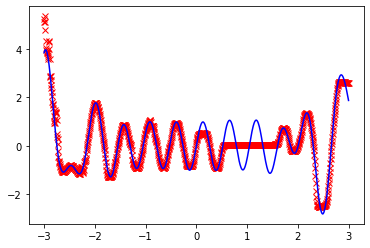

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.1162407464019799
